<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [52]</a>'.</span>

In [1]:
import logging
logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')



# Config

In [2]:
import sys
TRAIN = True
TRAIN_MODEL_3 = False
IN_COLAB = 'google.colab' in sys.modules
print ('Running in colab:', IN_COLAB)

Running in colab: False


In [3]:
import os

if not IN_COLAB:
  nb_dir = os.path.split(os.getcwd())[0]
  if nb_dir not in sys.path:
      sys.path.append(nb_dir)
else:
  %tensorflow_version 1.x
  import tensorflow as tf
  print(tf.__version__)

In [4]:
if IN_COLAB:
  !pip install --upgrade pip
  !pip --version
  !pip install --no-deps --upgrade git+https://www.github.com/nemoware/analyser.git@uber-models
  !pip install -q pyjarowinkler overrides
  

In [5]:
import os
import random
import math
import json
import warnings

from os import path
from pathlib import Path
import analyser.hyperparams

training_reports_path = Path(analyser.hyperparams.__file__).parent.parent / 'training_reports/'

if not IN_COLAB:
    _work_dir_default = os.path.realpath(os.path.join(  analyser.hyperparams.__file__, '..', '..', '..', 'work'))
    work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

    if not os.path.isdir(work_dir):
        os.mkdir(work_dir)

    analyser.hyperparams.work_dir = work_dir
else:

    from google.colab import drive
    drive.mount('/content/drive')
    os.environ['GPN_WORK_DIR']='/content/drive/My Drive/GazpromOil/trainsets/uber_2'
    analyser.hyperparams.work_dir = os.environ['GPN_WORK_DIR']

print('work_dir=', analyser.hyperparams.work_dir)


assert os.path.isdir(analyser.hyperparams.work_dir)

Nemoware Analyser v23.1.27.1
USING WORKDIR: [/root/artem/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/root/artem/work/datasets]
reports_dir: [/root/artem/work/reports]
work_dir= /root/artem/work


/root/artem/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


# Imports

In [6]:
%matplotlib inline
import tensorflow as tf
print(tf.__version__)

 


import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

from colab_support.renderer import *

import pickle
import numpy as np
import pandas as pd

from bson import json_util

from analyser.legal_docs import LegalDocument, make_headline_attention_vector
from analyser.headers_detector import make_predicted_headline_attention_vector, get_tokens_features
from analyser.hyperparams import models_path
from analyser.text_tools import find_top_spans
from analyser.persistence import DbJsonDoc

from trainsets.trainset_tools import TrainsetBalancer, SubjectTrainsetManager
from trainsets.retrain_contract_uber_model import UberModelTrainsetManager

from tf_support import super_contract_model
from tf_support.super_contract_model import get_base_model, semantic_map_keys_contract
from tf_support.super_contract_model import uber_detection_model_005_1_1
from tf_support.tf_subject_model import decode_subj_prediction
from tf_support.tools import KerasTrainingContext
# from tf_support.embedder_elmo import ElmoEmbedder


from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
 
from keras.models import load_model


from tensorflow import keras
import keras.backend as K
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout, Lambda
from keras.layers import concatenate, SpatialDropout1D, ActivityRegularization
from keras.layers import MaxPooling1D, Activation, ThresholdedReLU, GaussianNoise

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential, Model

# from keras.utils import plot_model
from keras.preprocessing.sequence import pad_sequences


2023-01-31 23:40:55.634209: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


2.5.0


/tmp/ipykernel_216381/3340962001.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9649122807017544


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_USER environment variable! defaulting to None


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_PASSWORD environment variable! defaulting to None


[currencies.py:17 -             _env_var() ] Currency-service : define GPN_CURRENCY_URL environment variable! defaulting to None


[documents.py:270 -             __init__() ] loading word cases stats model from: /root/artem/analyser/analyser/vocab/word_cases_stats.pickle


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/analyser/vocab


In [7]:
print('training_reports_path=', training_reports_path)

training_reports_path= /root/artem/analyser/training_reports


In [8]:
# gpu_devices = tf.config.experimental.list_physical_devices('GPU')

# for device in gpu_devices:
#     print(device)
#     tf.config.experimental.set_memory_growth(device, True)

# Prepare trainset


In [9]:
if not IN_COLAB:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata = documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

In [10]:
if False:
    jdoc = get_doc('5df1f44dec85d861954efc47')
    doc = jdoc.asLegalDoc()
    doc.tokens
    

work_dir = Path(analyser.hyperparams.work_dir)
print(work_dir)

/root/artem/work


In [11]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx = xx[ (xx.version=='3.0.0') | (xx.version=='22.12.7')].sort_values(['score'])
# xx.to_csv('contracts_to_re-analyze.csv')
# xx

In [12]:
# xx = stats.loc[stats['user_correction_date'].notnull()]
# xx['user_correction_date'] = pd.to_datetime(xx['user_correction_date'], utc=True)


# xx['user_correction_date'] = xx['user_correction_date'].astype('datetime64[ns]')


# xx.to_datetime(df_res['DateTime'], utc=True)

# xx['user_correction_date'] = xx['user_correction_date'].dt.tz_localize(None)

# xx.sort_values(['user_correction_date'])

In [13]:
# yy = xx.sort_values(['user_correction_date'])[xx.version!='22.12.7'][xx.source=='db'].sort_values(['score'])
# yy

In [14]:
# stats['user_correction_date'] = stats['user_correction_date'].dt.tz_localize(None)
# stats.sort_values(['user_correction_date'])

In [15]:
# yy.to_csv('contracts_to_review.csv')

In [16]:
umtm = UberModelTrainsetManager (work_dir, reports_dir=training_reports_path)

umtm.load_contract_trainset_meta() # 'contract_trainset_meta.csv'
stats = umtm.stats
stats

source                          checksum   version  \
_id                                                                           
6340244c9d08c565cfa12341     db  bc7d70a32aed6af4ef6c7752a1b7674d     3.0.0   
6391b4771864c6df4d29f332     db  22f701119d81787cd423f79f0f9fd9db   22.12.7   
5ec2b8da665f7603e03b1255     db  3187bfac60ea578221c5d9357756c6c1     1.6.5   
5edbc62eda3678279fbcadf3   file  027a7c30f74ff8ffe684378e9883dd8e     2.0.2   
5ded4e284ddc27bcf92dd6ce   file  9a44591c17d2b8f34dc8f1c3600c8c3a    1.11.2   
...                         ...                               ...       ...   
63ce4a52e83d1ee490f3f740     db  7a267d33c19e0b4d7e514457da480594  23.01.23   
63ce4a50e83d1ee490f3f718     db  544d9b056424de5a05ea78c941343c91  23.01.23   
63ce4a76e83d1ee490f3f956     db  6c735fd13e8c72963eac540a4597a11d  23.01.23   
63c506c9e2456d59975e1277     db  82e18ed67e11ab8a145ecd4f37cb08a6  23.01.04   
63c506d9e2456d59975e1402     db  0b84d66ba1ce7e5f31566388cbd2c90e  23.01.04   

                                         export_date     len  \
_id                                                            
6340244c9d08c565cfa12341  2023-01-31 18:37:33.526517  6740.0   
6391b4771864c6df4d29f332  2023-01-31 21:42:26.240684  1990.0   
5ec2b8da665f7603e03b1255  2023-01-31 21:42:23.232609  5840.0   
5edbc62eda3678279fbcadf3  2023-01-31 21:41:24.891253  1370.0   
5ded4e284ddc27bcf92dd6ce  2023-01-31 21:41:21.211562   460.0   
...                                              ...     ...   
63ce4a52e83d1ee490f3f740  2023-01-31 21:43:11.568511   450.0   
63ce4a50e83d1ee490f3f718  2023-01-31 21:43:11.434089   380.0   
63ce4a76e83d1ee490f3f956  2023-01-31 21:43:18.421714   260.0   
63c506c9e2456d59975e1277  2023-01-31 21:42:26.504717  1390.0   
63c506d9e2456d59975e1402  2023-01-31 21:42:26.534577   810.0   

                                             analyze_date         value  \
_id                                                                       
6340244c9d08c565cfa12341 2022-10-07 16:09:15.340000+00:00  2.000000e+09   
6391b4771864c6df4d29f332 2022-12-08 22:25:50.608000+00:00  1.000000e+11   
5ec2b8da665f7603e03b1255 2020-05-18 17:16:38.114000+00:00  2.523632e+07   
5edbc62eda3678279fbcadf3 2020-07-18 20:24:58.934000+00:00  2.400000e+04   
5ded4e284ddc27bcf92dd6ce 2020-06-12 21:09:19.574000+00:00  5.900000e+05   
...                                                   ...           ...   
63ce4a52e83d1ee490f3f740 2023-01-25 02:32:09.656000+00:00           NaN   
63ce4a50e83d1ee490f3f718 2023-01-25 02:22:59.686000+00:00           NaN   
63ce4a76e83d1ee490f3f956 2023-01-25 06:59:03.628000+00:00           NaN   
63c506c9e2456d59975e1277 2023-01-16 11:20:29.438000+00:00           NaN   
63c506d9e2456d59975e1402 2023-01-16 11:21:57.571000+00:00           NaN   

                          value_log1p  value_span currency  ... documentType  \
_id                                                         ...                
6340244c9d08c565cfa12341    21.416413       909.0      RUB  ...    AGREEMENT   
6391b4771864c6df4d29f332    25.328436       483.0      RUB  ...     CONTRACT   
5ec2b8da665f7603e03b1255    17.043795      5674.0      BRL  ...     CONTRACT   
5edbc62eda3678279fbcadf3    10.085851       747.0      RUB  ...     CONTRACT   
5ded4e284ddc27bcf92dd6ce    13.287880       150.0      RUB  ...     CONTRACT   
...                               ...         ...      ...  ...          ...   
63ce4a52e83d1ee490f3f740          NaN         NaN      NaN  ...     CONTRACT   
63ce4a50e83d1ee490f3f718          NaN         NaN      NaN  ...     CONTRACT   
63ce4a76e83d1ee490f3f956          NaN         NaN      NaN  ...     CONTRACT   
63c506c9e2456d59975e1277          NaN         NaN      NaN  ...    AGREEMENT   
63c506d9e2456d59975e1402          NaN         NaN      NaN  ...    AGREEMENT   

                         subj_len headers  \
_id                                         
6340244c9d08c565cfa12341    130.0    22.0   
6391b4771864

In [17]:
# stats[ ['org-1-alias', 'org-2-alias'] ]

s = stats[ stats['org-2-alias']=='' ]
s = s[s['unseen']==False]
s

source                          checksum    version  \
_id                                                                            
63908ca4a1bded13e629f2ea     db  22f701119d81787cd423f79f0f9fd9db    22.12.6   
635fa41fbf4cb23cbb39282c     db  f0a310314445370ce8de8b129199a2ff   23.01.23   
5fbbbd1da2b4551c06107a7d     db  7771c64028a040ddf1f22f4664f238d9      2.0.5   
63908ca4a1bded13e629f2e3     db  6a87cd84af3ae0dce2acc4177a9de9e3    22.12.6   
63908ca4a1bded13e629f2e6     db  b749fc61fbde1a224579121dc12f5035    22.12.6   
5fbbe46ea2b4551c06107c9e     db  e5c4477bb27fdffef9ab3b13fa94f8e5      2.0.5   
633d4fa09d08c565cfa12315     db  163b22eb16fc5bb3bfb471850e971f41   23.01.23   
612de89f4f22ff1b7e02fcd7     db  6560f3f3deac027388391acb58c3c515      2.4.4   
5ded07184ddc27bcf92dd50e   file  067cd57d0e76b44df93b600b745ac570     1.12.0   
63c92b5dfb21317f1d5e0f83     db  8e9d420c372a7e6bd3faf2eb560cd207  23.1.27.1   
5ee8c456c28b75807f3dabe3   file  e8eab5ada4b863dd0d54305b418d91dc     1.22.0   
5fe34f64b770574a005553f1     db  a9b3e7f5945a9d1ae1226b15e76b0e31     2.3.13   
638f0a84b1363747e929f31c     db  d9d6711432d6c848236f3402216f5711   23.01.23   
5fb3d4a078df3635f5441c49     db  f64634622d8dee0be5369e1edcf894f5    22.12.8   
628771c24d1bfe5e5b297dfa     db  f124a5bf4d87a0344cd6463d82818475      3.0.0   
638085646a07f3e980b2c0e7     db  d9d6711432d6c848236f3402216f5711      3.0.0   
6152e54f8558145da68d8795     db  a4790340f19a324410d4dd635fc47bb5      2.4.6   
6152e4f28558145da68d8793     db  1e35532d32bcdb9d23e503fa1c9e436f      2.4.6   
6380855d6a07f3e980b2c073     db  63f6600e241fc8eb309690a49e0bb64e    22.12.7   
5fbbe46ca2b4551c06107bfb     db  4a6cdb23749541241b9c142920487fc5      2.0.5   
63c506e4e2456d59975e1540     db  d6e29ec1bdd6fd0162e01a00981021f8   23.01.27   
610d2b0d7dfce422c4272d33     db  f61ad4e19d2caa4f2f5f80182cb0a9b8      2.4.4   
5fbbe46ba2b4551c06107bdc     db  db7d3a122a8cb7d47f61ed1cd3d9f655      2.0.5   
5fdb2143542ce403c92b45a1     db  20340c9785f82a2aff87c610dc05628b      2.0.5   
5fbbe46ca2b4551c06107c02     db  174b5b69670a4f39dde302f8fe2b453e      2.0.5   
6166e28787f1d9065bb8b943     db  1828544faa8f0f8df11a27e7f0bbfcee      2.5.0   
615e9b0e8f3b0514f3f4240a     db  fbf6ef2e277cce62dc5e914611a3aa48      2.4.6   
615e9b2c8f3b0514f3f42410     db  8f998f60171ab514883e579e18864f65      2.4.6   
615e9b028f3b0514f3f42408     db  f1329480efa28b33cfe54dccbc8a9f3c      2.4.6   
615ed8118f3b0514f3f42427     db  a85f11eeb0b3d1c8e13faa25f87ed9de      2.4.6   
5fbbe46aa2b4551c06107b9f     db  ebc7440fa9899b39ec49537243c6c079      2.0.5   
5fdb2141542ce403c92b456a     db  93bda6c1a238a547e46ad37ca043f577      2.0.5   
5fbbe46da2b4551c06107c65     db  83b8f98c9740866007ec286cf0876f57      2.0.5   
5fdb2140542ce403c92b4555     db  0a75377aec59387b3c2a0ca5c03109d1      2.0.5   
6166e14787f1d9065bb8b940     db  0453d689546938f3ef8c705502bed0ab      2.5.0   
5fdb2146542ce403c92b460d     db  00aeba85e80fa49e5a91a0dc973d3994      2.0.5   
612344edb8ceba5a6803d249     db  61cfee32867b371843d1e95a194ea2a6      2.4.4   
615ac8b28f3b0514f3f423f2     db  1460c5ee8dc3bdad835353dcd06759c3      2.4.6   
615ac8cf8f3b0514f3f423f8     db  ff661d4dd0ac0eda0163cab2de660193      2.4.6   
6152dfc18558145da68d876d     db  08a1b54354641f83fa944ea523966e97      2.4.6   
6152e3798558145da68d8788     db  5edeb2ed04d1987ccf361ebad8f4b4e4      2.4.6   
6152e26a8558145da68d8771     db  459d36e956e5b4137173912a5ff89295      2.4.6   
6152e3af8558145da68d8790     db  558145a0101e19160bc948711b93e8cd      2.4.6   
6152e3a38558145da68d878d     db  bbf3affc164c87cee039b6e1b2d1e936      2.4.6   
6152e27a8558145da68d8773     db  fe3c033c5f5f9dc694de780717072bbe      2.4.6   
6152e5cc8558145da68d8797     db  701487def1a757c5050faeb56feee821      2.4.6   

                                         export_date      len  \
_id                                                             
63908ca4a1bded13e629f2ea  2023-01-31 21:42:26.221324  

In [18]:
print(len(stats))

2759


In [19]:
stats[stats.subj_len>=150]

source                          checksum   version  \
_id                                                                           
6391b4771864c6df4d29f332     db  22f701119d81787cd423f79f0f9fd9db   22.12.7   
63908ca4a1bded13e629f2e4     db  665a638dc4f2c42ce670679ca76cff77   22.12.6   
639316f61002115a6029f3c8     db  670b730e664306d9e1e7f19a358cc0ab   22.12.7   
635fa418bf4cb23cbb3927df     db  a1fb45add4b27e24816829e966e60f64     3.0.0   
634018f59d08c565cfa1233d     db  b4125e9a11aa5ab7f64f8d82cacbcca7     3.0.0   
...                         ...                               ...       ...   
63ce49fae83d1ee490f3f246     db  5ce7d41417a3e72e26fa5a27aff87081  23.01.23   
638085b86a07f3e980b2c865     db  f48f275cfea2e513e0903e51018a0393     3.0.0   
63c506e3e2456d59975e151e     db  492fc5ef7c7d15f063fc924dca4fa0b5  23.01.04   
638085ba6a07f3e980b2c8a3     db  e763076767ebfba9c4f9b19c8b56577f     3.0.0   
63ce4b0be83d1ee490f4009d     db  a35591663822c05db4729b91ed3a9276  23.01.23   

                                         export_date      len  \
_id                                                             
6391b4771864c6df4d29f332  2023-01-31 21:42:26.240684   1990.0   
63908ca4a1bded13e629f2e4  2023-01-31 18:32:55.249265   2020.0   
639316f61002115a6029f3c8  2023-01-31 21:26:42.950175   1260.0   
635fa418bf4cb23cbb3927df  2023-01-31 18:32:43.740615   1320.0   
634018f59d08c565cfa1233d  2023-01-31 18:37:33.489529    410.0   
...                                              ...      ...   
63ce49fae83d1ee490f3f246  2023-01-31 21:42:52.980404    920.0   
638085b86a07f3e980b2c865  2023-01-31 18:36:14.021955   6970.0   
63c506e3e2456d59975e151e  2023-01-31 21:42:47.398166   8180.0   
638085ba6a07f3e980b2c8a3  2023-01-31 18:36:14.385120  14510.0   
63ce4b0be83d1ee490f4009d  2023-01-31 21:43:37.191817  11690.0   

                                             analyze_date         value  \
_id                                                                       
6391b4771864c6df4d29f332 2022-12-08 22:25:50.608000+00:00  1.000000e+11   
63908ca4a1bded13e629f2e4 2022-12-07 15:55:04.590000+00:00  1.500000e+10   
639316f61002115a6029f3c8 2022-12-09 14:08:03.016000+00:00  3.433397e+09   
635fa418bf4cb23cbb3927df 2022-10-31 13:46:20.633000+00:00  3.000000e+09   
634018f59d08c565cfa1233d 2022-10-07 15:18:25.437000+00:00  2.500000e+09   
...                                                   ...           ...   
63ce49fae83d1ee490f3f246 2023-01-23 14:51:37.328000+00:00           NaN   
638085b86a07f3e980b2c865 2022-11-25 20:42:05.633000+00:00           NaN   
63c506e3e2456d59975e151e 2023-01-16 14:28:06.456000+00:00           NaN   
638085ba6a07f3e980b2c8a3 2022-11-25 20:49:51.884000+00:00           NaN   
63ce4b0be83d1ee490f4009d 2023-01-26 07:15:10.062000+00:00           NaN   

                          value_log1p  value_span currency  ...  \
_id                                                         ...   
6391b4771864c6df4d29f332    25.328436       483.0      RUB  ...   
63908ca4a1bded13e629f2e4    23.431316       201.0      RUB  ...   
639316f61002115a6029f3c8    21.956816       151.0      RUB  ...   
635fa418bf4cb23cbb3927df    21.821878       159.0      RUB  ...   
634018f59d08c565cfa1233d    21.639557       141.0      RUB  ...   
...                               ...         ...      ...  ...   
63ce49fae83d1ee490f3f246          NaN         NaN      NaN  ...   
638085b86a07f3e980b2c865          NaN         NaN      NaN  ...   
63c506e3e2456d59975e151e          NaN         NaN      NaN  ...   
638085ba6a07f3e980b2c8a3          NaN         NaN      NaN  ...   
63ce4b0be83d1ee490f4009d          NaN         NaN      NaN  ...   

                                     documentType subj_len headers  \
_id                                                                  
6391b4771864c6df4d29f332                 CONTRACT    151.0     8.0   
63908ca4a1bded13e629f2e4                 CONTRACT    183.0    11.0   
639316f61002115a6029f3c

# Weights: вычисление весов samples  

чтобы всех запутать, 
 - вес пропорционален логорифму цены контракта (чтобы было меньше ошибок в контрактах на большие суммы)
 - more weight for user-corrected datapoints
 - normalize weights, so the sum == Number of samples

In [20]:
from trainsets.trainset_tools import get_feature_log_weights
stats = umtm.stats
stats = stats[stats.documentType != 'ANNEX']
stats = stats[stats.documentType != 'undefined']

print(len(stats))
get_feature_log_weights(stats, 'documentType')

2759


CONTRACT                   0.643501
SUPPLEMENTARY_AGREEMENT    1.099092
AGREEMENT                  1.257407
Name: documentType, dtype: float64

In [21]:
# from trainsets.trainset_tools import get_feature_log_weights
# _w=get_feature_log_weights(umtm.stats, 'subject')
# _w*_w*_w

In [22]:


subject_weights = get_feature_log_weights(stats, 'subject')
subject_weights = subject_weights * subject_weights * subject_weights

for i, row in stats.iterrows():
  subj_name = row['subject']

  sample_weight = 0.5 
  if not pd.isna(row['user_correction_date']):  # more weight for user-corrected datapoints
    sample_weight = 5.0   # TODO: must be estimated anyhow smartly

  value_weight = 1.0
  if not pd.isna(row['value_log1p']):
    # чтобы всех запутать, вес пропорционален логорифму цены контракта
    # (чтобы было меньше ошибок в контрактах на большие суммы)
    value_weight = 1.0 + row['value_log1p']

  sample_weight *=  value_weight 
  subject_weight =  subject_weights[subj_name] 
  stats.at[i, 'subject_weight'] = subject_weight + random.random()
  stats.at[i, 'sample_weight'] = sample_weight + random.random()

# normalize weights, so the sum == Number of samples
stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()

print(stats.sample_weight.mean())
print(stats.subject_weight.mean())
print(stats.sample_weight.min())
print(stats.subject_weight.min())
print(stats.sample_weight.max())
print(stats.subject_weight.max())

stats.to_csv( work_dir / 'contract_trainset_meta.csv', index=True)

subject_weights

1.0000000000000002
1.0000000000000002
0.02071753425447895
0.14951925208382238
6.20719874128854
6.718931147603799


Service                              0.121814
Deal                                 0.236185
Renting                              0.393508
GeneralContract                      0.422598
Other                                0.422598
Loans                                0.484172
AgencyContract                       0.597175
DealIntellectualProperty             0.666819
Charity                              0.775031
Insurance                            0.864276
RealEstate                           1.197816
RealEstateTransactions               2.132792
BankGuarantees                       2.639003
PledgeEncumbrance                    2.874418
ParticipationInOtherOrganizations    3.161230
SecuritiesTransactions               4.572597
Name: subject, dtype: float64

In [23]:
from tf_support.super_contract_model import make_xyw


# Validating training set

In [24]:
%%time


from tf_support.super_contract_model import  validate_datapoint

stats['valid'] = True
stats['error'] = ''

for i in stats.index:
  
  try:
    validate_datapoint(str(i), stats)

  except Exception as e:
    logger.error(e)

    stats.at[i, 'valid'] = False
    stats.at[i, 'error'] = str(e)
    
stats

 


umtm.stats = umtm.stats[  pd.isna(umtm.stats.value_span) + (umtm.stats.value_span < 10000) ] #remove big docs from TS
stats_valid = stats[stats['valid']]

del stats
print(len(stats_valid))
stats = stats_valid
umtm.stats = stats_valid

2759
CPU times: user 2.57 s, sys: 10.4 s, total: 13 s
Wall time: 33.4 s


/root/artem/env/lib/python3.8/site-packages/pandas/core/computation/expressions.py:203: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  warnings.warn(


In [25]:
len(stats_valid)

2759

In [26]:
print(stats.sample_weight.mean())
print(stats.subject_weight.mean())

stats.sample_weight /= stats.sample_weight.mean()
stats.subject_weight /= stats.subject_weight.mean()


print(stats.subject_weight.mean())
print(stats.subject_weight.min())

print('\n\nsample_weight')
print('MIN\t', stats.sample_weight.min())
print('MEAN\t', stats.sample_weight.mean())


1.0000000000000002
1.0000000000000002
1.0
0.14951925208382236


sample_weight
MIN	 0.020717534254478948
MEAN	 0.9999999999999997


/root/artem/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


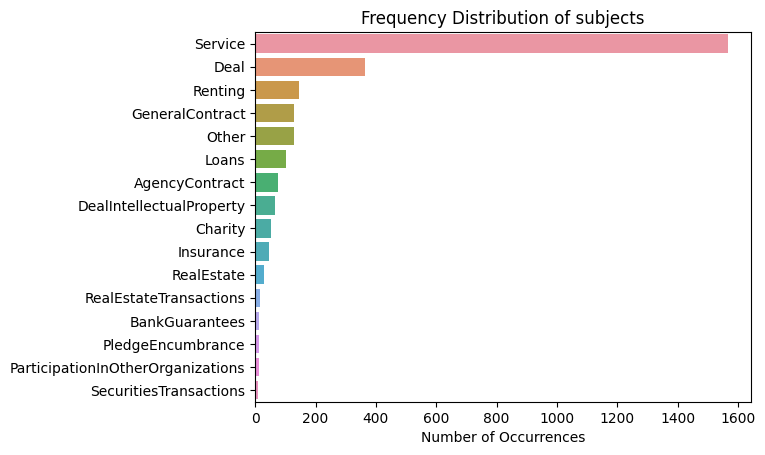


min 8
max 1566
total 2759


In [27]:
%matplotlib inline

subj_count = stats_valid['subject'].value_counts()

#plot distribution---------------------
sns.barplot(subj_count.values, subj_count.index)
plt.title('Frequency Distribution of subjects')
plt.xlabel('Number of Occurrences')
plt.show()


print ('\nmin', min (subj_count.values))
print ('max', max (subj_count.values))
print ('total', sum (subj_count.values))

In [28]:
from sklearn.utils import class_weight
from trainsets.trainset_tools import get_feature_log_weights

_classes = stats_valid['subject'].unique().tolist()

print(f'classes: {_classes}')

# class_weights = class_weight.compute_class_weight('balanced', _classes, umtm.stats['subject'])
# class_weights = dict(zip(_classes, class_weights))


class_weights = get_feature_log_weights(stats_valid, 'subject')
class_weights

classes: ['Loans', 'BankGuarantees', 'Service', 'AgencyContract', 'Charity', 'SecuritiesTransactions', 'Renting', 'PledgeEncumbrance', 'DealIntellectualProperty', 'Deal', 'GeneralContract', 'Insurance', 'ParticipationInOtherOrganizations', 'RealEstateTransactions', 'RealEstate', 'Other']


Service                              0.495716
Deal                                 0.618136
Renting                              0.732798
GeneralContract                      0.750428
Other                                0.750428
Loans                                0.785236
AgencyContract                       0.842107
DealIntellectualProperty             0.873647
Charity                              0.918557
Insurance                            0.952542
RealEstate                           1.062014
RealEstateTransactions               1.287210
BankGuarantees                       1.381911
PledgeEncumbrance                    1.421838
ParticipationInOtherOrganizations    1.467637
SecuritiesTransactions               1.659794
Name: subject, dtype: float64

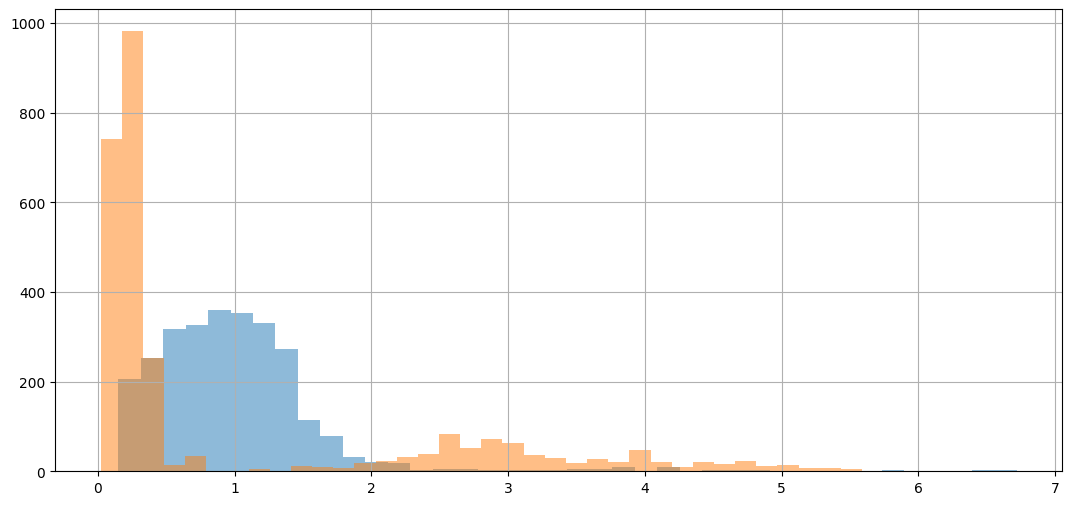

In [29]:
from trainsets.trainset_tools import get_feature_log_weights
 

plt.figure(figsize=(13, 6))

stats_valid['subject_weight'].hist(bins=40, alpha=0.5)
stats_valid['sample_weight'].hist(bins=40, alpha=0.5)

plt.xscale('linear') # log?
plt.show()

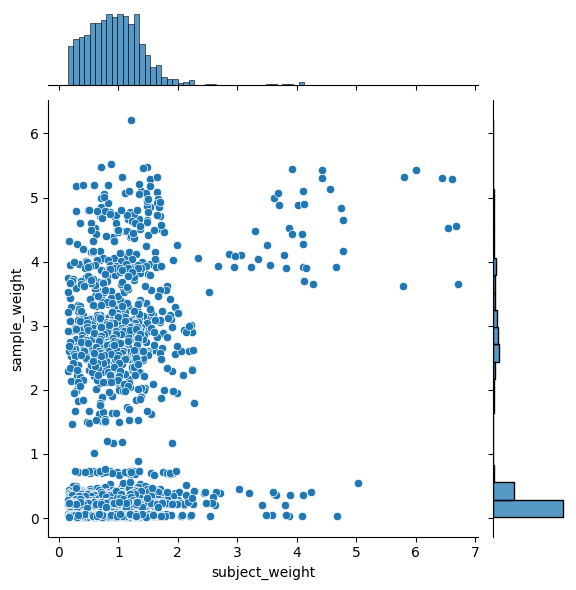

In [30]:
sns.jointplot(x="subject_weight", y="sample_weight", data=stats_valid)
plt.show()

# look into trainset (take a sample)

SAMPLE_DOC_ID 5fe34f62b770574a005553be
semantic map shape is: (759, 30)


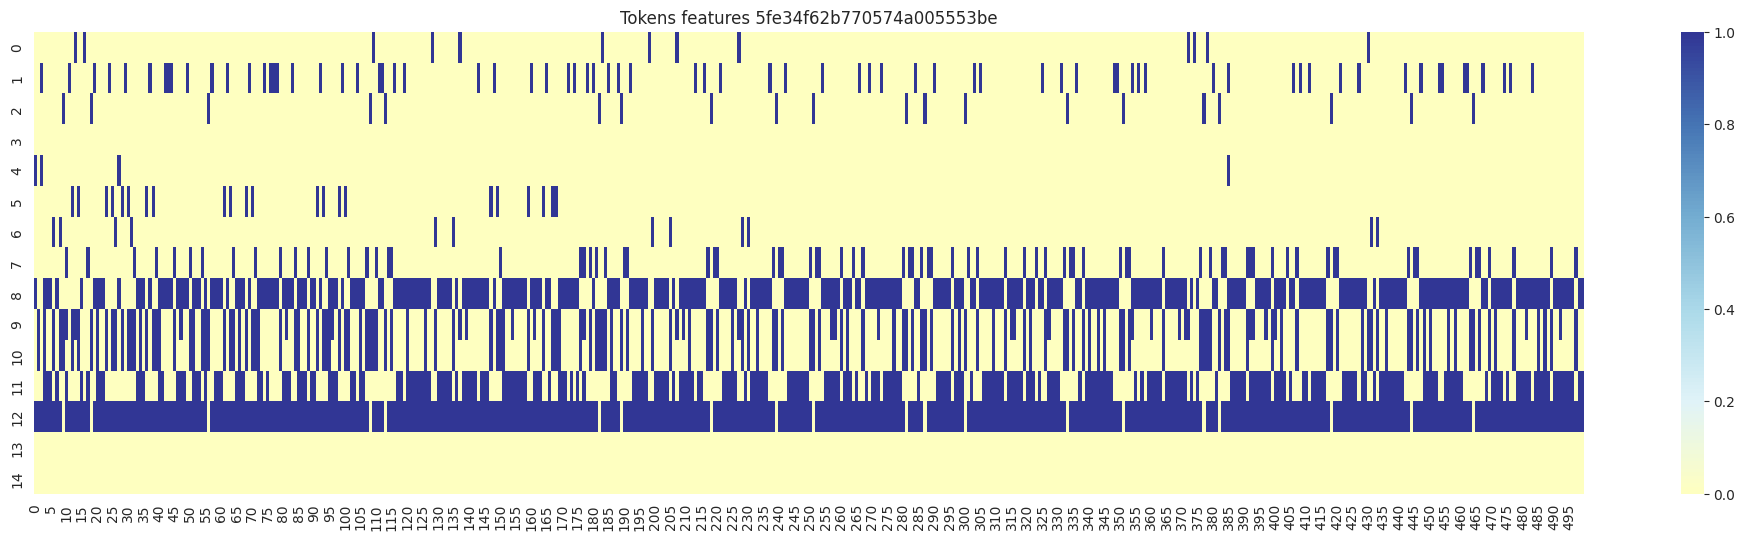

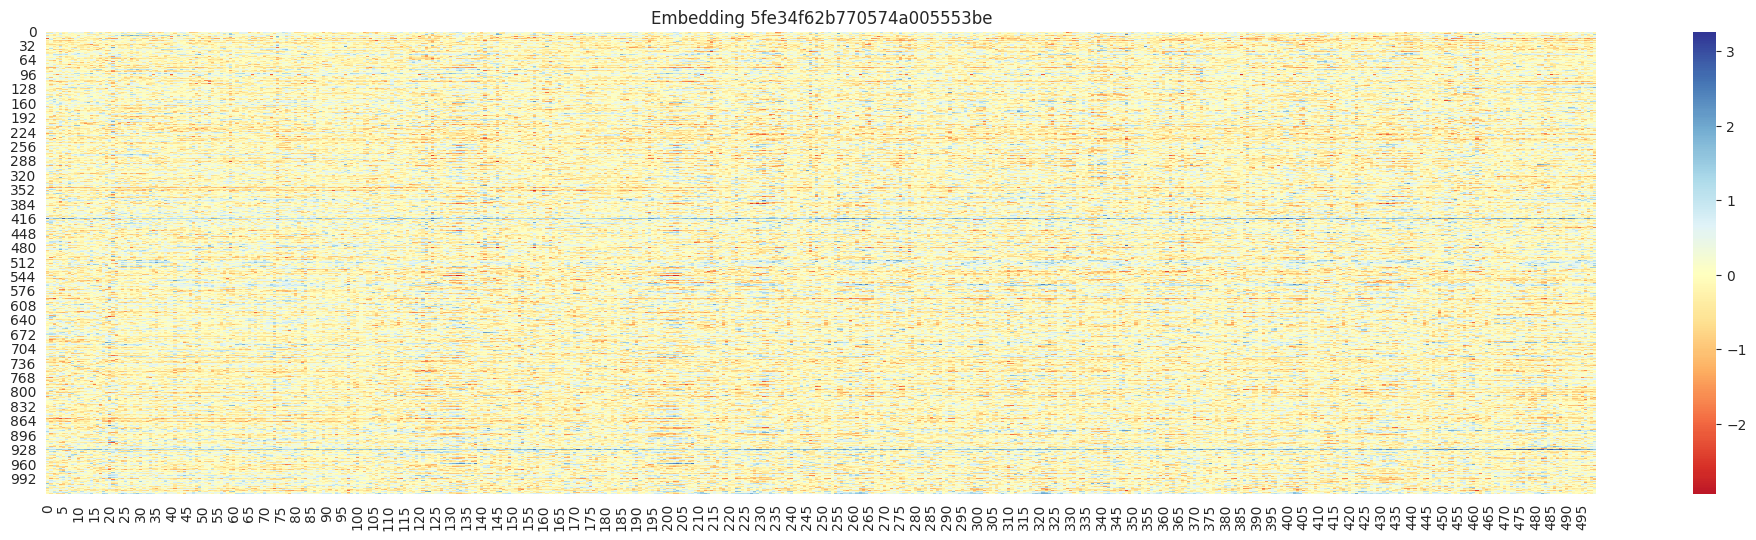

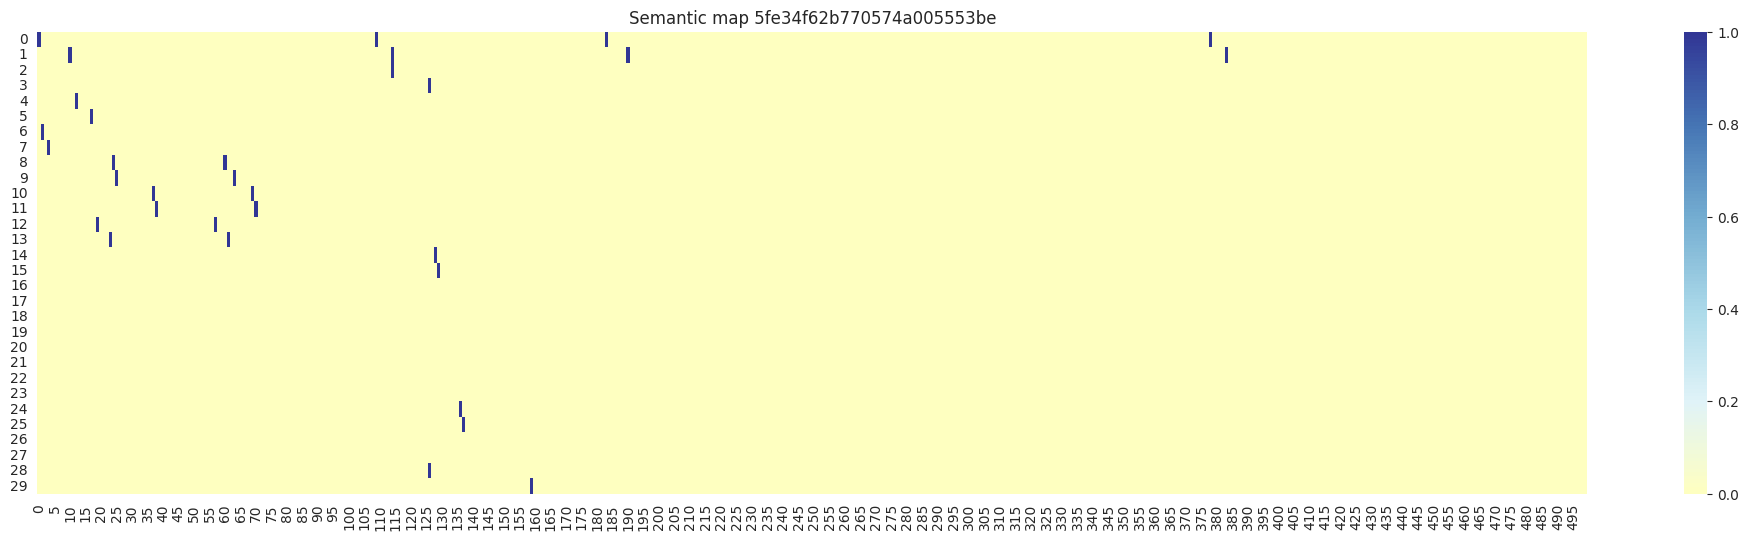

In [31]:
%matplotlib inline
# umtm.calculate_samples_weights()
SAMPLE_DOC_ID = '5fe34f62b770574a005553be' #stats_valid.index[1]

print('SAMPLE_DOC_ID', SAMPLE_DOC_ID)
(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = make_xyw(SAMPLE_DOC_ID, stats)
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[:_crop], title=f'Tokens features {SAMPLE_DOC_ID}') 
plot_embedding(emb[:_crop], title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[:_crop], title=f'Semantic map {SAMPLE_DOC_ID}')



# Batch generator & TODOs 🙏


- [X] TODO: add outliers to the trainset ?
- [ ] TODO: try sparse_categorical_entropy instead of one-hot encodings
- [ ] TODO: model 5.2, 5.1: bipolar concat layer is wrong because we concatenate thongs of different magnitudes. Add a Sigmoid activation layer
- [ ] TODO: chechk what is better: to pad with zeros or to pad with means
- [X] TODO: add weights to samples
- [ ] TODO: sum semantic map alongside vertical axis, and mutiply it (as a mask) by the subject detection seq
- [ ] TODO: introduce individual per tag threshosholds, also, the current 0.3 threshold is strange.

3
semantic map shape is: (14, 578, 30)


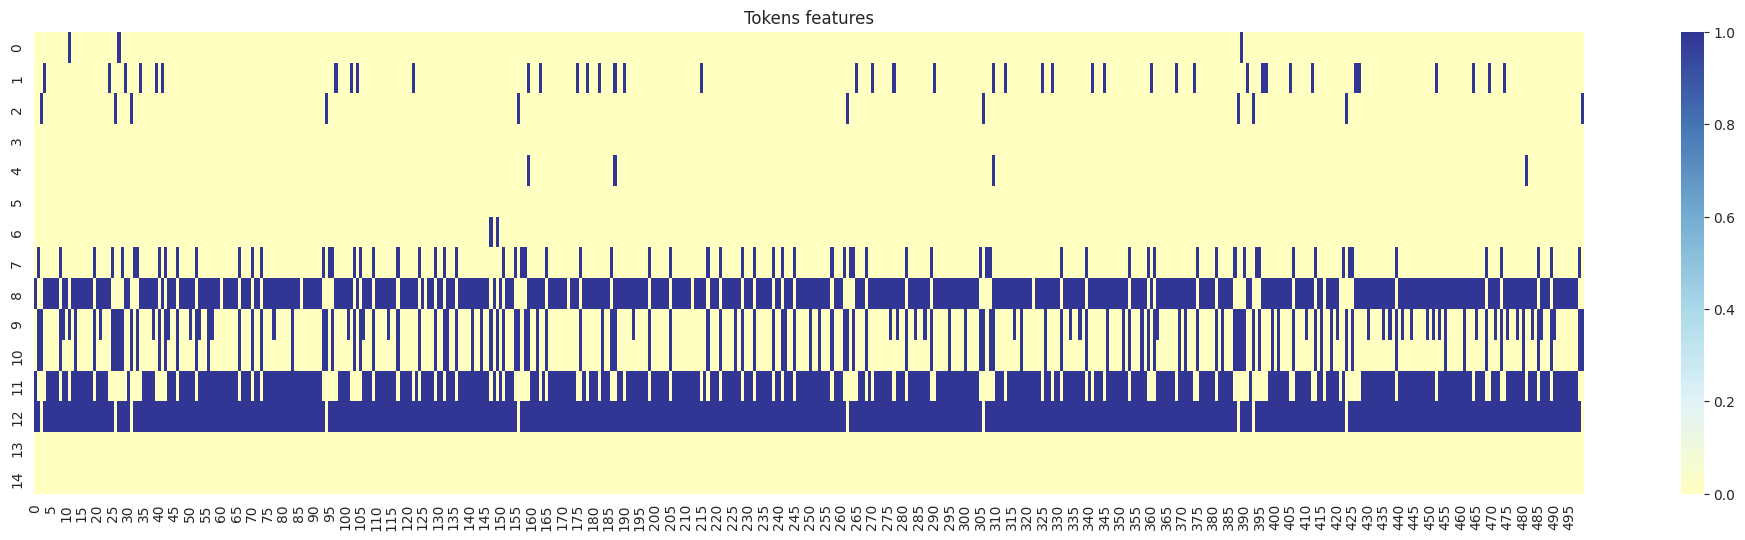

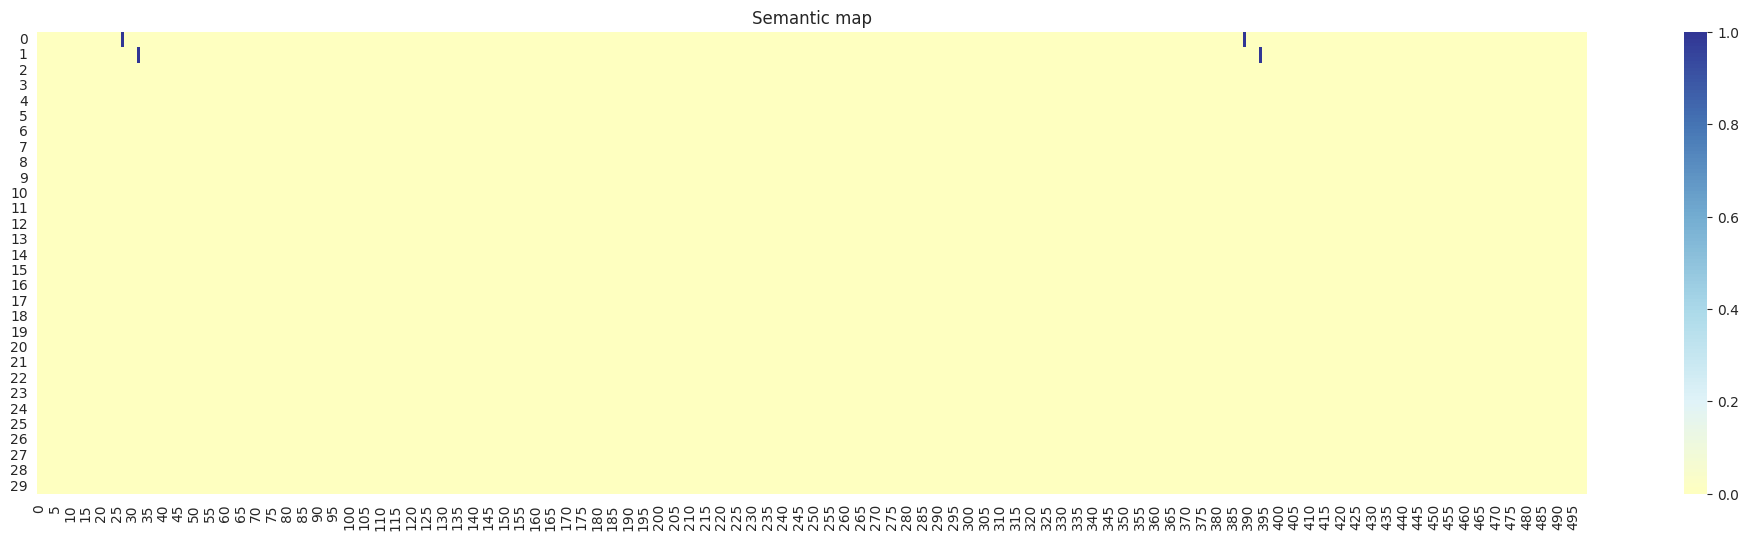

In [32]:
import numpy as np
import random
import pandas as pd

def make_generator(self, indices: [int], batch_size: int, augment_samples=False):
  np.random.seed(43)

  while True:
    # next batch
    batch_indices = np.random.choice(a=indices, size=batch_size)

    max_len = 128 * 12
    start_from = 0

    if augment_samples:
      max_len = random.randint(300, 1400)

    batch_input_emb = []
    batch_input_token_f = []
    batch_output_sm = []
    batch_output_subj = []

    weights = []
    weights_subj = []

    # Read in each input, perform preprocessing and get labels
    for doc_id in batch_indices:

      dp = make_xyw(doc_id, stats)
      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
        
#       print(dp)
    
      subject_weight_K = 1.0
      if augment_samples:
        start_from = 0

        row = stats_valid.loc[doc_id]
        if random.random() < 0.4:  # 40% of samples
          segment_center = random.randint(0, len(emb) - 1)  ##select random token as a center
          if not pd.isna(row['value_span']) and random.random() < 0.7:
            segment_center = int(row['value_span'])

          _off = random.randint(max_len // 4, max_len // 2)
          start_from = segment_center - _off
          if start_from < 0:
            start_from = 0
          subject_weight_K = 0.1  # lower subject weight because there mighе be no information about subject around doc. value
        
      dp = self.trim_maxlen(dp, start_from, max_len)
      
      # TODO: find samples maxlen

      (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp
#       print((sample_weight, subject_weight))
      subject_weight *= subject_weight_K

      batch_input_emb.append(emb)
      batch_input_token_f.append(tok_f)

      batch_output_sm.append(sm)
      batch_output_subj.append(subj)

      if np.isnan(sample_weight):
        raise ValueError()

      if np.isnan(subject_weight):
        raise ValueError()
      
      weights.append(sample_weight)
      weights_subj.append(subject_weight)
      # end if emb
    # end for loop

    # Returns a tuple of (input, output, weights) to feed the network
#     print('batch_output_subj', len(batch_output_subj))
#     print('batch_output_sm', len(batch_output_subj))

    yield ([np.array(batch_input_emb), np.array(batch_input_token_f)],
           [np.array(batch_output_sm), np.array(batch_output_subj)],
           [np.array(weights), np.array(weights_subj)])
    

    
_train, _test = train_test_split(stats_valid, test_size=0.10, stratify=stats_valid[['subject']])

train_indices = list(_train.index)
test_indices = list(_test.index)

    
####---test
_gen = make_generator(umtm, train_indices, 14, augment_samples=True)

sample = next(_gen)
print(len(sample))
del _gen
 


(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = sample
 
    
print('semantic map shape is:', sm.shape)
_crop = 500
plot_embedding(tok_f[0][:_crop], title=f'Tokens features') 
# plot_embedding(emb[:_crop],   title=f'Embedding {SAMPLE_DOC_ID}') 
plot_embedding(sm[0][:_crop],    title=f'Semantic map')

In [33]:
SAMPLE_DOC_ID

'5fe34f62b770574a005553be'

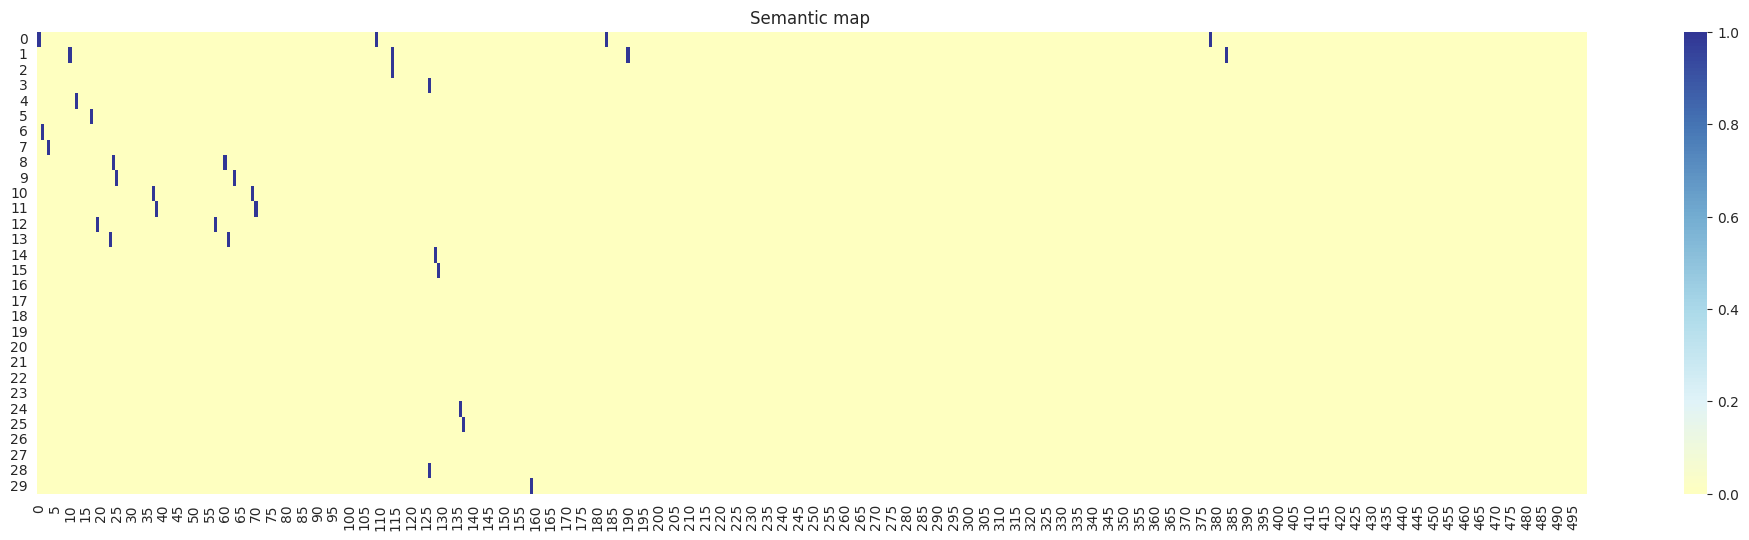

In [34]:
dp = make_xyw('5fe34f62b770574a005553be', stats_valid)

(emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

plot_embedding(sm[:500],    title=f'Semantic map ')

train_indices[0]: 6171128c8fd5658689eb2ba4
test_indices[0]: 63ce4b04e83d1ee490f40045


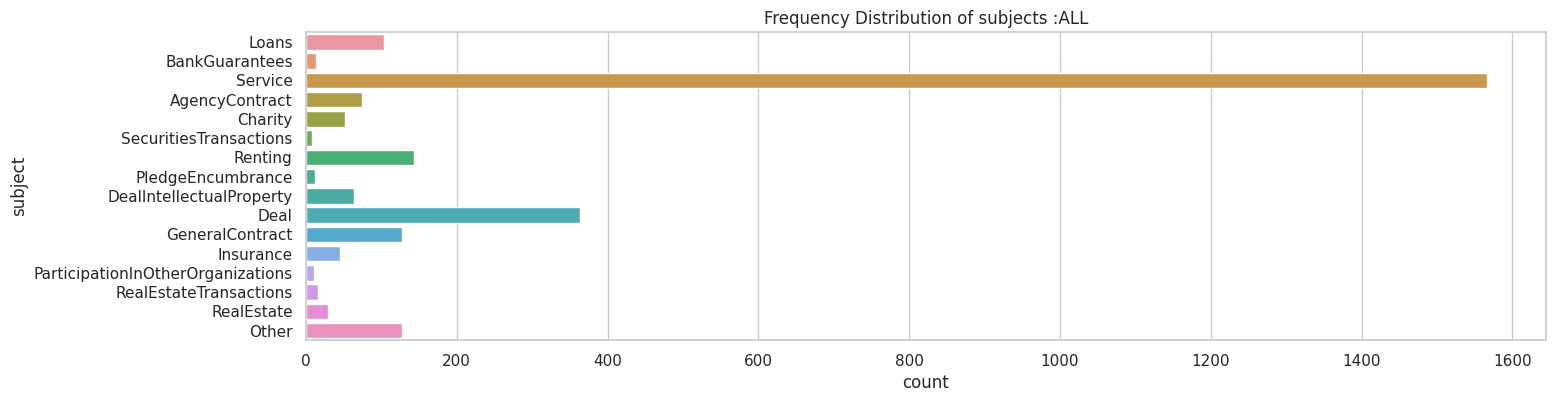

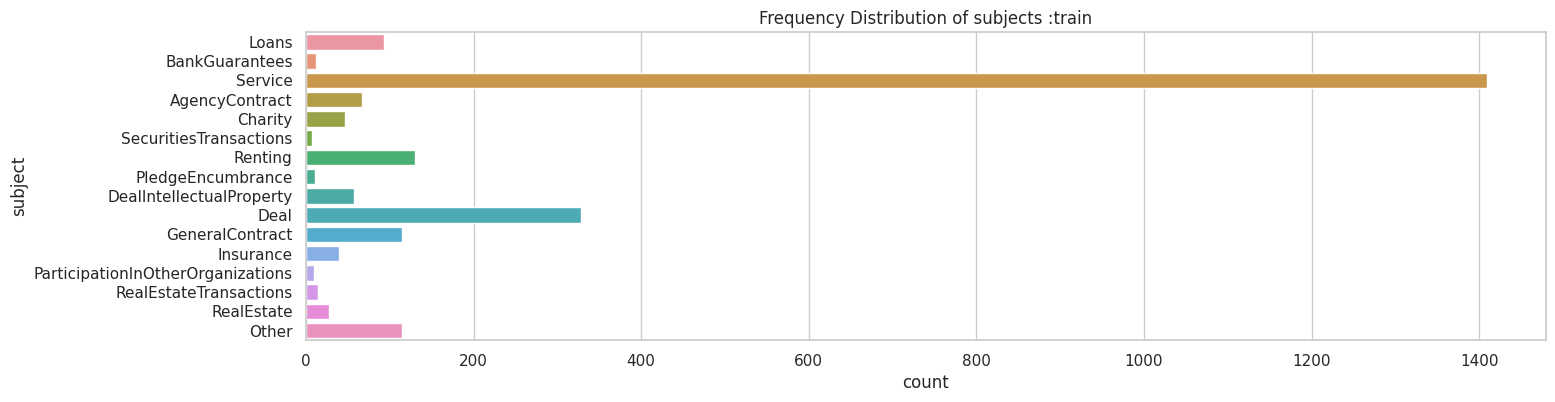

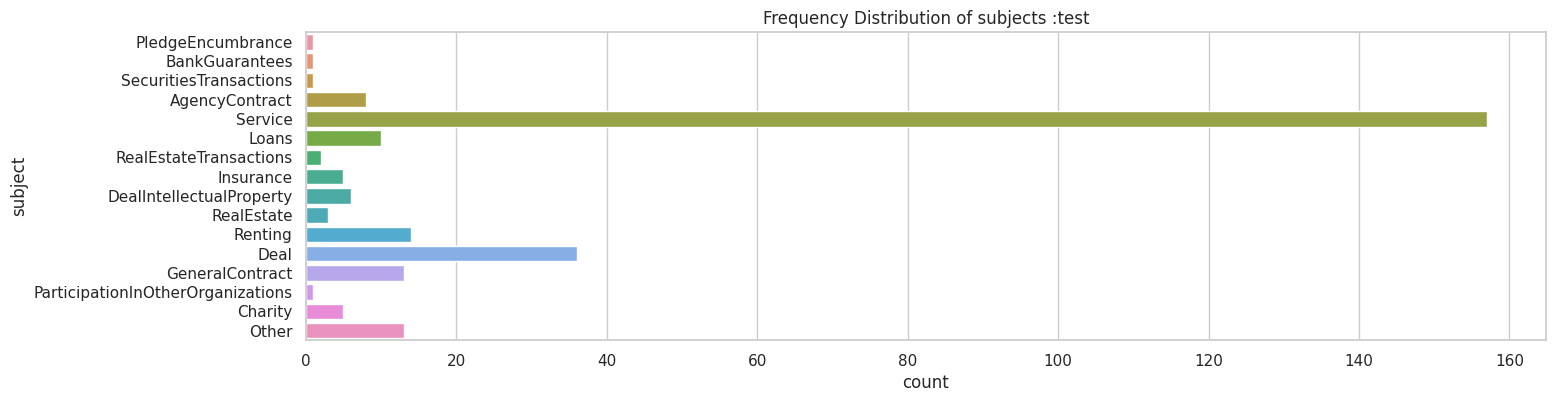

In [35]:
EPOCHS = 50
BATCH_SIZE = 128
EMB =  1024
 
_SELFTEST = True


print('train_indices[0]:', train_indices[0])
print('test_indices[0]:', test_indices[0])


def plot_subject_distr(df, title):  
  target='subject'
  plt.figure(figsize=(16,4))   
  sns.set(style="whitegrid")
  chart = sns.countplot(data=df, y=target)
  plt.title(f'Frequency Distribution of subjects :{title}')

 
plot_subject_distr(stats_valid, 'ALL')
plot_subject_distr(stats_valid[stats_valid.index.isin(train_indices)], 'train')
plot_subject_distr(stats_valid[stats_valid.index.isin(test_indices)], 'test')


if _SELFTEST:
  # test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True)
  
  x, y, w = next(train_gen)
  
#   print('X:', len(x), 'X[0]=', x[0].shape, 'X[1]=', x[1].shape)
#   print('Y:', len(y), 'Y[0]=', y[0].shape, 'Y[1]=', y[1].shape)
  

#   plot_embedding(x[0][0], 'X2: Token Embeddings')
#   plot_embedding(x[1][0], 'X1: Token Features')
#   plot_embedding(y[0][0], 'Y: Semantic Map')
  
#   print(y[0][1])

#   del x
#   del w
#   del y
#   del train_gen

In [36]:

ctx = KerasTrainingContext(checkpoints_path=umtm.reports_dir, session_index=1)

ctx.set_batch_size_and_trainset_size(BATCH_SIZE, 
                                     len(test_indices), 
                                     4 * len(train_indices))

DEFAULT_TRAIN_CTX = ctx
CLASSES = 43
FEATURES = 14

metrics = ['kullback_leibler_divergence', 'mse', 'binary_crossentropy']


def train(umodel):
  test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)

def overtrain(umodel):
  test_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE)
  train_gen = make_generator(umtm, list(train_indices) + list(test_indices), BATCH_SIZE, augment_samples=True) 
  ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen)


[tools.py:29 -             __init__() ] model_checkpoint_path: /root/artem/analyser/training_reports


batch_size:	128
train_samples:	9932
test_samples:	276
steps_per_epoch:	77
validation_steps:	38


# Models 🦖

In [37]:
def get_weights_filename(model_factory_fn):
    weights = ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.h5'
    print(weights.is_file(), weights)
    if not weights.is_file():
        weights = Path(analyser.hyperparams.models_path) / f'{model_factory_fn.__name__}.h5'
        print(weights.is_file(), weights)
    
    return weights

# get_weights_filename(uber_detection_model_005_1_1)

## Train from 0 uber_detection_model_003

In [38]:
if TRAIN_MODEL_3:
    from tf_support.super_contract_model import uber_detection_model_003
    
    model_factory_fn = uber_detection_model_003
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 10
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Continue training 003 from checkpoint

In [39]:
analyser.hyperparams.models_path

'/root/artem/analyser/analyser/vocab'

In [40]:
if TRAIN_MODEL_3:
    
    model_factory_fn = uber_detection_model_003

    weights = get_weights_filename(model_factory_fn)
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 25
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

## Overtrain 003

In [41]:
if TRAIN_MODEL_3:
    if TRAIN:
      ctx.unfreezeModel(umodel)
      umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
      print(super_contract_model.losses)
      umodel.summary()

      ctx.EPOCHS = 12
      ctx.EVALUATE_ONLY = False

      test_gen = make_generator(umtm, train_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 

      ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=False, lr=2e-5)

## 005 model
- 0.0233: last val subject loss
- 0.0016: last tagging loss
- 0.0248: last val loss


In [42]:
if TRAIN_MODEL_3:
    model_factory_fn = uber_detection_model_005_1_1
    umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, load_weights=False )

    umodel.summary()

    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 20
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

### 5.1.1 💕💕 uber_detection_model_005_1_1

In [43]:
from tf_support.super_contract_model import FEATURES 
from analyser.headers_detector import TOKEN_FEATURES

from tf_support.super_contract_model import sigmoid_focal_crossentropy, losses

import numpy as np
from pandas import DataFrame 



model_factory_fn = uber_detection_model_005_1_1
weights = get_weights_filename(model_factory_fn)
umodel = ctx.init_model(model_factory_fn, trained=True, trainable=True, weights=weights)

True /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


2023-01-31 23:41:47.237682: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2023-01-31 23:41:47.752142: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-31 23:41:47.752799: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: A100-PCIE-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2023-01-31 23:41:47.752815: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2023-01-31 23:41:47.752850: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-01-31 23:41:47.752866: I tensorflow/stream_executor/platform/defa

[tools.py:121 -           init_model() ] weights loaded: /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


In [44]:
######################
# Phase I retraining
# ❄️ frozen bottom layers
######################
if True:
    if TRAIN:
      test_gen = make_generator(umtm, test_indices, BATCH_SIZE)
      train_gen = make_generator(umtm, train_indices, BATCH_SIZE, augment_samples=True) 

      ctx.EPOCHS = 10
      ctx.EVALUATE_ONLY = False
      ctx.train_and_evaluate_model(umodel, generator=train_gen, test_generator=test_gen, retrain=True)

/root/artem/env/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


model.name == uber_detection_model_005_1_1
continue: lr:0.0010000000474974513, epoch:0


2023-01-31 23:41:51.067467: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-31 23:41:51.085861: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3699850000 Hz


Epoch 1/10


2023-01-31 23:41:54.973920: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8


2023-01-31 23:41:56.391486: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8500


2023-01-31 23:41:57.365075: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2023-01-31 23:41:57.365449: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11


2023-01-31 23:41:57.711335: I tensorflow/stream_executor/cuda/cuda_blas.cc:1838] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


 1/77 [..............................] - ETA: 9:18 - loss: 0.0211 - O1_tagging_loss: 0.0019 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.2964e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.6720 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

 2/77 [..............................] - ETA: 19s - loss: 0.0283 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0259 - O1_tagging_kullback_leibler_divergence: 0.0409 - O1_tagging_mse: 3.4656e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8319 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0329 

 3/77 [>.............................] - ETA: 54s - loss: 0.0270 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0247 - O1_tagging_kullback_leibler_divergence: 0.0401 - O1_tagging_mse: 3.3086e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8448 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0330

 4/77 [>.............................] - ETA: 53s - loss: 0.0260 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0234 - O1_tagging_kullback_leibler_divergence: 0.0426 - O1_tagging_mse: 3.5910e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8937 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0344

 5/77 [>.............................] - ETA: 1:20 - loss: 0.0246 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0222 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 3.3771e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8879 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0342

 6/77 [=>............................] - ETA: 1:32 - loss: 0.0254 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0229 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.1392e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8769 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0338

 7/77 [=>............................] - ETA: 1:24 - loss: 0.0252 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0226 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.2877e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8797 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0338

 8/77 [==>...........................] - ETA: 1:42 - loss: 0.0259 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0233 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1325e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8609 - O2_subject_mse: 0.0082 - O2_subject_binary_crossentropy: 0.0333

 9/77 [==>...........................] - ETA: 1:44 - loss: 0.0253 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0228 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1233e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8417 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0328

10/77 [==>...........................] - ETA: 1:40 - loss: 0.0249 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0223 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2362e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8338 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0326

11/77 [===>..........................] - ETA: 1:46 - loss: 0.0252 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0225 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2215e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8243 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0324

12/77 [===>..........................] - ETA: 1:39 - loss: 0.0257 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0229 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.3214e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8313 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0326

13/77 [====>.........................] - ETA: 1:44 - loss: 0.0256 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0229 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2530e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8286 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0324

14/77 [====>.........................] - ETA: 1:41 - loss: 0.0250 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0223 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.2876e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8148 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0320

15/77 [====>.........................] - ETA: 1:39 - loss: 0.0252 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0226 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3008e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8374 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0325

16/77 [=====>........................] - ETA: 1:37 - loss: 0.0252 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0225 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.3693e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8275 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0323

17/77 [=====>........................] - ETA: 1:43 - loss: 0.0250 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0223 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.2924e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8186 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0320

18/77 [======>.......................] - ETA: 1:45 - loss: 0.0248 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0222 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2404e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8104 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0318

19/77 [======>.......................] - ETA: 1:43 - loss: 0.0245 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0219 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.1940e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7938 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0314

20/77 [======>.......................] - ETA: 1:41 - loss: 0.0243 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0217 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1710e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8006 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0315

21/77 [=======>......................] - ETA: 1:42 - loss: 0.0244 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0219 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1402e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7962 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0314

22/77 [=======>......................] - ETA: 1:40 - loss: 0.0245 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0220 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1187e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7938 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0313

23/77 [=======>......................] - ETA: 1:35 - loss: 0.0244 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0218 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1628e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7882 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0311

24/77 [========>.....................] - ETA: 1:33 - loss: 0.0243 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0217 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.1987e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7847 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0311

25/77 [========>.....................] - ETA: 1:31 - loss: 0.0243 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2114e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7858 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0311

26/77 [=========>....................] - ETA: 1:29 - loss: 0.0242 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0215 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.1983e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7855 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0310

27/77 [=========>....................] - ETA: 1:26 - loss: 0.0246 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0219 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2275e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7961 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0312

28/77 [=========>....................] - ETA: 1:24 - loss: 0.0243 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0217 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2274e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7908 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0311

29/77 [==========>...................] - ETA: 1:21 - loss: 0.0245 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0219 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2631e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7891 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0310

30/77 [==========>...................] - ETA: 1:19 - loss: 0.0245 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0219 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.2816e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7896 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0311

31/77 [===========>..................] - ETA: 1:17 - loss: 0.0246 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0219 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.2898e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7927 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0312

32/77 [===========>..................] - ETA: 1:14 - loss: 0.0245 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0218 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3088e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7916 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0311

33/77 [===========>..................] - ETA: 1:12 - loss: 0.0244 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0217 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3208e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7895 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0311

34/77 [============>.................] - ETA: 1:12 - loss: 0.0242 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.2882e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7875 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0310

35/77 [============>.................] - ETA: 1:12 - loss: 0.0248 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0221 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.2713e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7892 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0311

36/77 [=============>................] - ETA: 1:09 - loss: 0.0253 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0226 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.2751e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7910 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0311

37/77 [=============>................] - ETA: 1:09 - loss: 0.0252 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0225 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2407e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7893 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0311

38/77 [=============>................] - ETA: 1:08 - loss: 0.0251 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0224 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2390e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7839 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0309

39/77 [==============>...............] - ETA: 1:07 - loss: 0.0252 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0225 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2176e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7895 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0311

40/77 [==============>...............] - ETA: 1:04 - loss: 0.0252 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0224 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2375e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7935 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0312

41/77 [==============>...............] - ETA: 1:02 - loss: 0.0250 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0223 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2449e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7956 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0312

42/77 [===============>..............] - ETA: 1:01 - loss: 0.0251 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0224 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2319e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7946 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0312

43/77 [===============>..............] - ETA: 59s - loss: 0.0249 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0222 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2473e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7917 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0311 

44/77 [================>.............] - ETA: 58s - loss: 0.0249 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0222 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2577e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7919 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0312

45/77 [================>.............] - ETA: 56s - loss: 0.0248 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0222 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2652e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7911 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0311

46/77 [================>.............] - ETA: 55s - loss: 0.0247 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0220 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2519e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7884 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0310

47/77 [=================>............] - ETA: 53s - loss: 0.0246 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0220 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2484e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7859 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0310

48/77 [=================>............] - ETA: 51s - loss: 0.0249 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0222 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2699e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7863 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0310

49/77 [==================>...........] - ETA: 49s - loss: 0.0249 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0222 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.2881e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7904 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0311

50/77 [==================>...........] - ETA: 48s - loss: 0.0250 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0223 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2704e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7889 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0311

51/77 [==================>...........] - ETA: 46s - loss: 0.0249 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0222 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2695e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7855 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0310

52/77 [===================>..........] - ETA: 45s - loss: 0.0251 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0224 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2620e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7839 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0309

53/77 [===================>..........] - ETA: 43s - loss: 0.0250 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0223 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2626e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7820 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0309

54/77 [====================>.........] - ETA: 41s - loss: 0.0251 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0224 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2613e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7831 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0309

55/77 [====================>.........] - ETA: 39s - loss: 0.0251 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0224 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2767e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7830 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0309

56/77 [====================>.........] - ETA: 37s - loss: 0.0252 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0225 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2735e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7832 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0309

57/77 [=====================>........] - ETA: 35s - loss: 0.0251 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0224 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2712e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7812 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0308

58/77 [=====================>........] - ETA: 33s - loss: 0.0250 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0223 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.2928e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7778 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0307

59/77 [=====================>........] - ETA: 32s - loss: 0.0249 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0222 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.2827e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7776 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0307

60/77 [======================>.......] - ETA: 30s - loss: 0.0249 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0222 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.2744e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7765 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0307

61/77 [======================>.......] - ETA: 28s - loss: 0.0251 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0223 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.2925e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7827 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0308

62/77 [=======================>......] - ETA: 27s - loss: 0.0250 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0222 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.2863e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7792 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0307

63/77 [=======================>......] - ETA: 25s - loss: 0.0251 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0224 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.2800e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7810 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0308

64/77 [=======================>......] - ETA: 23s - loss: 0.0251 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0224 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.2939e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7804 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0308

65/77 [========================>.....] - ETA: 21s - loss: 0.0251 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0223 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.2928e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7811 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0308

66/77 [========================>.....] - ETA: 19s - loss: 0.0251 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0223 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3098e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7789 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0307

67/77 [=========================>....] - ETA: 18s - loss: 0.0250 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0223 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3060e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7786 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0307

68/77 [=========================>....] - ETA: 16s - loss: 0.0251 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0224 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3158e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7796 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0308

69/77 [=========================>....] - ETA: 14s - loss: 0.0250 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0223 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3161e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7798 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0307

70/77 [==========================>...] - ETA: 12s - loss: 0.0250 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0223 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3099e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7790 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0307

71/77 [==========================>...] - ETA: 10s - loss: 0.0249 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0222 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3190e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7815 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0308

72/77 [===========================>..] - ETA: 9s - loss: 0.0248 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0221 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3217e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7778 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0307 

73/77 [===========================>..] - ETA: 7s - loss: 0.0249 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0222 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3100e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7798 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0308

74/77 [===========================>..] - ETA: 5s - loss: 0.0248 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0221 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3222e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7805 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0308

75/77 [============================>.] - ETA: 3s - loss: 0.0247 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0220 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3197e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7791 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0307

76/77 [============================>.] - ETA: 1s - loss: 0.0247 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0220 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3287e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7773 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0307

77/77 [==============================] - ETA: 0s - loss: 0.0247 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0220 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3410e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7790 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0308

77/77 [==============================] - 206s 3s/step - loss: 0.0247 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0220 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3410e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7790 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0308 - val_loss: 0.0305 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0285 - val_O1_tagging_kullback_leibler_divergence: 0.0265 - val_O1_tagging_mse: 2.2564e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.5137 - val_O2_subject_mse: 0.0053 - val_O2_subject_binary_crossentropy: 0.0215



Epoch 00001: val_loss improved from inf to 0.03049, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 2/10


 1/77 [..............................] - ETA: 24s - loss: 0.0212 - O1_tagging_loss: 0.0020 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0335 - O1_tagging_mse: 2.8978e-04 - O1_tagging_binary_crossentropy: 0.0017 - O2_subject_kullback_leibler_divergence: 0.6975 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0281

 2/77 [..............................] - ETA: 3:12 - loss: 0.0229 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0414e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7838 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0305

 3/77 [>.............................] - ETA: 2:44 - loss: 0.0209 - O1_tagging_loss: 0.0021 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0350 - O1_tagging_mse: 3.0763e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7714 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0297

 4/77 [>.............................] - ETA: 2:46 - loss: 0.0217 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1425e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7443 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0291

 5/77 [>.............................] - ETA: 2:53 - loss: 0.0206 - O1_tagging_loss: 0.0021 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0347 - O1_tagging_mse: 3.0200e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7173 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0284

 6/77 [=>............................] - ETA: 2:41 - loss: 0.0216 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0553e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7567 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0296

 7/77 [=>............................] - ETA: 2:40 - loss: 0.0226 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0587e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7819 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0304

 8/77 [==>...........................] - ETA: 2:31 - loss: 0.0218 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0696e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7651 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0299

 9/77 [==>...........................] - ETA: 2:32 - loss: 0.0224 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.0814e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7716 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0301

10/77 [==>...........................] - ETA: 2:32 - loss: 0.0223 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.0633e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7710 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0301

11/77 [===>..........................] - ETA: 2:35 - loss: 0.0237 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0213 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.0243e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7807 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0304

12/77 [===>..........................] - ETA: 2:31 - loss: 0.0247 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0223 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.0701e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7901 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0307

13/77 [====>.........................] - ETA: 2:24 - loss: 0.0244 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0219 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1333e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7914 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0308

14/77 [====>.........................] - ETA: 2:25 - loss: 0.0244 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0219 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.1177e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7830 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0306

15/77 [====>.........................] - ETA: 2:24 - loss: 0.0241 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0215 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.0867e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7750 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0304

16/77 [=====>........................] - ETA: 2:23 - loss: 0.0239 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0214 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.0502e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7729 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0303

17/77 [=====>........................] - ETA: 2:20 - loss: 0.0239 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0213 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.0479e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7688 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0302

18/77 [======>.......................] - ETA: 2:15 - loss: 0.0237 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0212 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.0872e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7801 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0305

19/77 [======>.......................] - ETA: 2:11 - loss: 0.0236 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.1371e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7860 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0307

20/77 [======>.......................] - ETA: 2:13 - loss: 0.0243 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0217 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1076e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7807 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0305

21/77 [=======>......................] - ETA: 2:08 - loss: 0.0245 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0218 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.1632e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7880 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0308

22/77 [=======>......................] - ETA: 2:08 - loss: 0.0244 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0217 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.1734e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7833 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0307

23/77 [=======>......................] - ETA: 2:08 - loss: 0.0242 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1222e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7726 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0305

24/77 [========>.....................] - ETA: 2:07 - loss: 0.0243 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1404e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7725 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0305

25/77 [========>.....................] - ETA: 2:05 - loss: 0.0245 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0219 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1400e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7781 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0306

26/77 [=========>....................] - ETA: 2:00 - loss: 0.0247 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0220 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.1874e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7834 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0308

27/77 [=========>....................] - ETA: 1:56 - loss: 0.0245 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0218 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2100e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7869 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0309

28/77 [=========>....................] - ETA: 1:56 - loss: 0.0241 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0214 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.1869e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7818 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0307

29/77 [==========>...................] - ETA: 1:53 - loss: 0.0240 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0213 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2086e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7786 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0306

30/77 [==========>...................] - ETA: 1:52 - loss: 0.0240 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0213 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2063e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7797 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0307

31/77 [===========>..................] - ETA: 1:49 - loss: 0.0239 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0213 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2120e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7804 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0307

32/77 [===========>..................] - ETA: 1:46 - loss: 0.0237 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0211 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2029e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7735 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0305

33/77 [===========>..................] - ETA: 1:43 - loss: 0.0235 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.1816e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7759 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0305

34/77 [============>.................] - ETA: 1:40 - loss: 0.0234 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.1982e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7716 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0304

35/77 [============>.................] - ETA: 1:37 - loss: 0.0234 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.1819e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7706 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0304

36/77 [=============>................] - ETA: 1:34 - loss: 0.0235 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2005e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7669 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0303

37/77 [=============>................] - ETA: 1:32 - loss: 0.0235 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2017e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7689 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0303

38/77 [=============>................] - ETA: 1:29 - loss: 0.0235 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2127e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7692 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0303

39/77 [==============>...............] - ETA: 1:28 - loss: 0.0234 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.1990e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7696 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0303

40/77 [==============>...............] - ETA: 1:25 - loss: 0.0235 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.1884e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7721 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0303

41/77 [==============>...............] - ETA: 1:23 - loss: 0.0236 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0210 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.1913e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7694 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0302

42/77 [===============>..............] - ETA: 1:20 - loss: 0.0236 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0211 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2051e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7713 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0303

43/77 [===============>..............] - ETA: 1:19 - loss: 0.0235 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0210 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.1841e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7663 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0301

44/77 [================>.............] - ETA: 1:16 - loss: 0.0233 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.1862e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7626 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0300

45/77 [================>.............] - ETA: 1:14 - loss: 0.0234 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.1893e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7657 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0301

46/77 [================>.............] - ETA: 1:12 - loss: 0.0233 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1661e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7653 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0301

47/77 [=================>............] - ETA: 1:10 - loss: 0.0232 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1795e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7617 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0300

48/77 [=================>............] - ETA: 1:07 - loss: 0.0232 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1814e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7617 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0300

49/77 [==================>...........] - ETA: 1:04 - loss: 0.0232 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.1995e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7651 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0301

50/77 [==================>...........] - ETA: 1:02 - loss: 0.0232 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1827e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7635 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0301

51/77 [==================>...........] - ETA: 1:00 - loss: 0.0230 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.1904e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7604 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0300

52/77 [===================>..........] - ETA: 57s - loss: 0.0230 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.1892e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7559 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0299 

53/77 [===================>..........] - ETA: 55s - loss: 0.0229 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1778e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7518 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0297

54/77 [====================>.........] - ETA: 53s - loss: 0.0231 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1806e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7560 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0298

55/77 [====================>.........] - ETA: 51s - loss: 0.0230 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1839e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7563 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0298

56/77 [====================>.........] - ETA: 48s - loss: 0.0229 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1859e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7557 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0298

57/77 [=====================>........] - ETA: 46s - loss: 0.0229 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1928e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7545 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0298

58/77 [=====================>........] - ETA: 44s - loss: 0.0229 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1885e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7548 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0298

59/77 [=====================>........] - ETA: 41s - loss: 0.0229 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2006e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7559 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0298

60/77 [======================>.......] - ETA: 38s - loss: 0.0228 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2176e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7540 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0298

61/77 [======================>.......] - ETA: 36s - loss: 0.0228 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2310e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7546 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0298

62/77 [=======================>......] - ETA: 34s - loss: 0.0228 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2236e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7543 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0298

63/77 [=======================>......] - ETA: 32s - loss: 0.0228 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2191e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7527 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0298

64/77 [=======================>......] - ETA: 29s - loss: 0.0227 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2151e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7513 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0297

65/77 [========================>.....] - ETA: 27s - loss: 0.0228 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2252e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7502 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0297

66/77 [========================>.....] - ETA: 25s - loss: 0.0227 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2147e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7484 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0297

67/77 [=========================>....] - ETA: 22s - loss: 0.0227 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2304e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7532 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0298

68/77 [=========================>....] - ETA: 20s - loss: 0.0227 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2333e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7552 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0299

69/77 [=========================>....] - ETA: 18s - loss: 0.0227 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2380e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7559 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0299

70/77 [==========================>...] - ETA: 16s - loss: 0.0227 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2311e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7582 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0299

71/77 [==========================>...] - ETA: 13s - loss: 0.0227 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2197e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7578 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0299

72/77 [===========================>..] - ETA: 11s - loss: 0.0226 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2305e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7590 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0300

73/77 [===========================>..] - ETA: 9s - loss: 0.0226 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2305e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7606 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0300 

74/77 [===========================>..] - ETA: 6s - loss: 0.0226 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2286e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7604 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0300

75/77 [============================>.] - ETA: 4s - loss: 0.0225 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2183e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7577 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0299

76/77 [============================>.] - ETA: 2s - loss: 0.0225 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2162e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7581 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0299

77/77 [==============================] - ETA: 0s - loss: 0.0226 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2090e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7579 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0299

77/77 [==============================] - 233s 3s/step - loss: 0.0226 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2090e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7579 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0299 - val_loss: 0.0331 - val_O1_tagging_loss: 0.0021 - val_O2_subject_loss: 0.0310 - val_O1_tagging_kullback_leibler_divergence: 0.0258 - val_O1_tagging_mse: 2.2409e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.6225 - val_O2_subject_mse: 0.0065 - val_O2_subject_binary_crossentropy: 0.0237



Epoch 00002: val_loss did not improve from 0.03049
Epoch 3/10


 1/77 [..............................] - ETA: 25s - loss: 0.0196 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.2762e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8758 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0311

 2/77 [..............................] - ETA: 3:08 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0349 - O1_tagging_mse: 3.0030e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8332 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0306

 3/77 [>.............................] - ETA: 3:10 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0342 - O1_tagging_mse: 2.8399e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7767 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0293

 4/77 [>.............................] - ETA: 3:00 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0334 - O1_tagging_mse: 2.8023e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7569 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0290

 5/77 [>.............................] - ETA: 2:53 - loss: 0.0196 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0330 - O1_tagging_mse: 2.8217e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7261 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0281

 6/77 [=>............................] - ETA: 2:53 - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0333 - O1_tagging_mse: 2.8633e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7245 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0279

 7/77 [=>............................] - ETA: 2:42 - loss: 0.0201 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0343 - O1_tagging_mse: 2.9995e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7402 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

 8/77 [==>...........................] - ETA: 2:43 - loss: 0.0196 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0342 - O1_tagging_mse: 2.9639e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7131 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0279

 9/77 [==>...........................] - ETA: 2:36 - loss: 0.0195 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0792e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7237 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0283

10/77 [==>...........................] - ETA: 2:31 - loss: 0.0199 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1526e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7245 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0283

11/77 [===>..........................] - ETA: 2:29 - loss: 0.0197 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2074e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7241 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0284

12/77 [===>..........................] - ETA: 2:38 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1693e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7245 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0284

13/77 [====>.........................] - ETA: 2:37 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1676e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7322 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0287

14/77 [====>.........................] - ETA: 2:32 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2378e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7259 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0287

15/77 [====>.........................] - ETA: 2:28 - loss: 0.0219 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3094e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7239 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0287

16/77 [=====>........................] - ETA: 2:30 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2896e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7278 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0288

17/77 [=====>........................] - ETA: 2:27 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2719e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7291 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0288

18/77 [======>.......................] - ETA: 2:24 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3375e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7244 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0287

19/77 [======>.......................] - ETA: 2:20 - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3863e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7272 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0287

20/77 [======>.......................] - ETA: 2:18 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3959e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7253 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0287

21/77 [=======>......................] - ETA: 2:15 - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4486e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7256 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0287

22/77 [=======>......................] - ETA: 2:12 - loss: 0.0222 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4507e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7234 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0287

23/77 [=======>......................] - ETA: 2:12 - loss: 0.0221 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4150e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7169 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0285

24/77 [========>.....................] - ETA: 2:10 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3823e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7146 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0284

25/77 [========>.....................] - ETA: 2:06 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.4100e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7244 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0287

26/77 [=========>....................] - ETA: 2:05 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.4339e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7217 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0285

27/77 [=========>....................] - ETA: 2:03 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4100e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7281 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0287

28/77 [=========>....................] - ETA: 2:01 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3657e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7270 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0286

29/77 [==========>...................] - ETA: 1:57 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3696e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7273 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0286

30/77 [==========>...................] - ETA: 1:54 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3642e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7282 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0286

31/77 [===========>..................] - ETA: 1:51 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3923e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7248 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0285

32/77 [===========>..................] - ETA: 1:50 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3667e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7236 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0285

33/77 [===========>..................] - ETA: 1:46 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3238e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7241 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0285

34/77 [============>.................] - ETA: 1:43 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3047e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7229 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0285

35/77 [============>.................] - ETA: 1:40 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3266e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7240 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0285

36/77 [=============>................] - ETA: 1:37 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3437e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7281 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0287

37/77 [=============>................] - ETA: 1:34 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3512e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7270 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0286

38/77 [=============>................] - ETA: 1:31 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3557e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7280 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0287

39/77 [==============>...............] - ETA: 1:28 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3691e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7224 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0285

40/77 [==============>...............] - ETA: 1:28 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3339e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7249 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0285

41/77 [==============>...............] - ETA: 1:25 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3335e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7245 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

42/77 [===============>..............] - ETA: 1:22 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3548e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7267 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

43/77 [===============>..............] - ETA: 1:21 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3335e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7267 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

44/77 [================>.............] - ETA: 1:19 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3019e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7271 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

45/77 [================>.............] - ETA: 1:17 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2973e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7280 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

46/77 [================>.............] - ETA: 1:14 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3025e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7287 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

47/77 [=================>............] - ETA: 1:11 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3005e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7280 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

48/77 [=================>............] - ETA: 1:09 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3176e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7267 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

49/77 [==================>...........] - ETA: 1:06 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3364e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7275 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

50/77 [==================>...........] - ETA: 1:04 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3427e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7260 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

51/77 [==================>...........] - ETA: 1:01 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3303e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7231 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

52/77 [===================>..........] - ETA: 58s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3496e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7244 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285 

53/77 [===================>..........] - ETA: 56s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3587e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7269 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

54/77 [====================>.........] - ETA: 53s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3626e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7256 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

55/77 [====================>.........] - ETA: 51s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3737e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7240 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

56/77 [====================>.........] - ETA: 49s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3676e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7215 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0284

57/77 [=====================>........] - ETA: 47s - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3364e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7192 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0284

58/77 [=====================>........] - ETA: 44s - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3367e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7188 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0284

59/77 [=====================>........] - ETA: 42s - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3251e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7168 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0283

60/77 [======================>.......] - ETA: 40s - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3110e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7165 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0283

61/77 [======================>.......] - ETA: 37s - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3173e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7173 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0284

62/77 [=======================>......] - ETA: 35s - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3198e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7168 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0283

63/77 [=======================>......] - ETA: 32s - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3323e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7162 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0283

64/77 [=======================>......] - ETA: 30s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3497e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7193 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0284

65/77 [========================>.....] - ETA: 27s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3542e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7203 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0284

66/77 [========================>.....] - ETA: 25s - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3545e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7217 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

67/77 [=========================>....] - ETA: 23s - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3508e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7226 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

68/77 [=========================>....] - ETA: 21s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3550e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7258 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

69/77 [=========================>....] - ETA: 18s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3614e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7256 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

70/77 [==========================>...] - ETA: 16s - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3528e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7239 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

71/77 [==========================>...] - ETA: 14s - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3395e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7252 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0286

72/77 [===========================>..] - ETA: 11s - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3386e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7243 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

73/77 [===========================>..] - ETA: 9s - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3487e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7245 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0286 

74/77 [===========================>..] - ETA: 7s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3577e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7259 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0286

75/77 [============================>.] - ETA: 4s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3446e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7254 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0286

76/77 [============================>.] - ETA: 2s - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3314e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7256 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0286

77/77 [==============================] - ETA: 0s - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3141e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7251 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0285

77/77 [==============================] - 243s 3s/step - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3141e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7251 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0285 - val_loss: 0.0276 - val_O1_tagging_loss: 0.0021 - val_O2_subject_loss: 0.0255 - val_O1_tagging_kullback_leibler_divergence: 0.0257 - val_O1_tagging_mse: 2.2345e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4917 - val_O2_subject_mse: 0.0052 - val_O2_subject_binary_crossentropy: 0.0204



Epoch 00003: val_loss improved from 0.03049 to 0.02762, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 4/10


 1/77 [..............................] - ETA: 11s - loss: 0.0161 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0137 - O1_tagging_kullback_leibler_divergence: 0.0543 - O1_tagging_mse: 4.8277e-04 - O1_tagging_binary_crossentropy: 0.0025 - O2_subject_kullback_leibler_divergence: 0.5794 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0255

 2/77 [..............................] - ETA: 3:40 - loss: 0.0177 - O1_tagging_loss: 0.0021 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.0402 - O1_tagging_mse: 3.5176e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6660 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0277

 3/77 [>.............................] - ETA: 3:26 - loss: 0.0184 - O1_tagging_loss: 0.0021 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.0819e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6351 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0266

 4/77 [>.............................] - ETA: 3:20 - loss: 0.0196 - O1_tagging_loss: 0.0020 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0342 - O1_tagging_mse: 2.8464e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6769 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0274

 5/77 [>.............................] - ETA: 3:05 - loss: 0.0205 - O1_tagging_loss: 0.0020 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 2.9995e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6667 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0275

 6/77 [=>............................] - ETA: 2:53 - loss: 0.0203 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1292e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6764 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0277

 7/77 [=>............................] - ETA: 3:11 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.2883e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7019 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0284

 8/77 [==>...........................] - ETA: 3:08 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3635e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6965 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0282

 9/77 [==>...........................] - ETA: 3:03 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4141e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7038 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0283

10/77 [==>...........................] - ETA: 3:06 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3379e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6918 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0280

11/77 [===>..........................] - ETA: 2:55 - loss: 0.0231 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.4601e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6998 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0283

12/77 [===>..........................] - ETA: 2:50 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.4808e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7102 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0285

13/77 [====>.........................] - ETA: 2:50 - loss: 0.0233 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 3.5146e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7234 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

14/77 [====>.........................] - ETA: 2:45 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0405 - O1_tagging_mse: 3.5347e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7113 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

15/77 [====>.........................] - ETA: 2:45 - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0405 - O1_tagging_mse: 3.5358e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7038 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

16/77 [=====>........................] - ETA: 2:43 - loss: 0.0230 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 3.4697e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7005 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

17/77 [=====>........................] - ETA: 2:40 - loss: 0.0238 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0211 - O1_tagging_kullback_leibler_divergence: 0.0402 - O1_tagging_mse: 3.5061e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7150 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

18/77 [======>.......................] - ETA: 2:36 - loss: 0.0236 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0404 - O1_tagging_mse: 3.5312e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7183 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

19/77 [======>.......................] - ETA: 2:33 - loss: 0.0235 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0399 - O1_tagging_mse: 3.5075e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7126 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

20/77 [======>.......................] - ETA: 2:29 - loss: 0.0234 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.4857e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7121 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

21/77 [=======>......................] - ETA: 2:27 - loss: 0.0231 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.4544e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7032 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0281

22/77 [=======>......................] - ETA: 2:23 - loss: 0.0235 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.4739e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7078 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

23/77 [=======>......................] - ETA: 2:17 - loss: 0.0235 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0403 - O1_tagging_mse: 3.5139e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7106 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

24/77 [========>.....................] - ETA: 2:16 - loss: 0.0234 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.4350e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7142 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

25/77 [========>.....................] - ETA: 2:13 - loss: 0.0231 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.4058e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7096 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

26/77 [=========>....................] - ETA: 2:09 - loss: 0.0230 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.3852e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7129 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

27/77 [=========>....................] - ETA: 2:05 - loss: 0.0231 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4126e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7196 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0286

28/77 [=========>....................] - ETA: 2:06 - loss: 0.0230 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.3694e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7164 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0285

29/77 [==========>...................] - ETA: 2:06 - loss: 0.0235 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0210 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3151e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7227 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

30/77 [==========>...................] - ETA: 2:03 - loss: 0.0232 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3058e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7161 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0285

31/77 [===========>..................] - ETA: 2:00 - loss: 0.0231 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.2907e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7197 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

32/77 [===========>..................] - ETA: 1:58 - loss: 0.0229 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.2551e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7170 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0285

33/77 [===========>..................] - ETA: 1:54 - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.2635e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7148 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

34/77 [============>.................] - ETA: 1:54 - loss: 0.0227 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2328e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7134 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

35/77 [============>.................] - ETA: 1:50 - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.2595e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7159 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

36/77 [=============>................] - ETA: 1:48 - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2265e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7129 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

37/77 [=============>................] - ETA: 1:45 - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.2537e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7165 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0285

38/77 [=============>................] - ETA: 1:42 - loss: 0.0226 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.2709e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7225 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

39/77 [==============>...............] - ETA: 1:39 - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.2962e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7199 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

40/77 [==============>...............] - ETA: 1:35 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.3261e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7140 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

41/77 [==============>...............] - ETA: 1:34 - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.3342e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7145 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

42/77 [===============>..............] - ETA: 1:31 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.3488e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7202 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0286

43/77 [===============>..............] - ETA: 1:28 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.3622e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7175 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0285

44/77 [================>.............] - ETA: 1:26 - loss: 0.0226 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.3799e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7228 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

45/77 [================>.............] - ETA: 1:23 - loss: 0.0226 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.3832e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7251 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

46/77 [================>.............] - ETA: 1:20 - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.3857e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7273 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

47/77 [=================>............] - ETA: 1:18 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.3709e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7287 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

48/77 [=================>............] - ETA: 1:15 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.3793e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7298 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

49/77 [==================>...........] - ETA: 1:12 - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.3994e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7333 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0290

50/77 [==================>...........] - ETA: 1:09 - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.3886e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7302 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

51/77 [==================>...........] - ETA: 1:07 - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4030e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7279 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

52/77 [===================>..........] - ETA: 1:04 - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.4137e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7365 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

53/77 [===================>..........] - ETA: 1:02 - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.3902e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7394 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

54/77 [====================>.........] - ETA: 59s - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.3765e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7352 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289 

55/77 [====================>.........] - ETA: 56s - loss: 0.0229 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.3862e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7357 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

56/77 [====================>.........] - ETA: 54s - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.3687e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7343 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

57/77 [=====================>........] - ETA: 51s - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.3720e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7348 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

58/77 [=====================>........] - ETA: 48s - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.3750e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7350 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

59/77 [=====================>........] - ETA: 46s - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.3739e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7373 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

60/77 [======================>.......] - ETA: 43s - loss: 0.0230 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3537e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7427 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291

61/77 [======================>.......] - ETA: 41s - loss: 0.0229 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3528e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7443 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291

62/77 [=======================>......] - ETA: 38s - loss: 0.0231 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.3696e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7441 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291

63/77 [=======================>......] - ETA: 36s - loss: 0.0232 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.3688e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7414 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0290

64/77 [=======================>......] - ETA: 33s - loss: 0.0232 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.3637e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7387 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0290

65/77 [========================>.....] - ETA: 30s - loss: 0.0232 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.3786e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7382 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0290

66/77 [========================>.....] - ETA: 28s - loss: 0.0233 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.3770e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7413 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

67/77 [=========================>....] - ETA: 25s - loss: 0.0233 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.3903e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7417 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291

68/77 [=========================>....] - ETA: 23s - loss: 0.0232 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.3685e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7375 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0290

69/77 [=========================>....] - ETA: 20s - loss: 0.0232 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.3757e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7360 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

70/77 [==========================>...] - ETA: 17s - loss: 0.0232 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3598e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7337 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

71/77 [==========================>...] - ETA: 15s - loss: 0.0231 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.3599e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7327 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

72/77 [===========================>..] - ETA: 12s - loss: 0.0231 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3460e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7319 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

73/77 [===========================>..] - ETA: 10s - loss: 0.0232 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3567e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7323 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

74/77 [===========================>..] - ETA: 7s - loss: 0.0232 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.3693e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7364 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289 

75/77 [============================>.] - ETA: 5s - loss: 0.0232 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3530e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7346 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

76/77 [============================>.] - ETA: 2s - loss: 0.0231 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3424e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7306 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0287

77/77 [==============================] - ETA: 0s - loss: 0.0231 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3564e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7322 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

77/77 [==============================] - 254s 3s/step - loss: 0.0231 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3564e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7322 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288 - val_loss: 0.0302 - val_O1_tagging_loss: 0.0021 - val_O2_subject_loss: 0.0281 - val_O1_tagging_kullback_leibler_divergence: 0.0260 - val_O1_tagging_mse: 2.2017e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.5650 - val_O2_subject_mse: 0.0059 - val_O2_subject_binary_crossentropy: 0.0222



Epoch 00004: val_loss did not improve from 0.02762
Epoch 5/10


 1/77 [..............................] - ETA: 16s - loss: 0.0235 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0421 - O1_tagging_mse: 3.7472e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.5641 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0247

 2/77 [..............................] - ETA: 3:49 - loss: 0.0249 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0221 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.3693e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6517 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0262

 3/77 [>.............................] - ETA: 3:40 - loss: 0.0274 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0248 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.3295e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7006 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

 4/77 [>.............................] - ETA: 3:25 - loss: 0.0285 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0260 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3351e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7364 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

 5/77 [>.............................] - ETA: 3:25 - loss: 0.0269 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0242 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2517e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7206 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0278

 6/77 [=>............................] - ETA: 3:23 - loss: 0.0276 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0249 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2537e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7179 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

 7/77 [=>............................] - ETA: 3:11 - loss: 0.0264 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0237 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3303e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7220 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0278

 8/77 [==>...........................] - ETA: 3:04 - loss: 0.0265 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0238 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4440e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7065 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

 9/77 [==>...........................] - ETA: 3:00 - loss: 0.0260 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0233 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.5183e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7376 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0285

10/77 [==>...........................] - ETA: 3:11 - loss: 0.0252 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0225 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3653e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7356 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0286

11/77 [===>..........................] - ETA: 3:10 - loss: 0.0246 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0219 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3985e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7359 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0285

12/77 [===>..........................] - ETA: 3:11 - loss: 0.0243 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3405e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7289 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0283

13/77 [====>.........................] - ETA: 3:10 - loss: 0.0238 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0212 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2909e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7185 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0280

14/77 [====>.........................] - ETA: 3:06 - loss: 0.0240 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0213 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2857e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7238 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

15/77 [====>.........................] - ETA: 3:04 - loss: 0.0237 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0211 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2369e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7300 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0282

16/77 [=====>........................] - ETA: 3:03 - loss: 0.0233 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.2127e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7445 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0286

17/77 [=====>........................] - ETA: 2:57 - loss: 0.0234 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2514e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7518 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

18/77 [======>.......................] - ETA: 2:53 - loss: 0.0234 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2889e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7544 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

19/77 [======>.......................] - ETA: 2:48 - loss: 0.0235 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3189e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7596 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0290

20/77 [======>.......................] - ETA: 2:42 - loss: 0.0230 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3282e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7403 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0285

21/77 [=======>......................] - ETA: 2:39 - loss: 0.0230 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3619e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7348 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

22/77 [=======>......................] - ETA: 2:37 - loss: 0.0232 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3639e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7379 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0286

23/77 [=======>......................] - ETA: 2:33 - loss: 0.0231 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3794e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7441 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

24/77 [========>.....................] - ETA: 2:31 - loss: 0.0230 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3680e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7499 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

25/77 [========>.....................] - ETA: 2:26 - loss: 0.0232 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3747e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7586 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291

26/77 [=========>....................] - ETA: 2:23 - loss: 0.0230 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.3930e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7531 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

27/77 [=========>....................] - ETA: 2:20 - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4183e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7532 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

28/77 [=========>....................] - ETA: 2:17 - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4064e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7486 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

29/77 [==========>...................] - ETA: 2:14 - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4128e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7512 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

30/77 [==========>...................] - ETA: 2:12 - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.3928e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7477 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

31/77 [===========>..................] - ETA: 2:08 - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.3931e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7525 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

32/77 [===========>..................] - ETA: 2:04 - loss: 0.0229 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4227e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7523 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

33/77 [===========>..................] - ETA: 2:02 - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3904e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7491 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

34/77 [============>.................] - ETA: 1:59 - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4023e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7445 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

35/77 [============>.................] - ETA: 1:55 - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4302e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7425 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

36/77 [=============>................] - ETA: 1:52 - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4445e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7433 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

37/77 [=============>................] - ETA: 1:51 - loss: 0.0230 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4462e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7443 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

38/77 [=============>................] - ETA: 1:47 - loss: 0.0229 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4527e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7421 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

39/77 [==============>...............] - ETA: 1:45 - loss: 0.0229 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.4711e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7393 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

40/77 [==============>...............] - ETA: 1:42 - loss: 0.0230 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4468e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7458 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

41/77 [==============>...............] - ETA: 1:40 - loss: 0.0229 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4322e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7433 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

42/77 [===============>..............] - ETA: 1:37 - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4224e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7424 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

43/77 [===============>..............] - ETA: 1:34 - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.3980e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7414 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

44/77 [================>.............] - ETA: 1:31 - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3961e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7388 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

45/77 [================>.............] - ETA: 1:29 - loss: 0.0229 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3669e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7400 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

46/77 [================>.............] - ETA: 1:26 - loss: 0.0229 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3753e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7396 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

47/77 [=================>............] - ETA: 1:23 - loss: 0.0230 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3963e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7398 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

48/77 [=================>............] - ETA: 1:21 - loss: 0.0230 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.3931e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7387 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

49/77 [==================>...........] - ETA: 1:18 - loss: 0.0229 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.3986e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7396 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

50/77 [==================>...........] - ETA: 1:14 - loss: 0.0229 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4144e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7393 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

51/77 [==================>...........] - ETA: 1:11 - loss: 0.0230 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4275e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7394 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

52/77 [===================>..........] - ETA: 1:08 - loss: 0.0230 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4449e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7424 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

53/77 [===================>..........] - ETA: 1:06 - loss: 0.0229 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.4594e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7408 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

54/77 [====================>.........] - ETA: 1:03 - loss: 0.0229 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.4535e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7406 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

55/77 [====================>.........] - ETA: 1:00 - loss: 0.0230 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4419e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7403 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

56/77 [====================>.........] - ETA: 58s - loss: 0.0229 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4402e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7415 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289 

57/77 [=====================>........] - ETA: 55s - loss: 0.0229 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.4543e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7424 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

58/77 [=====================>........] - ETA: 52s - loss: 0.0229 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4300e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7426 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

59/77 [=====================>........] - ETA: 50s - loss: 0.0229 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4272e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7435 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

60/77 [======================>.......] - ETA: 47s - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4324e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7417 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

61/77 [======================>.......] - ETA: 44s - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4284e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7438 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

62/77 [=======================>......] - ETA: 41s - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4397e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7457 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

63/77 [=======================>......] - ETA: 39s - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4329e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7424 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

64/77 [=======================>......] - ETA: 36s - loss: 0.0226 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4277e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7420 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

65/77 [========================>.....] - ETA: 33s - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4388e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7398 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

66/77 [========================>.....] - ETA: 30s - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4209e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7401 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

67/77 [=========================>....] - ETA: 27s - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4258e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7426 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

68/77 [=========================>....] - ETA: 25s - loss: 0.0226 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4131e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7470 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

69/77 [=========================>....] - ETA: 22s - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3943e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7442 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

70/77 [==========================>...] - ETA: 19s - loss: 0.0226 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3763e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7437 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

71/77 [==========================>...] - ETA: 16s - loss: 0.0226 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3808e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7446 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

72/77 [===========================>..] - ETA: 13s - loss: 0.0226 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3709e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7437 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

73/77 [===========================>..] - ETA: 11s - loss: 0.0226 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3775e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7458 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

74/77 [===========================>..] - ETA: 8s - loss: 0.0226 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3902e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7444 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289 

75/77 [============================>.] - ETA: 5s - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3844e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7425 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

76/77 [============================>.] - ETA: 2s - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3783e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7414 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

77/77 [==============================] - ETA: 0s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3712e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7370 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

77/77 [==============================] - 272s 4s/step - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3712e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7370 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287 - val_loss: 0.0323 - val_O1_tagging_loss: 0.0022 - val_O2_subject_loss: 0.0301 - val_O1_tagging_kullback_leibler_divergence: 0.0263 - val_O1_tagging_mse: 2.2310e-04 - val_O1_tagging_binary_crossentropy: 0.0019 - val_O2_subject_kullback_leibler_divergence: 0.5838 - val_O2_subject_mse: 0.0060 - val_O2_subject_binary_crossentropy: 0.0220



Epoch 00005: val_loss did not improve from 0.02762
Epoch 6/10
 1/77 [..............................] - ETA: 6s - loss: 0.0314 - O1_tagging_loss: 0.0049 - O2_subject_loss: 0.0265 - O1_tagging_kullback_leibler_divergence: 0.0642 - O1_tagging_mse: 6.2952e-04 - O1_tagging_binary_crossentropy: 0.0031 - O2_subject_kullback_leibler_divergence: 0.9407 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0346

 2/77 [..............................] - ETA: 4:01 - loss: 0.0288 - O1_tagging_loss: 0.0034 - O2_subject_loss: 0.0255 - O1_tagging_kullback_leibler_divergence: 0.0420 - O1_tagging_mse: 3.7129e-04 - O1_tagging_binary_crossentropy: 0.0024 - O2_subject_kullback_leibler_divergence: 0.7983 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0306

 3/77 [>.............................] - ETA: 3:40 - loss: 0.0278 - O1_tagging_loss: 0.0032 - O2_subject_loss: 0.0246 - O1_tagging_kullback_leibler_divergence: 0.0449 - O1_tagging_mse: 4.0830e-04 - O1_tagging_binary_crossentropy: 0.0025 - O2_subject_kullback_leibler_divergence: 0.7072 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0278

 4/77 [>.............................] - ETA: 3:30 - loss: 0.0281 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0253 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.6057e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7231 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

 5/77 [>.............................] - ETA: 3:28 - loss: 0.0267 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0238 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3646e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7119 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

 6/77 [=>............................] - ETA: 3:16 - loss: 0.0267 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0237 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.5654e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8005 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0297

 7/77 [=>............................] - ETA: 3:18 - loss: 0.0253 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0224 - O1_tagging_kullback_leibler_divergence: 0.0402 - O1_tagging_mse: 3.6214e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7982 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0297

 8/77 [==>...........................] - ETA: 3:20 - loss: 0.0249 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0221 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.5179e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7984 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0297

 9/77 [==>...........................] - ETA: 3:20 - loss: 0.0237 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.5131e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8128 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0300

10/77 [==>...........................] - ETA: 3:25 - loss: 0.0236 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.4030e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7978 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0295

11/77 [===>..........................] - ETA: 3:25 - loss: 0.0235 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3431e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8070 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0297

12/77 [===>..........................] - ETA: 3:25 - loss: 0.0236 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0211 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2747e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8046 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0296

13/77 [====>.........................] - ETA: 3:15 - loss: 0.0230 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3398e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7906 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0293

14/77 [====>.........................] - ETA: 3:13 - loss: 0.0228 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.3017e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7746 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

15/77 [====>.........................] - ETA: 3:05 - loss: 0.0227 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.3538e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7626 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

16/77 [=====>........................] - ETA: 2:59 - loss: 0.0233 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.4195e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7833 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

17/77 [=====>........................] - ETA: 2:56 - loss: 0.0231 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.4338e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7917 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0295

18/77 [======>.......................] - ETA: 2:53 - loss: 0.0234 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.4072e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7945 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0296

19/77 [======>.......................] - ETA: 2:46 - loss: 0.0234 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.4308e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7988 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0297

20/77 [======>.......................] - ETA: 2:41 - loss: 0.0233 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4597e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7945 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0296

21/77 [=======>......................] - ETA: 2:37 - loss: 0.0230 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4882e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7844 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0293

22/77 [=======>......................] - ETA: 2:37 - loss: 0.0232 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.4381e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7914 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0295

23/77 [=======>......................] - ETA: 2:34 - loss: 0.0233 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3697e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7848 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0293

24/77 [========>.....................] - ETA: 2:29 - loss: 0.0233 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3973e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7817 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0293

25/77 [========>.....................] - ETA: 2:27 - loss: 0.0232 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3863e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7770 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0292

26/77 [=========>....................] - ETA: 2:24 - loss: 0.0235 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3792e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7773 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0293

27/77 [=========>....................] - ETA: 2:20 - loss: 0.0234 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.4084e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7760 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0293

28/77 [=========>....................] - ETA: 2:18 - loss: 0.0232 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3709e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7693 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

29/77 [==========>...................] - ETA: 2:15 - loss: 0.0231 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3648e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7757 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0293

30/77 [==========>...................] - ETA: 2:10 - loss: 0.0229 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.4056e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7738 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0293

31/77 [===========>..................] - ETA: 2:07 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.4119e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7735 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0293

32/77 [===========>..................] - ETA: 2:03 - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4481e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7731 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0292

33/77 [===========>..................] - ETA: 2:00 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4580e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7675 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

34/77 [============>.................] - ETA: 1:57 - loss: 0.0229 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.4876e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7707 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

35/77 [============>.................] - ETA: 1:55 - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.4413e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7665 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

36/77 [=============>................] - ETA: 1:52 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.4156e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7641 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

37/77 [=============>................] - ETA: 1:49 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3968e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7659 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

38/77 [=============>................] - ETA: 1:47 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3810e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7700 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

39/77 [==============>...............] - ETA: 1:45 - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3558e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7719 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

40/77 [==============>...............] - ETA: 1:41 - loss: 0.0229 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3692e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7735 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0292

41/77 [==============>...............] - ETA: 1:39 - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3410e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7721 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0292

42/77 [===============>..............] - ETA: 1:36 - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.3155e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7716 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0292

43/77 [===============>..............] - ETA: 1:33 - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3200e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7663 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

44/77 [================>.............] - ETA: 1:30 - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3344e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7658 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

45/77 [================>.............] - ETA: 1:27 - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3298e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7644 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

46/77 [================>.............] - ETA: 1:25 - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3403e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7598 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

47/77 [=================>............] - ETA: 1:22 - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3273e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7619 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

48/77 [=================>............] - ETA: 1:20 - loss: 0.0226 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.3216e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7576 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

49/77 [==================>...........] - ETA: 1:17 - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.3138e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7578 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

50/77 [==================>...........] - ETA: 1:13 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3305e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7565 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

51/77 [==================>...........] - ETA: 1:11 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3467e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7614 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

52/77 [===================>..........] - ETA: 1:08 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3467e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7599 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

53/77 [===================>..........] - ETA: 1:05 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3449e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7572 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

54/77 [====================>.........] - ETA: 1:03 - loss: 0.0226 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3225e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7582 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

55/77 [====================>.........] - ETA: 59s - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3367e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7553 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290 

56/77 [====================>.........] - ETA: 56s - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3370e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7540 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

57/77 [=====================>........] - ETA: 54s - loss: 0.0226 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.3111e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7550 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

58/77 [=====================>........] - ETA: 51s - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3224e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7552 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

59/77 [=====================>........] - ETA: 48s - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3273e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7545 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

60/77 [======================>.......] - ETA: 45s - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3268e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7522 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

61/77 [======================>.......] - ETA: 43s - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3233e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7500 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

62/77 [=======================>......] - ETA: 40s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3326e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7502 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

63/77 [=======================>......] - ETA: 38s - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3397e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7483 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

64/77 [=======================>......] - ETA: 35s - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3486e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7493 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

65/77 [========================>.....] - ETA: 33s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3280e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7501 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

66/77 [========================>.....] - ETA: 30s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3156e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7508 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

67/77 [=========================>....] - ETA: 27s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3151e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7482 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

68/77 [=========================>....] - ETA: 24s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3118e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7470 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

69/77 [=========================>....] - ETA: 22s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3237e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7482 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

70/77 [==========================>...] - ETA: 19s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3169e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7468 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

71/77 [==========================>...] - ETA: 16s - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3109e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7464 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

72/77 [===========================>..] - ETA: 13s - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3187e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7473 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

73/77 [===========================>..] - ETA: 10s - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3282e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7479 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

74/77 [===========================>..] - ETA: 8s - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3110e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7468 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287 

75/77 [============================>.] - ETA: 5s - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3181e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7473 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

76/77 [============================>.] - ETA: 2s - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3218e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7470 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

77/77 [==============================] - ETA: 0s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.3063e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7432 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

77/77 [==============================] - 265s 3s/step - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.3063e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7432 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287 - val_loss: 0.0306 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0286 - val_O1_tagging_kullback_leibler_divergence: 0.0262 - val_O1_tagging_mse: 2.2405e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.5406 - val_O2_subject_mse: 0.0053 - val_O2_subject_binary_crossentropy: 0.0210



Epoch 00006: val_loss did not improve from 0.02762
Epoch 7/10


 1/77 [..............................] - ETA: 32s - loss: 0.0207 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0297 - O1_tagging_mse: 2.6825e-04 - O1_tagging_binary_crossentropy: 0.0016 - O2_subject_kullback_leibler_divergence: 0.6340 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0251

 2/77 [..............................] - ETA: 3:10 - loss: 0.0244 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.1112e-04 - O1_tagging_binary_crossentropy: 0.0018 - O2_subject_kullback_leibler_divergence: 0.7414 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

 3/77 [>.............................] - ETA: 3:07 - loss: 0.0242 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0212 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3085e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7809 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

 4/77 [>.............................] - ETA: 3:13 - loss: 0.0246 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0219 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2421e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7268 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0279

 5/77 [>.............................] - ETA: 3:05 - loss: 0.0241 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0212 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.3610e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7401 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

 6/77 [=>............................] - ETA: 2:56 - loss: 0.0234 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0395 - O1_tagging_mse: 3.4320e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7601 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

 7/77 [=>............................] - ETA: 2:57 - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.3898e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7690 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0292

 8/77 [==>...........................] - ETA: 2:53 - loss: 0.0220 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0399 - O1_tagging_mse: 3.4714e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7585 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

 9/77 [==>...........................] - ETA: 2:52 - loss: 0.0224 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0409 - O1_tagging_mse: 3.5840e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7866 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0298

10/77 [==>...........................] - ETA: 3:08 - loss: 0.0224 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0395 - O1_tagging_mse: 3.4405e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7990 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0301

11/77 [===>..........................] - ETA: 3:14 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3304e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7886 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0298

12/77 [===>..........................] - ETA: 3:08 - loss: 0.0231 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.4284e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7951 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0301

13/77 [====>.........................] - ETA: 3:02 - loss: 0.0236 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0400 - O1_tagging_mse: 3.4712e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8172 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0306

14/77 [====>.........................] - ETA: 2:55 - loss: 0.0231 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0406 - O1_tagging_mse: 3.5320e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8074 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0304

15/77 [====>.........................] - ETA: 2:56 - loss: 0.0231 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0399 - O1_tagging_mse: 3.4374e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8108 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0305

16/77 [=====>........................] - ETA: 2:50 - loss: 0.0229 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0402 - O1_tagging_mse: 3.4813e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8232 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0308

17/77 [=====>........................] - ETA: 2:47 - loss: 0.0231 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0404 - O1_tagging_mse: 3.5064e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8280 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0309

18/77 [======>.......................] - ETA: 2:44 - loss: 0.0233 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0403 - O1_tagging_mse: 3.4870e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8306 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0310

19/77 [======>.......................] - ETA: 2:42 - loss: 0.0233 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0402 - O1_tagging_mse: 3.4874e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8333 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0311

20/77 [======>.......................] - ETA: 2:39 - loss: 0.0230 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0403 - O1_tagging_mse: 3.4996e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8245 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0309

21/77 [=======>......................] - ETA: 2:38 - loss: 0.0230 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0401 - O1_tagging_mse: 3.4946e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8244 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0309

22/77 [=======>......................] - ETA: 2:34 - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0403 - O1_tagging_mse: 3.5196e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8129 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0307

23/77 [=======>......................] - ETA: 2:30 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0406 - O1_tagging_mse: 3.5441e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8111 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0306

24/77 [========>.....................] - ETA: 2:27 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0407 - O1_tagging_mse: 3.5656e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8092 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0306

25/77 [========>.....................] - ETA: 2:26 - loss: 0.0227 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0410 - O1_tagging_mse: 3.6109e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8219 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0309

26/77 [=========>....................] - ETA: 2:24 - loss: 0.0227 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0411 - O1_tagging_mse: 3.6171e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8280 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0310

27/77 [=========>....................] - ETA: 2:20 - loss: 0.0225 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0410 - O1_tagging_mse: 3.6156e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8249 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0309

28/77 [=========>....................] - ETA: 2:18 - loss: 0.0229 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0408 - O1_tagging_mse: 3.5756e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8251 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0309

29/77 [==========>...................] - ETA: 2:16 - loss: 0.0229 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0403 - O1_tagging_mse: 3.5229e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8191 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0308

30/77 [==========>...................] - ETA: 2:14 - loss: 0.0229 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0395 - O1_tagging_mse: 3.4561e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8189 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0307

31/77 [===========>..................] - ETA: 2:11 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.4620e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8080 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0305

32/77 [===========>..................] - ETA: 2:08 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4275e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8021 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0303

33/77 [===========>..................] - ETA: 2:05 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.4439e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8003 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0303

34/77 [============>.................] - ETA: 2:01 - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.4730e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7994 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0302

35/77 [============>.................] - ETA: 1:57 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 3.4864e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7966 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0301

36/77 [=============>................] - ETA: 1:55 - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.4656e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7951 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0301

37/77 [=============>................] - ETA: 1:51 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.4837e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7976 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0301

38/77 [=============>................] - ETA: 1:48 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.4770e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7935 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0300

39/77 [==============>...............] - ETA: 1:44 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.4874e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7956 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0301

40/77 [==============>...............] - ETA: 1:41 - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.4817e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7916 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0300

41/77 [==============>...............] - ETA: 1:38 - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.4866e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7840 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0298

42/77 [===============>..............] - ETA: 1:36 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.4722e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7860 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0298

43/77 [===============>..............] - ETA: 1:33 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4394e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7820 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0297

44/77 [================>.............] - ETA: 1:31 - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4225e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7821 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0297

45/77 [================>.............] - ETA: 1:28 - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4124e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7802 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0297

46/77 [================>.............] - ETA: 1:25 - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.3856e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7790 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0296

47/77 [=================>............] - ETA: 1:22 - loss: 0.0222 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4046e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7777 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0296

48/77 [=================>............] - ETA: 1:19 - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4105e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7767 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0296

49/77 [==================>...........] - ETA: 1:16 - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.3849e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7771 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0296

50/77 [==================>...........] - ETA: 1:13 - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.3941e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7762 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0295

51/77 [==================>...........] - ETA: 1:10 - loss: 0.0222 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4075e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7764 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0295

52/77 [===================>..........] - ETA: 1:07 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.3910e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7845 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0297

53/77 [===================>..........] - ETA: 1:05 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3766e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7843 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0297

54/77 [====================>.........] - ETA: 1:02 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3722e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7835 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0297

55/77 [====================>.........] - ETA: 59s - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3561e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7800 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0296 

56/77 [====================>.........] - ETA: 57s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3440e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7764 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0295

57/77 [=====================>........] - ETA: 54s - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3638e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7776 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0295

58/77 [=====================>........] - ETA: 51s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3415e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7768 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0295

59/77 [=====================>........] - ETA: 48s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3489e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7780 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0295

60/77 [======================>.......] - ETA: 45s - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3602e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7789 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0295

61/77 [======================>.......] - ETA: 43s - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3686e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7780 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0295

62/77 [=======================>......] - ETA: 40s - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3572e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7798 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0295

63/77 [=======================>......] - ETA: 37s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3623e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7766 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0294

64/77 [=======================>......] - ETA: 34s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3739e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7764 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0294

65/77 [========================>.....] - ETA: 31s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3881e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7766 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0295

66/77 [========================>.....] - ETA: 29s - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3922e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7740 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0294

67/77 [=========================>....] - ETA: 26s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4040e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7725 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0294

68/77 [=========================>....] - ETA: 23s - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3884e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7752 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0294

69/77 [=========================>....] - ETA: 21s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3835e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7743 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0294

70/77 [==========================>...] - ETA: 18s - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3787e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7759 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0294

71/77 [==========================>...] - ETA: 15s - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3893e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7743 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0294

72/77 [===========================>..] - ETA: 13s - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.3954e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7780 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0295

73/77 [===========================>..] - ETA: 10s - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3934e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7779 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0295

74/77 [===========================>..] - ETA: 7s - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4001e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7780 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0295 

75/77 [============================>.] - ETA: 5s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4022e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7793 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0295

76/77 [============================>.] - ETA: 2s - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4111e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7796 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0295

77/77 [==============================] - ETA: 0s - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4218e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7810 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0296

77/77 [==============================] - 260s 3s/step - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4218e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7810 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0296 - val_loss: 0.0285 - val_O1_tagging_loss: 0.0021 - val_O2_subject_loss: 0.0264 - val_O1_tagging_kullback_leibler_divergence: 0.0260 - val_O1_tagging_mse: 2.1652e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.5288 - val_O2_subject_mse: 0.0054 - val_O2_subject_binary_crossentropy: 0.0207



Epoch 00007: val_loss did not improve from 0.02762
Epoch 8/10
 1/77 [..............................] - ETA: 7s - loss: 0.0285 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0255 - O1_tagging_kullback_leibler_divergence: 0.0481 - O1_tagging_mse: 4.9667e-04 - O1_tagging_binary_crossentropy: 0.0024 - O2_subject_kullback_leibler_divergence: 0.8395 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0319

 2/77 [..............................] - ETA: 3:28 - loss: 0.0323 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0294 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0240e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.8293 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0320

 3/77 [>.............................] - ETA: 3:25 - loss: 0.0269 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0244 - O1_tagging_kullback_leibler_divergence: 0.0339 - O1_tagging_mse: 2.8730e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7413 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0296

 4/77 [>.............................] - ETA: 3:22 - loss: 0.0247 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0223 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 2.9501e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7076 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0290

 5/77 [>.............................] - ETA: 3:19 - loss: 0.0255 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0231 - O1_tagging_kullback_leibler_divergence: 0.0348 - O1_tagging_mse: 2.9509e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7117 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0292

 6/77 [=>............................] - ETA: 3:07 - loss: 0.0255 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0230 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0921e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7102 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0289

 7/77 [=>............................] - ETA: 3:07 - loss: 0.0253 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0228 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1668e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7215 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0293

 8/77 [==>...........................] - ETA: 3:10 - loss: 0.0245 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0220 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.0935e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6949 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

 9/77 [==>...........................] - ETA: 3:12 - loss: 0.0238 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0213 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.0762e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7003 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

10/77 [==>...........................] - ETA: 3:05 - loss: 0.0231 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1230e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7207 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0290

11/77 [===>..........................] - ETA: 3:10 - loss: 0.0229 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.0536e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7216 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0290

12/77 [===>..........................] - ETA: 3:11 - loss: 0.0225 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.0197e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7099 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0287

13/77 [====>.........................] - ETA: 3:11 - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0102e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7109 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

14/77 [====>.........................] - ETA: 3:04 - loss: 0.0227 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.0753e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7321 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0289

15/77 [====>.........................] - ETA: 3:00 - loss: 0.0230 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1173e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7642 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0297

16/77 [=====>........................] - ETA: 2:57 - loss: 0.0235 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0210 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1073e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7627 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0296

17/77 [=====>........................] - ETA: 2:51 - loss: 0.0232 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1381e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7749 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0300

18/77 [======>.......................] - ETA: 2:50 - loss: 0.0233 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.0785e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7698 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0298

19/77 [======>.......................] - ETA: 2:46 - loss: 0.0229 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.0949e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7665 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0297

20/77 [======>.......................] - ETA: 2:41 - loss: 0.0228 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1402e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7558 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0295

21/77 [=======>......................] - ETA: 2:38 - loss: 0.0230 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1673e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7530 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0294

22/77 [=======>......................] - ETA: 2:37 - loss: 0.0228 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1290e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7439 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0292

23/77 [=======>......................] - ETA: 2:33 - loss: 0.0226 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1409e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7440 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0291

24/77 [========>.....................] - ETA: 2:30 - loss: 0.0224 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1492e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7445 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0291

25/77 [========>.....................] - ETA: 2:28 - loss: 0.0221 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1376e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7330 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0289

26/77 [=========>....................] - ETA: 2:25 - loss: 0.0219 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1536e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7276 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0287

27/77 [=========>....................] - ETA: 2:20 - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1910e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7318 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0288

28/77 [=========>....................] - ETA: 2:18 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1665e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7339 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0288

29/77 [==========>...................] - ETA: 2:16 - loss: 0.0220 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1351e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7340 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0288

30/77 [==========>...................] - ETA: 2:12 - loss: 0.0218 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1490e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7307 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0288

31/77 [===========>..................] - ETA: 2:08 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1900e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7300 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0287

32/77 [===========>..................] - ETA: 2:06 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1750e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7276 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0287

33/77 [===========>..................] - ETA: 2:04 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1711e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7208 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

34/77 [============>.................] - ETA: 2:01 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1555e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7232 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

35/77 [============>.................] - ETA: 1:57 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1880e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7278 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0287

36/77 [=============>................] - ETA: 1:54 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2009e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7359 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

37/77 [=============>................] - ETA: 1:50 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2269e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7367 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0290

38/77 [=============>................] - ETA: 1:47 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2212e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7353 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

39/77 [==============>...............] - ETA: 1:45 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2088e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7350 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

40/77 [==============>...............] - ETA: 1:42 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1862e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7322 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

41/77 [==============>...............] - ETA: 1:39 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2079e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7357 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0290

42/77 [===============>..............] - ETA: 1:37 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1985e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7310 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

43/77 [===============>..............] - ETA: 1:35 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1895e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7321 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

44/77 [================>.............] - ETA: 1:31 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2024e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7327 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

45/77 [================>.............] - ETA: 1:28 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1916e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7311 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

46/77 [================>.............] - ETA: 1:26 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1943e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7286 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0288

47/77 [=================>............] - ETA: 1:23 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2039e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7302 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

48/77 [=================>............] - ETA: 1:20 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2207e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7340 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

49/77 [==================>...........] - ETA: 1:17 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2064e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7360 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

50/77 [==================>...........] - ETA: 1:14 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2250e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7409 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0290

51/77 [==================>...........] - ETA: 1:11 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2456e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7442 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291

52/77 [===================>..........] - ETA: 1:08 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2400e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7423 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0290

53/77 [===================>..........] - ETA: 1:05 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2624e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7437 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291

54/77 [====================>.........] - ETA: 1:03 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2474e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7433 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291

55/77 [====================>.........] - ETA: 1:00 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2616e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7424 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

56/77 [====================>.........] - ETA: 58s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2475e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7416 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290 

57/77 [=====================>........] - ETA: 55s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2498e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7416 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

58/77 [=====================>........] - ETA: 52s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2413e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7405 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

59/77 [=====================>........] - ETA: 49s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2525e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7413 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

60/77 [======================>.......] - ETA: 46s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2686e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7463 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291

61/77 [======================>.......] - ETA: 44s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2559e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7469 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291

62/77 [=======================>......] - ETA: 41s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2710e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7485 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291

63/77 [=======================>......] - ETA: 38s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2758e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7469 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291

64/77 [=======================>......] - ETA: 35s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2804e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7461 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

65/77 [========================>.....] - ETA: 32s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2820e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7468 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291

66/77 [========================>.....] - ETA: 30s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2688e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7474 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291

67/77 [=========================>....] - ETA: 27s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2553e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7457 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

68/77 [=========================>....] - ETA: 24s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2582e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7470 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291

69/77 [=========================>....] - ETA: 21s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2558e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7479 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291

70/77 [==========================>...] - ETA: 19s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2458e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7454 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

71/77 [==========================>...] - ETA: 16s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2350e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7447 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0290

72/77 [===========================>..] - ETA: 13s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2343e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7470 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

73/77 [===========================>..] - ETA: 10s - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2312e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7477 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291

74/77 [===========================>..] - ETA: 8s - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2193e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7455 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0290 

75/77 [============================>.] - ETA: 5s - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2247e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7460 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0290

76/77 [============================>.] - ETA: 2s - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2296e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7475 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0290

77/77 [==============================] - ETA: 0s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2394e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7517 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291

77/77 [==============================] - 265s 3s/step - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2394e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7517 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291 - val_loss: 0.0307 - val_O1_tagging_loss: 0.0021 - val_O2_subject_loss: 0.0286 - val_O1_tagging_kullback_leibler_divergence: 0.0265 - val_O1_tagging_mse: 2.1582e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.5800 - val_O2_subject_mse: 0.0056 - val_O2_subject_binary_crossentropy: 0.0218



Epoch 00008: val_loss did not improve from 0.02762
Epoch 9/10


 1/77 [..............................] - ETA: 25s - loss: 0.0188 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.0334 - O1_tagging_mse: 2.9963e-04 - O1_tagging_binary_crossentropy: 0.0017 - O2_subject_kullback_leibler_divergence: 0.8232 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0304

 2/77 [..............................] - ETA: 3:45 - loss: 0.0227 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0333 - O1_tagging_mse: 2.8808e-04 - O1_tagging_binary_crossentropy: 0.0018 - O2_subject_kullback_leibler_divergence: 0.7979 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0301

 3/77 [>.............................] - ETA: 3:41 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0784e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7581 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

 4/77 [>.............................] - ETA: 3:26 - loss: 0.0229 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3599e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7655 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0292

 5/77 [>.............................] - ETA: 3:31 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3809e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7418 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

 6/77 [=>............................] - ETA: 3:36 - loss: 0.0220 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2556e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7855 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0297

 7/77 [=>............................] - ETA: 3:19 - loss: 0.0229 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4513e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8075 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0305

 8/77 [==>...........................] - ETA: 3:24 - loss: 0.0240 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0214 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.3185e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8164 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0309

 9/77 [==>...........................] - ETA: 3:11 - loss: 0.0243 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0215 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.4348e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8194 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0309

10/77 [==>...........................] - ETA: 3:16 - loss: 0.0236 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3514e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8132 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0307

11/77 [===>..........................] - ETA: 3:09 - loss: 0.0241 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0213 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4626e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8428 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0314

12/77 [===>..........................] - ETA: 3:04 - loss: 0.0245 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0215 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.5413e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8458 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0314

13/77 [====>.........................] - ETA: 3:08 - loss: 0.0239 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0210 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.4409e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8275 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0310

14/77 [====>.........................] - ETA: 3:02 - loss: 0.0239 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0210 - O1_tagging_kullback_leibler_divergence: 0.0400 - O1_tagging_mse: 3.5064e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8255 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0309

15/77 [====>.........................] - ETA: 2:58 - loss: 0.0238 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0406 - O1_tagging_mse: 3.5665e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8235 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0310

16/77 [=====>........................] - ETA: 2:56 - loss: 0.0236 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0402 - O1_tagging_mse: 3.5367e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8093 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0306

17/77 [=====>........................] - ETA: 2:54 - loss: 0.0231 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 3.4818e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7962 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0304

18/77 [======>.......................] - ETA: 2:50 - loss: 0.0230 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0395 - O1_tagging_mse: 3.4551e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8113 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0307

19/77 [======>.......................] - ETA: 2:48 - loss: 0.0227 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4250e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8058 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0305

20/77 [======>.......................] - ETA: 2:42 - loss: 0.0227 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.4591e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8041 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0305

21/77 [=======>......................] - ETA: 2:38 - loss: 0.0228 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4411e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8040 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0304

22/77 [=======>......................] - ETA: 2:34 - loss: 0.0229 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4300e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8044 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0305

23/77 [=======>......................] - ETA: 2:32 - loss: 0.0226 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3639e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8046 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0305

24/77 [========>.....................] - ETA: 2:28 - loss: 0.0225 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.3640e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8090 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0305

25/77 [========>.....................] - ETA: 2:26 - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3240e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8110 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0306

26/77 [=========>....................] - ETA: 2:23 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3283e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8111 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0306

27/77 [=========>....................] - ETA: 2:21 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3210e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8097 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0306

28/77 [=========>....................] - ETA: 2:17 - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3214e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8128 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0306

29/77 [==========>...................] - ETA: 2:13 - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3504e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8134 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0307

30/77 [==========>...................] - ETA: 2:10 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3231e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8123 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0306

31/77 [===========>..................] - ETA: 2:07 - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2739e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8031 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0304

32/77 [===========>..................] - ETA: 2:05 - loss: 0.0222 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2711e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8017 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0304

33/77 [===========>..................] - ETA: 2:03 - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2333e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8079 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0305

34/77 [============>.................] - ETA: 1:59 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2532e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8149 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0307

35/77 [============>.................] - ETA: 1:56 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.2758e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8148 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0307

36/77 [=============>................] - ETA: 1:52 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2689e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8130 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0306

37/77 [=============>................] - ETA: 1:49 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2518e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8111 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0306

38/77 [=============>................] - ETA: 1:47 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2387e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8105 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0306

39/77 [==============>...............] - ETA: 1:43 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2637e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8078 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0305

40/77 [==============>...............] - ETA: 1:39 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.2936e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8051 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0305

41/77 [==============>...............] - ETA: 1:37 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2863e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8035 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0304

42/77 [===============>..............] - ETA: 1:34 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2899e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8030 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0304

43/77 [===============>..............] - ETA: 1:31 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3044e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8069 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0305

44/77 [================>.............] - ETA: 1:28 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3024e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8076 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0305

45/77 [================>.............] - ETA: 1:25 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3320e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8092 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0306

46/77 [================>.............] - ETA: 1:22 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3261e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8087 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0306

47/77 [=================>............] - ETA: 1:20 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3037e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8087 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0306

48/77 [=================>............] - ETA: 1:17 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3066e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8092 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0305

49/77 [==================>...........] - ETA: 1:14 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3278e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8094 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0306

50/77 [==================>...........] - ETA: 1:12 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3075e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8092 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0305

51/77 [==================>...........] - ETA: 1:09 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2904e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8063 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0304

52/77 [===================>..........] - ETA: 1:06 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2930e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8029 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0304

53/77 [===================>..........] - ETA: 1:04 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2743e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7993 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0303

54/77 [====================>.........] - ETA: 1:01 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2849e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7990 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0303

55/77 [====================>.........] - ETA: 58s - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3063e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7957 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0302 

56/77 [====================>.........] - ETA: 55s - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3166e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7948 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0302

57/77 [=====================>........] - ETA: 53s - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3152e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7919 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0301

58/77 [=====================>........] - ETA: 50s - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3288e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7968 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0302

59/77 [=====================>........] - ETA: 47s - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3443e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7974 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0302

60/77 [======================>.......] - ETA: 45s - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3228e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7960 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0302

61/77 [======================>.......] - ETA: 42s - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3308e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7960 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0301

62/77 [=======================>......] - ETA: 39s - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3223e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7965 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0302

63/77 [=======================>......] - ETA: 36s - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3301e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7971 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0302

64/77 [=======================>......] - ETA: 34s - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3116e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7941 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0301

65/77 [========================>.....] - ETA: 31s - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3058e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7943 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0301

66/77 [========================>.....] - ETA: 29s - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3050e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7931 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0300

67/77 [=========================>....] - ETA: 26s - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3021e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7931 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0300

68/77 [=========================>....] - ETA: 23s - loss: 0.0229 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3064e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7965 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0301

69/77 [=========================>....] - ETA: 21s - loss: 0.0230 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2972e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7976 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0301

70/77 [==========================>...] - ETA: 18s - loss: 0.0231 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2966e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7989 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0301

71/77 [==========================>...] - ETA: 15s - loss: 0.0231 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2940e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7951 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0300

72/77 [===========================>..] - ETA: 13s - loss: 0.0230 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2852e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7942 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0300

73/77 [===========================>..] - ETA: 10s - loss: 0.0229 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2762e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7920 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0299

74/77 [===========================>..] - ETA: 7s - loss: 0.0229 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2898e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7920 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0299 

75/77 [============================>.] - ETA: 5s - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2933e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7900 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0299

76/77 [============================>.] - ETA: 2s - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2995e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7871 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0298

77/77 [==============================] - ETA: 0s - loss: 0.0229 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3044e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7870 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0298

77/77 [==============================] - 261s 3s/step - loss: 0.0229 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3044e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7870 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0298 - val_loss: 0.0298 - val_O1_tagging_loss: 0.0019 - val_O2_subject_loss: 0.0279 - val_O1_tagging_kullback_leibler_divergence: 0.0253 - val_O1_tagging_mse: 2.1325e-04 - val_O1_tagging_binary_crossentropy: 0.0017 - val_O2_subject_kullback_leibler_divergence: 0.5902 - val_O2_subject_mse: 0.0060 - val_O2_subject_binary_crossentropy: 0.0218



Epoch 00009: val_loss did not improve from 0.02762
Epoch 10/10
 1/77 [..............................] - ETA: 8s - loss: 0.0164 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0137 - O1_tagging_kullback_leibler_divergence: 0.0450 - O1_tagging_mse: 4.1644e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 1.0005 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0356

 2/77 [..............................] - ETA: 3:52 - loss: 0.0178 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.2449e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.8174 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0306

 3/77 [>.............................] - ETA: 3:56 - loss: 0.0177 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.0434e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7661 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

 4/77 [>.............................] - ETA: 3:26 - loss: 0.0189 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2064e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8009 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0296

 5/77 [>.............................] - ETA: 3:21 - loss: 0.0188 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1746e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8332 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0305

 6/77 [=>............................] - ETA: 3:14 - loss: 0.0200 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1835e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8341 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0306

 7/77 [=>............................] - ETA: 3:19 - loss: 0.0196 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0940e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7990 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0297

 8/77 [==>...........................] - ETA: 3:05 - loss: 0.0196 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2368e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8060 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0299

 9/77 [==>...........................] - ETA: 3:03 - loss: 0.0209 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3575e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8125 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0303

10/77 [==>...........................] - ETA: 3:04 - loss: 0.0209 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3300e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8096 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0303

11/77 [===>..........................] - ETA: 3:04 - loss: 0.0211 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3392e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7977 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0299

12/77 [===>..........................] - ETA: 3:00 - loss: 0.0207 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2712e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7891 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0296

13/77 [====>.........................] - ETA: 2:58 - loss: 0.0206 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2685e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7896 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0295

14/77 [====>.........................] - ETA: 2:57 - loss: 0.0203 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2861e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7745 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

15/77 [====>.........................] - ETA: 2:51 - loss: 0.0202 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3596e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7692 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

16/77 [=====>........................] - ETA: 2:47 - loss: 0.0202 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3287e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7683 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

17/77 [=====>........................] - ETA: 2:44 - loss: 0.0198 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3108e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7579 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

18/77 [======>.......................] - ETA: 2:43 - loss: 0.0199 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2392e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7666 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

19/77 [======>.......................] - ETA: 2:41 - loss: 0.0197 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2252e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7664 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

20/77 [======>.......................] - ETA: 2:37 - loss: 0.0199 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2048e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7675 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

21/77 [=======>......................] - ETA: 2:34 - loss: 0.0199 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1926e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7629 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

22/77 [=======>......................] - ETA: 2:29 - loss: 0.0203 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2390e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7761 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

23/77 [=======>......................] - ETA: 2:25 - loss: 0.0205 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2885e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7833 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

24/77 [========>.....................] - ETA: 2:22 - loss: 0.0207 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3242e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7856 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0293

25/77 [========>.....................] - ETA: 2:19 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3432e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7937 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0295

26/77 [=========>....................] - ETA: 2:15 - loss: 0.0206 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3560e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7895 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0294

27/77 [=========>....................] - ETA: 2:14 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3554e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7896 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0294

28/77 [=========>....................] - ETA: 2:11 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3523e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7880 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0294

29/77 [==========>...................] - ETA: 2:09 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3200e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7881 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0294

30/77 [==========>...................] - ETA: 2:05 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3189e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7890 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0294

31/77 [===========>..................] - ETA: 2:02 - loss: 0.0208 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3219e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7830 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0292

32/77 [===========>..................] - ETA: 2:00 - loss: 0.0208 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3098e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7771 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

33/77 [===========>..................] - ETA: 1:57 - loss: 0.0208 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2980e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7768 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

34/77 [============>.................] - ETA: 1:54 - loss: 0.0207 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3250e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7724 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

35/77 [============>.................] - ETA: 1:51 - loss: 0.0206 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3038e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7717 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

36/77 [=============>................] - ETA: 1:48 - loss: 0.0206 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3277e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7707 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

37/77 [=============>................] - ETA: 1:45 - loss: 0.0209 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3561e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7749 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291

38/77 [=============>................] - ETA: 1:43 - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3332e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7777 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0292

39/77 [==============>...............] - ETA: 1:40 - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3206e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7736 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

40/77 [==============>...............] - ETA: 1:37 - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3413e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7749 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291

41/77 [==============>...............] - ETA: 1:34 - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3277e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7717 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

42/77 [===============>..............] - ETA: 1:34 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3203e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7684 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

43/77 [===============>..............] - ETA: 1:32 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3266e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7699 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

44/77 [================>.............] - ETA: 1:30 - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3186e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7737 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

45/77 [================>.............] - ETA: 1:27 - loss: 0.0213 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2938e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7709 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

46/77 [================>.............] - ETA: 1:24 - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3011e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7734 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

47/77 [=================>............] - ETA: 1:21 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2840e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7720 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

48/77 [=================>............] - ETA: 1:18 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2767e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7698 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

49/77 [==================>...........] - ETA: 1:15 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2799e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7677 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

50/77 [==================>...........] - ETA: 1:13 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2600e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7654 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

51/77 [==================>...........] - ETA: 1:10 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2811e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7659 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

52/77 [===================>..........] - ETA: 1:07 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2706e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7668 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

53/77 [===================>..........] - ETA: 1:04 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2830e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7661 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

54/77 [====================>.........] - ETA: 1:02 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2737e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7655 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

55/77 [====================>.........] - ETA: 59s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2764e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7679 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290 

56/77 [====================>.........] - ETA: 57s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2704e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7686 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

57/77 [=====================>........] - ETA: 54s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2684e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7677 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

58/77 [=====================>........] - ETA: 51s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2845e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7674 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

59/77 [=====================>........] - ETA: 48s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3001e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7677 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

60/77 [======================>.......] - ETA: 45s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3159e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7669 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

61/77 [======================>.......] - ETA: 43s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2968e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7686 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

62/77 [=======================>......] - ETA: 40s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2946e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7671 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

63/77 [=======================>......] - ETA: 37s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3166e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7675 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

64/77 [=======================>......] - ETA: 34s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3286e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7657 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

65/77 [========================>.....] - ETA: 32s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3331e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7636 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

66/77 [========================>.....] - ETA: 29s - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3338e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7663 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

67/77 [=========================>....] - ETA: 26s - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3403e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7650 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

68/77 [=========================>....] - ETA: 23s - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3553e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7676 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

69/77 [=========================>....] - ETA: 21s - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3683e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7680 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

70/77 [==========================>...] - ETA: 18s - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.3811e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7695 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

71/77 [==========================>...] - ETA: 15s - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.3928e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7703 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

72/77 [===========================>..] - ETA: 13s - loss: 0.0217 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.3822e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7728 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0292

73/77 [===========================>..] - ETA: 10s - loss: 0.0217 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.3909e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7716 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0292

74/77 [===========================>..] - ETA: 7s - loss: 0.0217 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.3772e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7732 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0292 

75/77 [============================>.] - ETA: 5s - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.3859e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7747 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0292

76/77 [============================>.] - ETA: 2s - loss: 0.0217 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.3989e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7764 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0293

77/77 [==============================] - ETA: 0s - loss: 0.0217 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.3844e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7750 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0292

77/77 [==============================] - 260s 3s/step - loss: 0.0217 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.3844e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7750 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0292 - val_loss: 0.0280 - val_O1_tagging_loss: 0.0022 - val_O2_subject_loss: 0.0259 - val_O1_tagging_kullback_leibler_divergence: 0.0249 - val_O1_tagging_mse: 2.1410e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.5509 - val_O2_subject_mse: 0.0054 - val_O2_subject_binary_crossentropy: 0.0204



Epoch 00010: val_loss did not improve from 0.02762


#### Phase II finetuning
all unfrozen, entire trainset, low LR
 

In [45]:
######################
## Phase II finetuning
#  all unfrozen, entire trainset, low LR
######################
if TRAIN:
  ctx.unfreezeModel(umodel)
  umodel.compile(loss=super_contract_model.losses, optimizer='Adam', metrics=super_contract_model.metrics)
  umodel.summary()
  
  ctx.EPOCHS = 30
  ctx.EVALUATE_ONLY = False
  ctx.EPOCHS *= 2

  test_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE)
  train_gen = make_generator(umtm, train_indices + test_indices, BATCH_SIZE, augment_samples=True) 
  
  ctx.train_and_evaluate_model(umodel, train_gen, test_generator=test_gen, retrain=True, lr=1e-5)

Model: "uber_detection_model_005_1_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
drops (Dropout)                 (None, None, 1024)   0           input_text_emb[0][0]             
__________________________________________________________________________________________________
input_headlines_att (InputLayer [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, None, 1039)   0           drops[0][0]                      
                                                                 input_

Epoch 1/60


 1/77 [..............................] - ETA: 6:32 - loss: 0.0162 - O1_tagging_loss: 0.0016 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.0265 - O1_tagging_mse: 2.3238e-04 - O1_tagging_binary_crossentropy: 0.0015 - O2_subject_kullback_leibler_divergence: 0.6167 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0239

 2/77 [..............................] - ETA: 2:49 - loss: 0.0164 - O1_tagging_loss: 0.0019 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.0295 - O1_tagging_mse: 2.7375e-04 - O1_tagging_binary_crossentropy: 0.0016 - O2_subject_kullback_leibler_divergence: 0.6028 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0240

 3/77 [>.............................] - ETA: 2:54 - loss: 0.0199 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0321 - O1_tagging_mse: 2.9478e-04 - O1_tagging_binary_crossentropy: 0.0018 - O2_subject_kullback_leibler_divergence: 0.6661 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0255

 4/77 [>.............................] - ETA: 2:46 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0345 - O1_tagging_mse: 3.1545e-04 - O1_tagging_binary_crossentropy: 0.0018 - O2_subject_kullback_leibler_divergence: 0.7042 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0264

 5/77 [>.............................] - ETA: 2:53 - loss: 0.0216 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0341 - O1_tagging_mse: 3.0877e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7293 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0270

 6/77 [=>............................] - ETA: 2:51 - loss: 0.0228 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.2434e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7702 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

 7/77 [=>............................] - ETA: 2:46 - loss: 0.0230 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.3790e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7865 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0289

 8/77 [==>...........................] - ETA: 2:53 - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2581e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7706 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

 9/77 [==>...........................] - ETA: 2:54 - loss: 0.0229 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3121e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7695 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

10/77 [==>...........................] - ETA: 2:56 - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2240e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7444 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

11/77 [===>..........................] - ETA: 2:51 - loss: 0.0219 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.3052e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7416 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

12/77 [===>..........................] - ETA: 2:47 - loss: 0.0218 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3737e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7499 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

13/77 [====>.........................] - ETA: 2:42 - loss: 0.0228 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4444e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7591 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

14/77 [====>.........................] - ETA: 2:39 - loss: 0.0226 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4089e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7450 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

15/77 [====>.........................] - ETA: 2:38 - loss: 0.0226 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4421e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7513 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

16/77 [=====>........................] - ETA: 2:39 - loss: 0.0220 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3399e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7500 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

17/77 [=====>........................] - ETA: 2:34 - loss: 0.0221 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3767e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7732 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

18/77 [======>.......................] - ETA: 2:32 - loss: 0.0221 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4095e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7732 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

19/77 [======>.......................] - ETA: 2:32 - loss: 0.0220 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3597e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7606 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

20/77 [======>.......................] - ETA: 2:27 - loss: 0.0220 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3736e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7691 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

21/77 [=======>......................] - ETA: 2:28 - loss: 0.0217 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3144e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7570 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

22/77 [=======>......................] - ETA: 2:24 - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3165e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7672 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

23/77 [=======>......................] - ETA: 2:21 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3162e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7746 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

24/77 [========>.....................] - ETA: 2:18 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3462e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7699 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

25/77 [========>.....................] - ETA: 2:16 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3472e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7635 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

26/77 [=========>....................] - ETA: 2:14 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3546e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7613 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0282

27/77 [=========>....................] - ETA: 2:14 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3463e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7602 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0282

28/77 [=========>....................] - ETA: 2:11 - loss: 0.0213 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3451e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7578 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0282

29/77 [==========>...................] - ETA: 2:08 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3430e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7619 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

30/77 [==========>...................] - ETA: 2:05 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3704e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7678 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

31/77 [===========>..................] - ETA: 2:02 - loss: 0.0214 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.4031e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7764 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

32/77 [===========>..................] - ETA: 2:00 - loss: 0.0214 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3552e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7722 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

33/77 [===========>..................] - ETA: 1:57 - loss: 0.0216 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3825e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7751 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

34/77 [============>.................] - ETA: 1:54 - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4106e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7797 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

35/77 [============>.................] - ETA: 1:51 - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4447e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7868 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

36/77 [=============>................] - ETA: 1:49 - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4439e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7863 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

37/77 [=============>................] - ETA: 1:46 - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4722e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7913 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

38/77 [=============>................] - ETA: 1:44 - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.4771e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7886 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

39/77 [==============>...............] - ETA: 1:41 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4740e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7924 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

40/77 [==============>...............] - ETA: 1:39 - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4578e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7896 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

41/77 [==============>...............] - ETA: 1:36 - loss: 0.0228 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.4751e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7860 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

42/77 [===============>..............] - ETA: 1:34 - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4374e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7824 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

43/77 [===============>..............] - ETA: 1:31 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4262e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7800 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

44/77 [================>.............] - ETA: 1:28 - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4407e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7827 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

45/77 [================>.............] - ETA: 1:25 - loss: 0.0227 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4479e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7848 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

46/77 [================>.............] - ETA: 1:23 - loss: 0.0227 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4401e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7821 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

47/77 [=================>............] - ETA: 1:20 - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4303e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7843 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

48/77 [=================>............] - ETA: 1:17 - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4158e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7819 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

49/77 [==================>...........] - ETA: 1:14 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4146e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7849 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

50/77 [==================>...........] - ETA: 1:12 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3907e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7832 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

51/77 [==================>...........] - ETA: 1:09 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3918e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7877 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

52/77 [===================>..........] - ETA: 1:07 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3888e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7825 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

53/77 [===================>..........] - ETA: 1:04 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3759e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7770 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

54/77 [====================>.........] - ETA: 1:01 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3824e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7787 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

55/77 [====================>.........] - ETA: 59s - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3639e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7800 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289 

56/77 [====================>.........] - ETA: 56s - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3527e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7789 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

57/77 [=====================>........] - ETA: 54s - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3532e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7810 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

58/77 [=====================>........] - ETA: 51s - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3616e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7820 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

59/77 [=====================>........] - ETA: 48s - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3449e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7839 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

60/77 [======================>.......] - ETA: 46s - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3570e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7903 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

61/77 [======================>.......] - ETA: 43s - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3701e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7914 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

62/77 [=======================>......] - ETA: 40s - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3698e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7913 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

63/77 [=======================>......] - ETA: 37s - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3863e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7905 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

64/77 [=======================>......] - ETA: 34s - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3915e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7918 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

65/77 [========================>.....] - ETA: 32s - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.4047e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7873 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

66/77 [========================>.....] - ETA: 29s - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3997e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7871 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

67/77 [=========================>....] - ETA: 27s - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3862e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7875 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

68/77 [=========================>....] - ETA: 24s - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3666e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7884 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

69/77 [=========================>....] - ETA: 21s - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3599e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7849 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

70/77 [==========================>...] - ETA: 19s - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3655e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7845 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

71/77 [==========================>...] - ETA: 16s - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3504e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7846 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

72/77 [===========================>..] - ETA: 13s - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3544e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7868 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

73/77 [===========================>..] - ETA: 10s - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3508e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7868 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

74/77 [===========================>..] - ETA: 8s - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3570e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7874 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291 

75/77 [============================>.] - ETA: 5s - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3442e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7844 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

76/77 [============================>.] - ETA: 2s - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3495e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7870 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

77/77 [==============================] - ETA: 0s - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3371e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7864 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

77/77 [==============================] - 355s 5s/step - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3371e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7864 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291 - val_loss: 0.0268 - val_O1_tagging_loss: 0.0021 - val_O2_subject_loss: 0.0247 - val_O1_tagging_kullback_leibler_divergence: 0.0250 - val_O1_tagging_mse: 2.0830e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4432 - val_O2_subject_mse: 0.0044 - val_O2_subject_binary_crossentropy: 0.0183



Epoch 00001: val_loss improved from inf to 0.02679, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 2/60


 1/77 [..............................] - ETA: 23s - loss: 0.0203 - O1_tagging_loss: 0.0020 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0341 - O1_tagging_mse: 2.8471e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7333 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

 2/77 [..............................] - ETA: 2:59 - loss: 0.0279 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0250 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.0323e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6996 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0268

 3/77 [>.............................] - ETA: 3:09 - loss: 0.0247 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0218 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2158e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6892 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0267

 4/77 [>.............................] - ETA: 3:04 - loss: 0.0220 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3224e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6831 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0261

 5/77 [>.............................] - ETA: 3:08 - loss: 0.0227 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3952e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6694 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0258

 6/77 [=>............................] - ETA: 3:20 - loss: 0.0233 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2631e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6961 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0266

 7/77 [=>............................] - ETA: 3:11 - loss: 0.0240 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0212 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.4076e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7375 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

 8/77 [==>...........................] - ETA: 3:17 - loss: 0.0242 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0214 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3060e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7300 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

 9/77 [==>...........................] - ETA: 3:08 - loss: 0.0249 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0221 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3608e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7886 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

10/77 [==>...........................] - ETA: 3:04 - loss: 0.0240 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0212 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3568e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7761 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

11/77 [===>..........................] - ETA: 2:57 - loss: 0.0238 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0210 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4013e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7754 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

12/77 [===>..........................] - ETA: 2:54 - loss: 0.0239 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0211 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4671e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7729 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

13/77 [====>.........................] - ETA: 2:53 - loss: 0.0235 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.4021e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7816 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

14/77 [====>.........................] - ETA: 2:50 - loss: 0.0231 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4414e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7809 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

15/77 [====>.........................] - ETA: 2:49 - loss: 0.0233 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.4137e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7704 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

16/77 [=====>........................] - ETA: 2:50 - loss: 0.0234 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3742e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7759 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0285

17/77 [=====>........................] - ETA: 2:52 - loss: 0.0237 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0211 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2878e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7804 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

18/77 [======>.......................] - ETA: 2:47 - loss: 0.0237 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0211 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2748e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7765 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0285

19/77 [======>.......................] - ETA: 2:46 - loss: 0.0235 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.2397e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7625 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0282

20/77 [======>.......................] - ETA: 2:42 - loss: 0.0238 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0211 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2960e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7756 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

21/77 [=======>......................] - ETA: 2:38 - loss: 0.0234 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.3157e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7703 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0285

22/77 [=======>......................] - ETA: 2:37 - loss: 0.0235 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2933e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7766 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

23/77 [=======>......................] - ETA: 2:33 - loss: 0.0238 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0211 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3426e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7848 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

24/77 [========>.....................] - ETA: 2:28 - loss: 0.0244 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3749e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7868 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

25/77 [========>.....................] - ETA: 2:26 - loss: 0.0243 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.4004e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7809 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0289

26/77 [=========>....................] - ETA: 2:24 - loss: 0.0242 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0214 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3414e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7815 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0289

27/77 [=========>....................] - ETA: 2:21 - loss: 0.0239 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0212 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2926e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7764 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0287

28/77 [=========>....................] - ETA: 2:19 - loss: 0.0238 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0212 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2755e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7773 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0287

29/77 [==========>...................] - ETA: 2:16 - loss: 0.0239 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0213 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2657e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7773 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0288

30/77 [==========>...................] - ETA: 2:13 - loss: 0.0239 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0212 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2651e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7798 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0288

31/77 [===========>..................] - ETA: 2:09 - loss: 0.0240 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0212 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2987e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7803 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0288

32/77 [===========>..................] - ETA: 2:06 - loss: 0.0241 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0213 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3376e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7792 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0289

33/77 [===========>..................] - ETA: 2:03 - loss: 0.0240 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0212 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3465e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7801 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0289

34/77 [============>.................] - ETA: 2:00 - loss: 0.0240 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0212 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3631e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7796 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0289

35/77 [============>.................] - ETA: 1:57 - loss: 0.0240 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0211 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3926e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7815 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

36/77 [=============>................] - ETA: 1:55 - loss: 0.0239 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0210 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4084e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7814 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

37/77 [=============>................] - ETA: 1:54 - loss: 0.0236 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3879e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7777 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0289

38/77 [=============>................] - ETA: 1:52 - loss: 0.0235 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3692e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7754 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0288

39/77 [==============>...............] - ETA: 1:49 - loss: 0.0236 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3499e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7782 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0289

40/77 [==============>...............] - ETA: 1:46 - loss: 0.0236 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3209e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7748 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0288

41/77 [==============>...............] - ETA: 1:48 - loss: 0.0236 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2906e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7734 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0288

42/77 [===============>..............] - ETA: 1:44 - loss: 0.0234 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2952e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7695 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0287

43/77 [===============>..............] - ETA: 1:41 - loss: 0.0235 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2853e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7755 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0289

44/77 [================>.............] - ETA: 1:39 - loss: 0.0234 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2599e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7723 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0288

45/77 [================>.............] - ETA: 1:36 - loss: 0.0231 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2396e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7712 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0288

46/77 [================>.............] - ETA: 1:33 - loss: 0.0230 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2307e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7701 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0288

47/77 [=================>............] - ETA: 1:30 - loss: 0.0230 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2166e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7663 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

48/77 [=================>............] - ETA: 1:27 - loss: 0.0231 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1972e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7652 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

49/77 [==================>...........] - ETA: 1:24 - loss: 0.0231 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2145e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7672 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

50/77 [==================>...........] - ETA: 1:21 - loss: 0.0230 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2194e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7628 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

51/77 [==================>...........] - ETA: 1:18 - loss: 0.0230 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2027e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7663 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

52/77 [===================>..........] - ETA: 1:15 - loss: 0.0229 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2116e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7651 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

53/77 [===================>..........] - ETA: 1:12 - loss: 0.0229 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2047e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7646 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

54/77 [====================>.........] - ETA: 1:09 - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1995e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7654 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

55/77 [====================>.........] - ETA: 1:06 - loss: 0.0230 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2199e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7659 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

56/77 [====================>.........] - ETA: 1:03 - loss: 0.0230 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2355e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7663 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

57/77 [=====================>........] - ETA: 1:00 - loss: 0.0229 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2281e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7665 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

58/77 [=====================>........] - ETA: 57s - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2119e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7637 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0285 

59/77 [=====================>........] - ETA: 54s - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2247e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7647 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

60/77 [======================>.......] - ETA: 51s - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2127e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7656 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

61/77 [======================>.......] - ETA: 48s - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2015e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7642 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

62/77 [=======================>......] - ETA: 45s - loss: 0.0226 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2046e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7653 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

63/77 [=======================>......] - ETA: 42s - loss: 0.0226 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2206e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7682 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

64/77 [=======================>......] - ETA: 39s - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2210e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7701 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

65/77 [========================>.....] - ETA: 36s - loss: 0.0226 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2065e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7686 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

66/77 [========================>.....] - ETA: 33s - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2196e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7689 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

67/77 [=========================>....] - ETA: 30s - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2130e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7659 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

68/77 [=========================>....] - ETA: 27s - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2148e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7656 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0285

69/77 [=========================>....] - ETA: 24s - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2106e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7672 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

70/77 [==========================>...] - ETA: 21s - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2022e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7692 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

71/77 [==========================>...] - ETA: 18s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1867e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7648 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0285

72/77 [===========================>..] - ETA: 15s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1972e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7661 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

73/77 [===========================>..] - ETA: 12s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2036e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7651 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0285

74/77 [===========================>..] - ETA: 9s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2047e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7630 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0285 

75/77 [============================>.] - ETA: 6s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1902e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7613 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

76/77 [============================>.] - ETA: 3s - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1899e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7593 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

77/77 [==============================] - ETA: 0s - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1972e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7610 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0284

77/77 [==============================] - 374s 5s/step - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1972e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7610 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0284 - val_loss: 0.0267 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0247 - val_O1_tagging_kullback_leibler_divergence: 0.0249 - val_O1_tagging_mse: 2.0727e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4578 - val_O2_subject_mse: 0.0045 - val_O2_subject_binary_crossentropy: 0.0188



Epoch 00002: val_loss improved from 0.02679 to 0.02668, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 3/60


 1/77 [..............................] - ETA: 43s - loss: 0.0229 - O1_tagging_loss: 0.0020 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0313 - O1_tagging_mse: 2.6216e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7987 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0297

 2/77 [..............................] - ETA: 3:06 - loss: 0.0231 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0343 - O1_tagging_mse: 2.9740e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7882 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0291

 3/77 [>.............................] - ETA: 3:19 - loss: 0.0235 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0330 - O1_tagging_mse: 2.8354e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8375 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0307

 4/77 [>.............................] - ETA: 2:48 - loss: 0.0259 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0234 - O1_tagging_kullback_leibler_divergence: 0.0349 - O1_tagging_mse: 3.0753e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.9135 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0323

 5/77 [>.............................] - ETA: 3:13 - loss: 0.0264 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0240 - O1_tagging_kullback_leibler_divergence: 0.0335 - O1_tagging_mse: 2.9321e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8863 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0317

 6/77 [=>............................] - ETA: 3:17 - loss: 0.0257 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0233 - O1_tagging_kullback_leibler_divergence: 0.0337 - O1_tagging_mse: 2.9424e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8661 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0313

 7/77 [=>............................] - ETA: 3:18 - loss: 0.0254 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0231 - O1_tagging_kullback_leibler_divergence: 0.0344 - O1_tagging_mse: 3.0429e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8464 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0307

 8/77 [==>...........................] - ETA: 3:24 - loss: 0.0256 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0233 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.0821e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8560 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0310

 9/77 [==>...........................] - ETA: 3:18 - loss: 0.0252 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0228 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1848e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8544 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0309

10/77 [==>...........................] - ETA: 3:19 - loss: 0.0246 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0222 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1577e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8450 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0306

11/77 [===>..........................] - ETA: 3:14 - loss: 0.0243 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0217 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2364e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8440 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0307

12/77 [===>..........................] - ETA: 3:11 - loss: 0.0237 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0213 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2526e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8381 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0306

13/77 [====>.........................] - ETA: 3:08 - loss: 0.0235 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0211 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.2043e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8143 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0299

14/77 [====>.........................] - ETA: 3:04 - loss: 0.0236 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0212 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2189e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8065 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0297

15/77 [====>.........................] - ETA: 3:04 - loss: 0.0230 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2211e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8044 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0296

16/77 [=====>........................] - ETA: 2:59 - loss: 0.0235 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0210 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2482e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8247 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0301

17/77 [=====>........................] - ETA: 2:56 - loss: 0.0231 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2573e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8162 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0299

18/77 [======>.......................] - ETA: 2:57 - loss: 0.0231 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.2083e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8186 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0300

19/77 [======>.......................] - ETA: 2:53 - loss: 0.0231 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2450e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8215 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0301

20/77 [======>.......................] - ETA: 2:51 - loss: 0.0231 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.2178e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8201 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0301

21/77 [=======>......................] - ETA: 2:51 - loss: 0.0228 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1811e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8038 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0297

22/77 [=======>......................] - ETA: 2:49 - loss: 0.0230 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1528e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8004 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0297

23/77 [=======>......................] - ETA: 2:43 - loss: 0.0230 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1980e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8113 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0299

24/77 [========>.....................] - ETA: 2:41 - loss: 0.0229 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1928e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8089 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0299

25/77 [========>.....................] - ETA: 2:37 - loss: 0.0227 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2108e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8036 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0298

26/77 [=========>....................] - ETA: 2:33 - loss: 0.0229 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2517e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8091 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0300

27/77 [=========>....................] - ETA: 2:30 - loss: 0.0227 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2540e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8021 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0298

28/77 [=========>....................] - ETA: 2:30 - loss: 0.0230 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2211e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8054 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0299

29/77 [==========>...................] - ETA: 2:25 - loss: 0.0230 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2524e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7977 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0297

30/77 [==========>...................] - ETA: 2:22 - loss: 0.0230 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2443e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7966 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0297

31/77 [===========>..................] - ETA: 2:20 - loss: 0.0228 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2098e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7880 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0295

32/77 [===========>..................] - ETA: 2:15 - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2373e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7933 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0296

33/77 [===========>..................] - ETA: 2:13 - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2257e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7856 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0294

34/77 [============>.................] - ETA: 2:09 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2535e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7832 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0294

35/77 [============>.................] - ETA: 2:07 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2281e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7845 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0294

36/77 [=============>................] - ETA: 2:04 - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2027e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7770 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0292

37/77 [=============>................] - ETA: 2:00 - loss: 0.0223 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2318e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7828 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0293

38/77 [=============>................] - ETA: 1:56 - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2624e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7816 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0293

39/77 [==============>...............] - ETA: 1:53 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2673e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7846 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0294

40/77 [==============>...............] - ETA: 1:50 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2573e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7781 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0292

41/77 [==============>...............] - ETA: 1:47 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2766e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7788 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

42/77 [===============>..............] - ETA: 1:45 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2637e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7807 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0293

43/77 [===============>..............] - ETA: 1:41 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2851e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7794 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0293

44/77 [================>.............] - ETA: 1:39 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2820e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7781 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

45/77 [================>.............] - ETA: 1:35 - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2997e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7795 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

46/77 [================>.............] - ETA: 1:32 - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3037e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7777 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

47/77 [=================>............] - ETA: 1:29 - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3114e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7730 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

48/77 [=================>............] - ETA: 1:26 - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3061e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7750 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

49/77 [==================>...........] - ETA: 1:24 - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2884e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7733 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

50/77 [==================>...........] - ETA: 1:21 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2807e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7721 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

51/77 [==================>...........] - ETA: 1:18 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2735e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7731 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

52/77 [===================>..........] - ETA: 1:15 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2868e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7715 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

53/77 [===================>..........] - ETA: 1:12 - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2735e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7689 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

54/77 [====================>.........] - ETA: 1:09 - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2738e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7676 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

55/77 [====================>.........] - ETA: 1:05 - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2913e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7659 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

56/77 [====================>.........] - ETA: 1:03 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2839e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7646 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

57/77 [=====================>........] - ETA: 1:00 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2869e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7634 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

58/77 [=====================>........] - ETA: 57s - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2732e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7625 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288 

59/77 [=====================>........] - ETA: 54s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2849e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7612 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

60/77 [======================>.......] - ETA: 51s - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2885e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7628 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

61/77 [======================>.......] - ETA: 48s - loss: 0.0223 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2742e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7641 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

62/77 [=======================>......] - ETA: 45s - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2752e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7631 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

63/77 [=======================>......] - ETA: 42s - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2914e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7648 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

64/77 [=======================>......] - ETA: 39s - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2768e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7659 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

65/77 [========================>.....] - ETA: 36s - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2680e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7645 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

66/77 [========================>.....] - ETA: 32s - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2788e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7655 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

67/77 [=========================>....] - ETA: 30s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2618e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7635 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

68/77 [=========================>....] - ETA: 27s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2531e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7652 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

69/77 [=========================>....] - ETA: 24s - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2433e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7636 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

70/77 [==========================>...] - ETA: 21s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2322e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7639 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

71/77 [==========================>...] - ETA: 18s - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2318e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7624 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

72/77 [===========================>..] - ETA: 15s - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2366e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7627 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

73/77 [===========================>..] - ETA: 12s - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2349e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7618 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

74/77 [===========================>..] - ETA: 9s - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2327e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7610 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286 

75/77 [============================>.] - ETA: 6s - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2423e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7601 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

76/77 [============================>.] - ETA: 3s - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2347e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7609 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

77/77 [==============================] - ETA: 0s - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2360e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7597 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

77/77 [==============================] - 370s 5s/step - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2360e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7597 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286 - val_loss: 0.0251 - val_O1_tagging_loss: 0.0019 - val_O2_subject_loss: 0.0232 - val_O1_tagging_kullback_leibler_divergence: 0.0254 - val_O1_tagging_mse: 2.0980e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4300 - val_O2_subject_mse: 0.0042 - val_O2_subject_binary_crossentropy: 0.0179



Epoch 00003: val_loss improved from 0.02668 to 0.02515, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 4/60


 1/77 [..............................] - ETA: 28s - loss: 0.0311 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0286 - O1_tagging_kullback_leibler_divergence: 0.0402 - O1_tagging_mse: 3.5125e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.9677 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0332

 2/77 [..............................] - ETA: 4:19 - loss: 0.0291 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0265 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.0404e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8868 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0317

 3/77 [>.............................] - ETA: 3:43 - loss: 0.0288 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0261 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.0257e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7849 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0292

 4/77 [>.............................] - ETA: 3:37 - loss: 0.0263 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0238 - O1_tagging_kullback_leibler_divergence: 0.0350 - O1_tagging_mse: 2.9096e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7213 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

 5/77 [>.............................] - ETA: 3:27 - loss: 0.0242 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0218 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 2.9966e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6660 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0259

 6/77 [=>............................] - ETA: 3:37 - loss: 0.0236 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0212 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.0212e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6802 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0264

 7/77 [=>............................] - ETA: 3:31 - loss: 0.0225 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1561e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6923 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0269

 8/77 [==>...........................] - ETA: 3:37 - loss: 0.0234 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0210 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.0386e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7412 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0282

 9/77 [==>...........................] - ETA: 3:38 - loss: 0.0227 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0350 - O1_tagging_mse: 2.9655e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7005 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0271

10/77 [==>...........................] - ETA: 3:35 - loss: 0.0226 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0186e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6878 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0267

11/77 [===>..........................] - ETA: 3:31 - loss: 0.0226 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0159e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6808 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0264

12/77 [===>..........................] - ETA: 3:23 - loss: 0.0226 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.0908e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6859 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0266

13/77 [====>.........................] - ETA: 3:20 - loss: 0.0228 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1034e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6882 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0267

14/77 [====>.........................] - ETA: 3:13 - loss: 0.0230 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.1729e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7035 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

15/77 [====>.........................] - ETA: 3:15 - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1101e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7041 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

16/77 [=====>........................] - ETA: 3:09 - loss: 0.0226 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1323e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7122 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

17/77 [=====>........................] - ETA: 3:07 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.0965e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7157 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

18/77 [======>.......................] - ETA: 3:02 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.0898e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7187 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

19/77 [======>.......................] - ETA: 2:58 - loss: 0.0225 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1151e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7181 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

20/77 [======>.......................] - ETA: 2:55 - loss: 0.0223 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.1542e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7169 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

21/77 [=======>......................] - ETA: 2:51 - loss: 0.0221 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.1808e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7058 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

22/77 [=======>......................] - ETA: 2:46 - loss: 0.0218 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2123e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6996 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

23/77 [=======>......................] - ETA: 2:45 - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.1876e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6932 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0267

24/77 [========>.....................] - ETA: 2:41 - loss: 0.0217 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.1750e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6960 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0267

25/77 [========>.....................] - ETA: 2:36 - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2018e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6985 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

26/77 [=========>....................] - ETA: 2:34 - loss: 0.0217 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2111e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7046 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

27/77 [=========>....................] - ETA: 2:32 - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2187e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7111 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

28/77 [=========>....................] - ETA: 2:29 - loss: 0.0217 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2466e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7038 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

29/77 [==========>...................] - ETA: 2:26 - loss: 0.0216 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2335e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7081 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

30/77 [==========>...................] - ETA: 2:24 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.1904e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7058 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

31/77 [===========>..................] - ETA: 2:21 - loss: 0.0217 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2116e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7125 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

32/77 [===========>..................] - ETA: 2:17 - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2389e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7153 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

33/77 [===========>..................] - ETA: 2:15 - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2511e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7159 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

34/77 [============>.................] - ETA: 2:11 - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2488e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7169 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

35/77 [============>.................] - ETA: 2:08 - loss: 0.0219 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2376e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7179 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

36/77 [=============>................] - ETA: 2:05 - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2085e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7155 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

37/77 [=============>................] - ETA: 2:01 - loss: 0.0219 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2324e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7178 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

38/77 [=============>................] - ETA: 1:58 - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2439e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7199 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

39/77 [==============>...............] - ETA: 1:54 - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2611e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7242 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

40/77 [==============>...............] - ETA: 1:52 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2460e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7274 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

41/77 [==============>...............] - ETA: 1:49 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2597e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7280 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

42/77 [===============>..............] - ETA: 1:46 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2651e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7231 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

43/77 [===============>..............] - ETA: 1:43 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2589e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7257 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

44/77 [================>.............] - ETA: 1:40 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2598e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7218 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

45/77 [================>.............] - ETA: 1:37 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2756e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7217 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

46/77 [================>.............] - ETA: 1:34 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2725e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7213 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

47/77 [=================>............] - ETA: 1:31 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2766e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7231 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

48/77 [=================>............] - ETA: 1:27 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.2954e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7207 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

49/77 [==================>...........] - ETA: 1:24 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3019e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7233 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

50/77 [==================>...........] - ETA: 1:20 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3076e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7253 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

51/77 [==================>...........] - ETA: 1:17 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.2964e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7257 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

52/77 [===================>..........] - ETA: 1:15 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2694e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7241 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

53/77 [===================>..........] - ETA: 1:11 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.2924e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7229 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

54/77 [====================>.........] - ETA: 1:08 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2858e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7205 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

55/77 [====================>.........] - ETA: 1:05 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.2881e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7163 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

56/77 [====================>.........] - ETA: 1:02 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.2959e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7146 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

57/77 [=====================>........] - ETA: 59s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3069e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7153 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274 

58/77 [=====================>........] - ETA: 56s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3174e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7170 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

59/77 [=====================>........] - ETA: 53s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3266e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7175 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

60/77 [======================>.......] - ETA: 50s - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3050e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7194 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

61/77 [======================>.......] - ETA: 47s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2861e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7177 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

62/77 [=======================>......] - ETA: 45s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2681e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7129 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

63/77 [=======================>......] - ETA: 41s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2804e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7153 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

64/77 [=======================>......] - ETA: 38s - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2700e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7157 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

65/77 [========================>.....] - ETA: 35s - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2630e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7153 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

66/77 [========================>.....] - ETA: 32s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2610e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7134 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

67/77 [=========================>....] - ETA: 29s - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2498e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7142 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

68/77 [=========================>....] - ETA: 26s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2648e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7193 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

69/77 [=========================>....] - ETA: 23s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2631e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7187 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

70/77 [==========================>...] - ETA: 21s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2419e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7174 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

71/77 [==========================>...] - ETA: 18s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2486e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7200 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

72/77 [===========================>..] - ETA: 14s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2444e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7217 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

73/77 [===========================>..] - ETA: 11s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2349e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7205 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

74/77 [===========================>..] - ETA: 8s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2470e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7192 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275 

75/77 [============================>.] - ETA: 6s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2301e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7184 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

76/77 [============================>.] - ETA: 3s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2148e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7180 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

77/77 [==============================] - ETA: 0s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2110e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7171 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

77/77 [==============================] - 372s 5s/step - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2110e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7171 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274 - val_loss: 0.0264 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0244 - val_O1_tagging_kullback_leibler_divergence: 0.0256 - val_O1_tagging_mse: 2.1199e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4522 - val_O2_subject_mse: 0.0044 - val_O2_subject_binary_crossentropy: 0.0187



Epoch 00004: val_loss did not improve from 0.02515
Epoch 5/60


 1/77 [..............................] - ETA: 39s - loss: 0.0309 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0285 - O1_tagging_kullback_leibler_divergence: 0.0303 - O1_tagging_mse: 2.5864e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.5049 - O2_subject_mse: 0.0046 - O2_subject_binary_crossentropy: 0.0220

 2/77 [..............................] - ETA: 3:27 - loss: 0.0240 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0218 - O1_tagging_kullback_leibler_divergence: 0.0299 - O1_tagging_mse: 2.5763e-04 - O1_tagging_binary_crossentropy: 0.0018 - O2_subject_kullback_leibler_divergence: 0.5807 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0238

 3/77 [>.............................] - ETA: 3:41 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0298 - O1_tagging_mse: 2.5723e-04 - O1_tagging_binary_crossentropy: 0.0018 - O2_subject_kullback_leibler_divergence: 0.6192 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0243

 4/77 [>.............................] - ETA: 3:25 - loss: 0.0237 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0211 - O1_tagging_kullback_leibler_divergence: 0.0321 - O1_tagging_mse: 2.7776e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.6974 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0265

 5/77 [>.............................] - ETA: 3:35 - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0326 - O1_tagging_mse: 2.7979e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.6627 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0257

 6/77 [=>............................] - ETA: 3:25 - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0333 - O1_tagging_mse: 2.8415e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6305 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

 7/77 [=>............................] - ETA: 3:17 - loss: 0.0199 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0347 - O1_tagging_mse: 2.9790e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6489 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0253

 8/77 [==>...........................] - ETA: 3:21 - loss: 0.0193 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.0342 - O1_tagging_mse: 2.9112e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6264 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0247

 9/77 [==>...........................] - ETA: 3:17 - loss: 0.0194 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.0344 - O1_tagging_mse: 2.9261e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6311 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0248

10/77 [==>...........................] - ETA: 3:12 - loss: 0.0197 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0347 - O1_tagging_mse: 2.9653e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6394 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0251

11/77 [===>..........................] - ETA: 3:12 - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0344 - O1_tagging_mse: 2.9699e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6403 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0252

12/77 [===>..........................] - ETA: 3:11 - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0344 - O1_tagging_mse: 2.9802e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6539 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0254

13/77 [====>.........................] - ETA: 3:10 - loss: 0.0204 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0341 - O1_tagging_mse: 2.9208e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6688 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0258

14/77 [====>.........................] - ETA: 3:06 - loss: 0.0203 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0343 - O1_tagging_mse: 2.9491e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6617 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0257

15/77 [====>.........................] - ETA: 3:02 - loss: 0.0200 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0344 - O1_tagging_mse: 2.9709e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6540 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0255

16/77 [=====>........................] - ETA: 2:59 - loss: 0.0202 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0347 - O1_tagging_mse: 2.9924e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6676 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0258

17/77 [=====>........................] - ETA: 2:56 - loss: 0.0202 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0347 - O1_tagging_mse: 2.9908e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6616 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0258

18/77 [======>.......................] - ETA: 2:53 - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0529e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6784 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0262

19/77 [======>.......................] - ETA: 2:54 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0350 - O1_tagging_mse: 3.0219e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6764 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0261

20/77 [======>.......................] - ETA: 2:52 - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0348 - O1_tagging_mse: 2.9929e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6770 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0261

21/77 [=======>......................] - ETA: 2:48 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0350 - O1_tagging_mse: 3.0168e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6727 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0260

22/77 [=======>......................] - ETA: 2:43 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0465e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6755 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0260

23/77 [=======>......................] - ETA: 2:44 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.0233e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6834 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0263

24/77 [========>.....................] - ETA: 2:40 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0562e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6850 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0263

25/77 [========>.....................] - ETA: 2:37 - loss: 0.0213 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0700e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6898 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0265

26/77 [=========>....................] - ETA: 2:32 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1193e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6865 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0264

27/77 [=========>....................] - ETA: 2:29 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1499e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6938 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0266

28/77 [=========>....................] - ETA: 2:25 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1821e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7087 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

29/77 [==========>...................] - ETA: 2:23 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2040e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7115 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

30/77 [==========>...................] - ETA: 2:19 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2169e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7168 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

31/77 [===========>..................] - ETA: 2:17 - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1876e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7146 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

32/77 [===========>..................] - ETA: 2:15 - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1776e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7174 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

33/77 [===========>..................] - ETA: 2:11 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1940e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7158 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

34/77 [============>.................] - ETA: 2:09 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1755e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7197 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

35/77 [============>.................] - ETA: 2:06 - loss: 0.0223 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1680e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7189 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

36/77 [=============>................] - ETA: 2:02 - loss: 0.0226 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1750e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7267 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

37/77 [=============>................] - ETA: 1:59 - loss: 0.0225 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1747e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7299 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

38/77 [=============>................] - ETA: 1:56 - loss: 0.0226 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1937e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7290 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

39/77 [==============>...............] - ETA: 1:53 - loss: 0.0226 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2187e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7295 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

40/77 [==============>...............] - ETA: 1:51 - loss: 0.0225 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1928e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7308 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

41/77 [==============>...............] - ETA: 1:48 - loss: 0.0225 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2013e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7388 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

42/77 [===============>..............] - ETA: 1:45 - loss: 0.0225 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2009e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7428 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

43/77 [===============>..............] - ETA: 1:42 - loss: 0.0226 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1870e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7446 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

44/77 [================>.............] - ETA: 1:39 - loss: 0.0226 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1672e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7426 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

45/77 [================>.............] - ETA: 1:36 - loss: 0.0225 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1751e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7404 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

46/77 [================>.............] - ETA: 1:33 - loss: 0.0225 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1581e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7419 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

47/77 [=================>............] - ETA: 1:31 - loss: 0.0225 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1473e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7455 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

48/77 [=================>............] - ETA: 1:28 - loss: 0.0224 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1472e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7472 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

49/77 [==================>...........] - ETA: 1:24 - loss: 0.0226 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1641e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7481 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

50/77 [==================>...........] - ETA: 1:22 - loss: 0.0225 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1445e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7480 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

51/77 [==================>...........] - ETA: 1:18 - loss: 0.0225 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1424e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7456 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

52/77 [===================>..........] - ETA: 1:15 - loss: 0.0225 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1456e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7450 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

53/77 [===================>..........] - ETA: 1:12 - loss: 0.0226 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1543e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7462 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

54/77 [====================>.........] - ETA: 1:09 - loss: 0.0226 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1687e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7481 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

55/77 [====================>.........] - ETA: 1:06 - loss: 0.0225 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1826e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7450 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

56/77 [====================>.........] - ETA: 1:03 - loss: 0.0226 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1924e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7470 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

57/77 [=====================>........] - ETA: 1:00 - loss: 0.0226 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1707e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7434 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

58/77 [=====================>........] - ETA: 57s - loss: 0.0225 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1828e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7420 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278 

59/77 [=====================>........] - ETA: 54s - loss: 0.0224 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1862e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7449 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

60/77 [======================>.......] - ETA: 51s - loss: 0.0225 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2031e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7508 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

61/77 [======================>.......] - ETA: 48s - loss: 0.0225 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2164e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7529 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

62/77 [=======================>......] - ETA: 45s - loss: 0.0226 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2181e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7577 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

63/77 [=======================>......] - ETA: 42s - loss: 0.0226 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2009e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7568 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

64/77 [=======================>......] - ETA: 39s - loss: 0.0228 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2030e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7598 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

65/77 [========================>.....] - ETA: 36s - loss: 0.0227 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2132e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7585 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

66/77 [========================>.....] - ETA: 33s - loss: 0.0226 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2017e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7583 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

67/77 [=========================>....] - ETA: 30s - loss: 0.0227 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2042e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7639 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

68/77 [=========================>....] - ETA: 27s - loss: 0.0227 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2018e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7629 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

69/77 [=========================>....] - ETA: 24s - loss: 0.0229 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2098e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7631 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

70/77 [==========================>...] - ETA: 21s - loss: 0.0229 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2034e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7612 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

71/77 [==========================>...] - ETA: 18s - loss: 0.0229 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1933e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7581 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

72/77 [===========================>..] - ETA: 15s - loss: 0.0229 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1933e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7555 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

73/77 [===========================>..] - ETA: 12s - loss: 0.0228 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2020e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7559 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

74/77 [===========================>..] - ETA: 9s - loss: 0.0228 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2100e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7551 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282 

75/77 [============================>.] - ETA: 6s - loss: 0.0229 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1993e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7552 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

76/77 [============================>.] - ETA: 3s - loss: 0.0228 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1883e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7528 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

77/77 [==============================] - ETA: 0s - loss: 0.0228 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1985e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7562 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

77/77 [==============================] - 372s 5s/step - loss: 0.0228 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1985e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7562 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282 - val_loss: 0.0265 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0245 - val_O1_tagging_kullback_leibler_divergence: 0.0249 - val_O1_tagging_mse: 2.0971e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4709 - val_O2_subject_mse: 0.0046 - val_O2_subject_binary_crossentropy: 0.0189



Epoch 00005: val_loss did not improve from 0.02515
Epoch 6/60
 1/77 [..............................] - ETA: 12s - loss: 0.0174 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.0493 - O1_tagging_mse: 4.6230e-04 - O1_tagging_binary_crossentropy: 0.0024 - O2_subject_kullback_leibler_divergence: 0.6796 - O2_subject_mse: 0.0053 - O2_subject_binary_crossentropy: 0.0258

 2/77 [..............................] - ETA: 3:06 - loss: 0.0219 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0518 - O1_tagging_mse: 5.0564e-04 - O1_tagging_binary_crossentropy: 0.0026 - O2_subject_kullback_leibler_divergence: 0.8012 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0297

 3/77 [>.............................] - ETA: 3:59 - loss: 0.0199 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0429 - O1_tagging_mse: 3.7643e-04 - O1_tagging_binary_crossentropy: 0.0024 - O2_subject_kullback_leibler_divergence: 0.7206 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0276

 4/77 [>.............................] - ETA: 4:24 - loss: 0.0218 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0411 - O1_tagging_mse: 3.4632e-04 - O1_tagging_binary_crossentropy: 0.0024 - O2_subject_kullback_leibler_divergence: 0.6578 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0260

 5/77 [>.............................] - ETA: 4:20 - loss: 0.0213 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.3700e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.6510 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0259

 6/77 [=>............................] - ETA: 3:55 - loss: 0.0228 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0410 - O1_tagging_mse: 3.5310e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.7071 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0273

 7/77 [=>............................] - ETA: 3:49 - loss: 0.0225 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0405 - O1_tagging_mse: 3.5296e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6967 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0271

 8/77 [==>...........................] - ETA: 3:38 - loss: 0.0225 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0409 - O1_tagging_mse: 3.5982e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7095 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

 9/77 [==>...........................] - ETA: 3:41 - loss: 0.0218 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0395 - O1_tagging_mse: 3.4397e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6830 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0266

10/77 [==>...........................] - ETA: 3:35 - loss: 0.0223 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.4491e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6990 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0270

11/77 [===>..........................] - ETA: 3:27 - loss: 0.0220 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0407 - O1_tagging_mse: 3.5534e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7171 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

12/77 [===>..........................] - ETA: 3:26 - loss: 0.0217 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0402 - O1_tagging_mse: 3.5151e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7128 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

13/77 [====>.........................] - ETA: 3:21 - loss: 0.0219 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0408 - O1_tagging_mse: 3.5935e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7194 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

14/77 [====>.........................] - ETA: 3:21 - loss: 0.0216 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0406 - O1_tagging_mse: 3.5700e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7220 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

15/77 [====>.........................] - ETA: 3:19 - loss: 0.0212 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0401 - O1_tagging_mse: 3.5410e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7268 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

16/77 [=====>........................] - ETA: 3:18 - loss: 0.0210 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.4575e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7226 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

17/77 [=====>........................] - ETA: 3:11 - loss: 0.0210 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.4483e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7217 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

18/77 [======>.......................] - ETA: 3:09 - loss: 0.0212 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0395 - O1_tagging_mse: 3.4162e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7255 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

19/77 [======>.......................] - ETA: 3:07 - loss: 0.0211 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.4034e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7253 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

20/77 [======>.......................] - ETA: 3:03 - loss: 0.0208 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.3766e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7133 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

21/77 [=======>......................] - ETA: 2:59 - loss: 0.0206 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3611e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7075 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

22/77 [=======>......................] - ETA: 2:58 - loss: 0.0205 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2910e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7073 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

23/77 [=======>......................] - ETA: 2:52 - loss: 0.0204 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3175e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7080 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

24/77 [========>.....................] - ETA: 2:48 - loss: 0.0207 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3243e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7277 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

25/77 [========>.....................] - ETA: 2:45 - loss: 0.0213 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.2946e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7398 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

26/77 [=========>....................] - ETA: 2:42 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2797e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7332 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

27/77 [=========>....................] - ETA: 2:39 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2951e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7238 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

28/77 [=========>....................] - ETA: 2:35 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2711e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7288 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

29/77 [==========>...................] - ETA: 2:30 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2911e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7310 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

30/77 [==========>...................] - ETA: 2:26 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3227e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7334 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

31/77 [===========>..................] - ETA: 2:24 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2880e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7322 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

32/77 [===========>..................] - ETA: 2:19 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3182e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7328 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

33/77 [===========>..................] - ETA: 2:18 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2822e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7281 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

34/77 [============>.................] - ETA: 2:14 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3054e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7291 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

35/77 [============>.................] - ETA: 2:10 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3292e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7255 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

36/77 [=============>................] - ETA: 2:07 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3304e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7314 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

37/77 [=============>................] - ETA: 2:04 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3204e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7405 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

38/77 [=============>................] - ETA: 2:02 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3004e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7396 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

39/77 [==============>...............] - ETA: 1:59 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2690e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7341 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

40/77 [==============>...............] - ETA: 1:56 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2732e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7403 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

41/77 [==============>...............] - ETA: 1:52 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2867e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7389 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

42/77 [===============>..............] - ETA: 1:48 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2716e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7345 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

43/77 [===============>..............] - ETA: 1:45 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2647e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7346 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

44/77 [================>.............] - ETA: 1:43 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2575e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7365 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

45/77 [================>.............] - ETA: 1:40 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2554e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7355 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

46/77 [================>.............] - ETA: 1:37 - loss: 0.0213 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2421e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7390 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

47/77 [=================>............] - ETA: 1:34 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2379e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7415 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

48/77 [=================>............] - ETA: 1:31 - loss: 0.0213 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2541e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7408 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

49/77 [==================>...........] - ETA: 1:27 - loss: 0.0213 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2676e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7445 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

50/77 [==================>...........] - ETA: 1:24 - loss: 0.0214 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2674e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7439 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

51/77 [==================>...........] - ETA: 1:21 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2449e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7463 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

52/77 [===================>..........] - ETA: 1:18 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2435e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7478 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

53/77 [===================>..........] - ETA: 1:15 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2196e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7479 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

54/77 [====================>.........] - ETA: 1:12 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2000e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7489 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

55/77 [====================>.........] - ETA: 1:09 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1893e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7487 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

56/77 [====================>.........] - ETA: 1:06 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1914e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7489 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

57/77 [=====================>........] - ETA: 1:03 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1975e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7499 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

58/77 [=====================>........] - ETA: 1:00 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1852e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7512 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

59/77 [=====================>........] - ETA: 57s - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1962e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7528 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282 

60/77 [======================>.......] - ETA: 54s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1772e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7525 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

61/77 [======================>.......] - ETA: 50s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1892e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7534 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

62/77 [=======================>......] - ETA: 47s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2019e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7551 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

63/77 [=======================>......] - ETA: 44s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2095e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7546 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

64/77 [=======================>......] - ETA: 40s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2218e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7559 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

65/77 [========================>.....] - ETA: 37s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2318e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7554 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

66/77 [========================>.....] - ETA: 34s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2263e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7533 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

67/77 [=========================>....] - ETA: 31s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2303e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7527 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

68/77 [=========================>....] - ETA: 28s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2245e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7531 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

69/77 [=========================>....] - ETA: 25s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2333e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7530 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

70/77 [==========================>...] - ETA: 21s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2324e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7513 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

71/77 [==========================>...] - ETA: 18s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2288e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7503 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

72/77 [===========================>..] - ETA: 15s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2391e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7494 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

73/77 [===========================>..] - ETA: 12s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2449e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7473 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

74/77 [===========================>..] - ETA: 9s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2545e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7490 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281 

75/77 [============================>.] - ETA: 6s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2494e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7489 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

76/77 [============================>.] - ETA: 3s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2451e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7486 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

77/77 [==============================] - ETA: 0s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2451e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7480 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

77/77 [==============================] - 383s 5s/step - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2451e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7480 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281 - val_loss: 0.0257 - val_O1_tagging_loss: 0.0019 - val_O2_subject_loss: 0.0238 - val_O1_tagging_kullback_leibler_divergence: 0.0247 - val_O1_tagging_mse: 2.0843e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4347 - val_O2_subject_mse: 0.0043 - val_O2_subject_binary_crossentropy: 0.0182



Epoch 00006: val_loss did not improve from 0.02515
Epoch 7/60


 1/77 [..............................] - ETA: 31s - loss: 0.0242 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0215 - O1_tagging_kullback_leibler_divergence: 0.0450 - O1_tagging_mse: 4.3443e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7774 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0290

 2/77 [..............................] - ETA: 3:12 - loss: 0.0219 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0468 - O1_tagging_mse: 4.4763e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.6825 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0264

 3/77 [>.............................] - ETA: 3:30 - loss: 0.0202 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0411 - O1_tagging_mse: 3.8881e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6481 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

 4/77 [>.............................] - ETA: 3:22 - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0421 - O1_tagging_mse: 3.9277e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6611 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0258

 5/77 [>.............................] - ETA: 3:33 - loss: 0.0201 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.5802e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6722 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0258

 6/77 [=>............................] - ETA: 3:29 - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.6541e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6957 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0265

 7/77 [=>............................] - ETA: 3:27 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0395 - O1_tagging_mse: 3.6172e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6932 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0266

 8/77 [==>...........................] - ETA: 3:29 - loss: 0.0202 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.6029e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6828 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0263

 9/77 [==>...........................] - ETA: 3:31 - loss: 0.0203 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.4115e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7070 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0270

10/77 [==>...........................] - ETA: 3:24 - loss: 0.0203 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4803e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7275 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

11/77 [===>..........................] - ETA: 3:24 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4314e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7549 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0281

12/77 [===>..........................] - ETA: 3:20 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4972e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7674 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0286

13/77 [====>.........................] - ETA: 3:19 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4579e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7650 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

14/77 [====>.........................] - ETA: 3:14 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.5000e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7580 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

15/77 [====>.........................] - ETA: 3:15 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4022e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7688 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

16/77 [=====>........................] - ETA: 3:15 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3111e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7676 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

17/77 [=====>........................] - ETA: 3:08 - loss: 0.0220 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3631e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7535 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

18/77 [======>.......................] - ETA: 3:04 - loss: 0.0221 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3992e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7532 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

19/77 [======>.......................] - ETA: 3:01 - loss: 0.0220 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.4253e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7492 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0282

20/77 [======>.......................] - ETA: 2:56 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4269e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7502 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0282

21/77 [=======>......................] - ETA: 2:51 - loss: 0.0221 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4706e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7443 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0281

22/77 [=======>......................] - ETA: 2:48 - loss: 0.0220 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.5086e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7436 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0281

23/77 [=======>......................] - ETA: 2:45 - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4725e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7426 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0281

24/77 [========>.....................] - ETA: 2:44 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.4024e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7401 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

25/77 [========>.....................] - ETA: 2:42 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3687e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7603 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

26/77 [=========>....................] - ETA: 2:38 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.4029e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7580 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

27/77 [=========>....................] - ETA: 2:33 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4365e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7627 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

28/77 [=========>....................] - ETA: 2:31 - loss: 0.0220 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.4478e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7560 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

29/77 [==========>...................] - ETA: 2:26 - loss: 0.0222 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4813e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7513 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

30/77 [==========>...................] - ETA: 2:24 - loss: 0.0222 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4626e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7503 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

31/77 [===========>..................] - ETA: 2:21 - loss: 0.0220 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4354e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7517 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

32/77 [===========>..................] - ETA: 2:16 - loss: 0.0222 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4622e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7631 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

33/77 [===========>..................] - ETA: 2:13 - loss: 0.0221 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4754e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7597 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

34/77 [============>.................] - ETA: 2:11 - loss: 0.0220 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4483e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7609 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

35/77 [============>.................] - ETA: 2:07 - loss: 0.0217 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4618e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7597 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

36/77 [=============>................] - ETA: 2:04 - loss: 0.0216 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4725e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7576 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

37/77 [=============>................] - ETA: 2:02 - loss: 0.0214 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4242e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7503 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

38/77 [=============>................] - ETA: 1:59 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.4259e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7472 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

39/77 [==============>...............] - ETA: 1:56 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.4015e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7433 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

40/77 [==============>...............] - ETA: 1:54 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3610e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7434 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

41/77 [==============>...............] - ETA: 1:51 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3344e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7475 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

42/77 [===============>..............] - ETA: 1:48 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3262e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7444 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

43/77 [===============>..............] - ETA: 1:44 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3397e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7436 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

44/77 [================>.............] - ETA: 1:41 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3586e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7397 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

45/77 [================>.............] - ETA: 1:38 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3511e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7401 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

46/77 [================>.............] - ETA: 1:35 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3226e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7388 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

47/77 [=================>............] - ETA: 1:32 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3109e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7361 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

48/77 [=================>............] - ETA: 1:28 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3266e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7364 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

49/77 [==================>...........] - ETA: 1:26 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.3036e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7363 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

50/77 [==================>...........] - ETA: 1:23 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2872e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7376 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

51/77 [==================>...........] - ETA: 1:19 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2801e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7358 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

52/77 [===================>..........] - ETA: 1:16 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2741e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7389 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

53/77 [===================>..........] - ETA: 1:13 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2651e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7385 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

54/77 [====================>.........] - ETA: 1:10 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2773e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7396 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

55/77 [====================>.........] - ETA: 1:07 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2968e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7395 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

56/77 [====================>.........] - ETA: 1:03 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.3091e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7367 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

57/77 [=====================>........] - ETA: 1:00 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3237e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7377 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

58/77 [=====================>........] - ETA: 57s - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3361e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7388 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279 

59/77 [=====================>........] - ETA: 54s - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3510e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7467 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

60/77 [======================>.......] - ETA: 51s - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3368e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7460 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

61/77 [======================>.......] - ETA: 48s - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3492e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7479 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

62/77 [=======================>......] - ETA: 45s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3354e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7471 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

63/77 [=======================>......] - ETA: 42s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3148e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7456 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

64/77 [=======================>......] - ETA: 39s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2981e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7453 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

65/77 [========================>.....] - ETA: 36s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2892e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7491 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

66/77 [========================>.....] - ETA: 33s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2939e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7500 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

67/77 [=========================>....] - ETA: 30s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.3034e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7532 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

68/77 [=========================>....] - ETA: 27s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2919e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7532 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

69/77 [=========================>....] - ETA: 24s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2940e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7485 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

70/77 [==========================>...] - ETA: 21s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.3048e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7509 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

71/77 [==========================>...] - ETA: 18s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3131e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7500 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

72/77 [===========================>..] - ETA: 15s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3263e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7501 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

73/77 [===========================>..] - ETA: 12s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3167e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7492 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

74/77 [===========================>..] - ETA: 9s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3216e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7484 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282 

75/77 [============================>.] - ETA: 6s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3358e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7495 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

76/77 [============================>.] - ETA: 3s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3266e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7481 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

77/77 [==============================] - ETA: 0s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3407e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7502 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

77/77 [==============================] - 369s 5s/step - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3407e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7502 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282 - val_loss: 0.0269 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0249 - val_O1_tagging_kullback_leibler_divergence: 0.0253 - val_O1_tagging_mse: 2.0947e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4556 - val_O2_subject_mse: 0.0045 - val_O2_subject_binary_crossentropy: 0.0187



Epoch 00007: val_loss did not improve from 0.02515
Epoch 8/60


 1/77 [..............................] - ETA: 15s - loss: 0.0266 - O1_tagging_loss: 0.0033 - O2_subject_loss: 0.0233 - O1_tagging_kullback_leibler_divergence: 0.0473 - O1_tagging_mse: 4.5748e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.7802 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0285

 2/77 [..............................] - ETA: 3:09 - loss: 0.0212 - O1_tagging_loss: 0.0031 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0408 - O1_tagging_mse: 3.3585e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.7616 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0280

 3/77 [>.............................] - ETA: 3:11 - loss: 0.0214 - O1_tagging_loss: 0.0031 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0441 - O1_tagging_mse: 3.7994e-04 - O1_tagging_binary_crossentropy: 0.0024 - O2_subject_kullback_leibler_divergence: 0.7869 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

 4/77 [>.............................] - ETA: 3:36 - loss: 0.0208 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 3.3892e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7705 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

 5/77 [>.............................] - ETA: 3:33 - loss: 0.0210 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0408 - O1_tagging_mse: 3.4872e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7542 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

 6/77 [=>............................] - ETA: 3:43 - loss: 0.0216 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.2741e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7340 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0274

 7/77 [=>............................] - ETA: 3:28 - loss: 0.0218 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.3324e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7495 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

 8/77 [==>...........................] - ETA: 3:32 - loss: 0.0206 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.1620e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7089 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

 9/77 [==>...........................] - ETA: 3:33 - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.0980e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7168 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

10/77 [==>...........................] - ETA: 3:31 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.0727e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7046 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

11/77 [===>..........................] - ETA: 3:25 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1308e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6996 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

12/77 [===>..........................] - ETA: 3:20 - loss: 0.0212 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2264e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6955 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

13/77 [====>.........................] - ETA: 3:15 - loss: 0.0213 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3056e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6999 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

14/77 [====>.........................] - ETA: 3:13 - loss: 0.0213 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3111e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6932 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

15/77 [====>.........................] - ETA: 3:09 - loss: 0.0213 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3346e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7022 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

16/77 [=====>........................] - ETA: 3:08 - loss: 0.0213 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.2765e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6931 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

17/77 [=====>........................] - ETA: 3:09 - loss: 0.0214 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2242e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6997 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

18/77 [======>.......................] - ETA: 3:03 - loss: 0.0216 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.2662e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7120 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

19/77 [======>.......................] - ETA: 3:00 - loss: 0.0213 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.2958e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7040 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

20/77 [======>.......................] - ETA: 2:57 - loss: 0.0214 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.2783e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7072 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0272

21/77 [=======>......................] - ETA: 2:57 - loss: 0.0213 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2271e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7093 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0272

22/77 [=======>......................] - ETA: 2:52 - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.2659e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7048 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

23/77 [=======>......................] - ETA: 2:50 - loss: 0.0213 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2264e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7072 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

24/77 [========>.....................] - ETA: 2:47 - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2151e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7019 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0270

25/77 [========>.....................] - ETA: 2:42 - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.2462e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7078 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

26/77 [=========>....................] - ETA: 2:38 - loss: 0.0214 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.2950e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7176 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

27/77 [=========>....................] - ETA: 2:35 - loss: 0.0216 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3123e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7246 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

28/77 [=========>....................] - ETA: 2:33 - loss: 0.0213 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.2813e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7149 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

29/77 [==========>...................] - ETA: 2:31 - loss: 0.0212 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2364e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7158 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

30/77 [==========>...................] - ETA: 2:26 - loss: 0.0210 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2655e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7176 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

31/77 [===========>..................] - ETA: 2:23 - loss: 0.0209 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2649e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7115 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

32/77 [===========>..................] - ETA: 2:20 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2461e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7079 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

33/77 [===========>..................] - ETA: 2:16 - loss: 0.0211 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2586e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7070 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

34/77 [============>.................] - ETA: 2:12 - loss: 0.0212 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.2743e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7247 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

35/77 [============>.................] - ETA: 2:09 - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2680e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7262 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

36/77 [=============>................] - ETA: 2:06 - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2670e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7278 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

37/77 [=============>................] - ETA: 2:03 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2612e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7265 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

38/77 [=============>................] - ETA: 2:01 - loss: 0.0208 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2397e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7206 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

39/77 [==============>...............] - ETA: 1:58 - loss: 0.0208 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2211e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7191 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

40/77 [==============>...............] - ETA: 1:55 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2054e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7190 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

41/77 [==============>...............] - ETA: 1:51 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2171e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7194 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

42/77 [===============>..............] - ETA: 1:48 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2305e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7214 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

43/77 [===============>..............] - ETA: 1:45 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2112e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7216 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

44/77 [================>.............] - ETA: 1:41 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2354e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7254 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

45/77 [================>.............] - ETA: 1:38 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2527e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7280 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

46/77 [================>.............] - ETA: 1:35 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2680e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7310 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

47/77 [=================>............] - ETA: 1:32 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2446e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7277 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

48/77 [=================>............] - ETA: 1:29 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2536e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7277 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

49/77 [==================>...........] - ETA: 1:26 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2603e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7248 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

50/77 [==================>...........] - ETA: 1:23 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2789e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7231 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

51/77 [==================>...........] - ETA: 1:19 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2783e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7272 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

52/77 [===================>..........] - ETA: 1:16 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2792e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7302 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

53/77 [===================>..........] - ETA: 1:13 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2772e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7301 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

54/77 [====================>.........] - ETA: 1:10 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2831e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7299 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

55/77 [====================>.........] - ETA: 1:07 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2916e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7299 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

56/77 [====================>.........] - ETA: 1:04 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2707e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7267 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

57/77 [=====================>........] - ETA: 1:01 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2739e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7271 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

58/77 [=====================>........] - ETA: 57s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2857e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7226 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276 

59/77 [=====================>........] - ETA: 55s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2750e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7215 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

60/77 [======================>.......] - ETA: 52s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2553e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7214 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

61/77 [======================>.......] - ETA: 49s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2530e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7196 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

62/77 [=======================>......] - ETA: 45s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2689e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7219 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

63/77 [=======================>......] - ETA: 42s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2780e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7215 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

64/77 [=======================>......] - ETA: 40s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2552e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7198 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

65/77 [========================>.....] - ETA: 37s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2427e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7149 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

66/77 [========================>.....] - ETA: 34s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2568e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7169 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

67/77 [=========================>....] - ETA: 30s - loss: 0.0213 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2701e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7199 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

68/77 [=========================>....] - ETA: 27s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2816e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7209 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

69/77 [=========================>....] - ETA: 24s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2744e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7171 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

70/77 [==========================>...] - ETA: 21s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2862e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7183 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

71/77 [==========================>...] - ETA: 18s - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2709e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7179 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

72/77 [===========================>..] - ETA: 15s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2659e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7205 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

73/77 [===========================>..] - ETA: 12s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2730e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7236 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

74/77 [===========================>..] - ETA: 9s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2827e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7224 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276 

75/77 [============================>.] - ETA: 6s - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2941e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7268 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

76/77 [============================>.] - ETA: 3s - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2971e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7272 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

77/77 [==============================] - ETA: 0s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2972e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7274 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

77/77 [==============================] - 381s 5s/step - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2972e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7274 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277 - val_loss: 0.0256 - val_O1_tagging_loss: 0.0019 - val_O2_subject_loss: 0.0237 - val_O1_tagging_kullback_leibler_divergence: 0.0248 - val_O1_tagging_mse: 2.0850e-04 - val_O1_tagging_binary_crossentropy: 0.0017 - val_O2_subject_kullback_leibler_divergence: 0.4360 - val_O2_subject_mse: 0.0043 - val_O2_subject_binary_crossentropy: 0.0182



Epoch 00008: val_loss did not improve from 0.02515
Epoch 9/60
 1/77 [..............................] - ETA: 14s - loss: 0.0192 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.0461 - O1_tagging_mse: 4.0923e-04 - O1_tagging_binary_crossentropy: 0.0025 - O2_subject_kullback_leibler_divergence: 0.9402 - O2_subject_mse: 0.0093 - O2_subject_binary_crossentropy: 0.0330

 2/77 [..............................] - ETA: 3:47 - loss: 0.0194 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2681e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7234 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0275

 3/77 [>.............................] - ETA: 3:34 - loss: 0.0235 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3166e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7927 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0292

 4/77 [>.............................] - ETA: 3:44 - loss: 0.0237 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0212 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2042e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7865 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

 5/77 [>.............................] - ETA: 3:35 - loss: 0.0237 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0211 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2984e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7935 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

 6/77 [=>............................] - ETA: 3:31 - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.4046e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7429 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

 7/77 [=>............................] - ETA: 3:31 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3185e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7581 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

 8/77 [==>...........................] - ETA: 3:22 - loss: 0.0219 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3982e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7793 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

 9/77 [==>...........................] - ETA: 3:20 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4371e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7661 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

10/77 [==>...........................] - ETA: 3:18 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0395 - O1_tagging_mse: 3.5019e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7818 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291

11/77 [===>..........................] - ETA: 3:23 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4059e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7784 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

12/77 [===>..........................] - ETA: 3:15 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3534e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7730 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

13/77 [====>.........................] - ETA: 3:13 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.4357e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7699 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

14/77 [====>.........................] - ETA: 3:14 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3867e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7495 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

15/77 [====>.........................] - ETA: 3:07 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4349e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7421 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

16/77 [=====>........................] - ETA: 3:02 - loss: 0.0206 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0395 - O1_tagging_mse: 3.4949e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7484 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

17/77 [=====>........................] - ETA: 2:56 - loss: 0.0205 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0399 - O1_tagging_mse: 3.5477e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7414 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

18/77 [======>.......................] - ETA: 2:54 - loss: 0.0206 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 3.5467e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7457 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

19/77 [======>.......................] - ETA: 2:50 - loss: 0.0210 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0405 - O1_tagging_mse: 3.6109e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7437 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

20/77 [======>.......................] - ETA: 2:50 - loss: 0.0207 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0400 - O1_tagging_mse: 3.5608e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7288 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

21/77 [=======>......................] - ETA: 2:46 - loss: 0.0208 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0404 - O1_tagging_mse: 3.6036e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7385 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

22/77 [=======>......................] - ETA: 2:42 - loss: 0.0216 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0408 - O1_tagging_mse: 3.6502e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7487 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

23/77 [=======>......................] - ETA: 2:41 - loss: 0.0219 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0405 - O1_tagging_mse: 3.5968e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7522 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

24/77 [========>.....................] - ETA: 2:37 - loss: 0.0220 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0405 - O1_tagging_mse: 3.5995e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7566 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

25/77 [========>.....................] - ETA: 2:33 - loss: 0.0220 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0405 - O1_tagging_mse: 3.6096e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7522 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

26/77 [=========>....................] - ETA: 2:30 - loss: 0.0219 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0404 - O1_tagging_mse: 3.6044e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7431 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

27/77 [=========>....................] - ETA: 2:27 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0400 - O1_tagging_mse: 3.5788e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7327 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

28/77 [=========>....................] - ETA: 2:24 - loss: 0.0216 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0400 - O1_tagging_mse: 3.5815e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7297 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

29/77 [==========>...................] - ETA: 2:22 - loss: 0.0217 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0399 - O1_tagging_mse: 3.5694e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7297 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

30/77 [==========>...................] - ETA: 2:18 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 3.5679e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7286 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

31/77 [===========>..................] - ETA: 2:16 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.5078e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7296 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

32/77 [===========>..................] - ETA: 2:13 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.5105e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7227 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

33/77 [===========>..................] - ETA: 2:12 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4612e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7160 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0274

34/77 [============>.................] - ETA: 2:09 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4885e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7161 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0274

35/77 [============>.................] - ETA: 2:07 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4632e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7158 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

36/77 [=============>................] - ETA: 2:03 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4828e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7204 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

37/77 [=============>................] - ETA: 2:01 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.4341e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7171 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

38/77 [=============>................] - ETA: 1:59 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3922e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7118 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

39/77 [==============>...............] - ETA: 1:55 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3809e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7129 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0274

40/77 [==============>...............] - ETA: 1:52 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3831e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7129 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0274

41/77 [==============>...............] - ETA: 1:48 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4071e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7103 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

42/77 [===============>..............] - ETA: 1:46 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4222e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7122 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

43/77 [===============>..............] - ETA: 1:42 - loss: 0.0205 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4174e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7124 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

44/77 [================>.............] - ETA: 1:39 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4400e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7134 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

45/77 [================>.............] - ETA: 1:37 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4114e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7201 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

46/77 [================>.............] - ETA: 1:34 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4079e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7177 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

47/77 [=================>............] - ETA: 1:31 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4150e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7194 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

48/77 [=================>............] - ETA: 1:28 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4029e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7147 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

49/77 [==================>...........] - ETA: 1:25 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4262e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7167 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

50/77 [==================>...........] - ETA: 1:22 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4274e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7171 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

51/77 [==================>...........] - ETA: 1:19 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3950e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7185 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

52/77 [===================>..........] - ETA: 1:16 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3943e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7154 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

53/77 [===================>..........] - ETA: 1:13 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3895e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7162 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

54/77 [====================>.........] - ETA: 1:10 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3738e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7165 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

55/77 [====================>.........] - ETA: 1:07 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3569e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7182 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

56/77 [====================>.........] - ETA: 1:04 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3396e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7129 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

57/77 [=====================>........] - ETA: 1:01 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3390e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7136 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

58/77 [=====================>........] - ETA: 58s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3545e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7150 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275 

59/77 [=====================>........] - ETA: 55s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3436e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7122 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

60/77 [======================>.......] - ETA: 52s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3313e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7108 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

61/77 [======================>.......] - ETA: 49s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3460e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7148 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

62/77 [=======================>......] - ETA: 46s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3423e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7168 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

63/77 [=======================>......] - ETA: 42s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3534e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7168 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

64/77 [=======================>......] - ETA: 40s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3289e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7179 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

65/77 [========================>.....] - ETA: 36s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3413e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7219 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

66/77 [========================>.....] - ETA: 33s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3421e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7219 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

67/77 [=========================>....] - ETA: 30s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3512e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7249 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

68/77 [=========================>....] - ETA: 27s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3569e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7222 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

69/77 [=========================>....] - ETA: 24s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3396e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7207 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

70/77 [==========================>...] - ETA: 21s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3436e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7219 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

71/77 [==========================>...] - ETA: 18s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3255e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7202 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

72/77 [===========================>..] - ETA: 15s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3345e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7214 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

73/77 [===========================>..] - ETA: 12s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3464e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7204 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

74/77 [===========================>..] - ETA: 9s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3580e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7221 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276 

75/77 [============================>.] - ETA: 6s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3612e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7223 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

76/77 [============================>.] - ETA: 3s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3630e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7233 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

77/77 [==============================] - ETA: 0s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3684e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7245 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

77/77 [==============================] - 378s 5s/step - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3684e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7245 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277 - val_loss: 0.0265 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0245 - val_O1_tagging_kullback_leibler_divergence: 0.0250 - val_O1_tagging_mse: 2.0662e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4367 - val_O2_subject_mse: 0.0043 - val_O2_subject_binary_crossentropy: 0.0183



Epoch 00009: val_loss did not improve from 0.02515
Epoch 10/60


 1/77 [..............................] - ETA: 17s - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.2474e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.8653 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0314

 2/77 [..............................] - ETA: 3:12 - loss: 0.0194 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.4234e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7146 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0271

 3/77 [>.............................] - ETA: 3:26 - loss: 0.0185 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.0341 - O1_tagging_mse: 3.0245e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.6494 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0253

 4/77 [>.............................] - ETA: 3:23 - loss: 0.0191 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.0345 - O1_tagging_mse: 3.0512e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.6643 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0258

 5/77 [>.............................] - ETA: 3:41 - loss: 0.0181 - O1_tagging_loss: 0.0021 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.0331 - O1_tagging_mse: 2.9234e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.6489 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0254

 6/77 [=>............................] - ETA: 3:27 - loss: 0.0184 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.0343 - O1_tagging_mse: 3.0448e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.6612 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

 7/77 [=>............................] - ETA: 3:20 - loss: 0.0185 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1655e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6919 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0264

 8/77 [==>...........................] - ETA: 3:21 - loss: 0.0189 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1775e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7048 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0267

 9/77 [==>...........................] - ETA: 3:25 - loss: 0.0184 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0815e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7299 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0273

10/77 [==>...........................] - ETA: 3:23 - loss: 0.0191 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1520e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7470 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0279

11/77 [===>..........................] - ETA: 3:23 - loss: 0.0195 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1290e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7359 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

12/77 [===>..........................] - ETA: 3:16 - loss: 0.0199 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1282e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7443 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0278

13/77 [====>.........................] - ETA: 3:11 - loss: 0.0201 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1653e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7462 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

14/77 [====>.........................] - ETA: 3:09 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1536e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7525 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0282

15/77 [====>.........................] - ETA: 3:02 - loss: 0.0201 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2165e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7484 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0281

16/77 [=====>........................] - ETA: 3:01 - loss: 0.0201 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2066e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7589 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

17/77 [=====>........................] - ETA: 2:56 - loss: 0.0205 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2769e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7723 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0288

18/77 [======>.......................] - ETA: 2:52 - loss: 0.0207 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3321e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7662 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

19/77 [======>.......................] - ETA: 2:51 - loss: 0.0206 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3113e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7663 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

20/77 [======>.......................] - ETA: 2:48 - loss: 0.0208 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3215e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7695 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

21/77 [=======>......................] - ETA: 2:47 - loss: 0.0205 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2844e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7670 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

22/77 [=======>......................] - ETA: 2:43 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2732e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7717 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

23/77 [=======>......................] - ETA: 2:41 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2428e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7775 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

24/77 [========>.....................] - ETA: 2:37 - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2910e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7805 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

25/77 [========>.....................] - ETA: 2:34 - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2980e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7723 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

26/77 [=========>....................] - ETA: 2:33 - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2814e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7683 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

27/77 [=========>....................] - ETA: 2:30 - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2995e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7709 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

28/77 [=========>....................] - ETA: 2:29 - loss: 0.0213 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2480e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7621 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

29/77 [==========>...................] - ETA: 2:24 - loss: 0.0213 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2925e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7615 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

30/77 [==========>...................] - ETA: 2:22 - loss: 0.0213 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2638e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7578 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

31/77 [===========>..................] - ETA: 2:18 - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2763e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7532 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

32/77 [===========>..................] - ETA: 2:16 - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2470e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7523 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

33/77 [===========>..................] - ETA: 2:12 - loss: 0.0213 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2675e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7529 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

34/77 [============>.................] - ETA: 2:10 - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2384e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7490 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

35/77 [============>.................] - ETA: 2:06 - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2543e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7552 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

36/77 [=============>................] - ETA: 2:03 - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2600e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7544 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

37/77 [=============>................] - ETA: 2:00 - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2776e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7581 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

38/77 [=============>................] - ETA: 1:56 - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2899e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7577 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

39/77 [==============>...............] - ETA: 1:53 - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2639e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7554 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

40/77 [==============>...............] - ETA: 1:50 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2836e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7557 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

41/77 [==============>...............] - ETA: 1:48 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2715e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7550 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

42/77 [===============>..............] - ETA: 1:44 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2916e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7538 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

43/77 [===============>..............] - ETA: 1:42 - loss: 0.0208 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2601e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7474 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

44/77 [================>.............] - ETA: 1:39 - loss: 0.0207 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2626e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7469 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

45/77 [================>.............] - ETA: 1:35 - loss: 0.0208 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2589e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7434 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

46/77 [================>.............] - ETA: 1:32 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2679e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7485 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

47/77 [=================>............] - ETA: 1:29 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2531e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7472 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

48/77 [=================>............] - ETA: 1:27 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2559e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7479 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

49/77 [==================>...........] - ETA: 1:23 - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2735e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7525 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

50/77 [==================>...........] - ETA: 1:20 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2762e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7483 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

51/77 [==================>...........] - ETA: 1:17 - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2652e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7531 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

52/77 [===================>..........] - ETA: 1:14 - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2730e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7540 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

53/77 [===================>..........] - ETA: 1:11 - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2865e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7566 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

54/77 [====================>.........] - ETA: 1:08 - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2921e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7555 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

55/77 [====================>.........] - ETA: 1:05 - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2991e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7554 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

56/77 [====================>.........] - ETA: 1:03 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2834e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7532 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

57/77 [=====================>........] - ETA: 59s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2935e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7526 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283 

58/77 [=====================>........] - ETA: 56s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2816e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7534 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

59/77 [=====================>........] - ETA: 54s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2620e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7492 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

60/77 [======================>.......] - ETA: 50s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2728e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7510 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

61/77 [======================>.......] - ETA: 47s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2684e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7532 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

62/77 [=======================>......] - ETA: 45s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2550e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7531 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

63/77 [=======================>......] - ETA: 42s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2447e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7515 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

64/77 [=======================>......] - ETA: 39s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2309e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7479 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

65/77 [========================>.....] - ETA: 36s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2352e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7485 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

66/77 [========================>.....] - ETA: 33s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2172e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7479 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

67/77 [=========================>....] - ETA: 30s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2098e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7484 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

68/77 [=========================>....] - ETA: 27s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2245e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7506 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

69/77 [=========================>....] - ETA: 24s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2103e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7470 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

70/77 [==========================>...] - ETA: 21s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2008e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7485 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

71/77 [==========================>...] - ETA: 18s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2016e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7474 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

72/77 [===========================>..] - ETA: 15s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1897e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7459 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

73/77 [===========================>..] - ETA: 12s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2009e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7455 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

74/77 [===========================>..] - ETA: 9s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1954e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7461 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282 

75/77 [============================>.] - ETA: 6s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2074e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7450 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

76/77 [============================>.] - ETA: 3s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2187e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7450 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

77/77 [==============================] - ETA: 0s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2302e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7464 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

77/77 [==============================] - 377s 5s/step - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2302e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7464 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282 - val_loss: 0.0269 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0249 - val_O1_tagging_kullback_leibler_divergence: 0.0250 - val_O1_tagging_mse: 2.0632e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4301 - val_O2_subject_mse: 0.0043 - val_O2_subject_binary_crossentropy: 0.0183



Epoch 00010: val_loss did not improve from 0.02515
Epoch 11/60


 1/77 [..............................] - ETA: 21s - loss: 0.0139 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0117 - O1_tagging_kullback_leibler_divergence: 0.0409 - O1_tagging_mse: 3.5497e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.5454 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0227

 2/77 [..............................] - ETA: 3:13 - loss: 0.0190 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.0414 - O1_tagging_mse: 3.6776e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7555 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0285

 3/77 [>.............................] - ETA: 3:00 - loss: 0.0199 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0434 - O1_tagging_mse: 3.8003e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7817 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0289

 4/77 [>.............................] - ETA: 3:08 - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0424 - O1_tagging_mse: 3.7657e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7594 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

 5/77 [>.............................] - ETA: 3:09 - loss: 0.0208 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0442 - O1_tagging_mse: 3.9673e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.7919 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0295

 6/77 [=>............................] - ETA: 3:10 - loss: 0.0214 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0456 - O1_tagging_mse: 4.1146e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.7645 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

 7/77 [=>............................] - ETA: 3:20 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0421 - O1_tagging_mse: 3.7749e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7674 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

 8/77 [==>...........................] - ETA: 3:35 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0395 - O1_tagging_mse: 3.5213e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7623 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

 9/77 [==>...........................] - ETA: 3:25 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 3.5264e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7536 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

10/77 [==>...........................] - ETA: 3:18 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0399 - O1_tagging_mse: 3.5522e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7602 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

11/77 [===>..........................] - ETA: 3:11 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0399 - O1_tagging_mse: 3.5444e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7697 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

12/77 [===>..........................] - ETA: 3:08 - loss: 0.0213 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.5129e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7754 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

13/77 [====>.........................] - ETA: 3:08 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3837e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7676 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

14/77 [====>.........................] - ETA: 3:06 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4237e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7725 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

15/77 [====>.........................] - ETA: 3:05 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.3871e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7634 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

16/77 [=====>........................] - ETA: 3:02 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3276e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7569 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

17/77 [=====>........................] - ETA: 2:58 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3147e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7469 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

18/77 [======>.......................] - ETA: 2:52 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3677e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7587 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

19/77 [======>.......................] - ETA: 2:50 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3606e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7564 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

20/77 [======>.......................] - ETA: 2:50 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3226e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7579 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

21/77 [=======>......................] - ETA: 2:46 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2803e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7557 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

22/77 [=======>......................] - ETA: 2:43 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2306e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7482 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

23/77 [=======>......................] - ETA: 2:38 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2506e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7587 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

24/77 [========>.....................] - ETA: 2:35 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2655e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7684 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

25/77 [========>.....................] - ETA: 2:33 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2721e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7691 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

26/77 [=========>....................] - ETA: 2:28 - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3090e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7693 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

27/77 [=========>....................] - ETA: 2:28 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2671e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7711 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

28/77 [=========>....................] - ETA: 2:26 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2452e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7710 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

29/77 [==========>...................] - ETA: 2:23 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2363e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7687 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

30/77 [==========>...................] - ETA: 2:21 - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2235e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7675 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

31/77 [===========>..................] - ETA: 2:19 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1935e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7656 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

32/77 [===========>..................] - ETA: 2:15 - loss: 0.0216 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2061e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7590 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

33/77 [===========>..................] - ETA: 2:11 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2252e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7601 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

34/77 [============>.................] - ETA: 2:08 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2502e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7611 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

35/77 [============>.................] - ETA: 2:06 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2457e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7609 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

36/77 [=============>................] - ETA: 2:03 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2709e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7617 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

37/77 [=============>................] - ETA: 2:00 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2895e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7604 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

38/77 [=============>................] - ETA: 1:57 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2930e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7584 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

39/77 [==============>...............] - ETA: 1:54 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2930e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7665 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

40/77 [==============>...............] - ETA: 1:52 - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2611e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7657 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

41/77 [==============>...............] - ETA: 1:50 - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2313e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7613 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

42/77 [===============>..............] - ETA: 1:47 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2093e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7581 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

43/77 [===============>..............] - ETA: 1:44 - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2184e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7609 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

44/77 [================>.............] - ETA: 1:41 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2024e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7567 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

45/77 [================>.............] - ETA: 1:38 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2071e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7520 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

46/77 [================>.............] - ETA: 1:35 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2256e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7506 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

47/77 [=================>............] - ETA: 1:32 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2291e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7554 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

48/77 [=================>............] - ETA: 1:29 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2169e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7491 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

49/77 [==================>...........] - ETA: 1:26 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2222e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7478 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

50/77 [==================>...........] - ETA: 1:23 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2016e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7444 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

51/77 [==================>...........] - ETA: 1:19 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2214e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7409 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

52/77 [===================>..........] - ETA: 1:17 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2166e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7386 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

53/77 [===================>..........] - ETA: 1:14 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2076e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7392 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

54/77 [====================>.........] - ETA: 1:11 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2216e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7368 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

55/77 [====================>.........] - ETA: 1:08 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2280e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7353 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

56/77 [====================>.........] - ETA: 1:05 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2098e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7360 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

57/77 [=====================>........] - ETA: 1:01 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2176e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7314 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

58/77 [=====================>........] - ETA: 58s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2075e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7283 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277 

59/77 [=====================>........] - ETA: 55s - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2216e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7304 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

60/77 [======================>.......] - ETA: 52s - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2075e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7262 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

61/77 [======================>.......] - ETA: 49s - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2048e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7268 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

62/77 [=======================>......] - ETA: 45s - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2126e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7270 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

63/77 [=======================>......] - ETA: 42s - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2168e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7269 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

64/77 [=======================>......] - ETA: 39s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2026e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7291 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

65/77 [========================>.....] - ETA: 36s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2139e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7293 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

66/77 [========================>.....] - ETA: 33s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2170e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7310 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

67/77 [=========================>....] - ETA: 30s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1999e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7323 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

68/77 [=========================>....] - ETA: 27s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2111e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7342 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

69/77 [=========================>....] - ETA: 24s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2028e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7322 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

70/77 [==========================>...] - ETA: 21s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1957e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7338 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

71/77 [==========================>...] - ETA: 18s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2133e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7339 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

72/77 [===========================>..] - ETA: 15s - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2289e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7390 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

73/77 [===========================>..] - ETA: 12s - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2178e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7378 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

74/77 [===========================>..] - ETA: 9s - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2172e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7375 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279 

75/77 [============================>.] - ETA: 6s - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2132e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7382 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

76/77 [============================>.] - ETA: 3s - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2192e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7400 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

77/77 [==============================] - ETA: 0s - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2147e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7384 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

77/77 [==============================] - 379s 5s/step - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2147e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7384 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279 - val_loss: 0.0267 - val_O1_tagging_loss: 0.0019 - val_O2_subject_loss: 0.0248 - val_O1_tagging_kullback_leibler_divergence: 0.0257 - val_O1_tagging_mse: 2.0913e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4458 - val_O2_subject_mse: 0.0043 - val_O2_subject_binary_crossentropy: 0.0183



Epoch 00011: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.

Epoch 00011: val_loss did not improve from 0.02515
Epoch 12/60


 1/77 [..............................] - ETA: 1:04 - loss: 0.0192 - O1_tagging_loss: 0.0018 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0300 - O1_tagging_mse: 2.4623e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.6829 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0262

 2/77 [..............................] - ETA: 3:04 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0348 - O1_tagging_mse: 3.0031e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6455 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0253

 3/77 [>.............................] - ETA: 2:50 - loss: 0.0243 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0217 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3277e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7627 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0289

 4/77 [>.............................] - ETA: 3:42 - loss: 0.0245 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0220 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.0151e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7164 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

 5/77 [>.............................] - ETA: 3:53 - loss: 0.0247 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0222 - O1_tagging_kullback_leibler_divergence: 0.0342 - O1_tagging_mse: 2.8713e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7373 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

 6/77 [=>............................] - ETA: 3:35 - loss: 0.0251 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0226 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.0203e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7185 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

 7/77 [=>............................] - ETA: 3:26 - loss: 0.0253 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0227 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.1759e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7291 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

 8/77 [==>...........................] - ETA: 3:34 - loss: 0.0244 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0218 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.1611e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7386 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

 9/77 [==>...........................] - ETA: 3:26 - loss: 0.0241 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0212 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.2716e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7441 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

10/77 [==>...........................] - ETA: 3:30 - loss: 0.0236 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.1846e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7352 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

11/77 [===>..........................] - ETA: 3:17 - loss: 0.0235 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.2736e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7579 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

12/77 [===>..........................] - ETA: 3:19 - loss: 0.0233 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.1916e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7573 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

13/77 [====>.........................] - ETA: 3:14 - loss: 0.0233 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.1989e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7588 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

14/77 [====>.........................] - ETA: 3:11 - loss: 0.0232 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2472e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7594 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

15/77 [====>.........................] - ETA: 3:05 - loss: 0.0228 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.2973e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7615 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

16/77 [=====>........................] - ETA: 3:03 - loss: 0.0227 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2768e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7542 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

17/77 [=====>........................] - ETA: 3:03 - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2367e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7572 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

18/77 [======>.......................] - ETA: 2:59 - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2627e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7610 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

19/77 [======>.......................] - ETA: 2:55 - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2849e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7715 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

20/77 [======>.......................] - ETA: 2:51 - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3158e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7858 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

21/77 [=======>......................] - ETA: 2:49 - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3196e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7820 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

22/77 [=======>......................] - ETA: 2:47 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2548e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7781 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

23/77 [=======>......................] - ETA: 2:43 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2460e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7754 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

24/77 [========>.....................] - ETA: 2:39 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2671e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7842 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

25/77 [========>.....................] - ETA: 2:38 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2451e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7843 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

26/77 [=========>....................] - ETA: 2:35 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2420e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7830 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

27/77 [=========>....................] - ETA: 2:31 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.2871e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7830 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

28/77 [=========>....................] - ETA: 2:30 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2609e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7776 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

29/77 [==========>...................] - ETA: 2:27 - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2221e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7777 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

30/77 [==========>...................] - ETA: 2:23 - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2490e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7769 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

31/77 [===========>..................] - ETA: 2:20 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2137e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7802 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

32/77 [===========>..................] - ETA: 2:17 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2204e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7770 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

33/77 [===========>..................] - ETA: 2:15 - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2007e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7765 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

34/77 [============>.................] - ETA: 2:14 - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.1728e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7773 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

35/77 [============>.................] - ETA: 2:10 - loss: 0.0222 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.1936e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7763 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

36/77 [=============>................] - ETA: 2:06 - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2125e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7779 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

37/77 [=============>................] - ETA: 2:02 - loss: 0.0222 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2238e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7780 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

38/77 [=============>................] - ETA: 1:59 - loss: 0.0220 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2425e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7753 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

39/77 [==============>...............] - ETA: 1:56 - loss: 0.0219 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2617e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7705 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

40/77 [==============>...............] - ETA: 1:54 - loss: 0.0219 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2302e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7697 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

41/77 [==============>...............] - ETA: 1:50 - loss: 0.0219 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2508e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7716 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

42/77 [===============>..............] - ETA: 1:48 - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2239e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7693 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

43/77 [===============>..............] - ETA: 1:44 - loss: 0.0217 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2513e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7636 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

44/77 [================>.............] - ETA: 1:42 - loss: 0.0217 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2553e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7642 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

45/77 [================>.............] - ETA: 1:38 - loss: 0.0217 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2557e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7600 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

46/77 [================>.............] - ETA: 1:35 - loss: 0.0217 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2543e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7569 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

47/77 [=================>............] - ETA: 1:32 - loss: 0.0216 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2540e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7584 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

48/77 [=================>............] - ETA: 1:29 - loss: 0.0216 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2324e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7587 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

49/77 [==================>...........] - ETA: 1:26 - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2120e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7539 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

50/77 [==================>...........] - ETA: 1:23 - loss: 0.0214 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.1987e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7516 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

51/77 [==================>...........] - ETA: 1:20 - loss: 0.0213 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1968e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7518 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

52/77 [===================>..........] - ETA: 1:17 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1975e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7495 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

53/77 [===================>..........] - ETA: 1:14 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2027e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7474 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

54/77 [====================>.........] - ETA: 1:10 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2101e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7436 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

55/77 [====================>.........] - ETA: 1:08 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2173e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7399 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

56/77 [====================>.........] - ETA: 1:04 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2315e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7378 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

57/77 [=====================>........] - ETA: 1:01 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2209e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7384 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

58/77 [=====================>........] - ETA: 58s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2372e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7383 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279 

59/77 [=====================>........] - ETA: 55s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2214e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7345 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

60/77 [======================>.......] - ETA: 52s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2054e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7336 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

61/77 [======================>.......] - ETA: 49s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2048e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7352 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

62/77 [=======================>......] - ETA: 46s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1882e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7335 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

63/77 [=======================>......] - ETA: 43s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1815e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7333 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

64/77 [=======================>......] - ETA: 40s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1949e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7375 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

65/77 [========================>.....] - ETA: 37s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1894e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7330 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

66/77 [========================>.....] - ETA: 34s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1783e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7304 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

67/77 [=========================>....] - ETA: 31s - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1646e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7270 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

68/77 [=========================>....] - ETA: 28s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1773e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7313 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

69/77 [=========================>....] - ETA: 25s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1762e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7317 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

70/77 [==========================>...] - ETA: 22s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1641e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7284 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

71/77 [==========================>...] - ETA: 18s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1655e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7267 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

72/77 [===========================>..] - ETA: 15s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1672e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7260 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

73/77 [===========================>..] - ETA: 12s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1744e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7258 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

74/77 [===========================>..] - ETA: 9s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1845e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7251 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275 

75/77 [============================>.] - ETA: 6s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1997e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7261 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

76/77 [============================>.] - ETA: 3s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1989e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7297 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

77/77 [==============================] - ETA: 0s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1952e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7308 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

77/77 [==============================] - 387s 5s/step - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1952e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7308 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277 - val_loss: 0.0263 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0243 - val_O1_tagging_kullback_leibler_divergence: 0.0251 - val_O1_tagging_mse: 2.0600e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4430 - val_O2_subject_mse: 0.0043 - val_O2_subject_binary_crossentropy: 0.0183



Epoch 00012: val_loss did not improve from 0.02515
Epoch 13/60
 1/77 [..............................] - ETA: 11s - loss: 0.0185 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.0511 - O1_tagging_mse: 4.6118e-04 - O1_tagging_binary_crossentropy: 0.0025 - O2_subject_kullback_leibler_divergence: 0.7430 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

 2/77 [..............................] - ETA: 3:15 - loss: 0.0172 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.0451 - O1_tagging_mse: 4.1089e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8122 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0302

 3/77 [>.............................] - ETA: 3:09 - loss: 0.0192 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.0451 - O1_tagging_mse: 4.1368e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8616 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0309

 4/77 [>.............................] - ETA: 3:01 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0450 - O1_tagging_mse: 4.1921e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.9067 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0318

 5/77 [>.............................] - ETA: 3:22 - loss: 0.0196 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0399 - O1_tagging_mse: 3.7449e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8305 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0302

 6/77 [=>............................] - ETA: 3:22 - loss: 0.0201 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0407 - O1_tagging_mse: 3.8286e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8094 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0297

 7/77 [=>............................] - ETA: 3:24 - loss: 0.0197 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0412 - O1_tagging_mse: 3.8573e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8162 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0298

 8/77 [==>...........................] - ETA: 3:24 - loss: 0.0201 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0412 - O1_tagging_mse: 3.8546e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7986 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0294

 9/77 [==>...........................] - ETA: 3:25 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0405 - O1_tagging_mse: 3.7317e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7887 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0292

10/77 [==>...........................] - ETA: 3:20 - loss: 0.0200 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0410 - O1_tagging_mse: 3.7539e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7874 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0292

11/77 [===>..........................] - ETA: 3:16 - loss: 0.0199 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0404 - O1_tagging_mse: 3.6956e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7789 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0289

12/77 [===>..........................] - ETA: 3:19 - loss: 0.0198 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.5260e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7735 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0288

13/77 [====>.........................] - ETA: 3:17 - loss: 0.0200 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.4265e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7633 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

14/77 [====>.........................] - ETA: 3:12 - loss: 0.0200 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.4359e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7645 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0285

15/77 [====>.........................] - ETA: 3:10 - loss: 0.0197 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3662e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7585 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0283

16/77 [=====>........................] - ETA: 3:05 - loss: 0.0200 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.4586e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7538 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0282

17/77 [=====>........................] - ETA: 3:03 - loss: 0.0201 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.4117e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7431 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0279

18/77 [======>.......................] - ETA: 2:59 - loss: 0.0199 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.4364e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7295 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0276

19/77 [======>.......................] - ETA: 2:54 - loss: 0.0202 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4833e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7264 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0275

20/77 [======>.......................] - ETA: 2:48 - loss: 0.0203 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.5161e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7408 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

21/77 [=======>......................] - ETA: 2:47 - loss: 0.0202 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.5034e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7538 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

22/77 [=======>......................] - ETA: 2:45 - loss: 0.0203 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.4242e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7457 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

23/77 [=======>......................] - ETA: 2:42 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4391e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7595 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

24/77 [========>.....................] - ETA: 2:40 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4236e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7600 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

25/77 [========>.....................] - ETA: 2:39 - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3762e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7560 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

26/77 [=========>....................] - ETA: 2:37 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3529e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7520 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

27/77 [=========>....................] - ETA: 2:35 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.3266e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7497 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

28/77 [=========>....................] - ETA: 2:30 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3720e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7589 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

29/77 [==========>...................] - ETA: 2:28 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3614e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7577 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

30/77 [==========>...................] - ETA: 2:26 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3324e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7562 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

31/77 [===========>..................] - ETA: 2:22 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3291e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7557 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

32/77 [===========>..................] - ETA: 2:19 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3085e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7508 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

33/77 [===========>..................] - ETA: 2:15 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3438e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7480 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

34/77 [============>.................] - ETA: 2:13 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3139e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7451 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

35/77 [============>.................] - ETA: 2:10 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2864e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7411 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

36/77 [=============>................] - ETA: 2:06 - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2933e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7365 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

37/77 [=============>................] - ETA: 2:03 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2847e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7374 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

38/77 [=============>................] - ETA: 2:00 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2707e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7390 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

39/77 [==============>...............] - ETA: 1:58 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2413e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7381 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

40/77 [==============>...............] - ETA: 1:55 - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2132e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7338 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

41/77 [==============>...............] - ETA: 1:52 - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1913e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7310 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

42/77 [===============>..............] - ETA: 1:49 - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1772e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7311 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

43/77 [===============>..............] - ETA: 1:46 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1921e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7314 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

44/77 [================>.............] - ETA: 1:42 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1987e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7293 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

45/77 [================>.............] - ETA: 1:39 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2280e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7338 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

46/77 [================>.............] - ETA: 1:35 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2241e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7327 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

47/77 [=================>............] - ETA: 1:33 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2023e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7320 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

48/77 [=================>............] - ETA: 1:29 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2214e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7314 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

49/77 [==================>...........] - ETA: 1:26 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2510e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7319 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

50/77 [==================>...........] - ETA: 1:22 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2681e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7314 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

51/77 [==================>...........] - ETA: 1:19 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2578e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7293 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

52/77 [===================>..........] - ETA: 1:16 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2662e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7239 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

53/77 [===================>..........] - ETA: 1:14 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2491e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7240 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

54/77 [====================>.........] - ETA: 1:10 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2434e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7243 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

55/77 [====================>.........] - ETA: 1:07 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2591e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7227 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

56/77 [====================>.........] - ETA: 1:04 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2662e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7230 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

57/77 [=====================>........] - ETA: 1:01 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2741e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7281 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

58/77 [=====================>........] - ETA: 58s - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2563e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7251 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276 

59/77 [=====================>........] - ETA: 55s - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2665e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7276 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

60/77 [======================>.......] - ETA: 52s - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2665e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7262 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

61/77 [======================>.......] - ETA: 49s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2713e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7319 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

62/77 [=======================>......] - ETA: 46s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2848e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7341 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

63/77 [=======================>......] - ETA: 43s - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2690e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7347 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

64/77 [=======================>......] - ETA: 40s - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2525e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7343 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

65/77 [========================>.....] - ETA: 37s - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2341e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7349 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

66/77 [========================>.....] - ETA: 34s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2409e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7342 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

67/77 [=========================>....] - ETA: 30s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2477e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7345 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

68/77 [=========================>....] - ETA: 27s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2530e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7302 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

69/77 [=========================>....] - ETA: 24s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2660e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7295 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

70/77 [==========================>...] - ETA: 21s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2674e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7282 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

71/77 [==========================>...] - ETA: 18s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2569e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7305 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

72/77 [===========================>..] - ETA: 15s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2527e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7318 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

73/77 [===========================>..] - ETA: 12s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2489e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7322 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

74/77 [===========================>..] - ETA: 9s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2611e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7313 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278 

75/77 [============================>.] - ETA: 6s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2661e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7310 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

76/77 [============================>.] - ETA: 3s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2799e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7307 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

77/77 [==============================] - ETA: 0s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2806e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7317 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

77/77 [==============================] - 375s 5s/step - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2806e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7317 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278 - val_loss: 0.0261 - val_O1_tagging_loss: 0.0019 - val_O2_subject_loss: 0.0241 - val_O1_tagging_kullback_leibler_divergence: 0.0248 - val_O1_tagging_mse: 2.0897e-04 - val_O1_tagging_binary_crossentropy: 0.0017 - val_O2_subject_kullback_leibler_divergence: 0.4251 - val_O2_subject_mse: 0.0042 - val_O2_subject_binary_crossentropy: 0.0178



Epoch 00013: val_loss did not improve from 0.02515
Epoch 14/60
 1/77 [..............................] - ETA: 12s - loss: 0.0265 - O1_tagging_loss: 0.0032 - O2_subject_loss: 0.0233 - O1_tagging_kullback_leibler_divergence: 0.0575 - O1_tagging_mse: 5.1803e-04 - O1_tagging_binary_crossentropy: 0.0027 - O2_subject_kullback_leibler_divergence: 0.7729 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0308

 2/77 [..............................] - ETA: 3:09 - loss: 0.0260 - O1_tagging_loss: 0.0036 - O2_subject_loss: 0.0224 - O1_tagging_kullback_leibler_divergence: 0.0557 - O1_tagging_mse: 5.1594e-04 - O1_tagging_binary_crossentropy: 0.0026 - O2_subject_kullback_leibler_divergence: 0.7271 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0286

 3/77 [>.............................] - ETA: 2:59 - loss: 0.0246 - O1_tagging_loss: 0.0032 - O2_subject_loss: 0.0214 - O1_tagging_kullback_leibler_divergence: 0.0511 - O1_tagging_mse: 4.7863e-04 - O1_tagging_binary_crossentropy: 0.0024 - O2_subject_kullback_leibler_divergence: 0.7057 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0279

 4/77 [>.............................] - ETA: 3:06 - loss: 0.0241 - O1_tagging_loss: 0.0034 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0518 - O1_tagging_mse: 4.7845e-04 - O1_tagging_binary_crossentropy: 0.0024 - O2_subject_kullback_leibler_divergence: 0.6851 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0273

 5/77 [>.............................] - ETA: 3:08 - loss: 0.0241 - O1_tagging_loss: 0.0033 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0516 - O1_tagging_mse: 4.7975e-04 - O1_tagging_binary_crossentropy: 0.0024 - O2_subject_kullback_leibler_divergence: 0.7022 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0275

 6/77 [=>............................] - ETA: 3:26 - loss: 0.0235 - O1_tagging_loss: 0.0032 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0489 - O1_tagging_mse: 4.5241e-04 - O1_tagging_binary_crossentropy: 0.0024 - O2_subject_kullback_leibler_divergence: 0.6991 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0275

 7/77 [=>............................] - ETA: 3:31 - loss: 0.0226 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0436 - O1_tagging_mse: 3.9973e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6854 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0271

 8/77 [==>...........................] - ETA: 3:32 - loss: 0.0220 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0419 - O1_tagging_mse: 3.7885e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6752 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0267

 9/77 [==>...........................] - ETA: 3:30 - loss: 0.0215 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0414 - O1_tagging_mse: 3.7361e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7143 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0277

10/77 [==>...........................] - ETA: 3:29 - loss: 0.0212 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0409 - O1_tagging_mse: 3.6903e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6972 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

11/77 [===>..........................] - ETA: 3:24 - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0409 - O1_tagging_mse: 3.7098e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6876 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

12/77 [===>..........................] - ETA: 3:16 - loss: 0.0213 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0419 - O1_tagging_mse: 3.8011e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6960 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0272

13/77 [====>.........................] - ETA: 3:10 - loss: 0.0209 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0423 - O1_tagging_mse: 3.8322e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6921 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0271

14/77 [====>.........................] - ETA: 3:11 - loss: 0.0205 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0415 - O1_tagging_mse: 3.7503e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6879 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

15/77 [====>.........................] - ETA: 3:13 - loss: 0.0205 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0403 - O1_tagging_mse: 3.6124e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6851 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0268

16/77 [=====>........................] - ETA: 3:10 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 3.5818e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6936 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

17/77 [=====>........................] - ETA: 3:09 - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.5060e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7034 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

18/77 [======>.......................] - ETA: 3:09 - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.4097e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6993 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

19/77 [======>.......................] - ETA: 3:03 - loss: 0.0213 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4419e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7091 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

20/77 [======>.......................] - ETA: 2:57 - loss: 0.0213 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4863e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7150 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

21/77 [=======>......................] - ETA: 2:56 - loss: 0.0213 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.4203e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7132 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

22/77 [=======>......................] - ETA: 2:49 - loss: 0.0212 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4776e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7084 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

23/77 [=======>......................] - ETA: 2:46 - loss: 0.0211 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4815e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7105 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

24/77 [========>.....................] - ETA: 2:44 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4354e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7055 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

25/77 [========>.....................] - ETA: 2:43 - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3855e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7149 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

26/77 [=========>....................] - ETA: 2:38 - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4080e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7226 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

27/77 [=========>....................] - ETA: 2:35 - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4024e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7243 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

28/77 [=========>....................] - ETA: 2:32 - loss: 0.0212 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.4105e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7305 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

29/77 [==========>...................] - ETA: 2:28 - loss: 0.0211 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4455e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7267 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

30/77 [==========>...................] - ETA: 2:27 - loss: 0.0209 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4072e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7302 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

31/77 [===========>..................] - ETA: 2:22 - loss: 0.0209 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4343e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7295 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

32/77 [===========>..................] - ETA: 2:20 - loss: 0.0206 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.4116e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7252 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

33/77 [===========>..................] - ETA: 2:16 - loss: 0.0208 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4406e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7278 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

34/77 [============>.................] - ETA: 2:14 - loss: 0.0209 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.4142e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7254 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

35/77 [============>.................] - ETA: 2:11 - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4202e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7256 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

36/77 [=============>................] - ETA: 2:07 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4273e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7257 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

37/77 [=============>................] - ETA: 2:05 - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3978e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7308 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

38/77 [=============>................] - ETA: 2:03 - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3570e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7264 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

39/77 [==============>...............] - ETA: 2:00 - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3414e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7257 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

40/77 [==============>...............] - ETA: 1:57 - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3525e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7249 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

41/77 [==============>...............] - ETA: 1:54 - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3420e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7246 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

42/77 [===============>..............] - ETA: 1:50 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3551e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7252 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

43/77 [===============>..............] - ETA: 1:47 - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3595e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7250 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

44/77 [================>.............] - ETA: 1:44 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3348e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7207 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

45/77 [================>.............] - ETA: 1:41 - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3568e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7246 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

46/77 [================>.............] - ETA: 1:37 - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3534e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7263 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

47/77 [=================>............] - ETA: 1:34 - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3302e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7279 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

48/77 [=================>............] - ETA: 1:31 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3177e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7276 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

49/77 [==================>...........] - ETA: 1:28 - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3110e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7322 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

50/77 [==================>...........] - ETA: 1:25 - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2878e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7290 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

51/77 [==================>...........] - ETA: 1:21 - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3104e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7319 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

52/77 [===================>..........] - ETA: 1:18 - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3061e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7297 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

53/77 [===================>..........] - ETA: 1:14 - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3113e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7264 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

54/77 [====================>.........] - ETA: 1:11 - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2969e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7277 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

55/77 [====================>.........] - ETA: 1:09 - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2794e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7258 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

56/77 [====================>.........] - ETA: 1:05 - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2876e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7250 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

57/77 [=====================>........] - ETA: 1:02 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2816e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7273 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

58/77 [=====================>........] - ETA: 59s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2874e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7292 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278 

59/77 [=====================>........] - ETA: 56s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3011e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7304 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

60/77 [======================>.......] - ETA: 52s - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3176e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7303 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

61/77 [======================>.......] - ETA: 49s - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2949e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7299 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

62/77 [=======================>......] - ETA: 46s - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3136e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7330 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

63/77 [=======================>......] - ETA: 43s - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3275e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7294 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

64/77 [=======================>......] - ETA: 40s - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3088e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7271 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

65/77 [========================>.....] - ETA: 37s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2996e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7297 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

66/77 [========================>.....] - ETA: 34s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2950e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7266 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

67/77 [=========================>....] - ETA: 30s - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3128e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7327 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

68/77 [=========================>....] - ETA: 27s - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3159e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7307 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

69/77 [=========================>....] - ETA: 24s - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3120e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7315 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

70/77 [==========================>...] - ETA: 21s - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3207e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7311 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

71/77 [==========================>...] - ETA: 18s - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3128e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7294 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

72/77 [===========================>..] - ETA: 15s - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3177e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7308 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

73/77 [===========================>..] - ETA: 12s - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3217e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7290 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

74/77 [===========================>..] - ETA: 9s - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3305e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7267 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277 

75/77 [============================>.] - ETA: 6s - loss: 0.0208 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3391e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7247 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

76/77 [============================>.] - ETA: 3s - loss: 0.0208 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3441e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7250 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

77/77 [==============================] - ETA: 0s - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3319e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7252 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

77/77 [==============================] - 381s 5s/step - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3319e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7252 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277 - val_loss: 0.0261 - val_O1_tagging_loss: 0.0021 - val_O2_subject_loss: 0.0240 - val_O1_tagging_kullback_leibler_divergence: 0.0251 - val_O1_tagging_mse: 2.0756e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4345 - val_O2_subject_mse: 0.0042 - val_O2_subject_binary_crossentropy: 0.0184



Epoch 00014: val_loss did not improve from 0.02515
Epoch 15/60


 1/77 [..............................] - ETA: 19s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.2515e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7317 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0270

 2/77 [..............................] - ETA: 2:51 - loss: 0.0224 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0442 - O1_tagging_mse: 3.8410e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.8041 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0293

 3/77 [>.............................] - ETA: 3:14 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0414 - O1_tagging_mse: 3.6470e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7834 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0290

 4/77 [>.............................] - ETA: 3:42 - loss: 0.0229 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0401 - O1_tagging_mse: 3.4942e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7831 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

 5/77 [>.............................] - ETA: 3:59 - loss: 0.0253 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0227 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2684e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8170 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0298

 6/77 [=>............................] - ETA: 3:56 - loss: 0.0239 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0214 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1308e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7892 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0293

 7/77 [=>............................] - ETA: 3:51 - loss: 0.0231 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0556e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7759 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

 8/77 [==>...........................] - ETA: 3:49 - loss: 0.0222 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 2.9825e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7630 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

 9/77 [==>...........................] - ETA: 3:42 - loss: 0.0229 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.0584e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7771 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

10/77 [==>...........................] - ETA: 3:31 - loss: 0.0234 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1392e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7931 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0292

11/77 [===>..........................] - ETA: 3:25 - loss: 0.0233 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1396e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7916 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

12/77 [===>..........................] - ETA: 3:24 - loss: 0.0227 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.0803e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7780 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

13/77 [====>.........................] - ETA: 3:16 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1464e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7798 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

14/77 [====>.........................] - ETA: 3:18 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.0588e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7748 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

15/77 [====>.........................] - ETA: 3:17 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.0864e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7878 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

16/77 [=====>........................] - ETA: 3:19 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0541e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7899 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

17/77 [=====>........................] - ETA: 3:18 - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0348 - O1_tagging_mse: 2.9923e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7943 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

18/77 [======>.......................] - ETA: 3:12 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0470e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7947 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

19/77 [======>.......................] - ETA: 3:08 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0242e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7958 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

20/77 [======>.......................] - ETA: 3:04 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0349 - O1_tagging_mse: 3.0044e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7805 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

21/77 [=======>......................] - ETA: 3:01 - loss: 0.0213 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0348 - O1_tagging_mse: 2.9995e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7791 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

22/77 [=======>......................] - ETA: 2:57 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0348 - O1_tagging_mse: 3.0068e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7660 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

23/77 [=======>......................] - ETA: 2:55 - loss: 0.0214 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0345 - O1_tagging_mse: 2.9772e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7703 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

24/77 [========>.....................] - ETA: 2:51 - loss: 0.0215 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0348 - O1_tagging_mse: 3.0119e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7851 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

25/77 [========>.....................] - ETA: 2:46 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0450e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7975 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

26/77 [=========>....................] - ETA: 2:43 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0716e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7975 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

27/77 [=========>....................] - ETA: 2:38 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0982e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7944 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

28/77 [=========>....................] - ETA: 2:35 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0849e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7900 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

29/77 [==========>...................] - ETA: 2:32 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1103e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7839 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

30/77 [==========>...................] - ETA: 2:30 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0834e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7772 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

31/77 [===========>..................] - ETA: 2:26 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0758e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7785 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

32/77 [===========>..................] - ETA: 2:22 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0695e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7780 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

33/77 [===========>..................] - ETA: 2:18 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0910e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7762 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

34/77 [============>.................] - ETA: 2:15 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0879e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7782 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

35/77 [============>.................] - ETA: 2:12 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0875e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7779 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

36/77 [=============>................] - ETA: 2:08 - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0852e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7720 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

37/77 [=============>................] - ETA: 2:04 - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.1033e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7716 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

38/77 [=============>................] - ETA: 2:01 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0918e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7690 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

39/77 [==============>...............] - ETA: 1:59 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0762e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7651 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

40/77 [==============>...............] - ETA: 1:56 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0879e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7603 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

41/77 [==============>...............] - ETA: 1:52 - loss: 0.0217 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0858e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7692 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

42/77 [===============>..............] - ETA: 1:48 - loss: 0.0216 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.1000e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7667 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

43/77 [===============>..............] - ETA: 1:45 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.1055e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7634 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

44/77 [================>.............] - ETA: 1:42 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1276e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7607 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

45/77 [================>.............] - ETA: 1:39 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.1023e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7596 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

46/77 [================>.............] - ETA: 1:37 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0867e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7550 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

47/77 [=================>............] - ETA: 1:33 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0946e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7490 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

48/77 [=================>............] - ETA: 1:30 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0829e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7455 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

49/77 [==================>...........] - ETA: 1:27 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0657e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7421 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

50/77 [==================>...........] - ETA: 1:24 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0683e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7430 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

51/77 [==================>...........] - ETA: 1:21 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0669e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7414 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

52/77 [===================>..........] - ETA: 1:18 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.0472e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7406 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

53/77 [===================>..........] - ETA: 1:15 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0350 - O1_tagging_mse: 3.0379e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7386 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

54/77 [====================>.........] - ETA: 1:12 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0349 - O1_tagging_mse: 3.0326e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7455 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

55/77 [====================>.........] - ETA: 1:09 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.0471e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7454 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

56/77 [====================>.........] - ETA: 1:06 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.0508e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7486 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

57/77 [=====================>........] - ETA: 1:03 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0636e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7485 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

58/77 [=====================>........] - ETA: 59s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0665e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7477 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281 

59/77 [=====================>........] - ETA: 56s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0725e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7444 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

60/77 [======================>.......] - ETA: 53s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0860e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7438 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

61/77 [======================>.......] - ETA: 49s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0855e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7486 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

62/77 [=======================>......] - ETA: 47s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0861e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7504 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

63/77 [=======================>......] - ETA: 43s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0987e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7531 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

64/77 [=======================>......] - ETA: 40s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.1001e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7532 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

65/77 [========================>.....] - ETA: 37s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0924e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7550 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

66/77 [========================>.....] - ETA: 34s - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1068e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7587 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

67/77 [=========================>....] - ETA: 31s - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.1005e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7547 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

68/77 [=========================>....] - ETA: 28s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0958e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7586 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

69/77 [=========================>....] - ETA: 25s - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1056e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7592 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

70/77 [==========================>...] - ETA: 21s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1201e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7631 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

71/77 [==========================>...] - ETA: 18s - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1064e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7589 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

72/77 [===========================>..] - ETA: 15s - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1144e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7594 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

73/77 [===========================>..] - ETA: 12s - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1255e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7592 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

74/77 [===========================>..] - ETA: 9s - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1182e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7578 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284 

75/77 [============================>.] - ETA: 6s - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1231e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7562 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

76/77 [============================>.] - ETA: 3s - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1230e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7553 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

77/77 [==============================] - ETA: 0s - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1280e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7548 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

77/77 [==============================] - 389s 5s/step - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1280e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7548 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283 - val_loss: 0.0266 - val_O1_tagging_loss: 0.0019 - val_O2_subject_loss: 0.0248 - val_O1_tagging_kullback_leibler_divergence: 0.0252 - val_O1_tagging_mse: 2.0755e-04 - val_O1_tagging_binary_crossentropy: 0.0017 - val_O2_subject_kullback_leibler_divergence: 0.4438 - val_O2_subject_mse: 0.0043 - val_O2_subject_binary_crossentropy: 0.0184



Epoch 00015: val_loss did not improve from 0.02515
Epoch 16/60


 1/77 [..............................] - ETA: 34s - loss: 0.0187 - O1_tagging_loss: 0.0015 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0295 - O1_tagging_mse: 2.4430e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.5888 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0228

 2/77 [..............................] - ETA: 4:01 - loss: 0.0180 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.0328 - O1_tagging_mse: 2.7079e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6763 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0257

 3/77 [>.............................] - ETA: 3:30 - loss: 0.0204 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.0689e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7139 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

 4/77 [>.............................] - ETA: 3:19 - loss: 0.0195 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1830e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7027 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0269

 5/77 [>.............................] - ETA: 3:25 - loss: 0.0200 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1936e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6696 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

 6/77 [=>............................] - ETA: 3:35 - loss: 0.0206 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1403e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6882 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

 7/77 [=>............................] - ETA: 3:37 - loss: 0.0205 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1989e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6863 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0265

 8/77 [==>...........................] - ETA: 3:29 - loss: 0.0206 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2955e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6974 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

 9/77 [==>...........................] - ETA: 3:23 - loss: 0.0205 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3414e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7041 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

10/77 [==>...........................] - ETA: 3:18 - loss: 0.0202 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.4201e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7113 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

11/77 [===>..........................] - ETA: 3:14 - loss: 0.0202 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.5078e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7115 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

12/77 [===>..........................] - ETA: 3:13 - loss: 0.0205 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4724e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7221 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

13/77 [====>.........................] - ETA: 3:08 - loss: 0.0206 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.5096e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7244 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

14/77 [====>.........................] - ETA: 3:07 - loss: 0.0203 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3969e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7165 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

15/77 [====>.........................] - ETA: 3:07 - loss: 0.0203 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3690e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7278 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

16/77 [=====>........................] - ETA: 3:00 - loss: 0.0200 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.4112e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7143 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

17/77 [=====>........................] - ETA: 3:01 - loss: 0.0201 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.3178e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7164 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

18/77 [======>.......................] - ETA: 2:59 - loss: 0.0199 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3537e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7075 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0269

19/77 [======>.......................] - ETA: 2:58 - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3427e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7098 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0270

20/77 [======>.......................] - ETA: 2:54 - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3675e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7160 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

21/77 [=======>......................] - ETA: 2:50 - loss: 0.0205 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3738e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7147 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

22/77 [=======>......................] - ETA: 2:48 - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.3130e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7155 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

23/77 [=======>......................] - ETA: 2:46 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2589e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7202 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

24/77 [========>.....................] - ETA: 2:44 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2527e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7232 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

25/77 [========>.....................] - ETA: 2:40 - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2251e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7168 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

26/77 [=========>....................] - ETA: 2:37 - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1819e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7172 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

27/77 [=========>....................] - ETA: 2:36 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1739e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7172 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

28/77 [=========>....................] - ETA: 2:32 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.2072e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7274 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

29/77 [==========>...................] - ETA: 2:30 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1937e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7207 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

30/77 [==========>...................] - ETA: 2:28 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1549e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7265 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

31/77 [===========>..................] - ETA: 2:26 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.1320e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7261 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

32/77 [===========>..................] - ETA: 2:23 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.1238e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7237 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

33/77 [===========>..................] - ETA: 2:20 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.1072e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7240 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

34/77 [============>.................] - ETA: 2:17 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.1112e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7240 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

35/77 [============>.................] - ETA: 2:13 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.1198e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7261 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

36/77 [=============>................] - ETA: 2:10 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1319e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7346 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

37/77 [=============>................] - ETA: 2:07 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.1253e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7341 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

38/77 [=============>................] - ETA: 2:02 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1489e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7363 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

39/77 [==============>...............] - ETA: 1:59 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1511e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7415 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

40/77 [==============>...............] - ETA: 1:56 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1497e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7396 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

41/77 [==============>...............] - ETA: 1:53 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1703e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7472 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

42/77 [===============>..............] - ETA: 1:50 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1546e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7467 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

43/77 [===============>..............] - ETA: 1:47 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.1402e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7477 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

44/77 [================>.............] - ETA: 1:44 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.1311e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7418 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

45/77 [================>.............] - ETA: 1:41 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.1330e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7401 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

46/77 [================>.............] - ETA: 1:37 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1425e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7414 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

47/77 [=================>............] - ETA: 1:33 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1582e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7460 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

48/77 [=================>............] - ETA: 1:31 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1460e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7446 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

49/77 [==================>...........] - ETA: 1:28 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.1348e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7452 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

50/77 [==================>...........] - ETA: 1:24 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.1300e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7445 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

51/77 [==================>...........] - ETA: 1:21 - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1486e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7464 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

52/77 [===================>..........] - ETA: 1:18 - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1618e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7492 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

53/77 [===================>..........] - ETA: 1:15 - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1472e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7469 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

54/77 [====================>.........] - ETA: 1:12 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.1300e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7453 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

55/77 [====================>.........] - ETA: 1:09 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.1188e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7426 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

56/77 [====================>.........] - ETA: 1:06 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1359e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7424 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

57/77 [=====================>........] - ETA: 1:02 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1444e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7420 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

58/77 [=====================>........] - ETA: 59s - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1535e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7408 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278 

59/77 [=====================>........] - ETA: 56s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1452e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7426 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

60/77 [======================>.......] - ETA: 53s - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1277e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7476 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

61/77 [======================>.......] - ETA: 50s - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.1167e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7456 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

62/77 [=======================>......] - ETA: 47s - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1285e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7503 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

63/77 [=======================>......] - ETA: 43s - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1319e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7498 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

64/77 [=======================>......] - ETA: 40s - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1457e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7532 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

65/77 [========================>.....] - ETA: 37s - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1351e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7535 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

66/77 [========================>.....] - ETA: 34s - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1335e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7545 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

67/77 [=========================>....] - ETA: 31s - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1364e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7552 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

68/77 [=========================>....] - ETA: 28s - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1433e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7541 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

69/77 [=========================>....] - ETA: 25s - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1547e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7543 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

70/77 [==========================>...] - ETA: 22s - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1441e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7529 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

71/77 [==========================>...] - ETA: 18s - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1377e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7489 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

72/77 [===========================>..] - ETA: 15s - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1369e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7484 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

73/77 [===========================>..] - ETA: 12s - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1379e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7447 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

74/77 [===========================>..] - ETA: 9s - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1449e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7441 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279 

75/77 [============================>.] - ETA: 6s - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1500e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7482 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

76/77 [============================>.] - ETA: 3s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1490e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7462 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

77/77 [==============================] - ETA: 0s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1485e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7455 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

77/77 [==============================] - 383s 5s/step - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1485e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7455 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280 - val_loss: 0.0272 - val_O1_tagging_loss: 0.0021 - val_O2_subject_loss: 0.0251 - val_O1_tagging_kullback_leibler_divergence: 0.0252 - val_O1_tagging_mse: 2.0923e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4548 - val_O2_subject_mse: 0.0045 - val_O2_subject_binary_crossentropy: 0.0189



Epoch 00016: val_loss did not improve from 0.02515
Epoch 17/60


 1/77 [..............................] - ETA: 25s - loss: 0.0299 - O1_tagging_loss: 0.0020 - O2_subject_loss: 0.0280 - O1_tagging_kullback_leibler_divergence: 0.0307 - O1_tagging_mse: 2.5774e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6518 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0256

 2/77 [..............................] - ETA: 2:34 - loss: 0.0249 - O1_tagging_loss: 0.0020 - O2_subject_loss: 0.0229 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.1707e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6151 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0246

 3/77 [>.............................] - ETA: 2:43 - loss: 0.0241 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0218 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4362e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6338 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0252

 4/77 [>.............................] - ETA: 3:09 - loss: 0.0246 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0222 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.1176e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6513 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0256

 5/77 [>.............................] - ETA: 3:14 - loss: 0.0259 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0235 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1928e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6722 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0261

 6/77 [=>............................] - ETA: 3:25 - loss: 0.0256 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0231 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2789e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6704 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0260

 7/77 [=>............................] - ETA: 3:18 - loss: 0.0275 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0246 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4302e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7430 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0280

 8/77 [==>...........................] - ETA: 3:29 - loss: 0.0256 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0229 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2556e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7286 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

 9/77 [==>...........................] - ETA: 3:29 - loss: 0.0247 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0220 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2387e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7304 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

10/77 [==>...........................] - ETA: 3:17 - loss: 0.0248 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0220 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3589e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7306 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

11/77 [===>..........................] - ETA: 3:15 - loss: 0.0245 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0217 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.4293e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7295 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

12/77 [===>..........................] - ETA: 3:16 - loss: 0.0241 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0212 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.3566e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7372 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

13/77 [====>.........................] - ETA: 3:08 - loss: 0.0243 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0214 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 3.4497e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7538 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

14/77 [====>.........................] - ETA: 3:05 - loss: 0.0243 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0215 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.4437e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7636 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

15/77 [====>.........................] - ETA: 3:04 - loss: 0.0243 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0215 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.4206e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7682 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

16/77 [=====>........................] - ETA: 2:58 - loss: 0.0238 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0210 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.4674e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7699 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

17/77 [=====>........................] - ETA: 2:57 - loss: 0.0237 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.4349e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7665 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

18/77 [======>.......................] - ETA: 2:55 - loss: 0.0236 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.3992e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7678 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

19/77 [======>.......................] - ETA: 2:54 - loss: 0.0237 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3420e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7648 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

20/77 [======>.......................] - ETA: 2:50 - loss: 0.0237 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3747e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7723 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

21/77 [=======>......................] - ETA: 2:47 - loss: 0.0234 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3490e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7710 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

22/77 [=======>......................] - ETA: 2:44 - loss: 0.0235 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3903e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7766 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

23/77 [=======>......................] - ETA: 2:41 - loss: 0.0234 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4214e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7740 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

24/77 [========>.....................] - ETA: 2:37 - loss: 0.0235 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4520e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7708 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

25/77 [========>.....................] - ETA: 2:33 - loss: 0.0234 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0395 - O1_tagging_mse: 3.4998e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7651 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

26/77 [=========>....................] - ETA: 2:31 - loss: 0.0235 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.4971e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7653 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

27/77 [=========>....................] - ETA: 2:29 - loss: 0.0237 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.4992e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7668 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

28/77 [=========>....................] - ETA: 2:26 - loss: 0.0235 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0395 - O1_tagging_mse: 3.4895e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7745 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

29/77 [==========>...................] - ETA: 2:21 - loss: 0.0233 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0399 - O1_tagging_mse: 3.5240e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7717 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

30/77 [==========>...................] - ETA: 2:19 - loss: 0.0230 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 3.5005e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7629 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

31/77 [===========>..................] - ETA: 2:17 - loss: 0.0228 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 3.5063e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7562 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

32/77 [===========>..................] - ETA: 2:14 - loss: 0.0226 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 3.5029e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7498 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

33/77 [===========>..................] - ETA: 2:12 - loss: 0.0226 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.4740e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7519 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

34/77 [============>.................] - ETA: 2:08 - loss: 0.0226 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0400 - O1_tagging_mse: 3.4964e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7547 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

35/77 [============>.................] - ETA: 2:05 - loss: 0.0225 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0399 - O1_tagging_mse: 3.4905e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7582 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

36/77 [=============>................] - ETA: 2:02 - loss: 0.0224 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.4620e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7514 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

37/77 [=============>................] - ETA: 2:00 - loss: 0.0227 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4265e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7520 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

38/77 [=============>................] - ETA: 1:57 - loss: 0.0229 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4328e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7550 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

39/77 [==============>...............] - ETA: 1:53 - loss: 0.0228 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.4584e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7554 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

40/77 [==============>...............] - ETA: 1:50 - loss: 0.0227 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.4563e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7531 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

41/77 [==============>...............] - ETA: 1:46 - loss: 0.0226 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4451e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7553 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

42/77 [===============>..............] - ETA: 1:44 - loss: 0.0226 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4301e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7545 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

43/77 [===============>..............] - ETA: 1:40 - loss: 0.0225 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4479e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7519 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

44/77 [================>.............] - ETA: 1:38 - loss: 0.0223 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4500e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7504 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

45/77 [================>.............] - ETA: 1:35 - loss: 0.0224 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4367e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7529 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

46/77 [================>.............] - ETA: 1:32 - loss: 0.0224 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4526e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7569 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

47/77 [=================>............] - ETA: 1:29 - loss: 0.0223 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4488e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7542 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

48/77 [=================>............] - ETA: 1:26 - loss: 0.0223 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.4649e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7524 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

49/77 [==================>...........] - ETA: 1:23 - loss: 0.0222 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4426e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7508 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

50/77 [==================>...........] - ETA: 1:20 - loss: 0.0223 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4490e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7524 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

51/77 [==================>...........] - ETA: 1:17 - loss: 0.0223 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4607e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7576 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

52/77 [===================>..........] - ETA: 1:14 - loss: 0.0224 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.4726e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7637 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

53/77 [===================>..........] - ETA: 1:11 - loss: 0.0223 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.4835e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7635 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

54/77 [====================>.........] - ETA: 1:08 - loss: 0.0223 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.4902e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7653 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

55/77 [====================>.........] - ETA: 1:05 - loss: 0.0224 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.4912e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7654 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

56/77 [====================>.........] - ETA: 1:02 - loss: 0.0224 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4704e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7646 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

57/77 [=====================>........] - ETA: 59s - loss: 0.0224 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4484e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7626 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287 

58/77 [=====================>........] - ETA: 56s - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4544e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7595 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

59/77 [=====================>........] - ETA: 53s - loss: 0.0222 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4569e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7566 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

60/77 [======================>.......] - ETA: 50s - loss: 0.0221 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4680e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7560 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

61/77 [======================>.......] - ETA: 47s - loss: 0.0220 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4375e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7518 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

62/77 [=======================>......] - ETA: 44s - loss: 0.0220 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4332e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7536 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

63/77 [=======================>......] - ETA: 41s - loss: 0.0220 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4471e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7540 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

64/77 [=======================>......] - ETA: 38s - loss: 0.0220 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4604e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7539 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

65/77 [========================>.....] - ETA: 35s - loss: 0.0219 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4387e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7542 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

66/77 [========================>.....] - ETA: 32s - loss: 0.0219 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4400e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7539 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

67/77 [=========================>....] - ETA: 29s - loss: 0.0219 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4310e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7504 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

68/77 [=========================>....] - ETA: 26s - loss: 0.0219 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4398e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7519 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

69/77 [=========================>....] - ETA: 23s - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4542e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7518 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

70/77 [==========================>...] - ETA: 20s - loss: 0.0219 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4457e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7514 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

71/77 [==========================>...] - ETA: 17s - loss: 0.0219 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.4579e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7527 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

72/77 [===========================>..] - ETA: 14s - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.4574e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7493 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

73/77 [===========================>..] - ETA: 11s - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4516e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7541 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

74/77 [===========================>..] - ETA: 8s - loss: 0.0218 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.4623e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7537 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285 

75/77 [============================>.] - ETA: 5s - loss: 0.0219 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.4729e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7570 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

76/77 [============================>.] - ETA: 2s - loss: 0.0219 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0395 - O1_tagging_mse: 3.4853e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7578 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

77/77 [==============================] - ETA: 0s - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.4772e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7564 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

77/77 [==============================] - 363s 5s/step - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.4772e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7564 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285 - val_loss: 0.0249 - val_O1_tagging_loss: 0.0019 - val_O2_subject_loss: 0.0231 - val_O1_tagging_kullback_leibler_divergence: 0.0255 - val_O1_tagging_mse: 2.1214e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4214 - val_O2_subject_mse: 0.0042 - val_O2_subject_binary_crossentropy: 0.0178



Epoch 00017: val_loss improved from 0.02515 to 0.02495, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 18/60


 1/77 [..............................] - ETA: 13s - loss: 0.0215 - O1_tagging_loss: 0.0036 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0507 - O1_tagging_mse: 4.7127e-04 - O1_tagging_binary_crossentropy: 0.0025 - O2_subject_kullback_leibler_divergence: 0.7360 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0271

 2/77 [..............................] - ETA: 3:14 - loss: 0.0207 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0401 - O1_tagging_mse: 3.6962e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6565 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

 3/77 [>.............................] - ETA: 3:19 - loss: 0.0203 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0414 - O1_tagging_mse: 3.8209e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6829 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0265

 4/77 [>.............................] - ETA: 3:00 - loss: 0.0204 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0423 - O1_tagging_mse: 3.9000e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7046 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0272

 5/77 [>.............................] - ETA: 3:10 - loss: 0.0198 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0411 - O1_tagging_mse: 3.7362e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6786 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0264

 6/77 [=>............................] - ETA: 3:25 - loss: 0.0199 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3572e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6684 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0261

 7/77 [=>............................] - ETA: 3:14 - loss: 0.0202 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3612e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6546 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0255

 8/77 [==>...........................] - ETA: 3:08 - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4290e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6523 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0256

 9/77 [==>...........................] - ETA: 3:14 - loss: 0.0203 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3640e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6498 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0255

10/77 [==>...........................] - ETA: 3:13 - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3815e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6748 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0262

11/77 [===>..........................] - ETA: 3:15 - loss: 0.0204 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.3022e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6744 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0262

12/77 [===>..........................] - ETA: 3:12 - loss: 0.0201 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2875e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6747 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0263

13/77 [====>.........................] - ETA: 3:13 - loss: 0.0204 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2131e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6685 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0262

14/77 [====>.........................] - ETA: 3:14 - loss: 0.0201 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1565e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6691 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0262

15/77 [====>.........................] - ETA: 3:12 - loss: 0.0199 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1251e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6679 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0261

16/77 [=====>........................] - ETA: 3:10 - loss: 0.0205 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0983e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6835 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0265

17/77 [=====>........................] - ETA: 3:06 - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1470e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6714 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0263

18/77 [======>.......................] - ETA: 3:02 - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1923e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6763 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0264

19/77 [======>.......................] - ETA: 2:57 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2282e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6975 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

20/77 [======>.......................] - ETA: 2:54 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2479e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7071 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

21/77 [=======>......................] - ETA: 2:53 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2541e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7072 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

22/77 [=======>......................] - ETA: 2:53 - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2010e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7109 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

23/77 [=======>......................] - ETA: 2:48 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2191e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7089 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

24/77 [========>.....................] - ETA: 2:44 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2376e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7099 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

25/77 [========>.....................] - ETA: 2:41 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2467e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7194 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

26/77 [=========>....................] - ETA: 2:37 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2572e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7270 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

27/77 [=========>....................] - ETA: 2:35 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2563e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7248 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

28/77 [=========>....................] - ETA: 2:31 - loss: 0.0214 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2391e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7267 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

29/77 [==========>...................] - ETA: 2:27 - loss: 0.0216 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2608e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7307 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

30/77 [==========>...................] - ETA: 2:25 - loss: 0.0216 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2295e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7340 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

31/77 [===========>..................] - ETA: 2:20 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2481e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7346 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

32/77 [===========>..................] - ETA: 2:18 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2241e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7270 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

33/77 [===========>..................] - ETA: 2:16 - loss: 0.0216 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1996e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7287 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

34/77 [============>.................] - ETA: 2:13 - loss: 0.0218 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1878e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7294 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

35/77 [============>.................] - ETA: 2:09 - loss: 0.0218 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1992e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7305 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

36/77 [=============>................] - ETA: 2:06 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1940e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7286 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

37/77 [=============>................] - ETA: 2:03 - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1928e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7336 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

38/77 [=============>................] - ETA: 2:00 - loss: 0.0220 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2041e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7270 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

39/77 [==============>...............] - ETA: 1:58 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2030e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7287 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

40/77 [==============>...............] - ETA: 1:54 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2245e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7315 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

41/77 [==============>...............] - ETA: 1:50 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2488e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7351 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

42/77 [===============>..............] - ETA: 1:47 - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2596e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7334 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

43/77 [===============>..............] - ETA: 1:45 - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2507e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7361 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

44/77 [================>.............] - ETA: 1:41 - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2538e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7356 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

45/77 [================>.............] - ETA: 1:38 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2715e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7381 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

46/77 [================>.............] - ETA: 1:34 - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2917e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7342 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

47/77 [=================>............] - ETA: 1:32 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2694e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7328 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

48/77 [=================>............] - ETA: 1:29 - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2515e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7303 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

49/77 [==================>...........] - ETA: 1:26 - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2511e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7343 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

50/77 [==================>...........] - ETA: 1:23 - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2594e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7297 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

51/77 [==================>...........] - ETA: 1:20 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2431e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7318 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

52/77 [===================>..........] - ETA: 1:17 - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2574e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7312 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

53/77 [===================>..........] - ETA: 1:14 - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2539e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7273 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

54/77 [====================>.........] - ETA: 1:11 - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2428e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7234 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

55/77 [====================>.........] - ETA: 1:07 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2489e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7256 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

56/77 [====================>.........] - ETA: 1:04 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2676e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7292 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

57/77 [=====================>........] - ETA: 1:01 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2686e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7291 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

58/77 [=====================>........] - ETA: 58s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2816e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7296 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278 

59/77 [=====================>........] - ETA: 55s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2984e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7291 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

60/77 [======================>.......] - ETA: 51s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3018e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7278 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

61/77 [======================>.......] - ETA: 49s - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2937e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7279 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

62/77 [=======================>......] - ETA: 45s - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2874e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7299 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

63/77 [=======================>......] - ETA: 42s - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2885e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7312 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

64/77 [=======================>......] - ETA: 39s - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3017e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7335 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

65/77 [========================>.....] - ETA: 36s - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2963e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7302 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

66/77 [========================>.....] - ETA: 33s - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2984e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7280 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

67/77 [=========================>....] - ETA: 30s - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2928e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7317 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

68/77 [=========================>....] - ETA: 27s - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2798e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7306 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

69/77 [=========================>....] - ETA: 24s - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2801e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7284 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

70/77 [==========================>...] - ETA: 21s - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2846e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7279 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

71/77 [==========================>...] - ETA: 18s - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2863e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7298 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

72/77 [===========================>..] - ETA: 15s - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2711e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7299 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

73/77 [===========================>..] - ETA: 12s - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2656e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7293 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

74/77 [===========================>..] - ETA: 9s - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2534e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7278 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277 

75/77 [============================>.] - ETA: 6s - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2362e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7275 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

76/77 [============================>.] - ETA: 3s - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2490e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7269 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

77/77 [==============================] - ETA: 0s - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2468e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7284 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

77/77 [==============================] - 375s 5s/step - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2468e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7284 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277 - val_loss: 0.0279 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0258 - val_O1_tagging_kullback_leibler_divergence: 0.0252 - val_O1_tagging_mse: 2.0958e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4721 - val_O2_subject_mse: 0.0046 - val_O2_subject_binary_crossentropy: 0.0192



Epoch 00018: ReduceLROnPlateau reducing learning rate to 1e-06.

Epoch 00018: val_loss did not improve from 0.02495
Epoch 19/60


 1/77 [..............................] - ETA: 21s - loss: 0.0238 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0215 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3519e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7215 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

 2/77 [..............................] - ETA: 3:01 - loss: 0.0219 - O1_tagging_loss: 0.0018 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0338 - O1_tagging_mse: 2.9899e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7299 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

 3/77 [>.............................] - ETA: 3:12 - loss: 0.0205 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.3296e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6981 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0268

 4/77 [>.............................] - ETA: 3:12 - loss: 0.0200 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0401 - O1_tagging_mse: 3.6174e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6671 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0262

 5/77 [>.............................] - ETA: 3:11 - loss: 0.0193 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.0404 - O1_tagging_mse: 3.6053e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6814 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0265

 6/77 [=>............................] - ETA: 3:05 - loss: 0.0196 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.0419 - O1_tagging_mse: 3.7846e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6988 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0270

 7/77 [=>............................] - ETA: 3:06 - loss: 0.0203 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0417 - O1_tagging_mse: 3.7719e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7303 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0278

 8/77 [==>...........................] - ETA: 3:04 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0417 - O1_tagging_mse: 3.7346e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7253 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0277

 9/77 [==>...........................] - ETA: 3:00 - loss: 0.0205 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0427 - O1_tagging_mse: 3.8370e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7255 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0278

10/77 [==>...........................] - ETA: 2:59 - loss: 0.0202 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0419 - O1_tagging_mse: 3.7902e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7104 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0274

11/77 [===>..........................] - ETA: 2:58 - loss: 0.0206 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0409 - O1_tagging_mse: 3.6798e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7079 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0272

12/77 [===>..........................] - ETA: 2:57 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0412 - O1_tagging_mse: 3.7218e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7244 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0276

13/77 [====>.........................] - ETA: 2:58 - loss: 0.0213 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0413 - O1_tagging_mse: 3.7229e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7207 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0275

14/77 [====>.........................] - ETA: 2:55 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0407 - O1_tagging_mse: 3.6776e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7337 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0279

15/77 [====>.........................] - ETA: 2:54 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0400 - O1_tagging_mse: 3.5852e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7231 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

16/77 [=====>........................] - ETA: 2:52 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 3.5392e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7226 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

17/77 [=====>........................] - ETA: 2:50 - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.4819e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7454 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

18/77 [======>.......................] - ETA: 2:45 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.5178e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7510 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

19/77 [======>.......................] - ETA: 2:45 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4331e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7520 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

20/77 [======>.......................] - ETA: 2:45 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4027e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7492 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

21/77 [=======>......................] - ETA: 2:41 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.3934e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7494 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

22/77 [=======>......................] - ETA: 2:40 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3774e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7515 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

23/77 [=======>......................] - ETA: 2:38 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3793e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7558 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

24/77 [========>.....................] - ETA: 2:35 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3705e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7491 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

25/77 [========>.....................] - ETA: 2:33 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3537e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7545 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

26/77 [=========>....................] - ETA: 2:29 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3927e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7576 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

27/77 [=========>....................] - ETA: 2:25 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4170e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7613 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

28/77 [=========>....................] - ETA: 2:23 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3876e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7583 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

29/77 [==========>...................] - ETA: 2:21 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3379e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7513 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

30/77 [==========>...................] - ETA: 2:19 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3171e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7530 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

31/77 [===========>..................] - ETA: 2:15 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3481e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7532 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

32/77 [===========>..................] - ETA: 2:14 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3427e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7439 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

33/77 [===========>..................] - ETA: 2:11 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3607e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7385 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

34/77 [============>.................] - ETA: 2:09 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3687e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7348 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

35/77 [============>.................] - ETA: 2:06 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3315e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7306 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

36/77 [=============>................] - ETA: 2:03 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3064e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7249 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

37/77 [=============>................] - ETA: 2:00 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2980e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7252 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

38/77 [=============>................] - ETA: 1:57 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2963e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7248 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

39/77 [==============>...............] - ETA: 1:55 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2616e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7255 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

40/77 [==============>...............] - ETA: 1:53 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2328e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7236 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

41/77 [==============>...............] - ETA: 1:49 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2305e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7207 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

42/77 [===============>..............] - ETA: 1:47 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1955e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7193 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

43/77 [===============>..............] - ETA: 1:44 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1859e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7200 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

44/77 [================>.............] - ETA: 1:41 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1912e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7210 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

45/77 [================>.............] - ETA: 1:38 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1983e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7222 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

46/77 [================>.............] - ETA: 1:35 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1977e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7174 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

47/77 [=================>............] - ETA: 1:32 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2161e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7181 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

48/77 [=================>............] - ETA: 1:29 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2035e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7200 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

49/77 [==================>...........] - ETA: 1:27 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1943e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7203 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

50/77 [==================>...........] - ETA: 1:23 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1988e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7218 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

51/77 [==================>...........] - ETA: 1:20 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2128e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7252 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

52/77 [===================>..........] - ETA: 1:17 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2200e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7222 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

53/77 [===================>..........] - ETA: 1:14 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2196e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7264 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

54/77 [====================>.........] - ETA: 1:11 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2017e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7245 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

55/77 [====================>.........] - ETA: 1:08 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2187e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7234 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

56/77 [====================>.........] - ETA: 1:04 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2232e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7194 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

57/77 [=====================>........] - ETA: 1:02 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2152e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7210 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

58/77 [=====================>........] - ETA: 58s - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2238e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7222 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274 

59/77 [=====================>........] - ETA: 55s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2135e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7177 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

60/77 [======================>.......] - ETA: 52s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2139e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7201 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

61/77 [======================>.......] - ETA: 49s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2245e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7206 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

62/77 [=======================>......] - ETA: 46s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2377e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7197 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

63/77 [=======================>......] - ETA: 43s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2406e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7219 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

64/77 [=======================>......] - ETA: 40s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2314e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7205 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

65/77 [========================>.....] - ETA: 37s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2200e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7226 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

66/77 [========================>.....] - ETA: 34s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2225e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7200 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

67/77 [=========================>....] - ETA: 30s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2264e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7224 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

68/77 [=========================>....] - ETA: 27s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2276e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7260 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

69/77 [=========================>....] - ETA: 24s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2403e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7284 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

70/77 [==========================>...] - ETA: 21s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2398e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7271 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

71/77 [==========================>...] - ETA: 18s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2394e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7276 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

72/77 [===========================>..] - ETA: 15s - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2354e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7272 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

73/77 [===========================>..] - ETA: 12s - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2459e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7271 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

74/77 [===========================>..] - ETA: 9s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2459e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7293 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276 

75/77 [============================>.] - ETA: 6s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2464e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7272 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

76/77 [============================>.] - ETA: 3s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2596e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7317 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

77/77 [==============================] - ETA: 0s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2687e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7323 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

77/77 [==============================] - 382s 5s/step - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2687e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7323 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277 - val_loss: 0.0266 - val_O1_tagging_loss: 0.0021 - val_O2_subject_loss: 0.0245 - val_O1_tagging_kullback_leibler_divergence: 0.0256 - val_O1_tagging_mse: 2.0959e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4656 - val_O2_subject_mse: 0.0046 - val_O2_subject_binary_crossentropy: 0.0191



Epoch 00019: val_loss did not improve from 0.02495
Epoch 20/60


 1/77 [..............................] - ETA: 26s - loss: 0.0162 - O1_tagging_loss: 0.0018 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.0311 - O1_tagging_mse: 2.5849e-04 - O1_tagging_binary_crossentropy: 0.0017 - O2_subject_kullback_leibler_divergence: 0.7689 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0291

 2/77 [..............................] - ETA: 2:59 - loss: 0.0207 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0336 - O1_tagging_mse: 2.9431e-04 - O1_tagging_binary_crossentropy: 0.0018 - O2_subject_kullback_leibler_divergence: 0.7781 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0290

 3/77 [>.............................] - ETA: 3:04 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3707e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7289 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0282

 4/77 [>.............................] - ETA: 3:04 - loss: 0.0205 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0395 - O1_tagging_mse: 3.5063e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7418 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

 5/77 [>.............................] - ETA: 3:19 - loss: 0.0196 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.0395 - O1_tagging_mse: 3.4092e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7010 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

 6/77 [=>............................] - ETA: 3:31 - loss: 0.0221 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.1976e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7228 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

 7/77 [=>............................] - ETA: 3:24 - loss: 0.0222 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.2621e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7131 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

 8/77 [==>...........................] - ETA: 3:25 - loss: 0.0216 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1629e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6856 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

 9/77 [==>...........................] - ETA: 3:24 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1482e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6735 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0264

10/77 [==>...........................] - ETA: 3:20 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.1973e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6822 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

11/77 [===>..........................] - ETA: 3:17 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.2892e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6858 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0268

12/77 [===>..........................] - ETA: 3:15 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.2815e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6967 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

13/77 [====>.........................] - ETA: 3:10 - loss: 0.0210 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.3628e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6852 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0268

14/77 [====>.........................] - ETA: 3:16 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2570e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6974 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

15/77 [====>.........................] - ETA: 3:12 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2152e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6905 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

16/77 [=====>........................] - ETA: 3:07 - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.2791e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7086 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

17/77 [=====>........................] - ETA: 3:09 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2368e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6968 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

18/77 [======>.......................] - ETA: 3:04 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2093e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6917 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0269

19/77 [======>.......................] - ETA: 3:02 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1889e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6842 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0267

20/77 [======>.......................] - ETA: 3:00 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1715e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6758 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0265

21/77 [=======>......................] - ETA: 2:54 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1914e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6662 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0262

22/77 [=======>......................] - ETA: 2:53 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1693e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6675 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0262

23/77 [=======>......................] - ETA: 2:49 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1609e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6614 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0260

24/77 [========>.....................] - ETA: 2:43 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1988e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6610 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0261

25/77 [========>.....................] - ETA: 2:41 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1718e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6640 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0261

26/77 [=========>....................] - ETA: 2:38 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1861e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6717 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0263

27/77 [=========>....................] - ETA: 2:35 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2102e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6745 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0264

28/77 [=========>....................] - ETA: 2:30 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2429e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6851 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0266

29/77 [==========>...................] - ETA: 2:28 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2422e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6867 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0267

30/77 [==========>...................] - ETA: 2:24 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2524e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6867 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0266

31/77 [===========>..................] - ETA: 2:21 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2582e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6936 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0268

32/77 [===========>..................] - ETA: 2:19 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2541e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6998 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0270

33/77 [===========>..................] - ETA: 2:15 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2802e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7190 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0274

34/77 [============>.................] - ETA: 2:11 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2961e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7200 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

35/77 [============>.................] - ETA: 2:07 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3198e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7182 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

36/77 [=============>................] - ETA: 2:04 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3326e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7201 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

37/77 [=============>................] - ETA: 2:00 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3446e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7198 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

38/77 [=============>................] - ETA: 1:57 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3662e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7182 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0274

39/77 [==============>...............] - ETA: 1:54 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3556e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7181 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0274

40/77 [==============>...............] - ETA: 1:51 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3679e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7165 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

41/77 [==============>...............] - ETA: 1:47 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3632e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7180 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0274

42/77 [===============>..............] - ETA: 1:45 - loss: 0.0206 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3520e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7140 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

43/77 [===============>..............] - ETA: 1:42 - loss: 0.0206 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3284e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7184 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0274

44/77 [================>.............] - ETA: 1:39 - loss: 0.0207 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3486e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7210 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

45/77 [================>.............] - ETA: 1:36 - loss: 0.0207 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3171e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7176 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

46/77 [================>.............] - ETA: 1:33 - loss: 0.0207 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3365e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7251 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

47/77 [=================>............] - ETA: 1:30 - loss: 0.0208 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3342e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7264 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

48/77 [=================>............] - ETA: 1:27 - loss: 0.0207 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3053e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7239 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

49/77 [==================>...........] - ETA: 1:24 - loss: 0.0207 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3145e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7248 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

50/77 [==================>...........] - ETA: 1:21 - loss: 0.0207 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3304e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7301 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

51/77 [==================>...........] - ETA: 1:18 - loss: 0.0206 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3269e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7268 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

52/77 [===================>..........] - ETA: 1:15 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3242e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7268 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

53/77 [===================>..........] - ETA: 1:13 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3071e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7242 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

54/77 [====================>.........] - ETA: 1:09 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3184e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7232 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

55/77 [====================>.........] - ETA: 1:07 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3053e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7241 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

56/77 [====================>.........] - ETA: 1:04 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2880e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7252 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

57/77 [=====================>........] - ETA: 1:01 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2671e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7260 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

58/77 [=====================>........] - ETA: 58s - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2475e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7270 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275 

59/77 [=====================>........] - ETA: 55s - loss: 0.0205 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2441e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7227 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0274

60/77 [======================>.......] - ETA: 52s - loss: 0.0205 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2333e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7207 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0274

61/77 [======================>.......] - ETA: 48s - loss: 0.0204 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2500e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7196 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0273

62/77 [=======================>......] - ETA: 45s - loss: 0.0205 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2641e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7191 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

63/77 [=======================>......] - ETA: 42s - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2623e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7219 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0274

64/77 [=======================>......] - ETA: 39s - loss: 0.0205 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2433e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7242 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

65/77 [========================>.....] - ETA: 36s - loss: 0.0204 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2463e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7243 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

66/77 [========================>.....] - ETA: 33s - loss: 0.0203 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2412e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7197 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

67/77 [=========================>....] - ETA: 30s - loss: 0.0203 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2560e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7206 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

68/77 [=========================>....] - ETA: 27s - loss: 0.0203 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2418e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7192 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

69/77 [=========================>....] - ETA: 24s - loss: 0.0202 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2388e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7182 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

70/77 [==========================>...] - ETA: 21s - loss: 0.0203 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2338e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7176 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

71/77 [==========================>...] - ETA: 18s - loss: 0.0204 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2418e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7178 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

72/77 [===========================>..] - ETA: 15s - loss: 0.0204 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2537e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7186 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

73/77 [===========================>..] - ETA: 12s - loss: 0.0204 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2460e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7162 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

74/77 [===========================>..] - ETA: 9s - loss: 0.0204 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2550e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7152 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273 

75/77 [============================>.] - ETA: 6s - loss: 0.0204 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2449e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7156 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

76/77 [============================>.] - ETA: 3s - loss: 0.0204 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2308e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7168 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

77/77 [==============================] - ETA: 0s - loss: 0.0204 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2357e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7186 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

77/77 [==============================] - 378s 5s/step - loss: 0.0204 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2357e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7186 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273 - val_loss: 0.0271 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0251 - val_O1_tagging_kullback_leibler_divergence: 0.0253 - val_O1_tagging_mse: 2.1025e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4597 - val_O2_subject_mse: 0.0045 - val_O2_subject_binary_crossentropy: 0.0188



Epoch 00020: val_loss did not improve from 0.02495
Epoch 21/60


 1/77 [..............................] - ETA: 24s - loss: 0.0195 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.0281e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6365 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0255

 2/77 [..............................] - ETA: 3:18 - loss: 0.0232 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1421e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6675 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0262

 3/77 [>.............................] - ETA: 3:31 - loss: 0.0233 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0333 - O1_tagging_mse: 2.8275e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6699 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0261

 4/77 [>.............................] - ETA: 3:32 - loss: 0.0225 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0333 - O1_tagging_mse: 2.8278e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7020 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0266

 5/77 [>.............................] - ETA: 3:27 - loss: 0.0214 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0326 - O1_tagging_mse: 2.7849e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.6773 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0259

 6/77 [=>............................] - ETA: 3:32 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0330 - O1_tagging_mse: 2.8128e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6764 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0257

 7/77 [=>............................] - ETA: 3:20 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0341 - O1_tagging_mse: 2.9361e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6910 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0263

 8/77 [==>...........................] - ETA: 3:26 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0343 - O1_tagging_mse: 2.9379e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6822 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0261

 9/77 [==>...........................] - ETA: 3:29 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0341 - O1_tagging_mse: 2.9041e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6942 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0266

10/77 [==>...........................] - ETA: 3:29 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0345 - O1_tagging_mse: 2.9465e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7124 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0270

11/77 [===>..........................] - ETA: 3:24 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0350 - O1_tagging_mse: 3.0003e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7135 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0269

12/77 [===>..........................] - ETA: 3:21 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.0261e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7057 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0268

13/77 [====>.........................] - ETA: 3:15 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1072e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7114 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0270

14/77 [====>.........................] - ETA: 3:11 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1507e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7150 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0272

15/77 [====>.........................] - ETA: 3:07 - loss: 0.0220 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1779e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7284 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0277

16/77 [=====>........................] - ETA: 3:04 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1973e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7406 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0279

17/77 [=====>........................] - ETA: 2:58 - loss: 0.0231 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2597e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7408 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0280

18/77 [======>.......................] - ETA: 2:55 - loss: 0.0229 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2749e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7390 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

19/77 [======>.......................] - ETA: 2:52 - loss: 0.0229 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2619e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7380 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

20/77 [======>.......................] - ETA: 2:51 - loss: 0.0226 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2210e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7315 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0277

21/77 [=======>......................] - ETA: 2:49 - loss: 0.0229 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1845e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7339 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

22/77 [=======>......................] - ETA: 2:47 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1599e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7360 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

23/77 [=======>......................] - ETA: 2:44 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1354e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7351 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

24/77 [========>.....................] - ETA: 2:42 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1171e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7329 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

25/77 [========>.....................] - ETA: 2:39 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.0756e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7318 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

26/77 [=========>....................] - ETA: 2:38 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.0771e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7368 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

27/77 [=========>....................] - ETA: 2:36 - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0433e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7373 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

28/77 [=========>....................] - ETA: 2:35 - loss: 0.0226 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0356e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7404 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

29/77 [==========>...................] - ETA: 2:31 - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0275e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7376 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

30/77 [==========>...................] - ETA: 2:27 - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0338e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7335 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

31/77 [===========>..................] - ETA: 2:23 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0621e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7358 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

32/77 [===========>..................] - ETA: 2:21 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0338e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7371 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

33/77 [===========>..................] - ETA: 2:17 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0455e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7455 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

34/77 [============>.................] - ETA: 2:13 - loss: 0.0225 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0555e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7533 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

35/77 [============>.................] - ETA: 2:11 - loss: 0.0226 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0697e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7558 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

36/77 [=============>................] - ETA: 2:07 - loss: 0.0224 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0696e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7546 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

37/77 [=============>................] - ETA: 2:04 - loss: 0.0223 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0821e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7545 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

38/77 [=============>................] - ETA: 2:01 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0859e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7547 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

39/77 [==============>...............] - ETA: 1:58 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.0927e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7482 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0282

40/77 [==============>...............] - ETA: 1:54 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.0916e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7559 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

41/77 [==============>...............] - ETA: 1:52 - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.0855e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7628 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0285

42/77 [===============>..............] - ETA: 1:48 - loss: 0.0223 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1001e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7622 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

43/77 [===============>..............] - ETA: 1:46 - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1001e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7603 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

44/77 [================>.............] - ETA: 1:43 - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.0898e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7615 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

45/77 [================>.............] - ETA: 1:40 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.0921e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7612 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

46/77 [================>.............] - ETA: 1:36 - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1096e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7660 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

47/77 [=================>............] - ETA: 1:32 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1277e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7669 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

48/77 [=================>............] - ETA: 1:29 - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1108e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7649 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

49/77 [==================>...........] - ETA: 1:26 - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1175e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7630 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

50/77 [==================>...........] - ETA: 1:23 - loss: 0.0223 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1216e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7609 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

51/77 [==================>...........] - ETA: 1:20 - loss: 0.0223 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1192e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7611 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

52/77 [===================>..........] - ETA: 1:17 - loss: 0.0224 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1297e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7633 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

53/77 [===================>..........] - ETA: 1:13 - loss: 0.0225 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1425e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7678 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

54/77 [====================>.........] - ETA: 1:10 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1554e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7669 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

55/77 [====================>.........] - ETA: 1:07 - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1638e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7687 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

56/77 [====================>.........] - ETA: 1:04 - loss: 0.0226 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1499e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7691 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

57/77 [=====================>........] - ETA: 1:01 - loss: 0.0225 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1468e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7705 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

58/77 [=====================>........] - ETA: 58s - loss: 0.0227 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1463e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7701 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287 

59/77 [=====================>........] - ETA: 55s - loss: 0.0226 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1534e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7647 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

60/77 [======================>.......] - ETA: 52s - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1482e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7645 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

61/77 [======================>.......] - ETA: 49s - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1522e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7645 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

62/77 [=======================>......] - ETA: 46s - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1388e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7658 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

63/77 [=======================>......] - ETA: 43s - loss: 0.0229 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1466e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7676 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

64/77 [=======================>......] - ETA: 40s - loss: 0.0229 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1468e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7687 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

65/77 [========================>.....] - ETA: 37s - loss: 0.0229 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1360e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7742 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

66/77 [========================>.....] - ETA: 34s - loss: 0.0229 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1366e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7776 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

67/77 [=========================>....] - ETA: 31s - loss: 0.0230 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1243e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7767 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

68/77 [=========================>....] - ETA: 27s - loss: 0.0230 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1338e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7771 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

69/77 [=========================>....] - ETA: 24s - loss: 0.0229 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1385e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7766 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

70/77 [==========================>...] - ETA: 21s - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1502e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7754 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

71/77 [==========================>...] - ETA: 18s - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1526e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7743 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

72/77 [===========================>..] - ETA: 15s - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1559e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7750 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

73/77 [===========================>..] - ETA: 12s - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1470e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7768 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

74/77 [===========================>..] - ETA: 9s - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1581e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7735 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287 

75/77 [============================>.] - ETA: 6s - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1709e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7734 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

76/77 [============================>.] - ETA: 3s - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1799e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7741 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

77/77 [==============================] - ETA: 0s - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1910e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7753 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

77/77 [==============================] - 369s 5s/step - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1910e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7753 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287 - val_loss: 0.0271 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0251 - val_O1_tagging_kullback_leibler_divergence: 0.0248 - val_O1_tagging_mse: 2.0594e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4742 - val_O2_subject_mse: 0.0046 - val_O2_subject_binary_crossentropy: 0.0192



Epoch 00021: val_loss did not improve from 0.02495
Epoch 22/60
 1/77 [..............................] - ETA: 13s - loss: 0.0209 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0522 - O1_tagging_mse: 4.5603e-04 - O1_tagging_binary_crossentropy: 0.0026 - O2_subject_kullback_leibler_divergence: 0.7887 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0290

 2/77 [..............................] - ETA: 3:10 - loss: 0.0184 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.0476 - O1_tagging_mse: 4.2566e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.7418 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0277

 3/77 [>.............................] - ETA: 3:27 - loss: 0.0187 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.0414 - O1_tagging_mse: 3.5834e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7141 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

 4/77 [>.............................] - ETA: 3:20 - loss: 0.0184 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.4480e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6763 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0262

 5/77 [>.............................] - ETA: 3:28 - loss: 0.0192 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 3.4718e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6875 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0264

 6/77 [=>............................] - ETA: 3:33 - loss: 0.0193 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 3.4337e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7078 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0270

 7/77 [=>............................] - ETA: 3:34 - loss: 0.0185 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.3751e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6844 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0263

 8/77 [==>...........................] - ETA: 3:24 - loss: 0.0181 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.0400 - O1_tagging_mse: 3.4652e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6769 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0261

 9/77 [==>...........................] - ETA: 3:20 - loss: 0.0180 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.0400 - O1_tagging_mse: 3.4803e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6875 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0264

10/77 [==>...........................] - ETA: 3:22 - loss: 0.0188 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3418e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7091 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0270

11/77 [===>..........................] - ETA: 3:27 - loss: 0.0187 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2286e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7150 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0272

12/77 [===>..........................] - ETA: 3:22 - loss: 0.0189 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.1901e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7183 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0272

13/77 [====>.........................] - ETA: 3:15 - loss: 0.0190 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2239e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7098 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0269

14/77 [====>.........................] - ETA: 3:08 - loss: 0.0190 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2660e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7119 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0269

15/77 [====>.........................] - ETA: 3:06 - loss: 0.0194 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2579e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7162 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0271

16/77 [=====>........................] - ETA: 3:05 - loss: 0.0192 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2197e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7012 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0266

17/77 [=====>........................] - ETA: 3:00 - loss: 0.0194 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.2793e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7074 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0268

18/77 [======>.......................] - ETA: 3:01 - loss: 0.0197 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2022e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7109 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0269

19/77 [======>.......................] - ETA: 2:58 - loss: 0.0198 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1731e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7087 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0268

20/77 [======>.......................] - ETA: 2:56 - loss: 0.0197 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1407e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7034 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0267

21/77 [=======>......................] - ETA: 2:52 - loss: 0.0196 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1055e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7166 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0270

22/77 [=======>......................] - ETA: 2:47 - loss: 0.0196 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.0920e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7178 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0270

23/77 [=======>......................] - ETA: 2:45 - loss: 0.0198 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.0727e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7086 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0268

24/77 [========>.....................] - ETA: 2:41 - loss: 0.0201 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.0935e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7076 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0268

25/77 [========>.....................] - ETA: 2:38 - loss: 0.0200 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1248e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7133 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0269

26/77 [=========>....................] - ETA: 2:35 - loss: 0.0201 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1237e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7098 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0269

27/77 [=========>....................] - ETA: 2:31 - loss: 0.0198 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1432e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7066 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0268

28/77 [=========>....................] - ETA: 2:28 - loss: 0.0198 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1585e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7201 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0271

29/77 [==========>...................] - ETA: 2:26 - loss: 0.0199 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1434e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7191 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0271

30/77 [==========>...................] - ETA: 2:22 - loss: 0.0199 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1684e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7192 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0271

31/77 [===========>..................] - ETA: 2:19 - loss: 0.0201 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2021e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7247 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0273

32/77 [===========>..................] - ETA: 2:15 - loss: 0.0202 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2255e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7382 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0276

33/77 [===========>..................] - ETA: 2:14 - loss: 0.0200 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2034e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7334 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

34/77 [============>.................] - ETA: 2:11 - loss: 0.0200 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2026e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7384 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0276

35/77 [============>.................] - ETA: 2:07 - loss: 0.0200 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2218e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7386 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0277

36/77 [=============>................] - ETA: 2:03 - loss: 0.0200 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2488e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7383 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0277

37/77 [=============>................] - ETA: 2:01 - loss: 0.0200 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2153e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7377 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0276

38/77 [=============>................] - ETA: 1:58 - loss: 0.0201 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2138e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7382 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

39/77 [==============>...............] - ETA: 1:54 - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2243e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7396 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

40/77 [==============>...............] - ETA: 1:52 - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2152e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7387 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

41/77 [==============>...............] - ETA: 1:48 - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2360e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7418 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

42/77 [===============>..............] - ETA: 1:45 - loss: 0.0202 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2072e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7354 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

43/77 [===============>..............] - ETA: 1:42 - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2222e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7413 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

44/77 [================>.............] - ETA: 1:39 - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2355e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7408 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

45/77 [================>.............] - ETA: 1:35 - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2446e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7455 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

46/77 [================>.............] - ETA: 1:33 - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2388e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7473 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

47/77 [=================>............] - ETA: 1:30 - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2197e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7415 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

48/77 [=================>............] - ETA: 1:27 - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2345e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7419 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

49/77 [==================>...........] - ETA: 1:24 - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2215e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7407 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

50/77 [==================>...........] - ETA: 1:21 - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2258e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7417 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

51/77 [==================>...........] - ETA: 1:18 - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2329e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7397 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

52/77 [===================>..........] - ETA: 1:15 - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2163e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7434 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

53/77 [===================>..........] - ETA: 1:12 - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1926e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7464 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

54/77 [====================>.........] - ETA: 1:09 - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1875e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7414 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

55/77 [====================>.........] - ETA: 1:06 - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1992e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7394 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

56/77 [====================>.........] - ETA: 1:03 - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1987e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7403 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

57/77 [=====================>........] - ETA: 1:00 - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2158e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7418 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

58/77 [=====================>........] - ETA: 57s - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1998e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7393 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279 

59/77 [=====================>........] - ETA: 54s - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1797e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7399 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

60/77 [======================>.......] - ETA: 51s - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1858e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7438 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

61/77 [======================>.......] - ETA: 48s - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1751e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7387 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

62/77 [=======================>......] - ETA: 45s - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1628e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7424 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

63/77 [=======================>......] - ETA: 42s - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1479e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7417 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

64/77 [=======================>......] - ETA: 39s - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1543e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7442 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

65/77 [========================>.....] - ETA: 36s - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1575e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7451 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

66/77 [========================>.....] - ETA: 33s - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1607e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7434 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

67/77 [=========================>....] - ETA: 30s - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1625e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7437 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

68/77 [=========================>....] - ETA: 27s - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1602e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7454 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

69/77 [=========================>....] - ETA: 24s - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1694e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7457 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

70/77 [==========================>...] - ETA: 21s - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1589e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7439 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

71/77 [==========================>...] - ETA: 18s - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1627e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7439 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

72/77 [===========================>..] - ETA: 15s - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1498e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7392 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

73/77 [===========================>..] - ETA: 12s - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1575e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7423 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

74/77 [===========================>..] - ETA: 9s - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1571e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7439 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280 

75/77 [============================>.] - ETA: 6s - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1551e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7443 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

76/77 [============================>.] - ETA: 3s - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1644e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7439 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

77/77 [==============================] - ETA: 0s - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1645e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7422 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

77/77 [==============================] - 372s 5s/step - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1645e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7422 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279 - val_loss: 0.0270 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0250 - val_O1_tagging_kullback_leibler_divergence: 0.0252 - val_O1_tagging_mse: 2.1042e-04 - val_O1_tagging_binary_crossentropy: 0.0017 - val_O2_subject_kullback_leibler_divergence: 0.4478 - val_O2_subject_mse: 0.0044 - val_O2_subject_binary_crossentropy: 0.0186



Epoch 00022: val_loss did not improve from 0.02495
Epoch 23/60


 1/77 [..............................] - ETA: 21s - loss: 0.0214 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.2075e-04 - O1_tagging_binary_crossentropy: 0.0017 - O2_subject_kullback_leibler_divergence: 0.5858 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0232

 2/77 [..............................] - ETA: 3:20 - loss: 0.0191 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.0332 - O1_tagging_mse: 2.7437e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6289 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0247

 3/77 [>.............................] - ETA: 3:07 - loss: 0.0185 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.0341 - O1_tagging_mse: 2.8589e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6116 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0244

 4/77 [>.............................] - ETA: 3:31 - loss: 0.0193 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.0332 - O1_tagging_mse: 2.7587e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6293 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0249

 5/77 [>.............................] - ETA: 3:11 - loss: 0.0200 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0347 - O1_tagging_mse: 2.9415e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6654 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0261

 6/77 [=>............................] - ETA: 3:14 - loss: 0.0194 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.0871e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6707 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0264

 7/77 [=>............................] - ETA: 3:19 - loss: 0.0192 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1155e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6897 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0269

 8/77 [==>...........................] - ETA: 3:26 - loss: 0.0201 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.0685e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7106 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

 9/77 [==>...........................] - ETA: 3:32 - loss: 0.0201 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.0375e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7156 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

10/77 [==>...........................] - ETA: 3:30 - loss: 0.0198 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 2.9871e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7198 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

11/77 [===>..........................] - ETA: 3:26 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0122e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7244 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

12/77 [===>..........................] - ETA: 3:20 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.0643e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7193 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

13/77 [====>.........................] - ETA: 3:15 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.0959e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7218 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

14/77 [====>.........................] - ETA: 3:10 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1254e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7101 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

15/77 [====>.........................] - ETA: 3:11 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.0664e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7085 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

16/77 [=====>........................] - ETA: 3:07 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1390e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7347 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

17/77 [=====>........................] - ETA: 3:07 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1330e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7221 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

18/77 [======>.......................] - ETA: 3:07 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.0922e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7254 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

19/77 [======>.......................] - ETA: 3:05 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.0861e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7405 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

20/77 [======>.......................] - ETA: 3:02 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0409e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7428 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

21/77 [=======>......................] - ETA: 2:59 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0735e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7385 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

22/77 [=======>......................] - ETA: 2:55 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0684e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7386 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0281

23/77 [=======>......................] - ETA: 2:52 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0529e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7379 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0281

24/77 [========>.....................] - ETA: 2:48 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0425e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7414 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0281

25/77 [========>.....................] - ETA: 2:46 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0223e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7422 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

26/77 [=========>....................] - ETA: 2:43 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.0091e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7455 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

27/77 [=========>....................] - ETA: 2:39 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.0175e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7392 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

28/77 [=========>....................] - ETA: 2:34 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0438e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7317 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

29/77 [==========>...................] - ETA: 2:31 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0510e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7290 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0278

30/77 [==========>...................] - ETA: 2:28 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0389e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7292 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0278

31/77 [===========>..................] - ETA: 2:23 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0644e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7406 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0281

32/77 [===========>..................] - ETA: 2:19 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0904e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7381 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0281

33/77 [===========>..................] - ETA: 2:15 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1195e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7425 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0282

34/77 [============>.................] - ETA: 2:13 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0938e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7396 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0281

35/77 [============>.................] - ETA: 2:09 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0968e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7394 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0281

36/77 [=============>................] - ETA: 2:07 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0914e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7374 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0281

37/77 [=============>................] - ETA: 2:04 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1136e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7411 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0282

38/77 [=============>................] - ETA: 2:00 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1312e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7430 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

39/77 [==============>...............] - ETA: 1:57 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1523e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7396 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

40/77 [==============>...............] - ETA: 1:54 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1366e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7361 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

41/77 [==============>...............] - ETA: 1:51 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1191e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7341 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

42/77 [===============>..............] - ETA: 1:47 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1371e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7432 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

43/77 [===============>..............] - ETA: 1:44 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1550e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7481 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

44/77 [================>.............] - ETA: 1:41 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1537e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7513 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

45/77 [================>.............] - ETA: 1:38 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1579e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7512 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

46/77 [================>.............] - ETA: 1:35 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1513e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7518 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

47/77 [=================>............] - ETA: 1:33 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1428e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7509 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

48/77 [=================>............] - ETA: 1:30 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1388e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7492 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

49/77 [==================>...........] - ETA: 1:26 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1616e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7532 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

50/77 [==================>...........] - ETA: 1:23 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1728e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7519 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

51/77 [==================>...........] - ETA: 1:20 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1918e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7550 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

52/77 [===================>..........] - ETA: 1:17 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1862e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7552 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

53/77 [===================>..........] - ETA: 1:14 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2086e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7556 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

54/77 [====================>.........] - ETA: 1:11 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2007e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7550 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

55/77 [====================>.........] - ETA: 1:08 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2149e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7549 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

56/77 [====================>.........] - ETA: 1:05 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2076e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7557 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

57/77 [=====================>........] - ETA: 1:02 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2004e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7561 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

58/77 [=====================>........] - ETA: 58s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2086e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7536 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284 

59/77 [=====================>........] - ETA: 55s - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2054e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7536 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

60/77 [======================>.......] - ETA: 52s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2075e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7521 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

61/77 [======================>.......] - ETA: 49s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2058e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7508 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

62/77 [=======================>......] - ETA: 46s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2000e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7515 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

63/77 [=======================>......] - ETA: 43s - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2077e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7528 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

64/77 [=======================>......] - ETA: 40s - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1966e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7566 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

65/77 [========================>.....] - ETA: 37s - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2106e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7605 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

66/77 [========================>.....] - ETA: 34s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1997e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7622 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

67/77 [=========================>....] - ETA: 30s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2019e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7627 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

68/77 [=========================>....] - ETA: 27s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2131e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7608 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

69/77 [=========================>....] - ETA: 24s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1982e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7578 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

70/77 [==========================>...] - ETA: 21s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2108e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7578 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

71/77 [==========================>...] - ETA: 18s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2217e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7598 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

72/77 [===========================>..] - ETA: 15s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2358e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7619 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

73/77 [===========================>..] - ETA: 12s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2346e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7625 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

74/77 [===========================>..] - ETA: 9s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2474e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7637 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286 

75/77 [============================>.] - ETA: 6s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2626e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7667 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

76/77 [============================>.] - ETA: 3s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2564e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7649 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

77/77 [==============================] - ETA: 0s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2560e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7637 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

77/77 [==============================] - 374s 5s/step - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2560e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7637 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286 - val_loss: 0.0260 - val_O1_tagging_loss: 0.0021 - val_O2_subject_loss: 0.0239 - val_O1_tagging_kullback_leibler_divergence: 0.0255 - val_O1_tagging_mse: 2.1026e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4437 - val_O2_subject_mse: 0.0043 - val_O2_subject_binary_crossentropy: 0.0182



Epoch 00023: val_loss did not improve from 0.02495
Epoch 24/60
 1/77 [..............................] - ETA: 7s - loss: 0.0220 - O1_tagging_loss: 0.0041 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0727 - O1_tagging_mse: 6.7141e-04 - O1_tagging_binary_crossentropy: 0.0033 - O2_subject_kullback_leibler_divergence: 0.7550 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0302

 2/77 [..............................] - ETA: 3:22 - loss: 0.0222 - O1_tagging_loss: 0.0033 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0594 - O1_tagging_mse: 5.4866e-04 - O1_tagging_binary_crossentropy: 0.0027 - O2_subject_kullback_leibler_divergence: 0.7395 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0301

 3/77 [>.............................] - ETA: 3:01 - loss: 0.0206 - O1_tagging_loss: 0.0033 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0602 - O1_tagging_mse: 5.6424e-04 - O1_tagging_binary_crossentropy: 0.0028 - O2_subject_kullback_leibler_divergence: 0.7004 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

 4/77 [>.............................] - ETA: 3:22 - loss: 0.0199 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.0488 - O1_tagging_mse: 4.4928e-04 - O1_tagging_binary_crossentropy: 0.0024 - O2_subject_kullback_leibler_divergence: 0.6838 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

 5/77 [>.............................] - ETA: 3:29 - loss: 0.0186 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.0444 - O1_tagging_mse: 4.0066e-04 - O1_tagging_binary_crossentropy: 0.0024 - O2_subject_kullback_leibler_divergence: 0.6558 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0269

 6/77 [=>............................] - ETA: 3:42 - loss: 0.0193 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.0416 - O1_tagging_mse: 3.7434e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6613 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0268

 7/77 [=>............................] - ETA: 3:37 - loss: 0.0196 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.0420 - O1_tagging_mse: 3.8082e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6792 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0272

 8/77 [==>...........................] - ETA: 3:31 - loss: 0.0199 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0422 - O1_tagging_mse: 3.7909e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6808 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0271

 9/77 [==>...........................] - ETA: 3:24 - loss: 0.0201 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0436 - O1_tagging_mse: 3.9174e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6653 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0267

10/77 [==>...........................] - ETA: 3:23 - loss: 0.0208 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0428 - O1_tagging_mse: 3.8318e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6641 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0267

11/77 [===>..........................] - ETA: 3:14 - loss: 0.0216 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0431 - O1_tagging_mse: 3.8887e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6924 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0274

12/77 [===>..........................] - ETA: 3:09 - loss: 0.0221 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0433 - O1_tagging_mse: 3.8902e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7292 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

13/77 [====>.........................] - ETA: 3:05 - loss: 0.0224 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0431 - O1_tagging_mse: 3.8821e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7263 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

14/77 [====>.........................] - ETA: 3:05 - loss: 0.0219 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0429 - O1_tagging_mse: 3.8436e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7197 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

15/77 [====>.........................] - ETA: 2:59 - loss: 0.0218 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0434 - O1_tagging_mse: 3.9012e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7285 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

16/77 [=====>........................] - ETA: 2:58 - loss: 0.0217 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0424 - O1_tagging_mse: 3.7999e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7352 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

17/77 [=====>........................] - ETA: 2:52 - loss: 0.0220 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0428 - O1_tagging_mse: 3.8438e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7538 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

18/77 [======>.......................] - ETA: 2:49 - loss: 0.0219 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0431 - O1_tagging_mse: 3.8812e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7598 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

19/77 [======>.......................] - ETA: 2:48 - loss: 0.0220 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0425 - O1_tagging_mse: 3.8220e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7570 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

20/77 [======>.......................] - ETA: 2:49 - loss: 0.0227 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0411 - O1_tagging_mse: 3.6891e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7565 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

21/77 [=======>......................] - ETA: 2:44 - loss: 0.0225 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0412 - O1_tagging_mse: 3.7106e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7475 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

22/77 [=======>......................] - ETA: 2:41 - loss: 0.0224 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0416 - O1_tagging_mse: 3.7464e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7380 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

23/77 [=======>......................] - ETA: 2:39 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0411 - O1_tagging_mse: 3.7201e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7388 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

24/77 [========>.....................] - ETA: 2:36 - loss: 0.0226 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0416 - O1_tagging_mse: 3.7542e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7419 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

25/77 [========>.....................] - ETA: 2:34 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0409 - O1_tagging_mse: 3.6774e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7356 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

26/77 [=========>....................] - ETA: 2:32 - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0406 - O1_tagging_mse: 3.6391e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7377 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

27/77 [=========>....................] - ETA: 2:29 - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0401 - O1_tagging_mse: 3.5961e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7394 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

28/77 [=========>....................] - ETA: 2:25 - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0400 - O1_tagging_mse: 3.5824e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7468 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

29/77 [==========>...................] - ETA: 2:22 - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 3.5647e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7459 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

30/77 [==========>...................] - ETA: 2:19 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0401 - O1_tagging_mse: 3.5959e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7438 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

31/77 [===========>..................] - ETA: 2:16 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0403 - O1_tagging_mse: 3.6218e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7403 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

32/77 [===========>..................] - ETA: 2:14 - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.5500e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7371 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

33/77 [===========>..................] - ETA: 2:11 - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.5270e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7383 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

34/77 [============>.................] - ETA: 2:10 - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4778e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7368 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

35/77 [============>.................] - ETA: 2:07 - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4554e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7340 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

36/77 [=============>................] - ETA: 2:04 - loss: 0.0222 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4658e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7377 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

37/77 [=============>................] - ETA: 2:00 - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4845e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7413 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

38/77 [=============>................] - ETA: 1:58 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4642e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7354 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

39/77 [==============>...............] - ETA: 1:55 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4529e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7293 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

40/77 [==============>...............] - ETA: 1:52 - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4479e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7308 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

41/77 [==============>...............] - ETA: 1:50 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4273e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7300 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

42/77 [===============>..............] - ETA: 1:48 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3998e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7274 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

43/77 [===============>..............] - ETA: 1:45 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3811e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7289 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

44/77 [================>.............] - ETA: 1:42 - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3986e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7298 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

45/77 [================>.............] - ETA: 1:39 - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4252e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7280 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

46/77 [================>.............] - ETA: 1:36 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.4271e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7314 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

47/77 [=================>............] - ETA: 1:32 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4423e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7353 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

48/77 [=================>............] - ETA: 1:29 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4116e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7313 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

49/77 [==================>...........] - ETA: 1:26 - loss: 0.0226 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4080e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7296 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

50/77 [==================>...........] - ETA: 1:23 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.4218e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7286 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

51/77 [==================>...........] - ETA: 1:20 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4374e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7269 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

52/77 [===================>..........] - ETA: 1:17 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.4391e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7249 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

53/77 [===================>..........] - ETA: 1:14 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4542e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7269 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

54/77 [====================>.........] - ETA: 1:10 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4746e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7250 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

55/77 [====================>.........] - ETA: 1:07 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4900e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7271 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

56/77 [====================>.........] - ETA: 1:04 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.5070e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7309 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

57/77 [=====================>........] - ETA: 1:01 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4932e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7282 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

58/77 [=====================>........] - ETA: 58s - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4989e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7296 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278 

59/77 [=====================>........] - ETA: 55s - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4738e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7325 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

60/77 [======================>.......] - ETA: 52s - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4870e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7341 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

61/77 [======================>.......] - ETA: 48s - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.5026e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7351 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

62/77 [=======================>......] - ETA: 46s - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4774e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7324 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

63/77 [=======================>......] - ETA: 42s - loss: 0.0226 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4914e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7305 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

64/77 [=======================>......] - ETA: 39s - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4921e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7259 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

65/77 [========================>.....] - ETA: 36s - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4990e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7264 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

66/77 [========================>.....] - ETA: 33s - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4890e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7242 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

67/77 [=========================>....] - ETA: 30s - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4684e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7204 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

68/77 [=========================>....] - ETA: 27s - loss: 0.0222 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4409e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7204 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

69/77 [=========================>....] - ETA: 24s - loss: 0.0222 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4519e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7214 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

70/77 [==========================>...] - ETA: 21s - loss: 0.0222 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4505e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7228 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

71/77 [==========================>...] - ETA: 18s - loss: 0.0222 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.4266e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7238 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

72/77 [===========================>..] - ETA: 15s - loss: 0.0221 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.4342e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7203 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

73/77 [===========================>..] - ETA: 12s - loss: 0.0221 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.4400e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7178 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

74/77 [===========================>..] - ETA: 9s - loss: 0.0220 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4515e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7203 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276 

75/77 [============================>.] - ETA: 6s - loss: 0.0220 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.4388e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7213 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

76/77 [============================>.] - ETA: 3s - loss: 0.0220 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4418e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7216 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

77/77 [==============================] - ETA: 0s - loss: 0.0220 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4560e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7230 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

77/77 [==============================] - 373s 5s/step - loss: 0.0220 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4560e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7230 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277 - val_loss: 0.0262 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0243 - val_O1_tagging_kullback_leibler_divergence: 0.0247 - val_O1_tagging_mse: 2.0841e-04 - val_O1_tagging_binary_crossentropy: 0.0017 - val_O2_subject_kullback_leibler_divergence: 0.4478 - val_O2_subject_mse: 0.0044 - val_O2_subject_binary_crossentropy: 0.0185



Epoch 00024: val_loss did not improve from 0.02495
Epoch 25/60


 1/77 [..............................] - ETA: 14s - loss: 0.0137 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0109 - O1_tagging_kullback_leibler_divergence: 0.0442 - O1_tagging_mse: 4.0869e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.5482 - O2_subject_mse: 0.0054 - O2_subject_binary_crossentropy: 0.0222

 2/77 [..............................] - ETA: 3:36 - loss: 0.0178 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0150 - O1_tagging_kullback_leibler_divergence: 0.0437 - O1_tagging_mse: 3.9940e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.5919 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0243

 3/77 [>.............................] - ETA: 3:22 - loss: 0.0204 - O1_tagging_loss: 0.0031 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0488 - O1_tagging_mse: 4.4687e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.7009 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

 4/77 [>.............................] - ETA: 3:02 - loss: 0.0205 - O1_tagging_loss: 0.0031 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0508 - O1_tagging_mse: 4.6512e-04 - O1_tagging_binary_crossentropy: 0.0024 - O2_subject_kullback_leibler_divergence: 0.7213 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

 5/77 [>.............................] - ETA: 3:20 - loss: 0.0201 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0447 - O1_tagging_mse: 4.0495e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.7348 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0281

 6/77 [=>............................] - ETA: 3:27 - loss: 0.0202 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0416 - O1_tagging_mse: 3.7132e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7186 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0275

 7/77 [=>............................] - ETA: 3:21 - loss: 0.0190 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.0407 - O1_tagging_mse: 3.6467e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6950 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0268

 8/77 [==>...........................] - ETA: 3:19 - loss: 0.0194 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.4597e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6801 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0263

 9/77 [==>...........................] - ETA: 3:14 - loss: 0.0202 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.4948e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6860 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0265

10/77 [==>...........................] - ETA: 3:09 - loss: 0.0211 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0409 - O1_tagging_mse: 3.6177e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7245 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

11/77 [===>..........................] - ETA: 3:11 - loss: 0.0210 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0415 - O1_tagging_mse: 3.6537e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7249 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

12/77 [===>..........................] - ETA: 3:05 - loss: 0.0211 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0418 - O1_tagging_mse: 3.6917e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7338 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

13/77 [====>.........................] - ETA: 2:59 - loss: 0.0211 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0422 - O1_tagging_mse: 3.7311e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7446 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

14/77 [====>.........................] - ETA: 3:02 - loss: 0.0211 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0412 - O1_tagging_mse: 3.6124e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7363 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

15/77 [====>.........................] - ETA: 3:00 - loss: 0.0209 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0414 - O1_tagging_mse: 3.6378e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7379 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

16/77 [=====>........................] - ETA: 2:55 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0412 - O1_tagging_mse: 3.6293e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7344 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

17/77 [=====>........................] - ETA: 2:54 - loss: 0.0208 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0408 - O1_tagging_mse: 3.5976e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7392 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

18/77 [======>.......................] - ETA: 2:54 - loss: 0.0203 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.4933e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7249 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

19/77 [======>.......................] - ETA: 2:50 - loss: 0.0202 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 3.5081e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7289 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

20/77 [======>.......................] - ETA: 2:51 - loss: 0.0202 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4314e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7239 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0274

21/77 [=======>......................] - ETA: 2:46 - loss: 0.0203 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.4688e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7295 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

22/77 [=======>......................] - ETA: 2:41 - loss: 0.0202 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 3.4938e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7263 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

23/77 [=======>......................] - ETA: 2:38 - loss: 0.0202 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.4826e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7318 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

24/77 [========>.....................] - ETA: 2:36 - loss: 0.0203 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.5055e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7372 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

25/77 [========>.....................] - ETA: 2:32 - loss: 0.0203 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.4799e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7357 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0277

26/77 [=========>....................] - ETA: 2:30 - loss: 0.0201 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.4772e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7378 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

27/77 [=========>....................] - ETA: 2:27 - loss: 0.0202 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.4831e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7407 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

28/77 [=========>....................] - ETA: 2:24 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4664e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7440 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

29/77 [==========>...................] - ETA: 2:23 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4282e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7470 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

30/77 [==========>...................] - ETA: 2:20 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4127e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7447 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

31/77 [===========>..................] - ETA: 2:16 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4424e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7462 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

32/77 [===========>..................] - ETA: 2:14 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4326e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7454 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

33/77 [===========>..................] - ETA: 2:12 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4225e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7475 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

34/77 [============>.................] - ETA: 2:11 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.3830e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7444 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

35/77 [============>.................] - ETA: 2:08 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3671e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7471 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

36/77 [=============>................] - ETA: 2:05 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3409e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7446 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

37/77 [=============>................] - ETA: 2:01 - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3504e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7458 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

38/77 [=============>................] - ETA: 1:58 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3672e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7523 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

39/77 [==============>...............] - ETA: 1:55 - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3590e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7477 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

40/77 [==============>...............] - ETA: 1:53 - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3508e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7511 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

41/77 [==============>...............] - ETA: 1:50 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3205e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7514 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

42/77 [===============>..............] - ETA: 1:47 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3357e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7565 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

43/77 [===============>..............] - ETA: 1:43 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3506e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7550 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

44/77 [================>.............] - ETA: 1:40 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3680e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7564 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

45/77 [================>.............] - ETA: 1:37 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3758e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7534 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

46/77 [================>.............] - ETA: 1:34 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3748e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7585 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

47/77 [=================>............] - ETA: 1:30 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3949e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7574 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

48/77 [=================>............] - ETA: 1:28 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3702e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7595 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

49/77 [==================>...........] - ETA: 1:24 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3818e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7582 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

50/77 [==================>...........] - ETA: 1:22 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3687e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7576 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

51/77 [==================>...........] - ETA: 1:19 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3507e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7548 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

52/77 [===================>..........] - ETA: 1:16 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3555e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7526 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

53/77 [===================>..........] - ETA: 1:13 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3705e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7525 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

54/77 [====================>.........] - ETA: 1:10 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3623e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7506 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

55/77 [====================>.........] - ETA: 1:07 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3570e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7474 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

56/77 [====================>.........] - ETA: 1:04 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3670e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7466 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

57/77 [=====================>........] - ETA: 1:01 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3569e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7484 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

58/77 [=====================>........] - ETA: 58s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3397e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7508 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282 

59/77 [=====================>........] - ETA: 55s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3458e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7473 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

60/77 [======================>.......] - ETA: 52s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3490e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7524 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

61/77 [======================>.......] - ETA: 49s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3439e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7537 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

62/77 [=======================>......] - ETA: 45s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3595e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7532 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

63/77 [=======================>......] - ETA: 42s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3681e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7537 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

64/77 [=======================>......] - ETA: 39s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3561e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7557 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

65/77 [========================>.....] - ETA: 36s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3718e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7537 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

66/77 [========================>.....] - ETA: 33s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3743e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7572 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

67/77 [=========================>....] - ETA: 30s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3789e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7576 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

68/77 [=========================>....] - ETA: 27s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3889e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7585 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

69/77 [=========================>....] - ETA: 24s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3772e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7578 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

70/77 [==========================>...] - ETA: 21s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3538e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7585 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

71/77 [==========================>...] - ETA: 18s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3586e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7581 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

72/77 [===========================>..] - ETA: 15s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3709e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7609 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

73/77 [===========================>..] - ETA: 12s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3776e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7566 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

74/77 [===========================>..] - ETA: 9s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3565e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7569 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284 

75/77 [============================>.] - ETA: 6s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3689e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7572 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

76/77 [============================>.] - ETA: 3s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3546e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7596 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

77/77 [==============================] - ETA: 0s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3533e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7587 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

77/77 [==============================] - 376s 5s/step - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3533e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7587 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285 - val_loss: 0.0275 - val_O1_tagging_loss: 0.0021 - val_O2_subject_loss: 0.0253 - val_O1_tagging_kullback_leibler_divergence: 0.0255 - val_O1_tagging_mse: 2.1079e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4576 - val_O2_subject_mse: 0.0045 - val_O2_subject_binary_crossentropy: 0.0187



Epoch 00025: val_loss did not improve from 0.02495
Epoch 26/60


 1/77 [..............................] - ETA: 25s - loss: 0.0175 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 2.7142e-04 - O1_tagging_binary_crossentropy: 0.0024 - O2_subject_kullback_leibler_divergence: 0.7270 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0270

 2/77 [..............................] - ETA: 2:36 - loss: 0.0196 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.0618e-04 - O1_tagging_binary_crossentropy: 0.0024 - O2_subject_kullback_leibler_divergence: 0.7605 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0283

 3/77 [>.............................] - ETA: 3:05 - loss: 0.0183 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.0507e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.6339 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0255

 4/77 [>.............................] - ETA: 3:29 - loss: 0.0165 - O1_tagging_loss: 0.0021 - O2_subject_loss: 0.0144 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 2.8902e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.5638 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0236

 5/77 [>.............................] - ETA: 3:10 - loss: 0.0168 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0146 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.0884e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.5777 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0240

 6/77 [=>............................] - ETA: 3:17 - loss: 0.0162 - O1_tagging_loss: 0.0021 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.0846e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.5687 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0240

 7/77 [=>............................] - ETA: 3:09 - loss: 0.0183 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.2348e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.6365 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0257

 8/77 [==>...........................] - ETA: 3:17 - loss: 0.0192 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.2548e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.6623 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0263

 9/77 [==>...........................] - ETA: 3:15 - loss: 0.0190 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2147e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6606 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0262

10/77 [==>...........................] - ETA: 3:09 - loss: 0.0190 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.2499e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6722 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0264

11/77 [===>..........................] - ETA: 3:10 - loss: 0.0189 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2075e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6683 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0263

12/77 [===>..........................] - ETA: 3:07 - loss: 0.0189 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.1593e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6652 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0262

13/77 [====>.........................] - ETA: 3:05 - loss: 0.0192 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.1859e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6703 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0264

14/77 [====>.........................] - ETA: 3:03 - loss: 0.0194 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2221e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6698 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0263

15/77 [====>.........................] - ETA: 3:06 - loss: 0.0195 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.1934e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6787 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0265

16/77 [=====>........................] - ETA: 3:03 - loss: 0.0198 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2180e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6774 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0264

17/77 [=====>........................] - ETA: 3:00 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2044e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6946 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

18/77 [======>.......................] - ETA: 2:59 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1896e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6984 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

19/77 [======>.......................] - ETA: 2:54 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1830e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6983 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

20/77 [======>.......................] - ETA: 2:53 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1886e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7053 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

21/77 [=======>......................] - ETA: 2:50 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2279e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7060 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

22/77 [=======>......................] - ETA: 2:48 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2049e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7106 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

23/77 [=======>......................] - ETA: 2:44 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2380e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7128 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

24/77 [========>.....................] - ETA: 2:40 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2655e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7197 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

25/77 [========>.....................] - ETA: 2:39 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2520e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7141 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

26/77 [=========>....................] - ETA: 2:38 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2134e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7171 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

27/77 [=========>....................] - ETA: 2:35 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2186e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7129 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

28/77 [=========>....................] - ETA: 2:31 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2481e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7135 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

29/77 [==========>...................] - ETA: 2:29 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2207e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7111 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

30/77 [==========>...................] - ETA: 2:26 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2109e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7070 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

31/77 [===========>..................] - ETA: 2:23 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2083e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6983 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

32/77 [===========>..................] - ETA: 2:20 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2083e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6934 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

33/77 [===========>..................] - ETA: 2:17 - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2221e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6938 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

34/77 [============>.................] - ETA: 2:13 - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2453e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6889 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0267

35/77 [============>.................] - ETA: 2:09 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2684e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6857 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0267

36/77 [=============>................] - ETA: 2:07 - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2663e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6849 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0267

37/77 [=============>................] - ETA: 2:03 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2864e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6850 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0267

38/77 [=============>................] - ETA: 2:01 - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2596e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6842 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0266

39/77 [==============>...............] - ETA: 1:58 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2770e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6896 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

40/77 [==============>...............] - ETA: 1:54 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2945e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6883 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

41/77 [==============>...............] - ETA: 1:51 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2761e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6856 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0267

42/77 [===============>..............] - ETA: 1:48 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2601e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6888 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

43/77 [===============>..............] - ETA: 1:46 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2481e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6913 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

44/77 [================>.............] - ETA: 1:43 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2464e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6924 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

45/77 [================>.............] - ETA: 1:39 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2472e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6896 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

46/77 [================>.............] - ETA: 1:36 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2293e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6889 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0267

47/77 [=================>............] - ETA: 1:33 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2532e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6909 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

48/77 [=================>............] - ETA: 1:30 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2273e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6920 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

49/77 [==================>...........] - ETA: 1:26 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2194e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6937 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

50/77 [==================>...........] - ETA: 1:23 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2369e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6973 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

51/77 [==================>...........] - ETA: 1:19 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2527e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7013 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

52/77 [===================>..........] - ETA: 1:16 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2521e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6998 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

53/77 [===================>..........] - ETA: 1:13 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2482e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7021 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

54/77 [====================>.........] - ETA: 1:11 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2286e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7072 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

55/77 [====================>.........] - ETA: 1:07 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2420e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7072 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

56/77 [====================>.........] - ETA: 1:04 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2575e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7126 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

57/77 [=====================>........] - ETA: 1:01 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2696e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7140 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

58/77 [=====================>........] - ETA: 57s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2710e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7175 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275 

59/77 [=====================>........] - ETA: 54s - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2712e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7203 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

60/77 [======================>.......] - ETA: 51s - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2667e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7222 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

61/77 [======================>.......] - ETA: 48s - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2786e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7245 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

62/77 [=======================>......] - ETA: 45s - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2534e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7246 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

63/77 [=======================>......] - ETA: 42s - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2658e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7266 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

64/77 [=======================>......] - ETA: 39s - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2503e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7249 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

65/77 [========================>.....] - ETA: 36s - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2447e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7221 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

66/77 [========================>.....] - ETA: 33s - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2486e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7190 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

67/77 [=========================>....] - ETA: 30s - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2339e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7217 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

68/77 [=========================>....] - ETA: 27s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2353e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7198 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

69/77 [=========================>....] - ETA: 24s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2358e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7220 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

70/77 [==========================>...] - ETA: 21s - loss: 0.0213 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2190e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7266 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

71/77 [==========================>...] - ETA: 18s - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2208e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7244 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

72/77 [===========================>..] - ETA: 15s - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2330e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7266 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

73/77 [===========================>..] - ETA: 12s - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2424e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7274 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

74/77 [===========================>..] - ETA: 9s - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2492e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7296 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278 

75/77 [============================>.] - ETA: 6s - loss: 0.0214 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2421e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7255 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

76/77 [============================>.] - ETA: 3s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2378e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7247 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

77/77 [==============================] - ETA: 0s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2480e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7224 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

77/77 [==============================] - 379s 5s/step - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2480e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7224 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276 - val_loss: 0.0266 - val_O1_tagging_loss: 0.0019 - val_O2_subject_loss: 0.0247 - val_O1_tagging_kullback_leibler_divergence: 0.0257 - val_O1_tagging_mse: 2.1036e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4397 - val_O2_subject_mse: 0.0044 - val_O2_subject_binary_crossentropy: 0.0185



Epoch 00026: val_loss did not improve from 0.02495
Epoch 27/60


 1/77 [..............................] - ETA: 22s - loss: 0.0193 - O1_tagging_loss: 0.0020 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.3363e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7722 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

 2/77 [..............................] - ETA: 3:00 - loss: 0.0204 - O1_tagging_loss: 0.0021 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.1821e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7395 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

 3/77 [>.............................] - ETA: 3:31 - loss: 0.0204 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0343 - O1_tagging_mse: 3.0072e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6767 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0264

 4/77 [>.............................] - ETA: 3:44 - loss: 0.0216 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0350 - O1_tagging_mse: 2.9619e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7286 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

 5/77 [>.............................] - ETA: 3:46 - loss: 0.0211 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0334 - O1_tagging_mse: 2.8375e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6850 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0264

 6/77 [=>............................] - ETA: 3:39 - loss: 0.0204 - O1_tagging_loss: 0.0021 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0334 - O1_tagging_mse: 2.8446e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7067 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

 7/77 [=>............................] - ETA: 3:35 - loss: 0.0209 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0340 - O1_tagging_mse: 2.8843e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6990 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0268

 8/77 [==>...........................] - ETA: 3:28 - loss: 0.0202 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0346 - O1_tagging_mse: 2.9707e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6896 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0266

 9/77 [==>...........................] - ETA: 3:21 - loss: 0.0200 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.0969e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6779 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0264

10/77 [==>...........................] - ETA: 3:16 - loss: 0.0201 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1852e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7132 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

11/77 [===>..........................] - ETA: 3:11 - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2436e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7081 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

12/77 [===>..........................] - ETA: 3:10 - loss: 0.0198 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2415e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6886 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0266

13/77 [====>.........................] - ETA: 3:08 - loss: 0.0198 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2730e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7009 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

14/77 [====>.........................] - ETA: 3:08 - loss: 0.0198 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2578e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6918 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0266

15/77 [====>.........................] - ETA: 3:03 - loss: 0.0199 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3092e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6988 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0269

16/77 [=====>........................] - ETA: 3:03 - loss: 0.0198 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2318e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7017 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0270

17/77 [=====>........................] - ETA: 2:58 - loss: 0.0197 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2613e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7067 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0271

18/77 [======>.......................] - ETA: 2:54 - loss: 0.0205 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3164e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7196 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

19/77 [======>.......................] - ETA: 2:50 - loss: 0.0205 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3504e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7197 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

20/77 [======>.......................] - ETA: 2:46 - loss: 0.0207 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3757e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7261 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0277

21/77 [=======>......................] - ETA: 2:44 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.3759e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7269 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0277

22/77 [=======>......................] - ETA: 2:43 - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3631e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7294 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

23/77 [=======>......................] - ETA: 2:41 - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3342e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7299 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0278

24/77 [========>.....................] - ETA: 2:36 - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3654e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7333 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0278

25/77 [========>.....................] - ETA: 2:34 - loss: 0.0213 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3514e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7311 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0278

26/77 [=========>....................] - ETA: 2:33 - loss: 0.0216 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3185e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7306 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

27/77 [=========>....................] - ETA: 2:31 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2904e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7328 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0278

28/77 [=========>....................] - ETA: 2:29 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2472e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7327 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

29/77 [==========>...................] - ETA: 2:27 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2028e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7320 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0277

30/77 [==========>...................] - ETA: 2:23 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2234e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7373 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0278

31/77 [===========>..................] - ETA: 2:20 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2354e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7281 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0276

32/77 [===========>..................] - ETA: 2:16 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2578e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7271 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0276

33/77 [===========>..................] - ETA: 2:13 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2433e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7270 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0276

34/77 [============>.................] - ETA: 2:11 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2422e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7215 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

35/77 [============>.................] - ETA: 2:07 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2712e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7173 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0274

36/77 [=============>................] - ETA: 2:05 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2601e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7161 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0274

37/77 [=============>................] - ETA: 2:02 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2881e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7122 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0273

38/77 [=============>................] - ETA: 1:59 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3042e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7074 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0272

39/77 [==============>...............] - ETA: 1:57 - loss: 0.0205 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2806e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7037 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0271

40/77 [==============>...............] - ETA: 1:54 - loss: 0.0205 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2665e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7017 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0271

41/77 [==============>...............] - ETA: 1:51 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2484e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7012 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0271

42/77 [===============>..............] - ETA: 1:48 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2325e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6976 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0270

43/77 [===============>..............] - ETA: 1:44 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2365e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7003 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0270

44/77 [================>.............] - ETA: 1:41 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2235e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6994 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0270

45/77 [================>.............] - ETA: 1:38 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2278e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7010 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0270

46/77 [================>.............] - ETA: 1:34 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2509e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7040 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0271

47/77 [=================>............] - ETA: 1:32 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2273e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7064 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0272

48/77 [=================>............] - ETA: 1:28 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2351e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7142 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0273

49/77 [==================>...........] - ETA: 1:25 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2159e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7143 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0273

50/77 [==================>...........] - ETA: 1:22 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2361e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7146 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0274

51/77 [==================>...........] - ETA: 1:18 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2509e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7124 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0273

52/77 [===================>..........] - ETA: 1:15 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2393e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7162 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0274

53/77 [===================>..........] - ETA: 1:12 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2554e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7155 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

54/77 [====================>.........] - ETA: 1:09 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2576e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7116 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

55/77 [====================>.........] - ETA: 1:06 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2605e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7133 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

56/77 [====================>.........] - ETA: 1:03 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2683e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7130 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

57/77 [=====================>........] - ETA: 1:00 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2840e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7123 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

58/77 [=====================>........] - ETA: 57s - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3052e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7117 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274 

59/77 [=====================>........] - ETA: 53s - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3200e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7184 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

60/77 [======================>.......] - ETA: 51s - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3014e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7193 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

61/77 [======================>.......] - ETA: 47s - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2925e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7201 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

62/77 [=======================>......] - ETA: 44s - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2944e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7189 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

63/77 [=======================>......] - ETA: 41s - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2919e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7204 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

64/77 [=======================>......] - ETA: 38s - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3075e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7223 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

65/77 [========================>.....] - ETA: 35s - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2998e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7197 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

66/77 [========================>.....] - ETA: 33s - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2916e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7197 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

67/77 [=========================>....] - ETA: 29s - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3066e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7250 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

68/77 [=========================>....] - ETA: 26s - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3221e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7257 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

69/77 [=========================>....] - ETA: 23s - loss: 0.0211 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3303e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7289 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

70/77 [==========================>...] - ETA: 20s - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3175e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7283 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

71/77 [==========================>...] - ETA: 17s - loss: 0.0213 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3225e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7311 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

72/77 [===========================>..] - ETA: 14s - loss: 0.0213 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3082e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7302 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

73/77 [===========================>..] - ETA: 11s - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3033e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7314 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

74/77 [===========================>..] - ETA: 8s - loss: 0.0213 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3091e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7344 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279 

75/77 [============================>.] - ETA: 6s - loss: 0.0213 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2936e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7348 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

76/77 [============================>.] - ETA: 3s - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2932e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7351 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

77/77 [==============================] - ETA: 0s - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3033e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7346 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

77/77 [==============================] - 365s 5s/step - loss: 0.0212 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3033e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7346 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279 - val_loss: 0.0273 - val_O1_tagging_loss: 0.0021 - val_O2_subject_loss: 0.0252 - val_O1_tagging_kullback_leibler_divergence: 0.0257 - val_O1_tagging_mse: 2.1330e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4325 - val_O2_subject_mse: 0.0043 - val_O2_subject_binary_crossentropy: 0.0183



Epoch 00027: val_loss did not improve from 0.02495
Epoch 28/60
 1/77 [..............................] - ETA: 9s - loss: 0.0207 - O1_tagging_loss: 0.0036 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0544 - O1_tagging_mse: 5.2662e-04 - O1_tagging_binary_crossentropy: 0.0026 - O2_subject_kullback_leibler_divergence: 0.6146 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0261

 2/77 [..............................] - ETA: 3:02 - loss: 0.0245 - O1_tagging_loss: 0.0035 - O2_subject_loss: 0.0211 - O1_tagging_kullback_leibler_divergence: 0.0483 - O1_tagging_mse: 4.4573e-04 - O1_tagging_binary_crossentropy: 0.0024 - O2_subject_kullback_leibler_divergence: 0.6955 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0282

 3/77 [>.............................] - ETA: 2:56 - loss: 0.0248 - O1_tagging_loss: 0.0033 - O2_subject_loss: 0.0215 - O1_tagging_kullback_leibler_divergence: 0.0466 - O1_tagging_mse: 4.2840e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.7036 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0279

 4/77 [>.............................] - ETA: 3:23 - loss: 0.0234 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.6071e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6757 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0271

 5/77 [>.............................] - ETA: 3:39 - loss: 0.0220 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2396e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6383 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0258

 6/77 [=>............................] - ETA: 3:38 - loss: 0.0217 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.2254e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6246 - O2_subject_mse: 0.0059 - O2_subject_binary_crossentropy: 0.0254

 7/77 [=>............................] - ETA: 3:35 - loss: 0.0216 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.3052e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6809 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0269

 8/77 [==>...........................] - ETA: 3:28 - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3605e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6992 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0273

 9/77 [==>...........................] - ETA: 3:34 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2235e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6902 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0269

10/77 [==>...........................] - ETA: 3:32 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1442e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7010 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0272

11/77 [===>..........................] - ETA: 3:22 - loss: 0.0220 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2162e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6978 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0272

12/77 [===>..........................] - ETA: 3:21 - loss: 0.0216 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2071e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7019 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0273

13/77 [====>.........................] - ETA: 3:14 - loss: 0.0216 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.2929e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6923 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0271

14/77 [====>.........................] - ETA: 3:08 - loss: 0.0216 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3544e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6948 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0272

15/77 [====>.........................] - ETA: 3:06 - loss: 0.0214 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3418e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6943 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0271

16/77 [=====>........................] - ETA: 3:05 - loss: 0.0216 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2790e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6989 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0271

17/77 [=====>........................] - ETA: 3:00 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2477e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6901 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0269

18/77 [======>.......................] - ETA: 2:54 - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3036e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6963 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0271

19/77 [======>.......................] - ETA: 2:51 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3508e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7168 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

20/77 [======>.......................] - ETA: 2:49 - loss: 0.0222 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3354e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7297 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

21/77 [=======>......................] - ETA: 2:47 - loss: 0.0221 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3202e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7434 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

22/77 [=======>......................] - ETA: 2:42 - loss: 0.0220 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3454e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7423 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

23/77 [=======>......................] - ETA: 2:40 - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3165e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7394 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

24/77 [========>.....................] - ETA: 2:36 - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3595e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7425 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

25/77 [========>.....................] - ETA: 2:34 - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3172e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7396 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

26/77 [=========>....................] - ETA: 2:31 - loss: 0.0214 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3320e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7402 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

27/77 [=========>....................] - ETA: 2:30 - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3204e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7378 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

28/77 [=========>....................] - ETA: 2:27 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.2993e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7330 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

29/77 [==========>...................] - ETA: 2:22 - loss: 0.0213 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3370e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7443 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

30/77 [==========>...................] - ETA: 2:20 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3140e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7424 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

31/77 [===========>..................] - ETA: 2:17 - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3443e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7426 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

32/77 [===========>..................] - ETA: 2:14 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3323e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7426 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

33/77 [===========>..................] - ETA: 2:10 - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3629e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7465 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

34/77 [============>.................] - ETA: 2:07 - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.3867e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7465 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

35/77 [============>.................] - ETA: 2:05 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3403e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7440 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

36/77 [=============>................] - ETA: 2:01 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3634e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7431 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

37/77 [=============>................] - ETA: 1:59 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3414e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7441 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

38/77 [=============>................] - ETA: 1:56 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3601e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7462 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

39/77 [==============>...............] - ETA: 1:53 - loss: 0.0214 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3679e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7502 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

40/77 [==============>...............] - ETA: 1:50 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3587e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7498 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

41/77 [==============>...............] - ETA: 1:47 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3671e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7480 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

42/77 [===============>..............] - ETA: 1:44 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.3850e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7480 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

43/77 [===============>..............] - ETA: 1:41 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3597e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7435 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

44/77 [================>.............] - ETA: 1:39 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3294e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7428 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

45/77 [================>.............] - ETA: 1:36 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3205e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7357 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

46/77 [================>.............] - ETA: 1:33 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3244e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7439 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

47/77 [=================>............] - ETA: 1:30 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3310e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7411 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

48/77 [=================>............] - ETA: 1:27 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3519e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7441 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

49/77 [==================>...........] - ETA: 1:24 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3502e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7414 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

50/77 [==================>...........] - ETA: 1:21 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3171e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7404 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

51/77 [==================>...........] - ETA: 1:18 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3055e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7403 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

52/77 [===================>..........] - ETA: 1:15 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2979e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7413 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

53/77 [===================>..........] - ETA: 1:12 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3086e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7407 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

54/77 [====================>.........] - ETA: 1:09 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3124e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7396 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

55/77 [====================>.........] - ETA: 1:06 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3158e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7410 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

56/77 [====================>.........] - ETA: 1:03 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3352e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7439 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

57/77 [=====================>........] - ETA: 1:00 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3398e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7434 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

58/77 [=====================>........] - ETA: 57s - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3212e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7438 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281 

59/77 [=====================>........] - ETA: 54s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3127e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7435 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

60/77 [======================>.......] - ETA: 51s - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3240e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7445 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

61/77 [======================>.......] - ETA: 48s - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3147e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7469 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

62/77 [=======================>......] - ETA: 45s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3174e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7452 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

63/77 [=======================>......] - ETA: 42s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3158e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7456 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

64/77 [=======================>......] - ETA: 39s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3312e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7455 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

65/77 [========================>.....] - ETA: 36s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3433e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7492 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

66/77 [========================>.....] - ETA: 33s - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3198e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7463 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

67/77 [=========================>....] - ETA: 30s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3349e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7487 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

68/77 [=========================>....] - ETA: 27s - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3144e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7483 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

69/77 [=========================>....] - ETA: 24s - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2969e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7439 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

70/77 [==========================>...] - ETA: 21s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3002e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7445 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

71/77 [==========================>...] - ETA: 18s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3151e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7457 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

72/77 [===========================>..] - ETA: 15s - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3137e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7450 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

73/77 [===========================>..] - ETA: 12s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3227e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7483 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

74/77 [===========================>..] - ETA: 9s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3221e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7477 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282 

75/77 [============================>.] - ETA: 6s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3332e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7480 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

76/77 [============================>.] - ETA: 3s - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3347e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7481 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

77/77 [==============================] - ETA: 0s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3430e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7498 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

77/77 [==============================] - 372s 5s/step - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3430e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7498 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283 - val_loss: 0.0276 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0255 - val_O1_tagging_kullback_leibler_divergence: 0.0249 - val_O1_tagging_mse: 2.0755e-04 - val_O1_tagging_binary_crossentropy: 0.0017 - val_O2_subject_kullback_leibler_divergence: 0.4726 - val_O2_subject_mse: 0.0045 - val_O2_subject_binary_crossentropy: 0.0190



Epoch 00028: val_loss did not improve from 0.02495
Epoch 29/60


 1/77 [..............................] - ETA: 19s - loss: 0.0238 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0210 - O1_tagging_kullback_leibler_divergence: 0.0442 - O1_tagging_mse: 3.7898e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.7445 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0280

 2/77 [..............................] - ETA: 3:43 - loss: 0.0228 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.0791e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7934 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0289

 3/77 [>.............................] - ETA: 3:21 - loss: 0.0218 - O1_tagging_loss: 0.0031 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0404 - O1_tagging_mse: 3.3812e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.8201 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0300

 4/77 [>.............................] - ETA: 3:09 - loss: 0.0215 - O1_tagging_loss: 0.0031 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0418 - O1_tagging_mse: 3.5882e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.8022 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0297

 5/77 [>.............................] - ETA: 3:20 - loss: 0.0211 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.3798e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7652 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0289

 6/77 [=>............................] - ETA: 3:27 - loss: 0.0215 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2481e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7790 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0292

 7/77 [=>............................] - ETA: 3:34 - loss: 0.0213 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1450e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7559 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0285

 8/77 [==>...........................] - ETA: 3:26 - loss: 0.0209 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2491e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7528 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0285

 9/77 [==>...........................] - ETA: 3:26 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2214e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7603 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0286

10/77 [==>...........................] - ETA: 3:24 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1112e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7580 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0285

11/77 [===>..........................] - ETA: 3:22 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0464e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7267 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0276

12/77 [===>..........................] - ETA: 3:14 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1110e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7376 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0279

13/77 [====>.........................] - ETA: 3:16 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.0915e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7364 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0280

14/77 [====>.........................] - ETA: 3:15 - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0539e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7304 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

15/77 [====>.........................] - ETA: 3:08 - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1388e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7306 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0278

16/77 [=====>........................] - ETA: 3:04 - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1844e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7406 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0281

17/77 [=====>........................] - ETA: 3:05 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1296e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7427 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0281

18/77 [======>.......................] - ETA: 3:04 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.0764e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7329 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

19/77 [======>.......................] - ETA: 3:02 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0255e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7301 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

20/77 [======>.......................] - ETA: 2:56 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0515e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7496 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0282

21/77 [=======>......................] - ETA: 2:53 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0706e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7608 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0285

22/77 [=======>......................] - ETA: 2:52 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0520e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7658 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

23/77 [=======>......................] - ETA: 2:51 - loss: 0.0215 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0350 - O1_tagging_mse: 3.0327e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7598 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

24/77 [========>.....................] - ETA: 2:48 - loss: 0.0216 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0349 - O1_tagging_mse: 3.0030e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7592 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

25/77 [========>.....................] - ETA: 2:42 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0476e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7594 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

26/77 [=========>....................] - ETA: 2:39 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0746e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7580 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

27/77 [=========>....................] - ETA: 2:36 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0942e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7518 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

28/77 [=========>....................] - ETA: 2:35 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0739e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7542 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

29/77 [==========>...................] - ETA: 2:31 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0811e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7443 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

30/77 [==========>...................] - ETA: 2:28 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0956e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7436 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

31/77 [===========>..................] - ETA: 2:23 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1184e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7526 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

32/77 [===========>..................] - ETA: 2:21 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0824e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7439 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

33/77 [===========>..................] - ETA: 2:18 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0678e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7410 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

34/77 [============>.................] - ETA: 2:15 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0476e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7370 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

35/77 [============>.................] - ETA: 2:11 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0634e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7396 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

36/77 [=============>................] - ETA: 2:09 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0684e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7438 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

37/77 [=============>................] - ETA: 2:06 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0718e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7497 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

38/77 [=============>................] - ETA: 2:03 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0581e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7469 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

39/77 [==============>...............] - ETA: 1:59 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0803e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7467 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

40/77 [==============>...............] - ETA: 1:56 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.0972e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7536 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

41/77 [==============>...............] - ETA: 1:52 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1197e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7503 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

42/77 [===============>..............] - ETA: 1:49 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1374e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7556 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

43/77 [===============>..............] - ETA: 1:46 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1511e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7606 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

44/77 [================>.............] - ETA: 1:42 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1715e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7569 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

45/77 [================>.............] - ETA: 1:38 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1760e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7553 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

46/77 [================>.............] - ETA: 1:36 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1598e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7482 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

47/77 [=================>............] - ETA: 1:33 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1547e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7491 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

48/77 [=================>............] - ETA: 1:29 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1694e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7474 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

49/77 [==================>...........] - ETA: 1:26 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1645e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7456 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

50/77 [==================>...........] - ETA: 1:23 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1442e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7447 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

51/77 [==================>...........] - ETA: 1:20 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1574e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7476 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

52/77 [===================>..........] - ETA: 1:17 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1535e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7486 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

53/77 [===================>..........] - ETA: 1:14 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1399e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7498 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

54/77 [====================>.........] - ETA: 1:11 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1409e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7463 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

55/77 [====================>.........] - ETA: 1:09 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1245e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7476 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

56/77 [====================>.........] - ETA: 1:05 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1427e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7518 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

57/77 [=====================>........] - ETA: 1:02 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1389e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7510 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

58/77 [=====================>........] - ETA: 59s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1518e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7523 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283 

59/77 [=====================>........] - ETA: 56s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1510e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7537 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

60/77 [======================>.......] - ETA: 53s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1418e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7590 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

61/77 [======================>.......] - ETA: 50s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1369e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7579 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

62/77 [=======================>......] - ETA: 46s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1315e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7586 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

63/77 [=======================>......] - ETA: 43s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1319e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7655 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

64/77 [=======================>......] - ETA: 40s - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1227e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7641 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

65/77 [========================>.....] - ETA: 37s - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1270e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7667 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

66/77 [========================>.....] - ETA: 34s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1139e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7665 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

67/77 [=========================>....] - ETA: 31s - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1123e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7633 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

68/77 [=========================>....] - ETA: 28s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1155e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7618 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

69/77 [=========================>....] - ETA: 25s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1315e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7657 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

70/77 [==========================>...] - ETA: 21s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1454e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7666 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

71/77 [==========================>...] - ETA: 18s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1574e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7664 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

72/77 [===========================>..] - ETA: 15s - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1432e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7668 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

73/77 [===========================>..] - ETA: 12s - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1264e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7652 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

74/77 [===========================>..] - ETA: 9s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1139e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7628 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285 

75/77 [============================>.] - ETA: 6s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1202e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7596 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

76/77 [============================>.] - ETA: 3s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1299e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7626 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

77/77 [==============================] - ETA: 0s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1195e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7622 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

77/77 [==============================] - 384s 5s/step - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1195e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7622 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285 - val_loss: 0.0256 - val_O1_tagging_loss: 0.0019 - val_O2_subject_loss: 0.0237 - val_O1_tagging_kullback_leibler_divergence: 0.0252 - val_O1_tagging_mse: 2.1038e-04 - val_O1_tagging_binary_crossentropy: 0.0017 - val_O2_subject_kullback_leibler_divergence: 0.4300 - val_O2_subject_mse: 0.0042 - val_O2_subject_binary_crossentropy: 0.0179



Epoch 00029: val_loss did not improve from 0.02495
Epoch 30/60


 1/77 [..............................] - ETA: 27s - loss: 0.0200 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.0309 - O1_tagging_mse: 2.3035e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.6491 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0259

 2/77 [..............................] - ETA: 3:03 - loss: 0.0247 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0219 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 2.8379e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7183 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

 3/77 [>.............................] - ETA: 3:33 - loss: 0.0237 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0213 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 2.8853e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6910 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0269

 4/77 [>.............................] - ETA: 3:30 - loss: 0.0221 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0342 - O1_tagging_mse: 2.8595e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.6740 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0263

 5/77 [>.............................] - ETA: 3:53 - loss: 0.0222 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0334 - O1_tagging_mse: 2.7547e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6869 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0270

 6/77 [=>............................] - ETA: 3:33 - loss: 0.0234 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0210 - O1_tagging_kullback_leibler_divergence: 0.0349 - O1_tagging_mse: 2.9084e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7546 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0285

 7/77 [=>............................] - ETA: 3:43 - loss: 0.0227 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0346 - O1_tagging_mse: 2.8468e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7187 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

 8/77 [==>...........................] - ETA: 3:32 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0350 - O1_tagging_mse: 2.9039e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6970 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0272

 9/77 [==>...........................] - ETA: 3:34 - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0350 - O1_tagging_mse: 2.8790e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6992 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

10/77 [==>...........................] - ETA: 3:28 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 2.9507e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6981 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

11/77 [===>..........................] - ETA: 3:19 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.0336e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6872 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

12/77 [===>..........................] - ETA: 3:17 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.0285e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6822 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

13/77 [====>.........................] - ETA: 3:15 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.0560e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6815 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0268

14/77 [====>.........................] - ETA: 3:13 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.0920e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6874 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

15/77 [====>.........................] - ETA: 3:10 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1165e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6941 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0270

16/77 [=====>........................] - ETA: 3:05 - loss: 0.0216 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.1900e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7003 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

17/77 [=====>........................] - ETA: 3:02 - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2150e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7057 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

18/77 [======>.......................] - ETA: 2:56 - loss: 0.0217 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.2671e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7228 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

19/77 [======>.......................] - ETA: 2:55 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.2637e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7151 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

20/77 [======>.......................] - ETA: 2:55 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2372e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7161 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

21/77 [=======>......................] - ETA: 2:51 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2374e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7191 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

22/77 [=======>......................] - ETA: 2:46 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2824e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7196 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

23/77 [=======>......................] - ETA: 2:44 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2625e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7062 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

24/77 [========>.....................] - ETA: 2:40 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2695e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7069 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

25/77 [========>.....................] - ETA: 2:39 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2454e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7045 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

26/77 [=========>....................] - ETA: 2:36 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2319e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6950 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

27/77 [=========>....................] - ETA: 2:32 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2398e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6914 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

28/77 [=========>....................] - ETA: 2:29 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2446e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6881 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0268

29/77 [==========>...................] - ETA: 2:28 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2123e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6922 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

30/77 [==========>...................] - ETA: 2:25 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1958e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6933 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

31/77 [===========>..................] - ETA: 2:23 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1642e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6885 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0268

32/77 [===========>..................] - ETA: 2:19 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1762e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6931 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

33/77 [===========>..................] - ETA: 2:16 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1696e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6980 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

34/77 [============>.................] - ETA: 2:13 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1649e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6970 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

35/77 [============>.................] - ETA: 2:10 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1761e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7045 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

36/77 [=============>................] - ETA: 2:08 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1541e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7072 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

37/77 [=============>................] - ETA: 2:04 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1713e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7066 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

38/77 [=============>................] - ETA: 2:02 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1501e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7065 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

39/77 [==============>...............] - ETA: 1:59 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1281e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7057 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

40/77 [==============>...............] - ETA: 1:54 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1595e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7130 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

41/77 [==============>...............] - ETA: 1:51 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1550e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7103 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

42/77 [===============>..............] - ETA: 1:48 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1748e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7086 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

43/77 [===============>..............] - ETA: 1:44 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1976e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7119 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

44/77 [================>.............] - ETA: 1:41 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2060e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7149 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

45/77 [================>.............] - ETA: 1:39 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2069e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7181 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

46/77 [================>.............] - ETA: 1:36 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2207e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7174 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

47/77 [=================>............] - ETA: 1:33 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2053e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7148 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

48/77 [=================>............] - ETA: 1:30 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1882e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7190 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

49/77 [==================>...........] - ETA: 1:27 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1929e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7196 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

50/77 [==================>...........] - ETA: 1:24 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1743e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7250 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

51/77 [==================>...........] - ETA: 1:21 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1865e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7300 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

52/77 [===================>..........] - ETA: 1:18 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1701e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7287 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

53/77 [===================>..........] - ETA: 1:14 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1667e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7270 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

54/77 [====================>.........] - ETA: 1:11 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1777e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7288 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

55/77 [====================>.........] - ETA: 1:08 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.1975e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7291 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

56/77 [====================>.........] - ETA: 1:05 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2110e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7295 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

57/77 [=====================>........] - ETA: 1:02 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1978e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7255 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

58/77 [=====================>........] - ETA: 59s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2141e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7254 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277 

59/77 [=====================>........] - ETA: 56s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2242e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7256 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

60/77 [======================>.......] - ETA: 53s - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2075e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7245 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

61/77 [======================>.......] - ETA: 50s - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2229e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7242 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

62/77 [=======================>......] - ETA: 46s - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2133e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7254 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

63/77 [=======================>......] - ETA: 43s - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2060e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7293 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

64/77 [=======================>......] - ETA: 40s - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2218e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7308 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

65/77 [========================>.....] - ETA: 37s - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2248e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7331 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

66/77 [========================>.....] - ETA: 34s - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2278e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7326 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

67/77 [=========================>....] - ETA: 31s - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2279e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7290 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

68/77 [=========================>....] - ETA: 28s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2425e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7313 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

69/77 [=========================>....] - ETA: 25s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2446e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7342 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

70/77 [==========================>...] - ETA: 21s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2492e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7335 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

71/77 [==========================>...] - ETA: 18s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2652e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7348 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

72/77 [===========================>..] - ETA: 15s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2777e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7357 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

73/77 [===========================>..] - ETA: 12s - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2885e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7373 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

74/77 [===========================>..] - ETA: 9s - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2952e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7357 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279 

75/77 [============================>.] - ETA: 6s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2988e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7347 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

76/77 [============================>.] - ETA: 3s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2992e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7339 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

77/77 [==============================] - ETA: 0s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3007e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7351 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

77/77 [==============================] - 375s 5s/step - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3007e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7351 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279 - val_loss: 0.0270 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0250 - val_O1_tagging_kullback_leibler_divergence: 0.0255 - val_O1_tagging_mse: 2.1013e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4700 - val_O2_subject_mse: 0.0046 - val_O2_subject_binary_crossentropy: 0.0192



Epoch 00030: val_loss did not improve from 0.02495
Epoch 31/60


 1/77 [..............................] - ETA: 20s - loss: 0.0202 - O1_tagging_loss: 0.0021 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.2182e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.9333 - O2_subject_mse: 0.0086 - O2_subject_binary_crossentropy: 0.0310

 2/77 [..............................] - ETA: 3:04 - loss: 0.0189 - O1_tagging_loss: 0.0018 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3488e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7120 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0257

 3/77 [>.............................] - ETA: 2:58 - loss: 0.0221 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 3.4586e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7429 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0273

 4/77 [>.............................] - ETA: 3:25 - loss: 0.0224 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.2741e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7356 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0278

 5/77 [>.............................] - ETA: 3:43 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0565e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7015 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0268

 6/77 [=>............................] - ETA: 3:37 - loss: 0.0217 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0343 - O1_tagging_mse: 3.0044e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7590 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

 7/77 [=>............................] - ETA: 3:33 - loss: 0.0206 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0350 - O1_tagging_mse: 3.0571e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7358 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

 8/77 [==>...........................] - ETA: 3:30 - loss: 0.0201 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1023e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7157 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

 9/77 [==>...........................] - ETA: 3:29 - loss: 0.0201 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0346 - O1_tagging_mse: 3.0294e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7060 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0267

10/77 [==>...........................] - ETA: 3:17 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.0870e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7025 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0266

11/77 [===>..........................] - ETA: 3:17 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.1149e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7073 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0268

12/77 [===>..........................] - ETA: 3:18 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.1221e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7263 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

13/77 [====>.........................] - ETA: 3:15 - loss: 0.0210 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.1066e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7364 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

14/77 [====>.........................] - ETA: 3:11 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1786e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7526 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

15/77 [====>.........................] - ETA: 3:08 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.2027e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7618 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

16/77 [=====>........................] - ETA: 3:08 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1532e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7771 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

17/77 [=====>........................] - ETA: 3:08 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0951e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7715 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

18/77 [======>.......................] - ETA: 3:05 - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0650e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7724 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

19/77 [======>.......................] - ETA: 3:02 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0348 - O1_tagging_mse: 3.0202e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7677 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

20/77 [======>.......................] - ETA: 2:56 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.0599e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7630 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

21/77 [=======>......................] - ETA: 2:55 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0348 - O1_tagging_mse: 3.0103e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7604 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

22/77 [=======>......................] - ETA: 2:51 - loss: 0.0216 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.0337e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7583 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

23/77 [=======>......................] - ETA: 2:46 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0815e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7484 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

24/77 [========>.....................] - ETA: 2:42 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1242e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7393 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

25/77 [========>.....................] - ETA: 2:40 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0949e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7315 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

26/77 [=========>....................] - ETA: 2:36 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1025e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7280 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

27/77 [=========>....................] - ETA: 2:32 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1450e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7337 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

28/77 [=========>....................] - ETA: 2:28 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1580e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7347 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

29/77 [==========>...................] - ETA: 2:26 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1294e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7328 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

30/77 [==========>...................] - ETA: 2:24 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1103e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7282 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

31/77 [===========>..................] - ETA: 2:19 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1422e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7379 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

32/77 [===========>..................] - ETA: 2:16 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1455e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7377 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

33/77 [===========>..................] - ETA: 2:12 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1547e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7332 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

34/77 [============>.................] - ETA: 2:10 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1565e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7377 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

35/77 [============>.................] - ETA: 2:07 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1709e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7434 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

36/77 [=============>................] - ETA: 2:05 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1429e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7417 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

37/77 [=============>................] - ETA: 2:03 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1518e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7368 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

38/77 [=============>................] - ETA: 2:00 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1484e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7353 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

39/77 [==============>...............] - ETA: 1:58 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1208e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7353 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

40/77 [==============>...............] - ETA: 1:55 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1211e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7356 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

41/77 [==============>...............] - ETA: 1:52 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1213e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7351 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

42/77 [===============>..............] - ETA: 1:49 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1000e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7326 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

43/77 [===============>..............] - ETA: 1:46 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1075e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7334 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

44/77 [================>.............] - ETA: 1:43 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.0874e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7314 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

45/77 [================>.............] - ETA: 1:41 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0702e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7324 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

46/77 [================>.............] - ETA: 1:37 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0758e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7314 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

47/77 [=================>............] - ETA: 1:34 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0947e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7337 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

48/77 [=================>............] - ETA: 1:31 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0847e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7316 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

49/77 [==================>...........] - ETA: 1:28 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0888e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7307 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

50/77 [==================>...........] - ETA: 1:25 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0805e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7289 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

51/77 [==================>...........] - ETA: 1:22 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0841e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7253 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

52/77 [===================>..........] - ETA: 1:18 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.0974e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7257 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

53/77 [===================>..........] - ETA: 1:15 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1080e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7253 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

54/77 [====================>.........] - ETA: 1:12 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0918e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7258 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

55/77 [====================>.........] - ETA: 1:09 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0863e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7268 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

56/77 [====================>.........] - ETA: 1:06 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0982e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7257 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

57/77 [=====================>........] - ETA: 1:02 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1200e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7292 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

58/77 [=====================>........] - ETA: 1:00 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1127e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7306 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

59/77 [=====================>........] - ETA: 56s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1123e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7276 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276 

60/77 [======================>.......] - ETA: 53s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1118e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7233 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

61/77 [======================>.......] - ETA: 50s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1114e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7231 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

62/77 [=======================>......] - ETA: 47s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1162e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7245 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

63/77 [=======================>......] - ETA: 44s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1156e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7250 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

64/77 [=======================>......] - ETA: 41s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1101e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7246 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

65/77 [========================>.....] - ETA: 37s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1145e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7246 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

66/77 [========================>.....] - ETA: 34s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1279e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7273 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

67/77 [=========================>....] - ETA: 31s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1326e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7276 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

68/77 [=========================>....] - ETA: 28s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1230e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7284 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

69/77 [=========================>....] - ETA: 25s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1361e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7282 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

70/77 [==========================>...] - ETA: 22s - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1269e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7263 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

71/77 [==========================>...] - ETA: 18s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1341e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7268 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

72/77 [===========================>..] - ETA: 15s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1294e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7281 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

73/77 [===========================>..] - ETA: 12s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1333e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7289 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

74/77 [===========================>..] - ETA: 9s - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1314e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7282 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275 

75/77 [============================>.] - ETA: 6s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1431e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7276 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

76/77 [============================>.] - ETA: 3s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1542e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7276 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

77/77 [==============================] - ETA: 0s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1470e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7281 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

77/77 [==============================] - 374s 5s/step - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1470e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7281 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275 - val_loss: 0.0249 - val_O1_tagging_loss: 0.0021 - val_O2_subject_loss: 0.0228 - val_O1_tagging_kullback_leibler_divergence: 0.0257 - val_O1_tagging_mse: 2.1080e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4228 - val_O2_subject_mse: 0.0042 - val_O2_subject_binary_crossentropy: 0.0180



Epoch 00031: val_loss improved from 0.02495 to 0.02491, saving model to /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5
Epoch 32/60


 1/77 [..............................] - ETA: 15s - loss: 0.0212 - O1_tagging_loss: 0.0020 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0423 - O1_tagging_mse: 4.0205e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7442 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0287

 2/77 [..............................] - ETA: 2:57 - loss: 0.0203 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0507 - O1_tagging_mse: 4.7799e-04 - O1_tagging_binary_crossentropy: 0.0024 - O2_subject_kullback_leibler_divergence: 0.8350 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0309

 3/77 [>.............................] - ETA: 3:15 - loss: 0.0235 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0412 - O1_tagging_mse: 3.7272e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8605 - O2_subject_mse: 0.0080 - O2_subject_binary_crossentropy: 0.0314

 4/77 [>.............................] - ETA: 3:18 - loss: 0.0221 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0399 - O1_tagging_mse: 3.5481e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8383 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0308

 5/77 [>.............................] - ETA: 3:17 - loss: 0.0214 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0411 - O1_tagging_mse: 3.6682e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8354 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0306

 6/77 [=>............................] - ETA: 3:24 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4841e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7714 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

 7/77 [=>............................] - ETA: 3:22 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.5168e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7552 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

 8/77 [==>...........................] - ETA: 3:17 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.5066e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7488 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0282

 9/77 [==>...........................] - ETA: 3:13 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.5346e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7727 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0287

10/77 [==>...........................] - ETA: 3:06 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.5883e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7726 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0288

11/77 [===>..........................] - ETA: 3:07 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.5183e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7549 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

12/77 [===>..........................] - ETA: 3:04 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.5510e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7593 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0284

13/77 [====>.........................] - ETA: 3:02 - loss: 0.0202 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.5070e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7693 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

14/77 [====>.........................] - ETA: 3:02 - loss: 0.0200 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.5209e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7778 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0288

15/77 [====>.........................] - ETA: 3:03 - loss: 0.0198 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.4497e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7682 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

16/77 [=====>........................] - ETA: 3:00 - loss: 0.0199 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4839e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7635 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0284

17/77 [=====>........................] - ETA: 2:59 - loss: 0.0200 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.4722e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7584 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

18/77 [======>.......................] - ETA: 2:59 - loss: 0.0202 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3813e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7543 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

19/77 [======>.......................] - ETA: 2:53 - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.4255e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7602 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

20/77 [======>.......................] - ETA: 2:51 - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3777e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7663 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

21/77 [=======>......................] - ETA: 2:51 - loss: 0.0203 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3421e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7677 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

22/77 [=======>......................] - ETA: 2:46 - loss: 0.0202 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3343e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7688 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0285

23/77 [=======>......................] - ETA: 2:44 - loss: 0.0200 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.3083e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7650 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

24/77 [========>.....................] - ETA: 2:42 - loss: 0.0198 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2873e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7649 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

25/77 [========>.....................] - ETA: 2:38 - loss: 0.0201 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.3186e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7640 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

26/77 [=========>....................] - ETA: 2:37 - loss: 0.0201 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2607e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7664 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

27/77 [=========>....................] - ETA: 2:34 - loss: 0.0202 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2668e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7724 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

28/77 [=========>....................] - ETA: 2:29 - loss: 0.0203 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2741e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7763 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

29/77 [==========>...................] - ETA: 2:26 - loss: 0.0203 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2785e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7699 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

30/77 [==========>...................] - ETA: 2:24 - loss: 0.0204 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2561e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7761 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

31/77 [===========>..................] - ETA: 2:22 - loss: 0.0202 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2772e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7806 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

32/77 [===========>..................] - ETA: 2:19 - loss: 0.0204 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2814e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7749 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

33/77 [===========>..................] - ETA: 2:15 - loss: 0.0204 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.3051e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7735 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

34/77 [============>.................] - ETA: 2:11 - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3398e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7731 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

35/77 [============>.................] - ETA: 2:08 - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3587e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7796 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

36/77 [=============>................] - ETA: 2:05 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3754e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7834 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

37/77 [=============>................] - ETA: 2:03 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3689e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7869 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0289

38/77 [=============>................] - ETA: 1:59 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3878e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7943 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

39/77 [==============>...............] - ETA: 1:55 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4123e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7952 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

40/77 [==============>...............] - ETA: 1:52 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4217e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7965 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

41/77 [==============>...............] - ETA: 1:50 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3838e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8004 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0293

42/77 [===============>..............] - ETA: 1:46 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3924e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7945 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

43/77 [===============>..............] - ETA: 1:43 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3982e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7871 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

44/77 [================>.............] - ETA: 1:40 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4059e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7863 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

45/77 [================>.............] - ETA: 1:36 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4139e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7913 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

46/77 [================>.............] - ETA: 1:34 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3801e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7863 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

47/77 [=================>............] - ETA: 1:30 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3763e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7820 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

48/77 [=================>............] - ETA: 1:27 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3778e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7873 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

49/77 [==================>...........] - ETA: 1:24 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3967e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7846 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

50/77 [==================>...........] - ETA: 1:21 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.4133e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7856 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

51/77 [==================>...........] - ETA: 1:17 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4122e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7864 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

52/77 [===================>..........] - ETA: 1:14 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4161e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7841 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

53/77 [===================>..........] - ETA: 1:11 - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.4277e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7813 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

54/77 [====================>.........] - ETA: 1:08 - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4098e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7846 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

55/77 [====================>.........] - ETA: 1:17 - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4276e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7838 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

56/77 [====================>.........] - ETA: 1:13 - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.4440e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7827 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

57/77 [=====================>........] - ETA: 1:09 - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.4400e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7785 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

58/77 [=====================>........] - ETA: 1:06 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4593e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7771 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

59/77 [=====================>........] - ETA: 1:02 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4706e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7804 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

60/77 [======================>.......] - ETA: 58s - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4614e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7786 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288 

61/77 [======================>.......] - ETA: 55s - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4681e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7778 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

62/77 [=======================>......] - ETA: 51s - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4529e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7792 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

63/77 [=======================>......] - ETA: 48s - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4438e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7771 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

64/77 [=======================>......] - ETA: 44s - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.4287e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7797 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

65/77 [========================>.....] - ETA: 41s - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4236e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7810 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

66/77 [========================>.....] - ETA: 37s - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4138e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7818 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

67/77 [=========================>....] - ETA: 34s - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4159e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7787 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

68/77 [=========================>....] - ETA: 30s - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4199e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7824 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

69/77 [=========================>....] - ETA: 27s - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.4005e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7790 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

70/77 [==========================>...] - ETA: 23s - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3932e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7780 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

71/77 [==========================>...] - ETA: 20s - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3971e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7811 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

72/77 [===========================>..] - ETA: 17s - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3756e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7828 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

73/77 [===========================>..] - ETA: 13s - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3902e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7867 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

74/77 [===========================>..] - ETA: 10s - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4047e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7913 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

75/77 [============================>.] - ETA: 6s - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.4025e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7900 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291 

76/77 [============================>.] - ETA: 3s - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3972e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7885 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

77/77 [==============================] - ETA: 0s - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3823e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7826 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

77/77 [==============================] - 399s 5s/step - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3823e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7826 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289 - val_loss: 0.0265 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0245 - val_O1_tagging_kullback_leibler_divergence: 0.0245 - val_O1_tagging_mse: 2.0657e-04 - val_O1_tagging_binary_crossentropy: 0.0017 - val_O2_subject_kullback_leibler_divergence: 0.4376 - val_O2_subject_mse: 0.0043 - val_O2_subject_binary_crossentropy: 0.0181



Epoch 00032: val_loss did not improve from 0.02491
Epoch 33/60


 1/77 [..............................] - ETA: 25s - loss: 0.0193 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.0350 - O1_tagging_mse: 2.9514e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8074 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

 2/77 [..............................] - ETA: 4:27 - loss: 0.0179 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.0313 - O1_tagging_mse: 2.7449e-04 - O1_tagging_binary_crossentropy: 0.0018 - O2_subject_kullback_leibler_divergence: 0.7312 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0265

 3/77 [>.............................] - ETA: 3:26 - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0341 - O1_tagging_mse: 3.0347e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7939 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

 4/77 [>.............................] - ETA: 3:42 - loss: 0.0214 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0342 - O1_tagging_mse: 2.8935e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7401 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

 5/77 [>.............................] - ETA: 3:30 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0466e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7682 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

 6/77 [=>............................] - ETA: 3:26 - loss: 0.0208 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1852e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7747 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0287

 7/77 [=>............................] - ETA: 3:34 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0350 - O1_tagging_mse: 3.0620e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7525 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0284

 8/77 [==>...........................] - ETA: 3:32 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0350 - O1_tagging_mse: 3.0894e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7317 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

 9/77 [==>...........................] - ETA: 3:34 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0346 - O1_tagging_mse: 3.0611e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7230 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

10/77 [==>...........................] - ETA: 3:24 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0344 - O1_tagging_mse: 3.0737e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7112 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

11/77 [===>..........................] - ETA: 3:20 - loss: 0.0202 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0347 - O1_tagging_mse: 3.0959e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7064 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0271

12/77 [===>..........................] - ETA: 3:11 - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.1518e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7206 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0275

13/77 [====>.........................] - ETA: 3:09 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.1885e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7176 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0275

14/77 [====>.........................] - ETA: 3:03 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.2563e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7346 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

15/77 [====>.........................] - ETA: 3:00 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.3247e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7427 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

16/77 [=====>........................] - ETA: 3:01 - loss: 0.0214 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.2491e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7485 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

17/77 [=====>........................] - ETA: 2:57 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.2590e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7377 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0281

18/77 [======>.......................] - ETA: 2:56 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.2055e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7421 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

19/77 [======>.......................] - ETA: 2:56 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.1640e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7345 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

20/77 [======>.......................] - ETA: 2:50 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1996e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7486 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

21/77 [=======>......................] - ETA: 2:49 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1614e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7355 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

22/77 [=======>......................] - ETA: 2:45 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.2089e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7374 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

23/77 [=======>......................] - ETA: 2:43 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.2170e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7332 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

24/77 [========>.....................] - ETA: 2:41 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2355e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7349 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

25/77 [========>.....................] - ETA: 2:38 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2353e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7368 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

26/77 [=========>....................] - ETA: 2:34 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2617e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7286 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

27/77 [=========>....................] - ETA: 2:31 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2551e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7257 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

28/77 [=========>....................] - ETA: 2:27 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2808e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7249 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

29/77 [==========>...................] - ETA: 2:26 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2772e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7281 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

30/77 [==========>...................] - ETA: 2:23 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2519e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7246 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

31/77 [===========>..................] - ETA: 2:19 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2921e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7276 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

32/77 [===========>..................] - ETA: 2:15 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3134e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7230 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

33/77 [===========>..................] - ETA: 2:12 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3307e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7202 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

34/77 [============>.................] - ETA: 2:09 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3575e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7203 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

35/77 [============>.................] - ETA: 2:06 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3771e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7276 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

36/77 [=============>................] - ETA: 2:03 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3736e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7268 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

37/77 [=============>................] - ETA: 2:01 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3468e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7274 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

38/77 [=============>................] - ETA: 1:57 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3559e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7277 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

39/77 [==============>...............] - ETA: 1:54 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3677e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7303 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

40/77 [==============>...............] - ETA: 1:52 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3236e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7306 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

41/77 [==============>...............] - ETA: 1:48 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3463e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7334 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

42/77 [===============>..............] - ETA: 1:45 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3128e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7315 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

43/77 [===============>..............] - ETA: 1:42 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2984e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7339 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

44/77 [================>.............] - ETA: 1:40 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2765e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7313 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

45/77 [================>.............] - ETA: 1:36 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2830e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7381 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

46/77 [================>.............] - ETA: 1:33 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2795e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7358 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

47/77 [=================>............] - ETA: 1:30 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2775e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7361 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

48/77 [=================>............] - ETA: 1:28 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2599e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7300 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

49/77 [==================>...........] - ETA: 1:25 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2361e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7312 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

50/77 [==================>...........] - ETA: 1:21 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2344e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7302 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

51/77 [==================>...........] - ETA: 1:18 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2543e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7305 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

52/77 [===================>..........] - ETA: 1:15 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2623e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7320 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

53/77 [===================>..........] - ETA: 1:12 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2388e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7297 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

54/77 [====================>.........] - ETA: 1:09 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2397e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7295 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

55/77 [====================>.........] - ETA: 1:06 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2358e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7247 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

56/77 [====================>.........] - ETA: 1:03 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2490e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7285 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

57/77 [=====================>........] - ETA: 1:00 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2445e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7302 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

58/77 [=====================>........] - ETA: 57s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2289e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7293 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278 

59/77 [=====================>........] - ETA: 54s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2218e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7280 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

60/77 [======================>.......] - ETA: 51s - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2092e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7288 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

61/77 [======================>.......] - ETA: 48s - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2200e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7315 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

62/77 [=======================>......] - ETA: 45s - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2287e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7336 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

63/77 [=======================>......] - ETA: 42s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2120e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7338 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

64/77 [=======================>......] - ETA: 40s - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1955e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7343 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

65/77 [========================>.....] - ETA: 36s - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2016e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7324 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

66/77 [========================>.....] - ETA: 33s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2177e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7331 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

67/77 [=========================>....] - ETA: 30s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2065e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7309 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

68/77 [=========================>....] - ETA: 27s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2260e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7293 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

69/77 [=========================>....] - ETA: 24s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2156e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7304 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

70/77 [==========================>...] - ETA: 21s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2020e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7306 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

71/77 [==========================>...] - ETA: 18s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2132e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7311 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

72/77 [===========================>..] - ETA: 15s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2091e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7314 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

73/77 [===========================>..] - ETA: 12s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2042e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7341 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

74/77 [===========================>..] - ETA: 9s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1965e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7329 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278 

75/77 [============================>.] - ETA: 6s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2064e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7332 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

76/77 [============================>.] - ETA: 3s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2123e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7334 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

77/77 [==============================] - ETA: 0s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2094e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7314 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

77/77 [==============================] - 374s 5s/step - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2094e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7314 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278 - val_loss: 0.0254 - val_O1_tagging_loss: 0.0019 - val_O2_subject_loss: 0.0235 - val_O1_tagging_kullback_leibler_divergence: 0.0251 - val_O1_tagging_mse: 2.1008e-04 - val_O1_tagging_binary_crossentropy: 0.0017 - val_O2_subject_kullback_leibler_divergence: 0.4210 - val_O2_subject_mse: 0.0041 - val_O2_subject_binary_crossentropy: 0.0179



Epoch 00033: val_loss did not improve from 0.02491
Epoch 34/60


 1/77 [..............................] - ETA: 17s - loss: 0.0187 - O1_tagging_loss: 0.0021 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.0410 - O1_tagging_mse: 3.7234e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.5574 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0247

 2/77 [..............................] - ETA: 3:01 - loss: 0.0172 - O1_tagging_loss: 0.0020 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.0432 - O1_tagging_mse: 3.9211e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6484 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0268

 3/77 [>.............................] - ETA: 3:14 - loss: 0.0158 - O1_tagging_loss: 0.0020 - O2_subject_loss: 0.0138 - O1_tagging_kullback_leibler_divergence: 0.0403 - O1_tagging_mse: 3.5806e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.5989 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0252

 4/77 [>.............................] - ETA: 3:29 - loss: 0.0174 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2889e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.5978 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0250

 5/77 [>.............................] - ETA: 3:32 - loss: 0.0206 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0808e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6275 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0257

 6/77 [=>............................] - ETA: 3:23 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2517e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6509 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0264

 7/77 [=>............................] - ETA: 3:22 - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3104e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6515 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0263

 8/77 [==>...........................] - ETA: 3:29 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2540e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6740 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0267

 9/77 [==>...........................] - ETA: 3:25 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2769e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6831 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0268

10/77 [==>...........................] - ETA: 3:20 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3268e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6808 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0268

11/77 [===>..........................] - ETA: 3:16 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3971e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6809 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0267

12/77 [===>..........................] - ETA: 3:16 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3366e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6795 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0266

13/77 [====>.........................] - ETA: 3:13 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3120e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6822 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0268

14/77 [====>.........................] - ETA: 3:13 - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2417e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6933 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0270

15/77 [====>.........................] - ETA: 3:14 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1545e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7035 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0272

16/77 [=====>........................] - ETA: 3:07 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2189e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7149 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

17/77 [=====>........................] - ETA: 3:05 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1965e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7102 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0274

18/77 [======>.......................] - ETA: 3:03 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1518e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7045 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

19/77 [======>.......................] - ETA: 2:59 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1783e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7172 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

20/77 [======>.......................] - ETA: 2:55 - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1765e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7105 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

21/77 [=======>......................] - ETA: 2:53 - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1551e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7095 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

22/77 [=======>......................] - ETA: 2:47 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1974e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7238 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

23/77 [=======>......................] - ETA: 2:45 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2002e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7209 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0276

24/77 [========>.....................] - ETA: 2:40 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2365e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7215 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

25/77 [========>.....................] - ETA: 2:39 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1954e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7235 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

26/77 [=========>....................] - ETA: 2:37 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1894e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7331 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

27/77 [=========>....................] - ETA: 2:35 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1999e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7356 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

28/77 [=========>....................] - ETA: 2:32 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1713e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7387 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

29/77 [==========>...................] - ETA: 2:28 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1974e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7495 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

30/77 [==========>...................] - ETA: 2:26 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1731e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7437 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0281

31/77 [===========>..................] - ETA: 2:23 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1828e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7370 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

32/77 [===========>..................] - ETA: 2:21 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1617e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7280 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

33/77 [===========>..................] - ETA: 2:18 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1575e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7279 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

34/77 [============>.................] - ETA: 2:15 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1821e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7342 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

35/77 [============>.................] - ETA: 2:13 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1633e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7269 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

36/77 [=============>................] - ETA: 2:09 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1607e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7213 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

37/77 [=============>................] - ETA: 2:05 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1734e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7260 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

38/77 [=============>................] - ETA: 2:02 - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1751e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7264 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

39/77 [==============>...............] - ETA: 2:00 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1469e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7227 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

40/77 [==============>...............] - ETA: 1:57 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.1273e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7161 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

41/77 [==============>...............] - ETA: 1:54 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.1107e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7108 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

42/77 [===============>..............] - ETA: 1:51 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.1147e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7100 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

43/77 [===============>..............] - ETA: 1:49 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0972e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7141 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

44/77 [================>.............] - ETA: 1:45 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0963e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7108 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

45/77 [================>.............] - ETA: 1:42 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0821e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7090 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

46/77 [================>.............] - ETA: 1:38 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0836e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7045 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

47/77 [=================>............] - ETA: 1:35 - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.0737e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7014 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

48/77 [=================>............] - ETA: 1:32 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0884e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6998 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

49/77 [==================>...........] - ETA: 1:29 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.0704e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6972 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

50/77 [==================>...........] - ETA: 1:26 - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.0594e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6949 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

51/77 [==================>...........] - ETA: 1:23 - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.0615e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7002 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

52/77 [===================>..........] - ETA: 1:20 - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0350 - O1_tagging_mse: 3.0528e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7008 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

53/77 [===================>..........] - ETA: 1:17 - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0349 - O1_tagging_mse: 3.0386e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6978 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

54/77 [====================>.........] - ETA: 1:14 - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0348 - O1_tagging_mse: 3.0231e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6965 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0268

55/77 [====================>.........] - ETA: 1:10 - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0349 - O1_tagging_mse: 3.0416e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6974 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

56/77 [====================>.........] - ETA: 1:07 - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.0588e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6975 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

57/77 [=====================>........] - ETA: 1:04 - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0768e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6994 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

58/77 [=====================>........] - ETA: 1:00 - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0662e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7028 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

59/77 [=====================>........] - ETA: 57s - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0708e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7046 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270 

60/77 [======================>.......] - ETA: 54s - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0703e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7041 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

61/77 [======================>.......] - ETA: 51s - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0857e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7041 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

62/77 [=======================>......] - ETA: 47s - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0717e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7036 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

63/77 [=======================>......] - ETA: 44s - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0778e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7031 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

64/77 [=======================>......] - ETA: 41s - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0805e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7044 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

65/77 [========================>.....] - ETA: 38s - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0651e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7020 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

66/77 [========================>.....] - ETA: 34s - loss: 0.0202 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.0501e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6973 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0268

67/77 [=========================>....] - ETA: 31s - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0617e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6956 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

68/77 [=========================>....] - ETA: 28s - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0577e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6965 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0268

69/77 [=========================>....] - ETA: 25s - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0673e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6960 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

70/77 [==========================>...] - ETA: 22s - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0569e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6941 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0267

71/77 [==========================>...] - ETA: 19s - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.0473e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6962 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

72/77 [===========================>..] - ETA: 15s - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0620e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6953 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

73/77 [===========================>..] - ETA: 12s - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.0493e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6924 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0267

74/77 [===========================>..] - ETA: 9s - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0582e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6934 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0267 

75/77 [============================>.] - ETA: 6s - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0694e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6952 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

76/77 [============================>.] - ETA: 3s - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0877e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6953 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

77/77 [==============================] - ETA: 0s - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0924e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6949 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

77/77 [==============================] - 384s 5s/step - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0924e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6949 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268 - val_loss: 0.0261 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0241 - val_O1_tagging_kullback_leibler_divergence: 0.0250 - val_O1_tagging_mse: 2.0572e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4411 - val_O2_subject_mse: 0.0044 - val_O2_subject_binary_crossentropy: 0.0183



Epoch 00034: val_loss did not improve from 0.02491
Epoch 35/60


 1/77 [..............................] - ETA: 27s - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0347 - O1_tagging_mse: 2.6712e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.6291 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

 2/77 [..............................] - ETA: 3:11 - loss: 0.0176 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0152 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.0688e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.5743 - O2_subject_mse: 0.0055 - O2_subject_binary_crossentropy: 0.0226

 3/77 [>.............................] - ETA: 3:14 - loss: 0.0183 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.2249e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.6390 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0245

 4/77 [>.............................] - ETA: 3:02 - loss: 0.0203 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.4241e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.6944 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0262

 5/77 [>.............................] - ETA: 3:22 - loss: 0.0196 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1554e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6986 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0263

 6/77 [=>............................] - ETA: 3:35 - loss: 0.0201 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.0331e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7264 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

 7/77 [=>............................] - ETA: 3:22 - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1663e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7608 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

 8/77 [==>...........................] - ETA: 3:25 - loss: 0.0198 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1822e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7319 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

 9/77 [==>...........................] - ETA: 3:23 - loss: 0.0193 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1835e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7165 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0270

10/77 [==>...........................] - ETA: 3:24 - loss: 0.0188 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.0951e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7196 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

11/77 [===>..........................] - ETA: 3:16 - loss: 0.0188 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2007e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7231 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

12/77 [===>..........................] - ETA: 3:09 - loss: 0.0196 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2926e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7565 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

13/77 [====>.........................] - ETA: 3:09 - loss: 0.0202 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3008e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7706 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0284

14/77 [====>.........................] - ETA: 3:07 - loss: 0.0201 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3316e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7619 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0282

15/77 [====>.........................] - ETA: 3:05 - loss: 0.0198 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3066e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7514 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

16/77 [=====>........................] - ETA: 3:05 - loss: 0.0202 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2912e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7525 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

17/77 [=====>........................] - ETA: 3:04 - loss: 0.0202 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2530e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7598 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0280

18/77 [======>.......................] - ETA: 3:00 - loss: 0.0200 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2799e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7427 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

19/77 [======>.......................] - ETA: 2:59 - loss: 0.0198 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2386e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7422 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

20/77 [======>.......................] - ETA: 2:54 - loss: 0.0199 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2806e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7508 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

21/77 [=======>......................] - ETA: 2:49 - loss: 0.0201 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3004e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7520 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

22/77 [=======>......................] - ETA: 2:47 - loss: 0.0200 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2459e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7443 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0277

23/77 [=======>......................] - ETA: 2:42 - loss: 0.0199 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2776e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7479 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

24/77 [========>.....................] - ETA: 2:41 - loss: 0.0198 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2416e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7407 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

25/77 [========>.....................] - ETA: 2:38 - loss: 0.0198 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2285e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7439 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

26/77 [=========>....................] - ETA: 2:35 - loss: 0.0202 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2669e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7460 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

27/77 [=========>....................] - ETA: 2:31 - loss: 0.0202 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2851e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7432 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

28/77 [=========>....................] - ETA: 2:27 - loss: 0.0201 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3016e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7433 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

29/77 [==========>...................] - ETA: 2:24 - loss: 0.0203 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2998e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7513 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

30/77 [==========>...................] - ETA: 2:22 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2947e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7490 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

31/77 [===========>..................] - ETA: 2:18 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2861e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7508 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

32/77 [===========>..................] - ETA: 2:15 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2892e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7518 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

33/77 [===========>..................] - ETA: 2:13 - loss: 0.0205 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2545e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7488 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

34/77 [============>.................] - ETA: 2:10 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2850e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7474 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

35/77 [============>.................] - ETA: 2:07 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2796e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7467 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

36/77 [=============>................] - ETA: 2:04 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2859e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7412 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

37/77 [=============>................] - ETA: 2:02 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2602e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7433 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

38/77 [=============>................] - ETA: 1:58 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2804e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7475 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

39/77 [==============>...............] - ETA: 1:55 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2832e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7441 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

40/77 [==============>...............] - ETA: 1:53 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2688e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7514 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

41/77 [==============>...............] - ETA: 1:50 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2542e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7507 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

42/77 [===============>..............] - ETA: 1:47 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2469e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7466 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

43/77 [===============>..............] - ETA: 1:43 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2518e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7493 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

44/77 [================>.............] - ETA: 1:41 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2373e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7447 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

45/77 [================>.............] - ETA: 1:37 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2473e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7503 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

46/77 [================>.............] - ETA: 1:34 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2679e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7549 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0281

47/77 [=================>............] - ETA: 1:32 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2389e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7504 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

48/77 [=================>............] - ETA: 1:29 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2450e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7484 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

49/77 [==================>...........] - ETA: 1:26 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2242e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7472 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

50/77 [==================>...........] - ETA: 1:23 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2228e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7424 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

51/77 [==================>...........] - ETA: 1:19 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2354e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7397 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

52/77 [===================>..........] - ETA: 1:16 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2392e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7351 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

53/77 [===================>..........] - ETA: 1:13 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2164e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7322 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

54/77 [====================>.........] - ETA: 1:10 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2392e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7329 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

55/77 [====================>.........] - ETA: 1:07 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2332e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7323 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

56/77 [====================>.........] - ETA: 1:04 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2400e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7345 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

57/77 [=====================>........] - ETA: 1:01 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2322e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7349 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

58/77 [=====================>........] - ETA: 58s - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2287e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7352 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277 

59/77 [=====================>........] - ETA: 55s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2319e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7342 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

60/77 [======================>.......] - ETA: 52s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2237e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7335 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

61/77 [======================>.......] - ETA: 49s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2172e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7319 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

62/77 [=======================>......] - ETA: 46s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2328e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7368 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

63/77 [=======================>......] - ETA: 43s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2295e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7342 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

64/77 [=======================>......] - ETA: 40s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2326e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7324 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

65/77 [========================>.....] - ETA: 36s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2427e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7348 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

66/77 [========================>.....] - ETA: 33s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2312e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7369 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

67/77 [=========================>....] - ETA: 30s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2391e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7381 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

68/77 [=========================>....] - ETA: 27s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2459e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7374 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

69/77 [=========================>....] - ETA: 24s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2384e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7358 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

70/77 [==========================>...] - ETA: 21s - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2304e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7342 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

71/77 [==========================>...] - ETA: 18s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2413e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7332 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

72/77 [===========================>..] - ETA: 15s - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2402e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7300 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

73/77 [===========================>..] - ETA: 12s - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2308e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7273 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

74/77 [===========================>..] - ETA: 9s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2166e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7281 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276 

75/77 [============================>.] - ETA: 6s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2220e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7270 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

76/77 [============================>.] - ETA: 3s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2211e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7259 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

77/77 [==============================] - ETA: 0s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2323e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7283 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

77/77 [==============================] - 375s 5s/step - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2323e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7283 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276 - val_loss: 0.0271 - val_O1_tagging_loss: 0.0019 - val_O2_subject_loss: 0.0252 - val_O1_tagging_kullback_leibler_divergence: 0.0252 - val_O1_tagging_mse: 2.0994e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4358 - val_O2_subject_mse: 0.0043 - val_O2_subject_binary_crossentropy: 0.0182



Epoch 00035: val_loss did not improve from 0.02491
Epoch 36/60
 1/77 [..............................] - ETA: 10s - loss: 0.0235 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0710 - O1_tagging_mse: 6.3852e-04 - O1_tagging_binary_crossentropy: 0.0033 - O2_subject_kullback_leibler_divergence: 1.1634 - O2_subject_mse: 0.0096 - O2_subject_binary_crossentropy: 0.0387

 2/77 [..............................] - ETA: 3:24 - loss: 0.0238 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0475 - O1_tagging_mse: 4.1391e-04 - O1_tagging_binary_crossentropy: 0.0025 - O2_subject_kullback_leibler_divergence: 1.0117 - O2_subject_mse: 0.0089 - O2_subject_binary_crossentropy: 0.0351

 3/77 [>.............................] - ETA: 3:49 - loss: 0.0225 - O1_tagging_loss: 0.0031 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.2864e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8456 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0305

 4/77 [>.............................] - ETA: 3:46 - loss: 0.0231 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.3853e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8655 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0310

 5/77 [>.............................] - ETA: 3:36 - loss: 0.0227 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0408 - O1_tagging_mse: 3.5252e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8239 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0301

 6/77 [=>............................] - ETA: 3:28 - loss: 0.0224 - O1_tagging_loss: 0.0033 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0429 - O1_tagging_mse: 3.7221e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.8164 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0302

 7/77 [=>............................] - ETA: 3:16 - loss: 0.0227 - O1_tagging_loss: 0.0032 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0441 - O1_tagging_mse: 3.8481e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.8270 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0307

 8/77 [==>...........................] - ETA: 3:18 - loss: 0.0217 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0425 - O1_tagging_mse: 3.7136e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8053 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0300

 9/77 [==>...........................] - ETA: 3:18 - loss: 0.0214 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0429 - O1_tagging_mse: 3.7608e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.8101 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0301

10/77 [==>...........................] - ETA: 3:14 - loss: 0.0219 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0431 - O1_tagging_mse: 3.8129e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.7998 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0298

11/77 [===>..........................] - ETA: 3:09 - loss: 0.0218 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0438 - O1_tagging_mse: 3.8776e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.8068 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0300

12/77 [===>..........................] - ETA: 3:09 - loss: 0.0218 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0428 - O1_tagging_mse: 3.8070e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8020 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0298

13/77 [====>.........................] - ETA: 3:10 - loss: 0.0213 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0415 - O1_tagging_mse: 3.6851e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7915 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0294

14/77 [====>.........................] - ETA: 3:10 - loss: 0.0214 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0404 - O1_tagging_mse: 3.6056e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7981 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0296

15/77 [====>.........................] - ETA: 3:06 - loss: 0.0217 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0405 - O1_tagging_mse: 3.6019e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8017 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0297

16/77 [=====>........................] - ETA: 3:06 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.5333e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8076 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0299

17/77 [=====>........................] - ETA: 3:03 - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4742e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7926 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0295

18/77 [======>.......................] - ETA: 2:59 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4642e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7881 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0294

19/77 [======>.......................] - ETA: 2:57 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.4193e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7779 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291

20/77 [======>.......................] - ETA: 2:51 - loss: 0.0222 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4696e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7864 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0294

21/77 [=======>......................] - ETA: 2:49 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4743e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7899 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0294

22/77 [=======>......................] - ETA: 2:48 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.4155e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7905 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0294

23/77 [=======>......................] - ETA: 2:47 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3728e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7911 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0294

24/77 [========>.....................] - ETA: 2:46 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3285e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7955 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0294

25/77 [========>.....................] - ETA: 2:42 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2975e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7851 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0292

26/77 [=========>....................] - ETA: 2:37 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3283e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7805 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291

27/77 [=========>....................] - ETA: 2:34 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3322e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7770 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

28/77 [=========>....................] - ETA: 2:32 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2879e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7751 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

29/77 [==========>...................] - ETA: 2:29 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2639e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7688 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

30/77 [==========>...................] - ETA: 2:24 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2828e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7726 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

31/77 [===========>..................] - ETA: 2:21 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2733e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7666 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

32/77 [===========>..................] - ETA: 2:17 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2780e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7606 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

33/77 [===========>..................] - ETA: 2:15 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2621e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7632 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

34/77 [============>.................] - ETA: 2:12 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2357e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7546 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

35/77 [============>.................] - ETA: 2:08 - loss: 0.0213 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2368e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7507 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

36/77 [=============>................] - ETA: 2:06 - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2178e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7472 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

37/77 [=============>................] - ETA: 2:02 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2485e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7490 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

38/77 [=============>................] - ETA: 1:59 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2791e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7553 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0285

39/77 [==============>...............] - ETA: 1:56 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2639e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7498 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

40/77 [==============>...............] - ETA: 1:52 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2640e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7443 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

41/77 [==============>...............] - ETA: 1:49 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2658e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7498 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

42/77 [===============>..............] - ETA: 1:46 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2660e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7486 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

43/77 [===============>..............] - ETA: 1:42 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2873e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7417 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0281

44/77 [================>.............] - ETA: 1:39 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2648e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7334 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

45/77 [================>.............] - ETA: 1:36 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2852e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7314 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

46/77 [================>.............] - ETA: 1:33 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2978e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7244 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

47/77 [=================>............] - ETA: 1:30 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2987e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7260 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

48/77 [=================>............] - ETA: 1:28 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2960e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7293 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

49/77 [==================>...........] - ETA: 1:24 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2828e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7292 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

50/77 [==================>...........] - ETA: 1:21 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2728e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7281 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

51/77 [==================>...........] - ETA: 1:18 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2926e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7322 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

52/77 [===================>..........] - ETA: 1:15 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3027e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7314 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

53/77 [===================>..........] - ETA: 1:12 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3265e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7354 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

54/77 [====================>.........] - ETA: 1:09 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3317e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7340 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

55/77 [====================>.........] - ETA: 1:06 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3191e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7344 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

56/77 [====================>.........] - ETA: 1:03 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3087e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7320 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

57/77 [=====================>........] - ETA: 1:00 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3185e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7317 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

58/77 [=====================>........] - ETA: 57s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3163e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7352 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279 

59/77 [=====================>........] - ETA: 54s - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3297e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7384 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

60/77 [======================>.......] - ETA: 51s - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3160e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7416 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

61/77 [======================>.......] - ETA: 48s - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2901e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7416 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

62/77 [=======================>......] - ETA: 45s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3003e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7446 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

63/77 [=======================>......] - ETA: 42s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2905e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7414 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

64/77 [=======================>......] - ETA: 39s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2957e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7398 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

65/77 [========================>.....] - ETA: 36s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3053e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7432 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

66/77 [========================>.....] - ETA: 33s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3180e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7428 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0281

67/77 [=========================>....] - ETA: 30s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3297e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7457 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

68/77 [=========================>....] - ETA: 27s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3217e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7459 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

69/77 [=========================>....] - ETA: 24s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3143e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7470 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

70/77 [==========================>...] - ETA: 21s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3062e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7441 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

71/77 [==========================>...] - ETA: 18s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3122e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7417 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

72/77 [===========================>..] - ETA: 15s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3166e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7450 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

73/77 [===========================>..] - ETA: 12s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3172e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7424 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0281

74/77 [===========================>..] - ETA: 9s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3254e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7429 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0281 

75/77 [============================>.] - ETA: 6s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3278e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7470 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

76/77 [============================>.] - ETA: 3s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3387e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7480 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

77/77 [==============================] - ETA: 0s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3294e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7462 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

77/77 [==============================] - 373s 5s/step - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3294e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7462 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282 - val_loss: 0.0258 - val_O1_tagging_loss: 0.0019 - val_O2_subject_loss: 0.0238 - val_O1_tagging_kullback_leibler_divergence: 0.0249 - val_O1_tagging_mse: 2.0662e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4438 - val_O2_subject_mse: 0.0043 - val_O2_subject_binary_crossentropy: 0.0184



Epoch 00036: val_loss did not improve from 0.02491
Epoch 37/60
 1/77 [..............................] - ETA: 13s - loss: 0.0171 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.0435 - O1_tagging_mse: 4.2017e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7447 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0281

 2/77 [..............................] - ETA: 4:17 - loss: 0.0170 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.2620e-04 - O1_tagging_binary_crossentropy: 0.0018 - O2_subject_kullback_leibler_divergence: 0.7432 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0285

 3/77 [>.............................] - ETA: 3:52 - loss: 0.0163 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0140 - O1_tagging_kullback_leibler_divergence: 0.0350 - O1_tagging_mse: 3.1249e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7160 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

 4/77 [>.............................] - ETA: 4:02 - loss: 0.0171 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0148 - O1_tagging_kullback_leibler_divergence: 0.0347 - O1_tagging_mse: 3.0051e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6824 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0266

 5/77 [>.............................] - ETA: 3:53 - loss: 0.0192 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.0348 - O1_tagging_mse: 3.0076e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7096 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

 6/77 [=>............................] - ETA: 3:39 - loss: 0.0192 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.0347 - O1_tagging_mse: 2.9671e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6740 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0263

 7/77 [=>............................] - ETA: 3:28 - loss: 0.0194 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0775e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6672 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0260

 8/77 [==>...........................] - ETA: 3:21 - loss: 0.0201 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1933e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7004 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0269

 9/77 [==>...........................] - ETA: 3:17 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2335e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7202 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0274

10/77 [==>...........................] - ETA: 3:14 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2505e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7175 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0272

11/77 [===>..........................] - ETA: 3:10 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3394e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7400 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0280

12/77 [===>..........................] - ETA: 3:04 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3784e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7341 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

13/77 [====>.........................] - ETA: 3:03 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3988e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7222 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

14/77 [====>.........................] - ETA: 3:08 - loss: 0.0207 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3242e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7248 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

15/77 [====>.........................] - ETA: 3:11 - loss: 0.0213 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2433e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7338 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

16/77 [=====>........................] - ETA: 3:09 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1778e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7275 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

17/77 [=====>........................] - ETA: 3:04 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1254e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7174 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

18/77 [======>.......................] - ETA: 3:02 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0994e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7228 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0274

19/77 [======>.......................] - ETA: 2:58 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1284e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7224 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0274

20/77 [======>.......................] - ETA: 2:56 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1101e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7202 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

21/77 [=======>......................] - ETA: 2:51 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1392e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7181 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

22/77 [=======>......................] - ETA: 2:50 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1143e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7237 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

23/77 [=======>......................] - ETA: 2:46 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1277e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7252 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0274

24/77 [========>.....................] - ETA: 2:45 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0982e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7187 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

25/77 [========>.....................] - ETA: 2:41 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1305e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7188 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

26/77 [=========>....................] - ETA: 2:39 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1145e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7210 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0274

27/77 [=========>....................] - ETA: 2:35 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1355e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7225 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

28/77 [=========>....................] - ETA: 2:32 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1626e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7203 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

29/77 [==========>...................] - ETA: 2:29 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1582e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7226 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

30/77 [==========>...................] - ETA: 2:25 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1838e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7226 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

31/77 [===========>..................] - ETA: 2:21 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2139e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7300 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

32/77 [===========>..................] - ETA: 2:18 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2408e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7354 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

33/77 [===========>..................] - ETA: 2:14 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2658e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7376 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

34/77 [============>.................] - ETA: 2:11 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2704e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7413 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

35/77 [============>.................] - ETA: 2:09 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2414e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7319 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

36/77 [=============>................] - ETA: 2:05 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2701e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7278 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

37/77 [=============>................] - ETA: 2:01 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2799e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7337 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

38/77 [=============>................] - ETA: 1:57 - loss: 0.0220 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3109e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7359 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

39/77 [==============>...............] - ETA: 1:55 - loss: 0.0219 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3146e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7316 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

40/77 [==============>...............] - ETA: 1:51 - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3353e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7404 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

41/77 [==============>...............] - ETA: 1:48 - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3330e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7383 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

42/77 [===============>..............] - ETA: 1:45 - loss: 0.0222 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3412e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7396 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

43/77 [===============>..............] - ETA: 1:43 - loss: 0.0222 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3145e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7366 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

44/77 [================>.............] - ETA: 1:39 - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3448e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7441 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

45/77 [================>.............] - ETA: 1:36 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3607e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7424 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

46/77 [================>.............] - ETA: 1:34 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3563e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7446 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

47/77 [=================>............] - ETA: 1:31 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3500e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7463 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

48/77 [=================>............] - ETA: 1:28 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3442e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7461 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

49/77 [==================>...........] - ETA: 1:24 - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3655e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7460 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

50/77 [==================>...........] - ETA: 1:22 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3493e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7446 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

51/77 [==================>...........] - ETA: 1:19 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3266e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7429 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

52/77 [===================>..........] - ETA: 1:16 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3194e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7404 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

53/77 [===================>..........] - ETA: 1:13 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3209e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7393 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

54/77 [====================>.........] - ETA: 1:10 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3166e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7390 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

55/77 [====================>.........] - ETA: 1:07 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2977e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7359 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

56/77 [====================>.........] - ETA: 1:04 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3144e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7424 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

57/77 [=====================>........] - ETA: 1:01 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3019e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7404 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

58/77 [=====================>........] - ETA: 58s - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3029e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7381 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281 

59/77 [=====================>........] - ETA: 55s - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2993e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7369 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

60/77 [======================>.......] - ETA: 52s - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3201e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7370 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

61/77 [======================>.......] - ETA: 49s - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3321e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7349 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

62/77 [=======================>......] - ETA: 46s - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3360e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7357 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

63/77 [=======================>......] - ETA: 43s - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3179e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7317 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

64/77 [=======================>......] - ETA: 39s - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3220e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7313 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

65/77 [========================>.....] - ETA: 36s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3072e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7358 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

66/77 [========================>.....] - ETA: 33s - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3078e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7354 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

67/77 [=========================>....] - ETA: 30s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3137e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7368 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

68/77 [=========================>....] - ETA: 27s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3183e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7398 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

69/77 [=========================>....] - ETA: 24s - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3067e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7378 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

70/77 [==========================>...] - ETA: 21s - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3041e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7382 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

71/77 [==========================>...] - ETA: 18s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3054e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7370 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

72/77 [===========================>..] - ETA: 15s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2838e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7337 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

73/77 [===========================>..] - ETA: 12s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2722e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7321 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

74/77 [===========================>..] - ETA: 9s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2642e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7316 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278 

75/77 [============================>.] - ETA: 6s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2586e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7294 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

76/77 [============================>.] - ETA: 3s - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2586e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7294 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

77/77 [==============================] - ETA: 0s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2540e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7267 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

77/77 [==============================] - 384s 5s/step - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2540e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7267 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277 - val_loss: 0.0258 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0238 - val_O1_tagging_kullback_leibler_divergence: 0.0246 - val_O1_tagging_mse: 2.0844e-04 - val_O1_tagging_binary_crossentropy: 0.0017 - val_O2_subject_kullback_leibler_divergence: 0.4336 - val_O2_subject_mse: 0.0043 - val_O2_subject_binary_crossentropy: 0.0181



Epoch 00037: val_loss did not improve from 0.02491
Epoch 38/60


 1/77 [..............................] - ETA: 14s - loss: 0.0171 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.0451 - O1_tagging_mse: 4.2779e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.5727 - O2_subject_mse: 0.0049 - O2_subject_binary_crossentropy: 0.0228

 2/77 [..............................] - ETA: 3:27 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.4718e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7948 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

 3/77 [>.............................] - ETA: 3:45 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.2149e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7770 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0282

 4/77 [>.............................] - ETA: 3:35 - loss: 0.0217 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.2461e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7541 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0279

 5/77 [>.............................] - ETA: 3:24 - loss: 0.0223 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.3363e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7915 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0286

 6/77 [=>............................] - ETA: 3:34 - loss: 0.0211 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.1804e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7530 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0278

 7/77 [=>............................] - ETA: 3:33 - loss: 0.0218 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.1905e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7769 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

 8/77 [==>...........................] - ETA: 3:21 - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.3041e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7931 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

 9/77 [==>...........................] - ETA: 3:19 - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2803e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7953 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0288

10/77 [==>...........................] - ETA: 3:22 - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1897e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7871 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0287

11/77 [===>..........................] - ETA: 3:16 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2528e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7894 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

12/77 [===>..........................] - ETA: 3:17 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.2029e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7758 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

13/77 [====>.........................] - ETA: 3:09 - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2687e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7767 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

14/77 [====>.........................] - ETA: 3:08 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3088e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7873 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0288

15/77 [====>.........................] - ETA: 3:05 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3185e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7853 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

16/77 [=====>........................] - ETA: 3:05 - loss: 0.0213 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.3006e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7876 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

17/77 [=====>........................] - ETA: 3:07 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.2188e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7640 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

18/77 [======>.......................] - ETA: 3:04 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1604e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7599 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

19/77 [======>.......................] - ETA: 3:01 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1485e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7722 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

20/77 [======>.......................] - ETA: 2:59 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.1212e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7694 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

21/77 [=======>......................] - ETA: 2:58 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.1254e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7678 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

22/77 [=======>......................] - ETA: 2:52 - loss: 0.0206 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1577e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7674 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

23/77 [=======>......................] - ETA: 2:47 - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1947e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7677 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

24/77 [========>.....................] - ETA: 2:45 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1909e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7645 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

25/77 [========>.....................] - ETA: 2:42 - loss: 0.0209 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1508e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7650 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

26/77 [=========>....................] - ETA: 2:38 - loss: 0.0210 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1833e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7670 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

27/77 [=========>....................] - ETA: 2:34 - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.2112e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7751 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

28/77 [=========>....................] - ETA: 2:32 - loss: 0.0211 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1754e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7666 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

29/77 [==========>...................] - ETA: 2:29 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1701e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7675 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

30/77 [==========>...................] - ETA: 2:25 - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1956e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7715 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

31/77 [===========>..................] - ETA: 2:23 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1770e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7683 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

32/77 [===========>..................] - ETA: 2:18 - loss: 0.0213 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2129e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7648 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

33/77 [===========>..................] - ETA: 2:14 - loss: 0.0218 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2391e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7738 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

34/77 [============>.................] - ETA: 2:11 - loss: 0.0219 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2436e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7748 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

35/77 [============>.................] - ETA: 2:08 - loss: 0.0219 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2609e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7785 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

36/77 [=============>................] - ETA: 2:05 - loss: 0.0218 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2573e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7767 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

37/77 [=============>................] - ETA: 2:02 - loss: 0.0216 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2516e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7762 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

38/77 [=============>................] - ETA: 1:59 - loss: 0.0215 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2609e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7684 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

39/77 [==============>...............] - ETA: 1:56 - loss: 0.0217 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2387e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7658 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

40/77 [==============>...............] - ETA: 1:54 - loss: 0.0217 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.2206e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7621 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

41/77 [==============>...............] - ETA: 1:52 - loss: 0.0216 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1996e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7614 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

42/77 [===============>..............] - ETA: 1:48 - loss: 0.0216 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.2083e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7612 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

43/77 [===============>..............] - ETA: 1:45 - loss: 0.0215 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.2154e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7626 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

44/77 [================>.............] - ETA: 1:42 - loss: 0.0215 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1987e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7621 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

45/77 [================>.............] - ETA: 1:39 - loss: 0.0214 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.2056e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7630 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

46/77 [================>.............] - ETA: 1:36 - loss: 0.0213 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.2255e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7557 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

47/77 [=================>............] - ETA: 1:32 - loss: 0.0213 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.2345e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7557 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

48/77 [=================>............] - ETA: 1:29 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2577e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7558 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

49/77 [==================>...........] - ETA: 1:26 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2558e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7550 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

50/77 [==================>...........] - ETA: 1:23 - loss: 0.0215 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2657e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7551 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

51/77 [==================>...........] - ETA: 1:20 - loss: 0.0215 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2622e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7536 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

52/77 [===================>..........] - ETA: 1:16 - loss: 0.0214 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2748e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7527 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

53/77 [===================>..........] - ETA: 1:13 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2742e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7541 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

54/77 [====================>.........] - ETA: 1:10 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2917e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7588 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

55/77 [====================>.........] - ETA: 1:06 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.3042e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7614 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

56/77 [====================>.........] - ETA: 1:04 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2788e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7608 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

57/77 [=====================>........] - ETA: 1:00 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2801e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7636 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

58/77 [=====================>........] - ETA: 57s - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2860e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7645 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285 

59/77 [=====================>........] - ETA: 55s - loss: 0.0215 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2885e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7669 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

60/77 [======================>.......] - ETA: 52s - loss: 0.0215 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2908e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7630 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

61/77 [======================>.......] - ETA: 49s - loss: 0.0215 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2828e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7620 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

62/77 [=======================>......] - ETA: 46s - loss: 0.0215 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2955e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7611 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

63/77 [=======================>......] - ETA: 43s - loss: 0.0215 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2988e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7619 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

64/77 [=======================>......] - ETA: 40s - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.3010e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7606 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

65/77 [========================>.....] - ETA: 36s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.3068e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7607 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

66/77 [========================>.....] - ETA: 33s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2920e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7584 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

67/77 [=========================>....] - ETA: 30s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2827e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7573 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

68/77 [=========================>....] - ETA: 27s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2873e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7546 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

69/77 [=========================>....] - ETA: 24s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2898e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7530 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

70/77 [==========================>...] - ETA: 21s - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2847e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7530 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

71/77 [==========================>...] - ETA: 18s - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2958e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7522 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

72/77 [===========================>..] - ETA: 15s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.3054e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7536 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

73/77 [===========================>..] - ETA: 12s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3147e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7514 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

74/77 [===========================>..] - ETA: 9s - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3121e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7512 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281 

75/77 [============================>.] - ETA: 6s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3198e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7474 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

76/77 [============================>.] - ETA: 3s - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3264e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7467 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

77/77 [==============================] - ETA: 0s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3348e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7476 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

77/77 [==============================] - 378s 5s/step - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3348e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7476 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280 - val_loss: 0.0256 - val_O1_tagging_loss: 0.0019 - val_O2_subject_loss: 0.0236 - val_O1_tagging_kullback_leibler_divergence: 0.0251 - val_O1_tagging_mse: 2.0917e-04 - val_O1_tagging_binary_crossentropy: 0.0017 - val_O2_subject_kullback_leibler_divergence: 0.4281 - val_O2_subject_mse: 0.0043 - val_O2_subject_binary_crossentropy: 0.0181



Epoch 00038: val_loss did not improve from 0.02491
Epoch 39/60


 1/77 [..............................] - ETA: 15s - loss: 0.0264 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0235 - O1_tagging_kullback_leibler_divergence: 0.0454 - O1_tagging_mse: 4.3002e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.8702 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0317

 2/77 [..............................] - ETA: 3:31 - loss: 0.0217 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.1899e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7506 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0284

 3/77 [>.............................] - ETA: 3:59 - loss: 0.0202 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0328 - O1_tagging_mse: 2.9402e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7327 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0277

 4/77 [>.............................] - ETA: 3:54 - loss: 0.0197 - O1_tagging_loss: 0.0021 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0327 - O1_tagging_mse: 2.9224e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7583 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0281

 5/77 [>.............................] - ETA: 3:54 - loss: 0.0199 - O1_tagging_loss: 0.0021 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0335 - O1_tagging_mse: 2.9339e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7624 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0283

 6/77 [=>............................] - ETA: 3:41 - loss: 0.0205 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.1028e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7632 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0284

 7/77 [=>............................] - ETA: 3:43 - loss: 0.0203 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0343 - O1_tagging_mse: 3.0375e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7480 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0282

 8/77 [==>...........................] - ETA: 3:38 - loss: 0.0202 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0346 - O1_tagging_mse: 3.0623e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7531 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0283

 9/77 [==>...........................] - ETA: 3:32 - loss: 0.0211 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.1229e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7632 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

10/77 [==>...........................] - ETA: 3:22 - loss: 0.0216 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.2253e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7728 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0289

11/77 [===>..........................] - ETA: 3:23 - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.2008e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7807 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

12/77 [===>..........................] - ETA: 3:15 - loss: 0.0221 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2553e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7919 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

13/77 [====>.........................] - ETA: 3:10 - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.3240e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8043 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0295

14/77 [====>.........................] - ETA: 3:10 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2553e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7933 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0293

15/77 [====>.........................] - ETA: 3:10 - loss: 0.0214 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1782e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7860 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

16/77 [=====>........................] - ETA: 3:02 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2249e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7905 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

17/77 [=====>........................] - ETA: 2:57 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2517e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7918 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

18/77 [======>.......................] - ETA: 2:56 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.2098e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7874 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

19/77 [======>.......................] - ETA: 2:56 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.2098e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7805 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0289

20/77 [======>.......................] - ETA: 2:54 - loss: 0.0213 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.2121e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7771 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

21/77 [=======>......................] - ETA: 2:52 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.2034e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7718 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

22/77 [=======>......................] - ETA: 2:49 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1886e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7634 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

23/77 [=======>......................] - ETA: 2:47 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1619e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7629 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

24/77 [========>.....................] - ETA: 2:44 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1797e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7570 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

25/77 [========>.....................] - ETA: 2:40 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1948e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7621 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

26/77 [=========>....................] - ETA: 2:38 - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2000e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7604 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

27/77 [=========>....................] - ETA: 2:34 - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2123e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7633 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

28/77 [=========>....................] - ETA: 2:29 - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2433e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7685 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

29/77 [==========>...................] - ETA: 2:26 - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2487e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7716 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

30/77 [==========>...................] - ETA: 2:22 - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2719e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7684 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

31/77 [===========>..................] - ETA: 2:20 - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2429e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7697 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

32/77 [===========>..................] - ETA: 2:17 - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2264e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7688 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

33/77 [===========>..................] - ETA: 2:15 - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1868e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7602 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

34/77 [============>.................] - ETA: 2:11 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1930e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7588 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

35/77 [============>.................] - ETA: 2:09 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1736e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7645 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

36/77 [=============>................] - ETA: 2:05 - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.2007e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7688 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

37/77 [=============>................] - ETA: 2:02 - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1878e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7686 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

38/77 [=============>................] - ETA: 1:59 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2111e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7704 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

39/77 [==============>...............] - ETA: 1:56 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2156e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7665 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

40/77 [==============>...............] - ETA: 1:52 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2409e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7691 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

41/77 [==============>...............] - ETA: 1:49 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2276e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7654 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

42/77 [===============>..............] - ETA: 1:47 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2120e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7654 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

43/77 [===============>..............] - ETA: 1:43 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2033e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7654 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

44/77 [================>.............] - ETA: 1:40 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2214e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7612 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

45/77 [================>.............] - ETA: 1:36 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2422e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7586 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

46/77 [================>.............] - ETA: 1:34 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2582e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7588 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

47/77 [=================>............] - ETA: 1:31 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2360e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7651 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

48/77 [=================>............] - ETA: 1:28 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2264e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7628 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

49/77 [==================>...........] - ETA: 1:26 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2114e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7618 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

50/77 [==================>...........] - ETA: 1:23 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2130e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7619 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

51/77 [==================>...........] - ETA: 1:19 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2226e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7592 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

52/77 [===================>..........] - ETA: 1:16 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2314e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7567 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

53/77 [===================>..........] - ETA: 1:13 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2168e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7552 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

54/77 [====================>.........] - ETA: 1:11 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1930e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7514 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

55/77 [====================>.........] - ETA: 1:07 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1867e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7583 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

56/77 [====================>.........] - ETA: 1:04 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1793e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7579 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

57/77 [=====================>........] - ETA: 1:01 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1827e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7557 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

58/77 [=====================>........] - ETA: 58s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1983e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7544 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283 

59/77 [=====================>........] - ETA: 55s - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1970e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7529 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

60/77 [======================>.......] - ETA: 52s - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2121e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7509 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

61/77 [======================>.......] - ETA: 49s - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1997e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7496 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

62/77 [=======================>......] - ETA: 46s - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1899e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7487 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

63/77 [=======================>......] - ETA: 43s - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2026e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7469 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

64/77 [=======================>......] - ETA: 39s - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2082e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7450 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

65/77 [========================>.....] - ETA: 36s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2227e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7466 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

66/77 [========================>.....] - ETA: 33s - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2215e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7489 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

67/77 [=========================>....] - ETA: 30s - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2273e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7484 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

68/77 [=========================>....] - ETA: 27s - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2344e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7452 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

69/77 [=========================>....] - ETA: 24s - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2515e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7491 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

70/77 [==========================>...] - ETA: 21s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2434e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7467 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

71/77 [==========================>...] - ETA: 18s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2557e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7459 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

72/77 [===========================>..] - ETA: 15s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2572e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7451 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

73/77 [===========================>..] - ETA: 12s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2395e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7450 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

74/77 [===========================>..] - ETA: 9s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2290e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7473 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281 

75/77 [============================>.] - ETA: 6s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2324e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7485 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

76/77 [============================>.] - ETA: 3s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2219e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7459 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

77/77 [==============================] - ETA: 0s - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2228e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7458 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

77/77 [==============================] - 378s 5s/step - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2228e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7458 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281 - val_loss: 0.0276 - val_O1_tagging_loss: 0.0021 - val_O2_subject_loss: 0.0255 - val_O1_tagging_kullback_leibler_divergence: 0.0252 - val_O1_tagging_mse: 2.0821e-04 - val_O1_tagging_binary_crossentropy: 0.0017 - val_O2_subject_kullback_leibler_divergence: 0.4596 - val_O2_subject_mse: 0.0045 - val_O2_subject_binary_crossentropy: 0.0189



Epoch 00039: val_loss did not improve from 0.02491
Epoch 40/60


 1/77 [..............................] - ETA: 27s - loss: 0.0189 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.0337 - O1_tagging_mse: 2.4804e-04 - O1_tagging_binary_crossentropy: 0.0024 - O2_subject_kullback_leibler_divergence: 0.6360 - O2_subject_mse: 0.0056 - O2_subject_binary_crossentropy: 0.0253

 2/77 [..............................] - ETA: 4:08 - loss: 0.0175 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0151 - O1_tagging_kullback_leibler_divergence: 0.0313 - O1_tagging_mse: 2.4334e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6624 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0255

 3/77 [>.............................] - ETA: 3:42 - loss: 0.0183 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.0346 - O1_tagging_mse: 2.7184e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7459 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0279

 4/77 [>.............................] - ETA: 3:40 - loss: 0.0183 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0156 - O1_tagging_kullback_leibler_divergence: 0.0349 - O1_tagging_mse: 2.8090e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7158 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

 5/77 [>.............................] - ETA: 3:41 - loss: 0.0178 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0153 - O1_tagging_kullback_leibler_divergence: 0.0348 - O1_tagging_mse: 2.8553e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7007 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0267

 6/77 [=>............................] - ETA: 3:48 - loss: 0.0184 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0160 - O1_tagging_kullback_leibler_divergence: 0.0337 - O1_tagging_mse: 2.8199e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7360 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

 7/77 [=>............................] - ETA: 3:47 - loss: 0.0192 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.0335 - O1_tagging_mse: 2.8145e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7096 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0269

 8/77 [==>...........................] - ETA: 3:48 - loss: 0.0188 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.0336 - O1_tagging_mse: 2.8148e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6977 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0267

 9/77 [==>...........................] - ETA: 3:47 - loss: 0.0186 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.0334 - O1_tagging_mse: 2.8274e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7017 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0268

10/77 [==>...........................] - ETA: 3:43 - loss: 0.0189 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.0332 - O1_tagging_mse: 2.8015e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7013 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0268

11/77 [===>..........................] - ETA: 3:33 - loss: 0.0191 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.0339 - O1_tagging_mse: 2.8809e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6949 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0266

12/77 [===>..........................] - ETA: 3:26 - loss: 0.0195 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.0343 - O1_tagging_mse: 2.9413e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7085 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

13/77 [====>.........................] - ETA: 3:21 - loss: 0.0195 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.0345 - O1_tagging_mse: 2.9739e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7081 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0270

14/77 [====>.........................] - ETA: 3:17 - loss: 0.0192 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.0348 - O1_tagging_mse: 2.9831e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7037 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

15/77 [====>.........................] - ETA: 3:17 - loss: 0.0194 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.0341 - O1_tagging_mse: 2.9328e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7008 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

16/77 [=====>........................] - ETA: 3:13 - loss: 0.0194 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.0343 - O1_tagging_mse: 2.9548e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6883 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0266

17/77 [=====>........................] - ETA: 3:05 - loss: 0.0193 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.0347 - O1_tagging_mse: 2.9914e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6924 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0267

18/77 [======>.......................] - ETA: 3:05 - loss: 0.0194 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.0346 - O1_tagging_mse: 2.9882e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6937 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0268

19/77 [======>.......................] - ETA: 3:04 - loss: 0.0191 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.0342 - O1_tagging_mse: 2.9471e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6830 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0265

20/77 [======>.......................] - ETA: 3:00 - loss: 0.0193 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.0343 - O1_tagging_mse: 2.9639e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6813 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0265

21/77 [=======>......................] - ETA: 2:58 - loss: 0.0196 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0339 - O1_tagging_mse: 2.9186e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6824 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0265

22/77 [=======>......................] - ETA: 2:54 - loss: 0.0197 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0342 - O1_tagging_mse: 2.9522e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6782 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0264

23/77 [=======>......................] - ETA: 2:51 - loss: 0.0196 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0343 - O1_tagging_mse: 2.9501e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6704 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0262

24/77 [========>.....................] - ETA: 2:48 - loss: 0.0193 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.0342 - O1_tagging_mse: 2.9497e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6603 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0259

25/77 [========>.....................] - ETA: 2:45 - loss: 0.0194 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.0342 - O1_tagging_mse: 2.9377e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6679 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0261

26/77 [=========>....................] - ETA: 2:41 - loss: 0.0194 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.0343 - O1_tagging_mse: 2.9499e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6722 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0262

27/77 [=========>....................] - ETA: 2:38 - loss: 0.0193 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.0345 - O1_tagging_mse: 2.9665e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6780 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0263

28/77 [=========>....................] - ETA: 2:35 - loss: 0.0194 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.0344 - O1_tagging_mse: 2.9675e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6688 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0261

29/77 [==========>...................] - ETA: 2:32 - loss: 0.0193 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.0345 - O1_tagging_mse: 2.9837e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6709 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0261

30/77 [==========>...................] - ETA: 2:29 - loss: 0.0195 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0344 - O1_tagging_mse: 2.9573e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6735 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0262

31/77 [===========>..................] - ETA: 2:27 - loss: 0.0193 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.0342 - O1_tagging_mse: 2.9332e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6699 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0261

32/77 [===========>..................] - ETA: 2:25 - loss: 0.0193 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.0341 - O1_tagging_mse: 2.9260e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6800 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0263

33/77 [===========>..................] - ETA: 2:20 - loss: 0.0194 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.0344 - O1_tagging_mse: 2.9568e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6864 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0265

34/77 [============>.................] - ETA: 2:17 - loss: 0.0195 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0344 - O1_tagging_mse: 2.9644e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6942 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0267

35/77 [============>.................] - ETA: 2:14 - loss: 0.0195 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0345 - O1_tagging_mse: 2.9716e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7021 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0269

36/77 [=============>................] - ETA: 2:10 - loss: 0.0196 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0346 - O1_tagging_mse: 2.9917e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7010 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0269

37/77 [=============>................] - ETA: 2:06 - loss: 0.0195 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.0348 - O1_tagging_mse: 3.0122e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7023 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0269

38/77 [=============>................] - ETA: 2:02 - loss: 0.0196 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.0444e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7070 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

39/77 [==============>...............] - ETA: 2:00 - loss: 0.0196 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0350 - O1_tagging_mse: 3.0317e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7096 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

40/77 [==============>...............] - ETA: 1:56 - loss: 0.0196 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0503e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7104 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

41/77 [==============>...............] - ETA: 1:52 - loss: 0.0197 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0753e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7119 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

42/77 [===============>..............] - ETA: 1:50 - loss: 0.0197 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0816e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7150 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

43/77 [===============>..............] - ETA: 1:47 - loss: 0.0197 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0657e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7159 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

44/77 [================>.............] - ETA: 1:43 - loss: 0.0198 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0771e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7186 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

45/77 [================>.............] - ETA: 1:39 - loss: 0.0199 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0934e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7209 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

46/77 [================>.............] - ETA: 1:37 - loss: 0.0198 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0848e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7187 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

47/77 [=================>............] - ETA: 1:33 - loss: 0.0199 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0786e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7202 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

48/77 [=================>............] - ETA: 1:30 - loss: 0.0199 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0812e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7192 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

49/77 [==================>...........] - ETA: 1:27 - loss: 0.0199 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0980e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7211 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

50/77 [==================>...........] - ETA: 1:24 - loss: 0.0200 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1128e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7191 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

51/77 [==================>...........] - ETA: 1:20 - loss: 0.0201 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1325e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7180 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

52/77 [===================>..........] - ETA: 1:17 - loss: 0.0201 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1161e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7202 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

53/77 [===================>..........] - ETA: 1:14 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1059e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7281 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

54/77 [====================>.........] - ETA: 1:11 - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1197e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7278 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

55/77 [====================>.........] - ETA: 1:08 - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1089e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7305 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

56/77 [====================>.........] - ETA: 1:05 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1041e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7292 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

57/77 [=====================>........] - ETA: 1:02 - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1030e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7296 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

58/77 [=====================>........] - ETA: 58s - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0997e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7288 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276 

59/77 [=====================>........] - ETA: 56s - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0871e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7265 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

60/77 [======================>.......] - ETA: 53s - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0807e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7253 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

61/77 [======================>.......] - ETA: 49s - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0924e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7299 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

62/77 [=======================>......] - ETA: 46s - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1034e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7320 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

63/77 [=======================>......] - ETA: 43s - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1193e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7368 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

64/77 [=======================>......] - ETA: 40s - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1356e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7341 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

65/77 [========================>.....] - ETA: 37s - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1253e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7354 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

66/77 [========================>.....] - ETA: 33s - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1389e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7365 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

67/77 [=========================>....] - ETA: 30s - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1550e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7422 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

68/77 [=========================>....] - ETA: 27s - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1693e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7445 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

69/77 [=========================>....] - ETA: 24s - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1706e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7424 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

70/77 [==========================>...] - ETA: 21s - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1765e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7412 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

71/77 [==========================>...] - ETA: 18s - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1834e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7395 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

72/77 [===========================>..] - ETA: 15s - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1794e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7380 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

73/77 [===========================>..] - ETA: 12s - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1863e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7371 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

74/77 [===========================>..] - ETA: 9s - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1842e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7385 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278 

75/77 [============================>.] - ETA: 6s - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1810e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7383 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

76/77 [============================>.] - ETA: 3s - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1749e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7347 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

77/77 [==============================] - ETA: 0s - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1865e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7361 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

77/77 [==============================] - 378s 5s/step - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1865e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7361 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278 - val_loss: 0.0256 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0236 - val_O1_tagging_kullback_leibler_divergence: 0.0252 - val_O1_tagging_mse: 2.0855e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4260 - val_O2_subject_mse: 0.0042 - val_O2_subject_binary_crossentropy: 0.0181



Epoch 00040: val_loss did not improve from 0.02491
Epoch 41/60


 1/77 [..............................] - ETA: 23s - loss: 0.0206 - O1_tagging_loss: 0.0018 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 2.9681e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6715 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0264

 2/77 [..............................] - ETA: 3:46 - loss: 0.0196 - O1_tagging_loss: 0.0018 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0339 - O1_tagging_mse: 2.9886e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.5666 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0237

 3/77 [>.............................] - ETA: 4:09 - loss: 0.0193 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.0347 - O1_tagging_mse: 2.8707e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.5671 - O2_subject_mse: 0.0058 - O2_subject_binary_crossentropy: 0.0236

 4/77 [>.............................] - ETA: 4:02 - loss: 0.0204 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0141e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.5957 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0246

 5/77 [>.............................] - ETA: 4:04 - loss: 0.0210 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0336 - O1_tagging_mse: 2.8401e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.5816 - O2_subject_mse: 0.0060 - O2_subject_binary_crossentropy: 0.0243

 6/77 [=>............................] - ETA: 3:50 - loss: 0.0214 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0344 - O1_tagging_mse: 2.9228e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6152 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0252

 7/77 [=>............................] - ETA: 3:36 - loss: 0.0216 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0706e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6678 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0264

 8/77 [==>...........................] - ETA: 3:43 - loss: 0.0215 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0341 - O1_tagging_mse: 2.9369e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6871 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0268

 9/77 [==>...........................] - ETA: 3:39 - loss: 0.0210 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0338 - O1_tagging_mse: 2.9090e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6954 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0269

10/77 [==>...........................] - ETA: 3:32 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0349 - O1_tagging_mse: 3.0077e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7042 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0272

11/77 [===>..........................] - ETA: 3:30 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0339 - O1_tagging_mse: 2.9405e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6875 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0266

12/77 [===>..........................] - ETA: 3:20 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0345 - O1_tagging_mse: 2.9964e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6987 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0269

13/77 [====>.........................] - ETA: 3:20 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0343 - O1_tagging_mse: 2.9372e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7111 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0272

14/77 [====>.........................] - ETA: 3:15 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0344 - O1_tagging_mse: 2.9623e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7165 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

15/77 [====>.........................] - ETA: 3:09 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0347 - O1_tagging_mse: 3.0007e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7166 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

16/77 [=====>........................] - ETA: 3:05 - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0747e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7156 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

17/77 [=====>........................] - ETA: 3:02 - loss: 0.0205 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1320e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7095 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

18/77 [======>.......................] - ETA: 2:58 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1728e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7092 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

19/77 [======>.......................] - ETA: 2:54 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1996e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7223 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

20/77 [======>.......................] - ETA: 2:50 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2447e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7348 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

21/77 [=======>......................] - ETA: 2:50 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1915e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7468 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

22/77 [=======>......................] - ETA: 2:45 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2030e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7537 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

23/77 [=======>......................] - ETA: 2:43 - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1759e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7487 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

24/77 [========>.....................] - ETA: 2:40 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1700e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7563 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

25/77 [========>.....................] - ETA: 2:37 - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1389e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7475 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

26/77 [=========>....................] - ETA: 2:36 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1126e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7412 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

27/77 [=========>....................] - ETA: 2:31 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1523e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7316 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

28/77 [=========>....................] - ETA: 2:27 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1869e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7357 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

29/77 [==========>...................] - ETA: 2:24 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1977e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7340 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

30/77 [==========>...................] - ETA: 2:20 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2055e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7399 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

31/77 [===========>..................] - ETA: 2:17 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2352e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7358 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

32/77 [===========>..................] - ETA: 2:14 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2366e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7301 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

33/77 [===========>..................] - ETA: 2:10 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2633e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7360 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

34/77 [============>.................] - ETA: 2:07 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2437e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7425 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

35/77 [============>.................] - ETA: 2:04 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2576e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7457 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

36/77 [=============>................] - ETA: 2:01 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2388e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7394 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

37/77 [=============>................] - ETA: 1:59 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2022e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7370 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

38/77 [=============>................] - ETA: 1:56 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2322e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7402 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

39/77 [==============>...............] - ETA: 1:54 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2002e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7374 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

40/77 [==============>...............] - ETA: 1:51 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2172e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7352 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

41/77 [==============>...............] - ETA: 1:47 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1974e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7363 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

42/77 [===============>..............] - ETA: 1:44 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2133e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7335 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

43/77 [===============>..............] - ETA: 1:40 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2386e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7390 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

44/77 [================>.............] - ETA: 1:37 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2548e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7418 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

45/77 [================>.............] - ETA: 1:34 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2568e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7388 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

46/77 [================>.............] - ETA: 1:31 - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2767e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7399 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

47/77 [=================>............] - ETA: 1:29 - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2571e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7444 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

48/77 [=================>............] - ETA: 1:26 - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2527e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7457 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

49/77 [==================>...........] - ETA: 1:23 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2691e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7411 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

50/77 [==================>...........] - ETA: 1:20 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2618e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7402 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

51/77 [==================>...........] - ETA: 1:17 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2582e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7447 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

52/77 [===================>..........] - ETA: 1:14 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2473e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7439 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

53/77 [===================>..........] - ETA: 1:11 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2628e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7454 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

54/77 [====================>.........] - ETA: 1:08 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2792e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7483 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

55/77 [====================>.........] - ETA: 1:05 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2859e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7534 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

56/77 [====================>.........] - ETA: 1:02 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2895e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7540 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

57/77 [=====================>........] - ETA: 59s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2778e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7530 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284 

58/77 [=====================>........] - ETA: 56s - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2852e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7510 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

59/77 [=====================>........] - ETA: 53s - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2792e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7486 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

60/77 [======================>.......] - ETA: 50s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2872e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7535 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

61/77 [======================>.......] - ETA: 47s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3007e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7538 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

62/77 [=======================>......] - ETA: 44s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3033e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7549 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

63/77 [=======================>......] - ETA: 41s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2898e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7540 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

64/77 [=======================>......] - ETA: 38s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2896e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7549 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

65/77 [========================>.....] - ETA: 35s - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2808e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7585 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

66/77 [========================>.....] - ETA: 32s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2725e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7554 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

67/77 [=========================>....] - ETA: 29s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2649e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7544 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

68/77 [=========================>....] - ETA: 26s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2768e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7559 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

69/77 [=========================>....] - ETA: 23s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2803e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7524 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

70/77 [==========================>...] - ETA: 20s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2918e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7517 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

71/77 [==========================>...] - ETA: 17s - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3010e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7511 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

72/77 [===========================>..] - ETA: 14s - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3080e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7483 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

73/77 [===========================>..] - ETA: 11s - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3046e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7486 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

74/77 [===========================>..] - ETA: 8s - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2981e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7472 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283 

75/77 [============================>.] - ETA: 5s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2966e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7443 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

76/77 [============================>.] - ETA: 2s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2903e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7454 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

77/77 [==============================] - ETA: 0s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2938e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7442 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

77/77 [==============================] - 370s 5s/step - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2938e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7442 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282 - val_loss: 0.0264 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0244 - val_O1_tagging_kullback_leibler_divergence: 0.0251 - val_O1_tagging_mse: 2.0731e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4339 - val_O2_subject_mse: 0.0044 - val_O2_subject_binary_crossentropy: 0.0182



Epoch 00041: val_loss did not improve from 0.02491
Epoch 42/60


 1/77 [..............................] - ETA: 23s - loss: 0.0131 - O1_tagging_loss: 0.0016 - O2_subject_loss: 0.0115 - O1_tagging_kullback_leibler_divergence: 0.0345 - O1_tagging_mse: 2.8105e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6762 - O2_subject_mse: 0.0052 - O2_subject_binary_crossentropy: 0.0242

 2/77 [..............................] - ETA: 3:14 - loss: 0.0197 - O1_tagging_loss: 0.0018 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0342 - O1_tagging_mse: 2.9443e-04 - O1_tagging_binary_crossentropy: 0.0018 - O2_subject_kullback_leibler_divergence: 0.6895 - O2_subject_mse: 0.0057 - O2_subject_binary_crossentropy: 0.0250

 3/77 [>.............................] - ETA: 2:58 - loss: 0.0221 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2845e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7653 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0275

 4/77 [>.............................] - ETA: 2:54 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.5536e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7571 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0277

 5/77 [>.............................] - ETA: 3:14 - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.1928e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7550 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

 6/77 [=>............................] - ETA: 3:07 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.3153e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7477 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

 7/77 [=>............................] - ETA: 3:08 - loss: 0.0223 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.3809e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7725 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

 8/77 [==>...........................] - ETA: 3:08 - loss: 0.0218 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.3352e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7450 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

 9/77 [==>...........................] - ETA: 3:06 - loss: 0.0231 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.3042e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7508 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

10/77 [==>...........................] - ETA: 3:10 - loss: 0.0226 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.1788e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7410 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

11/77 [===>..........................] - ETA: 3:10 - loss: 0.0229 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.1297e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7531 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

12/77 [===>..........................] - ETA: 3:11 - loss: 0.0223 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.0970e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7403 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

13/77 [====>.........................] - ETA: 3:13 - loss: 0.0225 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.0693e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7410 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

14/77 [====>.........................] - ETA: 3:14 - loss: 0.0233 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0347 - O1_tagging_mse: 3.0270e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7608 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

15/77 [====>.........................] - ETA: 3:08 - loss: 0.0230 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.0729e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7529 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

16/77 [=====>........................] - ETA: 3:03 - loss: 0.0227 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1284e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7473 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

17/77 [=====>........................] - ETA: 2:59 - loss: 0.0224 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1502e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7294 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

18/77 [======>.......................] - ETA: 2:55 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1897e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7265 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

19/77 [======>.......................] - ETA: 2:53 - loss: 0.0224 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1947e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7271 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

20/77 [======>.......................] - ETA: 2:49 - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1773e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7210 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

21/77 [=======>......................] - ETA: 2:44 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2182e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7310 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

22/77 [=======>......................] - ETA: 2:41 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2214e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7276 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

23/77 [=======>......................] - ETA: 2:40 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2039e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7241 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

24/77 [========>.....................] - ETA: 2:36 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2128e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7182 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

25/77 [========>.....................] - ETA: 2:33 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1987e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7243 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

26/77 [=========>....................] - ETA: 2:28 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2203e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7250 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

27/77 [=========>....................] - ETA: 2:25 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2502e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7203 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

28/77 [=========>....................] - ETA: 2:23 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2301e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7308 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

29/77 [==========>...................] - ETA: 2:20 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2345e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7306 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

30/77 [==========>...................] - ETA: 2:18 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2087e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7341 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

31/77 [===========>..................] - ETA: 2:16 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1820e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7389 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

32/77 [===========>..................] - ETA: 2:12 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1959e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7444 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

33/77 [===========>..................] - ETA: 2:10 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1750e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7427 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

34/77 [============>.................] - ETA: 2:06 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2008e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7421 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

35/77 [============>.................] - ETA: 2:04 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1855e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7437 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

36/77 [=============>................] - ETA: 2:01 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2188e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7404 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

37/77 [=============>................] - ETA: 1:58 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2285e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7376 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

38/77 [=============>................] - ETA: 1:55 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2351e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7339 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

39/77 [==============>...............] - ETA: 1:52 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2545e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7365 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

40/77 [==============>...............] - ETA: 1:49 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2612e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7375 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

41/77 [==============>...............] - ETA: 1:46 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2764e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7379 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

42/77 [===============>..............] - ETA: 1:44 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2798e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7398 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

43/77 [===============>..............] - ETA: 1:40 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2994e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7433 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

44/77 [================>.............] - ETA: 1:38 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2920e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7398 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

45/77 [================>.............] - ETA: 1:35 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2727e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7372 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

46/77 [================>.............] - ETA: 1:32 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2829e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7370 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

47/77 [=================>............] - ETA: 1:29 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2814e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7403 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

48/77 [=================>............] - ETA: 1:25 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2959e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7370 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

49/77 [==================>...........] - ETA: 1:23 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2760e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7376 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

50/77 [==================>...........] - ETA: 1:19 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2901e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7385 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

51/77 [==================>...........] - ETA: 1:16 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3057e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7396 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

52/77 [===================>..........] - ETA: 1:13 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3095e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7400 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

53/77 [===================>..........] - ETA: 1:10 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3207e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7425 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

54/77 [====================>.........] - ETA: 1:07 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2995e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7404 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

55/77 [====================>.........] - ETA: 1:04 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3134e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7420 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

56/77 [====================>.........] - ETA: 1:01 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3061e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7418 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

57/77 [=====================>........] - ETA: 58s - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3080e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7407 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279 

58/77 [=====================>........] - ETA: 55s - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2957e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7430 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

59/77 [=====================>........] - ETA: 52s - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2803e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7421 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

60/77 [======================>.......] - ETA: 50s - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2826e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7423 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

61/77 [======================>.......] - ETA: 47s - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2759e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7433 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

62/77 [=======================>......] - ETA: 44s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2635e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7462 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

63/77 [=======================>......] - ETA: 41s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2715e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7493 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

64/77 [=======================>......] - ETA: 38s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2725e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7481 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

65/77 [========================>.....] - ETA: 35s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2693e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7493 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

66/77 [========================>.....] - ETA: 32s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2748e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7443 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

67/77 [=========================>....] - ETA: 29s - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2719e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7397 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

68/77 [=========================>....] - ETA: 26s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2865e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7389 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

69/77 [=========================>....] - ETA: 23s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2948e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7406 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

70/77 [==========================>...] - ETA: 20s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2918e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7403 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

71/77 [==========================>...] - ETA: 17s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2963e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7417 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

72/77 [===========================>..] - ETA: 14s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3052e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7441 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

73/77 [===========================>..] - ETA: 11s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3138e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7467 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

74/77 [===========================>..] - ETA: 8s - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3046e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7477 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281 

75/77 [============================>.] - ETA: 5s - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3059e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7466 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

76/77 [============================>.] - ETA: 2s - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3080e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7437 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

77/77 [==============================] - ETA: 0s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3136e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7447 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

77/77 [==============================] - 372s 5s/step - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3136e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7447 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280 - val_loss: 0.0261 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0241 - val_O1_tagging_kullback_leibler_divergence: 0.0252 - val_O1_tagging_mse: 2.0696e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4467 - val_O2_subject_mse: 0.0044 - val_O2_subject_binary_crossentropy: 0.0184



Epoch 00042: val_loss did not improve from 0.02491
Epoch 43/60


 1/77 [..............................] - ETA: 32s - loss: 0.0216 - O1_tagging_loss: 0.0016 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0280 - O1_tagging_mse: 2.2439e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.9199 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0326

 2/77 [..............................] - ETA: 3:27 - loss: 0.0206 - O1_tagging_loss: 0.0016 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0305 - O1_tagging_mse: 2.5652e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7223 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0276

 3/77 [>.............................] - ETA: 3:14 - loss: 0.0216 - O1_tagging_loss: 0.0019 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0323 - O1_tagging_mse: 2.7931e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7513 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0283

 4/77 [>.............................] - ETA: 2:57 - loss: 0.0216 - O1_tagging_loss: 0.0021 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.1066e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7688 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0291

 5/77 [>.............................] - ETA: 2:59 - loss: 0.0207 - O1_tagging_loss: 0.0021 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1710e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7683 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0292

 6/77 [=>............................] - ETA: 3:10 - loss: 0.0225 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0745e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7447 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

 7/77 [=>............................] - ETA: 3:07 - loss: 0.0234 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2008e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7319 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0282

 8/77 [==>...........................] - ETA: 3:15 - loss: 0.0226 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0349 - O1_tagging_mse: 3.0465e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7049 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0275

 9/77 [==>...........................] - ETA: 3:15 - loss: 0.0216 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0349 - O1_tagging_mse: 3.0293e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6855 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0269

10/77 [==>...........................] - ETA: 3:09 - loss: 0.0214 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0654e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6875 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0270

11/77 [===>..........................] - ETA: 3:04 - loss: 0.0208 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1286e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6879 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0269

12/77 [===>..........................] - ETA: 3:03 - loss: 0.0209 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1316e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7125 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0276

13/77 [====>.........................] - ETA: 3:02 - loss: 0.0207 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.0956e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7138 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

14/77 [====>.........................] - ETA: 2:55 - loss: 0.0206 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1561e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7094 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0274

15/77 [====>.........................] - ETA: 2:50 - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2114e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7230 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

16/77 [=====>........................] - ETA: 2:50 - loss: 0.0204 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1934e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7170 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0275

17/77 [=====>........................] - ETA: 2:50 - loss: 0.0202 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1499e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7234 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0276

18/77 [======>.......................] - ETA: 2:46 - loss: 0.0202 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1493e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7302 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0278

19/77 [======>.......................] - ETA: 2:45 - loss: 0.0204 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1305e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7429 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0281

20/77 [======>.......................] - ETA: 2:42 - loss: 0.0208 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1520e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7567 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

21/77 [=======>......................] - ETA: 2:39 - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2019e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7682 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

22/77 [=======>......................] - ETA: 2:39 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1783e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7589 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0285

23/77 [=======>......................] - ETA: 2:34 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2180e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7542 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

24/77 [========>.....................] - ETA: 2:33 - loss: 0.0213 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1845e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7604 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0285

25/77 [========>.....................] - ETA: 2:29 - loss: 0.0214 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2044e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7556 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

26/77 [=========>....................] - ETA: 2:25 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2200e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7618 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0286

27/77 [=========>....................] - ETA: 2:24 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2163e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7523 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

28/77 [=========>....................] - ETA: 2:22 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2199e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7481 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

29/77 [==========>...................] - ETA: 2:19 - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2271e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7416 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

30/77 [==========>...................] - ETA: 2:15 - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2460e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7380 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

31/77 [===========>..................] - ETA: 2:13 - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2456e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7396 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

32/77 [===========>..................] - ETA: 2:09 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2751e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7448 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0281

33/77 [===========>..................] - ETA: 2:07 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2448e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7394 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

34/77 [============>.................] - ETA: 2:05 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2149e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7363 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0279

35/77 [============>.................] - ETA: 2:01 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2300e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7412 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

36/77 [=============>................] - ETA: 1:58 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2447e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7400 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

37/77 [=============>................] - ETA: 1:56 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2373e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7353 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

38/77 [=============>................] - ETA: 1:54 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2240e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7350 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

39/77 [==============>...............] - ETA: 1:50 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2476e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7435 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

40/77 [==============>...............] - ETA: 1:47 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2747e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7424 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

41/77 [==============>...............] - ETA: 1:45 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2490e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7427 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

42/77 [===============>..............] - ETA: 1:41 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2625e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7408 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

43/77 [===============>..............] - ETA: 1:39 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2286e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7427 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

44/77 [================>.............] - ETA: 1:37 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2026e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7369 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

45/77 [================>.............] - ETA: 1:33 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2243e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7362 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

46/77 [================>.............] - ETA: 1:30 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2342e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7368 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

47/77 [=================>............] - ETA: 1:28 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2246e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7385 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

48/77 [=================>............] - ETA: 1:25 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2273e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7375 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

49/77 [==================>...........] - ETA: 1:22 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2371e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7339 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

50/77 [==================>...........] - ETA: 1:19 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2378e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7287 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

51/77 [==================>...........] - ETA: 1:16 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2414e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7296 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

52/77 [===================>..........] - ETA: 1:13 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2336e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7291 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

53/77 [===================>..........] - ETA: 1:11 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2344e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7290 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

54/77 [====================>.........] - ETA: 1:08 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2247e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7303 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

55/77 [====================>.........] - ETA: 1:05 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2275e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7274 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

56/77 [====================>.........] - ETA: 1:02 - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.2041e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7245 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

57/77 [=====================>........] - ETA: 59s - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1933e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7272 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276 

58/77 [=====================>........] - ETA: 56s - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.2095e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7282 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

59/77 [=====================>........] - ETA: 53s - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2281e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7320 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

60/77 [======================>.......] - ETA: 50s - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.2131e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7291 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

61/77 [======================>.......] - ETA: 47s - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2236e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7301 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

62/77 [=======================>......] - ETA: 44s - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2235e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7321 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

63/77 [=======================>......] - ETA: 41s - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2432e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7336 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

64/77 [=======================>......] - ETA: 38s - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2449e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7359 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

65/77 [========================>.....] - ETA: 35s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2595e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7356 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

66/77 [========================>.....] - ETA: 32s - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2660e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7382 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

67/77 [=========================>....] - ETA: 29s - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2485e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7406 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

68/77 [=========================>....] - ETA: 26s - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2402e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7432 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

69/77 [=========================>....] - ETA: 23s - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2392e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7437 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

70/77 [==========================>...] - ETA: 20s - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2446e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7442 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

71/77 [==========================>...] - ETA: 17s - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2544e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7441 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

72/77 [===========================>..] - ETA: 14s - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2472e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7428 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

73/77 [===========================>..] - ETA: 11s - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2385e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7400 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

74/77 [===========================>..] - ETA: 8s - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2347e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7386 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280 

75/77 [============================>.] - ETA: 5s - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2275e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7370 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

76/77 [============================>.] - ETA: 2s - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2373e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7370 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

77/77 [==============================] - ETA: 0s - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2420e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7379 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

77/77 [==============================] - 369s 5s/step - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2420e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7379 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280 - val_loss: 0.0257 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0237 - val_O1_tagging_kullback_leibler_divergence: 0.0257 - val_O1_tagging_mse: 2.1017e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4297 - val_O2_subject_mse: 0.0042 - val_O2_subject_binary_crossentropy: 0.0179



Epoch 00043: val_loss did not improve from 0.02491
Epoch 44/60


 1/77 [..............................] - ETA: 20s - loss: 0.0178 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0154 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.3845e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8071 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0304

 2/77 [..............................] - ETA: 3:23 - loss: 0.0193 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.4378e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6948 - O2_subject_mse: 0.0062 - O2_subject_binary_crossentropy: 0.0271

 3/77 [>.............................] - ETA: 3:21 - loss: 0.0261 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0232 - O1_tagging_kullback_leibler_divergence: 0.0423 - O1_tagging_mse: 3.8777e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8079 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0298

 4/77 [>.............................] - ETA: 3:21 - loss: 0.0246 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0217 - O1_tagging_kullback_leibler_divergence: 0.0451 - O1_tagging_mse: 4.1936e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.8489 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0310

 5/77 [>.............................] - ETA: 3:27 - loss: 0.0244 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0215 - O1_tagging_kullback_leibler_divergence: 0.0450 - O1_tagging_mse: 4.2310e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.8206 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0303

 6/77 [=>............................] - ETA: 3:17 - loss: 0.0241 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0211 - O1_tagging_kullback_leibler_divergence: 0.0470 - O1_tagging_mse: 4.4621e-04 - O1_tagging_binary_crossentropy: 0.0024 - O2_subject_kullback_leibler_divergence: 0.8110 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0302

 7/77 [=>............................] - ETA: 3:20 - loss: 0.0229 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0444 - O1_tagging_mse: 4.1454e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.7777 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0292

 8/77 [==>...........................] - ETA: 3:18 - loss: 0.0235 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0434 - O1_tagging_mse: 4.0725e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.7793 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0292

 9/77 [==>...........................] - ETA: 3:14 - loss: 0.0237 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0210 - O1_tagging_kullback_leibler_divergence: 0.0432 - O1_tagging_mse: 4.0668e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7751 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0290

10/77 [==>...........................] - ETA: 3:20 - loss: 0.0233 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0413 - O1_tagging_mse: 3.8388e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7643 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0288

11/77 [===>..........................] - ETA: 3:15 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0407 - O1_tagging_mse: 3.7582e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7595 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0286

12/77 [===>..........................] - ETA: 3:09 - loss: 0.0222 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0409 - O1_tagging_mse: 3.7935e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7384 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0282

13/77 [====>.........................] - ETA: 3:07 - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0407 - O1_tagging_mse: 3.7625e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7283 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0279

14/77 [====>.........................] - ETA: 3:05 - loss: 0.0219 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0404 - O1_tagging_mse: 3.7287e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7245 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0278

15/77 [====>.........................] - ETA: 3:05 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.5764e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7350 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0280

16/77 [=====>........................] - ETA: 3:00 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.5951e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7376 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0280

17/77 [=====>........................] - ETA: 2:57 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.5720e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7374 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0280

18/77 [======>.......................] - ETA: 2:53 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.6314e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7572 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0285

19/77 [======>.......................] - ETA: 2:52 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.5723e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7491 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

20/77 [======>.......................] - ETA: 2:50 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.5185e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7435 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

21/77 [=======>......................] - ETA: 2:46 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.5016e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7369 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

22/77 [=======>......................] - ETA: 2:45 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.4633e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7415 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

23/77 [=======>......................] - ETA: 2:41 - loss: 0.0216 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4760e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7437 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

24/77 [========>.....................] - ETA: 2:39 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.4246e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7389 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

25/77 [========>.....................] - ETA: 2:38 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3716e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7318 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

26/77 [=========>....................] - ETA: 2:34 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.4009e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7327 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0278

27/77 [=========>....................] - ETA: 2:30 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.4278e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7373 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

28/77 [=========>....................] - ETA: 2:29 - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3843e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7417 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

29/77 [==========>...................] - ETA: 2:26 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3891e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7491 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

30/77 [==========>...................] - ETA: 2:24 - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3703e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7451 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

31/77 [===========>..................] - ETA: 2:21 - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3528e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7395 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

32/77 [===========>..................] - ETA: 2:17 - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3632e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7363 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

33/77 [===========>..................] - ETA: 2:15 - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3815e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7388 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

34/77 [============>.................] - ETA: 2:11 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.4052e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7379 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

35/77 [============>.................] - ETA: 2:09 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3683e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7314 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

36/77 [=============>................] - ETA: 2:05 - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3903e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7345 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

37/77 [=============>................] - ETA: 2:03 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3438e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7313 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

38/77 [=============>................] - ETA: 1:59 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3536e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7319 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

39/77 [==============>...............] - ETA: 1:56 - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3571e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7356 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

40/77 [==============>...............] - ETA: 1:53 - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3639e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7353 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

41/77 [==============>...............] - ETA: 1:50 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3601e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7365 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

42/77 [===============>..............] - ETA: 1:47 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3387e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7329 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

43/77 [===============>..............] - ETA: 1:44 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3345e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7320 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

44/77 [================>.............] - ETA: 1:41 - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3224e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7337 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

45/77 [================>.............] - ETA: 1:38 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3193e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7316 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

46/77 [================>.............] - ETA: 1:35 - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3226e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7354 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

47/77 [=================>............] - ETA: 1:32 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2918e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7331 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

48/77 [=================>............] - ETA: 1:29 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.3034e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7315 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

49/77 [==================>...........] - ETA: 1:26 - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2801e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7342 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

50/77 [==================>...........] - ETA: 1:22 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.3019e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7350 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

51/77 [==================>...........] - ETA: 1:19 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3071e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7346 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

52/77 [===================>..........] - ETA: 1:16 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3187e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7334 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

53/77 [===================>..........] - ETA: 1:13 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3114e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7337 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

54/77 [====================>.........] - ETA: 1:10 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3039e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7366 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

55/77 [====================>.........] - ETA: 1:07 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3123e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7375 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

56/77 [====================>.........] - ETA: 1:04 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3186e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7379 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

57/77 [=====================>........] - ETA: 1:01 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3216e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7383 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

58/77 [=====================>........] - ETA: 58s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3325e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7355 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278 

59/77 [=====================>........] - ETA: 55s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.3032e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7339 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

60/77 [======================>.......] - ETA: 51s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3206e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7378 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

61/77 [======================>.......] - ETA: 48s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3030e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7337 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

62/77 [=======================>......] - ETA: 45s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3041e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7307 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

63/77 [=======================>......] - ETA: 42s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3157e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7310 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

64/77 [=======================>......] - ETA: 39s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3239e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7299 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

65/77 [========================>.....] - ETA: 36s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3305e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7341 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

66/77 [========================>.....] - ETA: 33s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3475e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7352 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

67/77 [=========================>....] - ETA: 30s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3326e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7337 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

68/77 [=========================>....] - ETA: 27s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3416e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7330 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

69/77 [=========================>....] - ETA: 24s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3543e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7320 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

70/77 [==========================>...] - ETA: 21s - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3702e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7354 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

71/77 [==========================>...] - ETA: 18s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3609e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7340 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

72/77 [===========================>..] - ETA: 15s - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3667e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7354 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

73/77 [===========================>..] - ETA: 12s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3526e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7363 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

74/77 [===========================>..] - ETA: 9s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3524e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7394 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279 

75/77 [============================>.] - ETA: 6s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3600e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7387 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

76/77 [============================>.] - ETA: 3s - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3646e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7412 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

77/77 [==============================] - ETA: 0s - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3689e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7387 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

77/77 [==============================] - 374s 5s/step - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3689e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7387 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278 - val_loss: 0.0270 - val_O1_tagging_loss: 0.0018 - val_O2_subject_loss: 0.0252 - val_O1_tagging_kullback_leibler_divergence: 0.0246 - val_O1_tagging_mse: 2.0736e-04 - val_O1_tagging_binary_crossentropy: 0.0017 - val_O2_subject_kullback_leibler_divergence: 0.4533 - val_O2_subject_mse: 0.0045 - val_O2_subject_binary_crossentropy: 0.0187



Epoch 00044: val_loss did not improve from 0.02491
Epoch 45/60


 1/77 [..............................] - ETA: 28s - loss: 0.0240 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0214 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1141e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7070 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0259

 2/77 [..............................] - ETA: 3:30 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1537e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7516 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0278

 3/77 [>.............................] - ETA: 3:23 - loss: 0.0204 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.4107e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7500 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

 4/77 [>.............................] - ETA: 3:46 - loss: 0.0199 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2044e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7251 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0271

 5/77 [>.............................] - ETA: 3:52 - loss: 0.0200 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0347 - O1_tagging_mse: 2.9701e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7377 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0273

 6/77 [=>............................] - ETA: 3:36 - loss: 0.0202 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0905e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7350 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

 7/77 [=>............................] - ETA: 3:38 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0444e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7539 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

 8/77 [==>...........................] - ETA: 3:36 - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0741e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7550 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

 9/77 [==>...........................] - ETA: 3:24 - loss: 0.0230 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1766e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7483 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

10/77 [==>...........................] - ETA: 3:21 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2191e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7438 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

11/77 [===>..........................] - ETA: 3:20 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.1134e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7234 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

12/77 [===>..........................] - ETA: 3:16 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1762e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7100 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

13/77 [====>.........................] - ETA: 3:10 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2364e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7075 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

14/77 [====>.........................] - ETA: 3:08 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2415e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7122 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0270

15/77 [====>.........................] - ETA: 3:05 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2268e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7253 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

16/77 [=====>........................] - ETA: 3:00 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2448e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7209 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

17/77 [=====>........................] - ETA: 3:00 - loss: 0.0215 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.2043e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7167 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

18/77 [======>.......................] - ETA: 2:57 - loss: 0.0213 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.2128e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7132 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

19/77 [======>.......................] - ETA: 2:52 - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2431e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7149 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

20/77 [======>.......................] - ETA: 2:49 - loss: 0.0213 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2871e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7212 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

21/77 [=======>......................] - ETA: 2:46 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2667e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7166 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

22/77 [=======>......................] - ETA: 2:41 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.3160e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7251 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

23/77 [=======>......................] - ETA: 2:39 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.3099e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7232 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

24/77 [========>.....................] - ETA: 2:38 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2749e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7193 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

25/77 [========>.....................] - ETA: 2:36 - loss: 0.0214 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.2281e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7217 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

26/77 [=========>....................] - ETA: 2:31 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2613e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7208 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

27/77 [=========>....................] - ETA: 2:29 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.2225e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7211 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

28/77 [=========>....................] - ETA: 2:26 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2429e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7181 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

29/77 [==========>...................] - ETA: 2:22 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2608e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7228 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

30/77 [==========>...................] - ETA: 2:19 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2619e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7187 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

31/77 [===========>..................] - ETA: 2:16 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2767e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7204 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

32/77 [===========>..................] - ETA: 2:13 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2596e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7225 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

33/77 [===========>..................] - ETA: 2:10 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2761e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7205 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

34/77 [============>.................] - ETA: 2:07 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2594e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7164 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0271

35/77 [============>.................] - ETA: 2:04 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2330e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7150 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0271

36/77 [=============>................] - ETA: 2:02 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.2099e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7178 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

37/77 [=============>................] - ETA: 1:59 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.2121e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7189 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

38/77 [=============>................] - ETA: 1:55 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2351e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7198 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

39/77 [==============>...............] - ETA: 1:52 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2443e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7208 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

40/77 [==============>...............] - ETA: 1:50 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2221e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7193 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

41/77 [==============>...............] - ETA: 1:47 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2307e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7234 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

42/77 [===============>..............] - ETA: 1:45 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2144e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7230 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

43/77 [===============>..............] - ETA: 1:42 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2059e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7209 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

44/77 [================>.............] - ETA: 1:39 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1784e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7228 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

45/77 [================>.............] - ETA: 1:36 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1750e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7206 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

46/77 [================>.............] - ETA: 1:33 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1937e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7224 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

47/77 [=================>............] - ETA: 1:30 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2167e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7259 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

48/77 [=================>............] - ETA: 1:26 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2446e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7322 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

49/77 [==================>...........] - ETA: 1:23 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2504e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7341 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

50/77 [==================>...........] - ETA: 1:20 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2580e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7364 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

51/77 [==================>...........] - ETA: 1:17 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2752e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7335 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

52/77 [===================>..........] - ETA: 1:14 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2903e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7363 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

53/77 [===================>..........] - ETA: 1:11 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3119e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7348 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

54/77 [====================>.........] - ETA: 1:08 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3076e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7361 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

55/77 [====================>.........] - ETA: 1:05 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3091e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7316 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

56/77 [====================>.........] - ETA: 1:02 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3209e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7305 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

57/77 [=====================>........] - ETA: 59s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3087e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7286 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275 

58/77 [=====================>........] - ETA: 56s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3202e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7317 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

59/77 [=====================>........] - ETA: 53s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3042e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7338 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

60/77 [======================>.......] - ETA: 50s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2836e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7304 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

61/77 [======================>.......] - ETA: 47s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2855e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7320 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

62/77 [=======================>......] - ETA: 44s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2880e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7267 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

63/77 [=======================>......] - ETA: 41s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2772e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7249 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

64/77 [=======================>......] - ETA: 38s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2804e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7246 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

65/77 [========================>.....] - ETA: 35s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2900e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7204 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

66/77 [========================>.....] - ETA: 32s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2960e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7219 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

67/77 [=========================>....] - ETA: 29s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2813e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7249 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

68/77 [=========================>....] - ETA: 26s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2793e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7213 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

69/77 [=========================>....] - ETA: 23s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2732e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7187 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

70/77 [==========================>...] - ETA: 20s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2891e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7217 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

71/77 [==========================>...] - ETA: 17s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2887e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7240 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

72/77 [===========================>..] - ETA: 14s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2994e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7247 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

73/77 [===========================>..] - ETA: 11s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2842e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7216 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

74/77 [===========================>..] - ETA: 8s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2904e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7223 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273 

75/77 [============================>.] - ETA: 5s - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2805e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7206 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0273

76/77 [============================>.] - ETA: 2s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2889e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7244 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

77/77 [==============================] - ETA: 0s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2735e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7247 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

77/77 [==============================] - 364s 5s/step - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2735e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7247 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274 - val_loss: 0.0256 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0236 - val_O1_tagging_kullback_leibler_divergence: 0.0252 - val_O1_tagging_mse: 2.0774e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4329 - val_O2_subject_mse: 0.0043 - val_O2_subject_binary_crossentropy: 0.0181



Epoch 00045: val_loss did not improve from 0.02491
Epoch 46/60
 1/77 [..............................] - ETA: 12s - loss: 0.0247 - O1_tagging_loss: 0.0031 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.0531 - O1_tagging_mse: 5.0272e-04 - O1_tagging_binary_crossentropy: 0.0026 - O2_subject_kullback_leibler_divergence: 0.9524 - O2_subject_mse: 0.0090 - O2_subject_binary_crossentropy: 0.0331

 2/77 [..............................] - ETA: 4:06 - loss: 0.0219 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0455 - O1_tagging_mse: 4.0974e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.8469 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0310

 3/77 [>.............................] - ETA: 3:32 - loss: 0.0207 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0446 - O1_tagging_mse: 3.9827e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.7612 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0289

 4/77 [>.............................] - ETA: 3:41 - loss: 0.0213 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0429 - O1_tagging_mse: 3.7774e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7403 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

 5/77 [>.............................] - ETA: 3:34 - loss: 0.0237 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0209 - O1_tagging_kullback_leibler_divergence: 0.0429 - O1_tagging_mse: 3.7731e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8148 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0302

 6/77 [=>............................] - ETA: 3:17 - loss: 0.0243 - O1_tagging_loss: 0.0032 - O2_subject_loss: 0.0210 - O1_tagging_kullback_leibler_divergence: 0.0448 - O1_tagging_mse: 4.0023e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8346 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0307

 7/77 [=>............................] - ETA: 3:14 - loss: 0.0237 - O1_tagging_loss: 0.0032 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0450 - O1_tagging_mse: 4.0357e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.8016 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0298

 8/77 [==>...........................] - ETA: 3:19 - loss: 0.0248 - O1_tagging_loss: 0.0032 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.0415 - O1_tagging_mse: 3.6694e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7982 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0298

 9/77 [==>...........................] - ETA: 3:22 - loss: 0.0238 - O1_tagging_loss: 0.0031 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.4049e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7768 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0291

10/77 [==>...........................] - ETA: 3:23 - loss: 0.0237 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3096e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7624 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

11/77 [===>..........................] - ETA: 3:17 - loss: 0.0235 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3428e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7524 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

12/77 [===>..........................] - ETA: 3:15 - loss: 0.0236 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.2768e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7525 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

13/77 [====>.........................] - ETA: 3:12 - loss: 0.0233 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2586e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7594 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

14/77 [====>.........................] - ETA: 3:12 - loss: 0.0227 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2178e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7655 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

15/77 [====>.........................] - ETA: 3:14 - loss: 0.0224 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1457e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7558 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

16/77 [=====>........................] - ETA: 3:12 - loss: 0.0230 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1305e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7502 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

17/77 [=====>........................] - ETA: 3:08 - loss: 0.0233 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.0869e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7518 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

18/77 [======>.......................] - ETA: 3:05 - loss: 0.0231 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.0471e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7384 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

19/77 [======>.......................] - ETA: 2:59 - loss: 0.0232 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.0964e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7388 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

20/77 [======>.......................] - ETA: 2:55 - loss: 0.0231 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1374e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7488 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

21/77 [=======>......................] - ETA: 2:52 - loss: 0.0231 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1295e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7443 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

22/77 [=======>......................] - ETA: 2:50 - loss: 0.0229 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1085e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7410 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

23/77 [=======>......................] - ETA: 2:45 - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1447e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7416 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

24/77 [========>.....................] - ETA: 2:43 - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1560e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7439 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

25/77 [========>.....................] - ETA: 2:39 - loss: 0.0229 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1810e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7439 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

26/77 [=========>....................] - ETA: 2:37 - loss: 0.0232 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1729e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7516 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

27/77 [=========>....................] - ETA: 2:34 - loss: 0.0233 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1822e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7483 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

28/77 [=========>....................] - ETA: 2:30 - loss: 0.0233 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2075e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7512 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

29/77 [==========>...................] - ETA: 2:28 - loss: 0.0233 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1756e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7564 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

30/77 [==========>...................] - ETA: 2:24 - loss: 0.0231 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1794e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7504 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

31/77 [===========>..................] - ETA: 2:22 - loss: 0.0231 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1537e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7521 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

32/77 [===========>..................] - ETA: 2:19 - loss: 0.0234 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1456e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7526 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

33/77 [===========>..................] - ETA: 2:15 - loss: 0.0234 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1764e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7545 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

34/77 [============>.................] - ETA: 2:12 - loss: 0.0234 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1743e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7514 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

35/77 [============>.................] - ETA: 2:09 - loss: 0.0232 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1667e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7467 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

36/77 [=============>................] - ETA: 2:06 - loss: 0.0232 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1920e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7442 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

37/77 [=============>................] - ETA: 2:04 - loss: 0.0232 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1711e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7415 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

38/77 [=============>................] - ETA: 2:01 - loss: 0.0230 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1753e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7361 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

39/77 [==============>...............] - ETA: 1:58 - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1513e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7333 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

40/77 [==============>...............] - ETA: 1:54 - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1576e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7298 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

41/77 [==============>...............] - ETA: 1:51 - loss: 0.0226 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1789e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7299 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

42/77 [===============>..............] - ETA: 1:48 - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1706e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7347 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

43/77 [===============>..............] - ETA: 1:45 - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1639e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7320 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

44/77 [================>.............] - ETA: 1:42 - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1840e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7333 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

45/77 [================>.............] - ETA: 1:38 - loss: 0.0229 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2038e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7409 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

46/77 [================>.............] - ETA: 1:35 - loss: 0.0230 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2257e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7419 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

47/77 [=================>............] - ETA: 1:32 - loss: 0.0228 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2388e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7393 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

48/77 [=================>............] - ETA: 1:29 - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2272e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7367 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

49/77 [==================>...........] - ETA: 1:26 - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2176e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7398 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

50/77 [==================>...........] - ETA: 1:24 - loss: 0.0226 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1926e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7372 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

51/77 [==================>...........] - ETA: 1:20 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2085e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7355 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

52/77 [===================>..........] - ETA: 1:17 - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2039e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7361 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

53/77 [===================>..........] - ETA: 1:14 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2234e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7343 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

54/77 [====================>.........] - ETA: 1:11 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2005e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7335 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

55/77 [====================>.........] - ETA: 1:08 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2031e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7307 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

56/77 [====================>.........] - ETA: 1:04 - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2074e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7340 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

57/77 [=====================>........] - ETA: 1:01 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1963e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7309 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

58/77 [=====================>........] - ETA: 58s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1931e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7278 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278 

59/77 [=====================>........] - ETA: 55s - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1899e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7310 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

60/77 [======================>.......] - ETA: 52s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1973e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7320 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

61/77 [======================>.......] - ETA: 49s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2108e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7305 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

62/77 [=======================>......] - ETA: 46s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1984e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7277 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

63/77 [=======================>......] - ETA: 43s - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1863e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7272 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

64/77 [=======================>......] - ETA: 40s - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1901e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7260 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

65/77 [========================>.....] - ETA: 37s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1852e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7244 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

66/77 [========================>.....] - ETA: 34s - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1843e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7242 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

67/77 [=========================>....] - ETA: 31s - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1871e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7269 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

68/77 [=========================>....] - ETA: 28s - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1955e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7288 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

69/77 [=========================>....] - ETA: 24s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1998e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7311 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

70/77 [==========================>...] - ETA: 21s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2144e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7269 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

71/77 [==========================>...] - ETA: 18s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2244e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7269 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

72/77 [===========================>..] - ETA: 15s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2313e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7271 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

73/77 [===========================>..] - ETA: 12s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2254e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7254 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

74/77 [===========================>..] - ETA: 9s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2247e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7260 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276 

75/77 [============================>.] - ETA: 6s - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2231e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7269 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

76/77 [============================>.] - ETA: 3s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2371e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7262 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

77/77 [==============================] - ETA: 0s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2303e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7284 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

77/77 [==============================] - 383s 5s/step - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2303e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7284 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277 - val_loss: 0.0256 - val_O1_tagging_loss: 0.0019 - val_O2_subject_loss: 0.0237 - val_O1_tagging_kullback_leibler_divergence: 0.0255 - val_O1_tagging_mse: 2.0988e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4243 - val_O2_subject_mse: 0.0042 - val_O2_subject_binary_crossentropy: 0.0179



Epoch 00046: val_loss did not improve from 0.02491
Epoch 47/60


 1/77 [..............................] - ETA: 26s - loss: 0.0246 - O1_tagging_loss: 0.0019 - O2_subject_loss: 0.0227 - O1_tagging_kullback_leibler_divergence: 0.0312 - O1_tagging_mse: 2.6139e-04 - O1_tagging_binary_crossentropy: 0.0018 - O2_subject_kullback_leibler_divergence: 1.0851 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0363

 2/77 [..............................] - ETA: 3:22 - loss: 0.0276 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0252 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.3214e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 1.0039 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0352

 3/77 [>.............................] - ETA: 3:16 - loss: 0.0247 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0224 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.5081e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8684 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0315

 4/77 [>.............................] - ETA: 3:34 - loss: 0.0226 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.5057e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8225 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0301

 5/77 [>.............................] - ETA: 3:44 - loss: 0.0225 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2405e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8122 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0297

 6/77 [=>............................] - ETA: 3:35 - loss: 0.0225 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.3065e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7750 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0286

 7/77 [=>............................] - ETA: 3:22 - loss: 0.0231 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.4671e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7913 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0290

 8/77 [==>...........................] - ETA: 3:15 - loss: 0.0226 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.5487e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7867 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0290

 9/77 [==>...........................] - ETA: 3:09 - loss: 0.0225 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0402 - O1_tagging_mse: 3.6484e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7549 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0283

10/77 [==>...........................] - ETA: 3:03 - loss: 0.0227 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0411 - O1_tagging_mse: 3.7355e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7569 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0284

11/77 [===>..........................] - ETA: 3:07 - loss: 0.0228 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.6006e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7559 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0284

12/77 [===>..........................] - ETA: 3:04 - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.5327e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7411 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0280

13/77 [====>.........................] - ETA: 2:59 - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.5532e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7379 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0279

14/77 [====>.........................] - ETA: 2:59 - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.4157e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7383 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0279

15/77 [====>.........................] - ETA: 3:01 - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.3171e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7352 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0279

16/77 [=====>........................] - ETA: 2:58 - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.3137e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7498 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0283

17/77 [=====>........................] - ETA: 2:59 - loss: 0.0219 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.2283e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7441 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0281

18/77 [======>.......................] - ETA: 2:55 - loss: 0.0217 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2399e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7451 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0282

19/77 [======>.......................] - ETA: 2:51 - loss: 0.0216 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2410e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7468 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0282

20/77 [======>.......................] - ETA: 2:50 - loss: 0.0216 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.2373e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7361 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0279

21/77 [=======>......................] - ETA: 2:47 - loss: 0.0214 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.2230e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7402 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0280

22/77 [=======>......................] - ETA: 2:43 - loss: 0.0214 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2617e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7417 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0280

23/77 [=======>......................] - ETA: 2:40 - loss: 0.0210 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2576e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7344 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0278

24/77 [========>.....................] - ETA: 2:36 - loss: 0.0210 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.3038e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7333 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0278

25/77 [========>.....................] - ETA: 2:34 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2880e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7384 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0279

26/77 [=========>....................] - ETA: 2:33 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2466e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7337 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

27/77 [=========>....................] - ETA: 2:32 - loss: 0.0207 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2226e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7290 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

28/77 [=========>....................] - ETA: 2:29 - loss: 0.0209 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.2168e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7286 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

29/77 [==========>...................] - ETA: 2:27 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2138e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7259 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0276

30/77 [==========>...................] - ETA: 2:23 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2352e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7285 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

31/77 [===========>..................] - ETA: 2:21 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2269e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7308 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

32/77 [===========>..................] - ETA: 2:17 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2571e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7344 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0278

33/77 [===========>..................] - ETA: 2:14 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2348e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7381 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0279

34/77 [============>.................] - ETA: 2:10 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2544e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7351 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0278

35/77 [============>.................] - ETA: 2:08 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2277e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7375 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0279

36/77 [=============>................] - ETA: 2:05 - loss: 0.0210 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2164e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7410 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

37/77 [=============>................] - ETA: 2:02 - loss: 0.0209 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2002e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7389 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0279

38/77 [=============>................] - ETA: 2:00 - loss: 0.0207 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1732e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7328 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0278

39/77 [==============>...............] - ETA: 1:56 - loss: 0.0209 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1801e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7368 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0279

40/77 [==============>...............] - ETA: 1:52 - loss: 0.0209 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1757e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7389 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

41/77 [==============>...............] - ETA: 1:49 - loss: 0.0208 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1879e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7443 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

42/77 [===============>..............] - ETA: 1:46 - loss: 0.0206 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1966e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7436 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

43/77 [===============>..............] - ETA: 1:43 - loss: 0.0206 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1688e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7381 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

44/77 [================>.............] - ETA: 1:40 - loss: 0.0205 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1632e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7353 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

45/77 [================>.............] - ETA: 1:37 - loss: 0.0207 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1598e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7371 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

46/77 [================>.............] - ETA: 1:34 - loss: 0.0208 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1702e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7417 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

47/77 [=================>............] - ETA: 1:31 - loss: 0.0208 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1660e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7451 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

48/77 [=================>............] - ETA: 1:28 - loss: 0.0206 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1754e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7417 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

49/77 [==================>...........] - ETA: 1:24 - loss: 0.0208 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1957e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7438 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

50/77 [==================>...........] - ETA: 1:21 - loss: 0.0209 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2065e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7455 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

51/77 [==================>...........] - ETA: 1:18 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2245e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7462 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

52/77 [===================>..........] - ETA: 1:15 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1983e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7457 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

53/77 [===================>..........] - ETA: 1:12 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1981e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7460 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

54/77 [====================>.........] - ETA: 1:09 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2010e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7451 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

55/77 [====================>.........] - ETA: 1:06 - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1940e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7489 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

56/77 [====================>.........] - ETA: 1:04 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1903e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7474 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

57/77 [=====================>........] - ETA: 1:00 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1870e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7437 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

58/77 [=====================>........] - ETA: 57s - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1779e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7405 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278 

59/77 [=====================>........] - ETA: 55s - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1617e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7430 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

60/77 [======================>.......] - ETA: 51s - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1796e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7416 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

61/77 [======================>.......] - ETA: 48s - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1916e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7435 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

62/77 [=======================>......] - ETA: 45s - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1834e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7413 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

63/77 [=======================>......] - ETA: 42s - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1769e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7393 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

64/77 [=======================>......] - ETA: 39s - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1816e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7363 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

65/77 [========================>.....] - ETA: 36s - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1813e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7375 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

66/77 [========================>.....] - ETA: 33s - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1831e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7345 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

67/77 [=========================>....] - ETA: 30s - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1929e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7378 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

68/77 [=========================>....] - ETA: 27s - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2107e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7417 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

69/77 [=========================>....] - ETA: 24s - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2073e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7422 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

70/77 [==========================>...] - ETA: 21s - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2016e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7413 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

71/77 [==========================>...] - ETA: 18s - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1988e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7387 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

72/77 [===========================>..] - ETA: 15s - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1927e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7378 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

73/77 [===========================>..] - ETA: 12s - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2041e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7389 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

74/77 [===========================>..] - ETA: 9s - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2067e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7357 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278 

75/77 [============================>.] - ETA: 6s - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2074e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7369 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

76/77 [============================>.] - ETA: 3s - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2183e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7380 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

77/77 [==============================] - ETA: 0s - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2293e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7365 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

77/77 [==============================] - 372s 5s/step - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2293e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7365 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279 - val_loss: 0.0256 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0236 - val_O1_tagging_kullback_leibler_divergence: 0.0254 - val_O1_tagging_mse: 2.0970e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4248 - val_O2_subject_mse: 0.0042 - val_O2_subject_binary_crossentropy: 0.0180



Epoch 00047: val_loss did not improve from 0.02491
Epoch 48/60
 1/77 [..............................] - ETA: 12s - loss: 0.0217 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0512 - O1_tagging_mse: 4.3350e-04 - O1_tagging_binary_crossentropy: 0.0025 - O2_subject_kullback_leibler_divergence: 0.8441 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0305

 2/77 [..............................] - ETA: 3:28 - loss: 0.0193 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.0400 - O1_tagging_mse: 3.4468e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7647 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0281

 3/77 [>.............................] - ETA: 3:43 - loss: 0.0199 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0409 - O1_tagging_mse: 3.4063e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7991 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0291

 4/77 [>.............................] - ETA: 3:38 - loss: 0.0189 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2417e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7720 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

 5/77 [>.............................] - ETA: 3:32 - loss: 0.0200 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.2460e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8017 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

 6/77 [=>............................] - ETA: 3:32 - loss: 0.0195 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2434e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7626 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

 7/77 [=>............................] - ETA: 3:31 - loss: 0.0199 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2727e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7761 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

 8/77 [==>...........................] - ETA: 3:34 - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1175e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7942 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

 9/77 [==>...........................] - ETA: 3:26 - loss: 0.0207 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.2464e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8171 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0298

10/77 [==>...........................] - ETA: 3:33 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.1856e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8004 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0294

11/77 [===>..........................] - ETA: 3:25 - loss: 0.0205 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2353e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7835 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

12/77 [===>..........................] - ETA: 3:25 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1834e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7824 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0289

13/77 [====>.........................] - ETA: 3:19 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1746e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8023 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0294

14/77 [====>.........................] - ETA: 3:18 - loss: 0.0201 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1021e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7769 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

15/77 [====>.........................] - ETA: 3:12 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.1731e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7882 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

16/77 [=====>........................] - ETA: 3:11 - loss: 0.0208 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.1647e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7974 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

17/77 [=====>........................] - ETA: 3:10 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1163e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8108 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0296

18/77 [======>.......................] - ETA: 3:04 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1293e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8078 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0295

19/77 [======>.......................] - ETA: 3:00 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1507e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8077 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0295

20/77 [======>.......................] - ETA: 2:55 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.1879e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8117 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0296

21/77 [=======>......................] - ETA: 2:54 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1460e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8061 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0294

22/77 [=======>......................] - ETA: 2:50 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.1703e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7967 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

23/77 [=======>......................] - ETA: 2:47 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1658e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7819 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

24/77 [========>.....................] - ETA: 2:44 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1647e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7847 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

25/77 [========>.....................] - ETA: 2:41 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2001e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7855 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

26/77 [=========>....................] - ETA: 2:38 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.1902e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7893 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

27/77 [=========>....................] - ETA: 2:35 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1763e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7876 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

28/77 [=========>....................] - ETA: 2:33 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1628e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7941 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

29/77 [==========>...................] - ETA: 2:31 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1306e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7907 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

30/77 [==========>...................] - ETA: 2:28 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.0976e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7832 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

31/77 [===========>..................] - ETA: 2:24 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1100e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7942 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

32/77 [===========>..................] - ETA: 2:21 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1069e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7943 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

33/77 [===========>..................] - ETA: 2:18 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.0994e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7926 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

34/77 [============>.................] - ETA: 2:14 - loss: 0.0217 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1120e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7874 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

35/77 [============>.................] - ETA: 2:11 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1171e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7872 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

36/77 [=============>................] - ETA: 2:08 - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1384e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7931 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

37/77 [=============>................] - ETA: 2:04 - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1545e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7912 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

38/77 [=============>................] - ETA: 2:01 - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1807e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7897 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

39/77 [==============>...............] - ETA: 1:58 - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1672e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7838 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

40/77 [==============>...............] - ETA: 1:54 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.1928e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7782 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

41/77 [==============>...............] - ETA: 1:51 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2082e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7758 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

42/77 [===============>..............] - ETA: 1:49 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.1855e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7750 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

43/77 [===============>..............] - ETA: 1:45 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.1964e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7716 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

44/77 [================>.............] - ETA: 1:43 - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1689e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7739 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

45/77 [================>.............] - ETA: 1:40 - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1483e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7684 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

46/77 [================>.............] - ETA: 1:38 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1297e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7692 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

47/77 [=================>............] - ETA: 1:35 - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1407e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7691 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

48/77 [=================>............] - ETA: 1:31 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1615e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7711 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

49/77 [==================>...........] - ETA: 1:28 - loss: 0.0224 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1547e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7712 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

50/77 [==================>...........] - ETA: 1:24 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1794e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7710 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

51/77 [==================>...........] - ETA: 1:21 - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.1920e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7681 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

52/77 [===================>..........] - ETA: 1:18 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2031e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7652 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

53/77 [===================>..........] - ETA: 1:15 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.1942e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7614 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

54/77 [====================>.........] - ETA: 1:11 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2063e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7635 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

55/77 [====================>.........] - ETA: 1:08 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2016e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7618 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

56/77 [====================>.........] - ETA: 1:05 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2198e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7649 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

57/77 [=====================>........] - ETA: 1:01 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2355e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7672 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

58/77 [=====================>........] - ETA: 58s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2299e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7669 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285 

59/77 [=====================>........] - ETA: 55s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2385e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7642 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

60/77 [======================>.......] - ETA: 52s - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2192e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7656 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

61/77 [======================>.......] - ETA: 49s - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2199e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7637 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

62/77 [=======================>......] - ETA: 46s - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2156e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7644 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

63/77 [=======================>......] - ETA: 43s - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2108e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7628 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

64/77 [=======================>......] - ETA: 40s - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2243e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7623 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

65/77 [========================>.....] - ETA: 37s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2277e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7618 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

66/77 [========================>.....] - ETA: 34s - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2087e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7598 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

67/77 [=========================>....] - ETA: 31s - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1913e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7585 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

68/77 [=========================>....] - ETA: 28s - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1904e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7609 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

69/77 [=========================>....] - ETA: 25s - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1823e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7611 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

70/77 [==========================>...] - ETA: 21s - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.1978e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7618 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

71/77 [==========================>...] - ETA: 18s - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2097e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7606 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

72/77 [===========================>..] - ETA: 15s - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2227e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7615 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

73/77 [===========================>..] - ETA: 12s - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2315e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7605 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

74/77 [===========================>..] - ETA: 9s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2436e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7584 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283 

75/77 [============================>.] - ETA: 6s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2422e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7557 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

76/77 [============================>.] - ETA: 3s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2563e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7567 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

77/77 [==============================] - ETA: 0s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2597e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7601 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

77/77 [==============================] - 379s 5s/step - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2597e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7601 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284 - val_loss: 0.0299 - val_O1_tagging_loss: 0.0021 - val_O2_subject_loss: 0.0278 - val_O1_tagging_kullback_leibler_divergence: 0.0256 - val_O1_tagging_mse: 2.0809e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.5010 - val_O2_subject_mse: 0.0049 - val_O2_subject_binary_crossentropy: 0.0200



Epoch 00048: val_loss did not improve from 0.02491
Epoch 49/60


 1/77 [..............................] - ETA: 21s - loss: 0.0242 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0214 - O1_tagging_kullback_leibler_divergence: 0.0424 - O1_tagging_mse: 3.4948e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7047 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0263

 2/77 [..............................] - ETA: 3:46 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.1327e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7010 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0271

 3/77 [>.............................] - ETA: 3:53 - loss: 0.0223 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 2.9694e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6864 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0265

 4/77 [>.............................] - ETA: 3:36 - loss: 0.0213 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 2.9221e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7772 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

 5/77 [>.............................] - ETA: 3:24 - loss: 0.0216 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.0960e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7642 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

 6/77 [=>............................] - ETA: 3:34 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.0698e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7389 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

 7/77 [=>............................] - ETA: 3:24 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2005e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7204 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

 8/77 [==>...........................] - ETA: 3:28 - loss: 0.0201 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.0805e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6952 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

 9/77 [==>...........................] - ETA: 3:22 - loss: 0.0201 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.1425e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6989 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0269

10/77 [==>...........................] - ETA: 3:16 - loss: 0.0201 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.1516e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7136 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

11/77 [===>..........................] - ETA: 3:17 - loss: 0.0201 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1182e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7085 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

12/77 [===>..........................] - ETA: 3:13 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.1812e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7135 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

13/77 [====>.........................] - ETA: 3:15 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1299e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7179 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

14/77 [====>.........................] - ETA: 3:14 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.0738e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7319 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

15/77 [====>.........................] - ETA: 3:09 - loss: 0.0216 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1078e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7433 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

16/77 [=====>........................] - ETA: 3:05 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.0751e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7388 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

17/77 [=====>........................] - ETA: 3:03 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0191e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7305 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

18/77 [======>.......................] - ETA: 2:58 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.0709e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7338 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

19/77 [======>.......................] - ETA: 2:57 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.0482e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7412 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

20/77 [======>.......................] - ETA: 2:53 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.0730e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7387 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

21/77 [=======>......................] - ETA: 2:49 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1056e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7436 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

22/77 [=======>......................] - ETA: 2:48 - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.0980e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7393 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

23/77 [=======>......................] - ETA: 2:44 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1453e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7461 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

24/77 [========>.....................] - ETA: 2:41 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1734e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7380 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

25/77 [========>.....................] - ETA: 2:37 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2010e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7434 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0280

26/77 [=========>....................] - ETA: 2:35 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1565e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7394 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

27/77 [=========>....................] - ETA: 2:33 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1325e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7262 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

28/77 [=========>....................] - ETA: 2:29 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1215e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7287 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

29/77 [==========>...................] - ETA: 2:25 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1525e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7330 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

30/77 [==========>...................] - ETA: 2:21 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1807e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7404 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

31/77 [===========>..................] - ETA: 2:17 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2123e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7430 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

32/77 [===========>..................] - ETA: 2:14 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2215e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7401 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

33/77 [===========>..................] - ETA: 2:11 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2119e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7374 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

34/77 [============>.................] - ETA: 2:09 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.1931e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7392 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

35/77 [============>.................] - ETA: 2:07 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1714e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7340 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0277

36/77 [=============>................] - ETA: 2:04 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1529e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7271 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

37/77 [=============>................] - ETA: 2:01 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1685e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7255 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

38/77 [=============>................] - ETA: 1:58 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1932e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7208 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

39/77 [==============>...............] - ETA: 1:55 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1818e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7167 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

40/77 [==============>...............] - ETA: 1:52 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1810e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7163 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

41/77 [==============>...............] - ETA: 1:49 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1840e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7119 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0272

42/77 [===============>..............] - ETA: 1:46 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1679e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7127 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

43/77 [===============>..............] - ETA: 1:44 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1541e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7154 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

44/77 [================>.............] - ETA: 1:41 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1547e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7151 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

45/77 [================>.............] - ETA: 1:38 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1447e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7092 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

46/77 [================>.............] - ETA: 1:34 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1637e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7080 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

47/77 [=================>............] - ETA: 1:32 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1552e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7087 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

48/77 [=================>............] - ETA: 1:29 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1463e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7094 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

49/77 [==================>...........] - ETA: 1:25 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1590e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7103 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

50/77 [==================>...........] - ETA: 1:23 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1514e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7083 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

51/77 [==================>...........] - ETA: 1:20 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1350e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7082 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

52/77 [===================>..........] - ETA: 1:17 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1163e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7068 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

53/77 [===================>..........] - ETA: 1:14 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.0995e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7040 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0270

54/77 [====================>.........] - ETA: 1:10 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1113e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7035 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0270

55/77 [====================>.........] - ETA: 1:07 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1268e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7037 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0270

56/77 [====================>.........] - ETA: 1:04 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1164e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7046 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

57/77 [=====================>........] - ETA: 1:01 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1310e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7043 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

58/77 [=====================>........] - ETA: 58s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1157e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7058 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271 

59/77 [=====================>........] - ETA: 55s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1080e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7080 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

60/77 [======================>.......] - ETA: 52s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1174e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7071 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

61/77 [======================>.......] - ETA: 49s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1201e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7087 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

62/77 [=======================>......] - ETA: 46s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1072e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7083 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

63/77 [=======================>......] - ETA: 43s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.0997e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7110 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

64/77 [=======================>......] - ETA: 40s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1020e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7085 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

65/77 [========================>.....] - ETA: 37s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1056e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7072 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

66/77 [========================>.....] - ETA: 34s - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1122e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7076 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

67/77 [=========================>....] - ETA: 31s - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1014e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7088 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

68/77 [=========================>....] - ETA: 28s - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1002e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7054 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

69/77 [=========================>....] - ETA: 25s - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.0964e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7028 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0270

70/77 [==========================>...] - ETA: 22s - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1026e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7044 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0270

71/77 [==========================>...] - ETA: 18s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1034e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7047 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

72/77 [===========================>..] - ETA: 15s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1102e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7027 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0270

73/77 [===========================>..] - ETA: 12s - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1008e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7011 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

74/77 [===========================>..] - ETA: 9s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.0979e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7004 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269 

75/77 [============================>.] - ETA: 6s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1081e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7013 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

76/77 [============================>.] - ETA: 3s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1023e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7020 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0270

77/77 [==============================] - ETA: 0s - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1017e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7034 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0270

77/77 [==============================] - 379s 5s/step - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1017e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7034 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0270 - val_loss: 0.0266 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0246 - val_O1_tagging_kullback_leibler_divergence: 0.0251 - val_O1_tagging_mse: 2.1007e-04 - val_O1_tagging_binary_crossentropy: 0.0017 - val_O2_subject_kullback_leibler_divergence: 0.4496 - val_O2_subject_mse: 0.0044 - val_O2_subject_binary_crossentropy: 0.0186



Epoch 00049: val_loss did not improve from 0.02491
Epoch 50/60


 1/77 [..............................] - ETA: 18s - loss: 0.0286 - O1_tagging_loss: 0.0021 - O2_subject_loss: 0.0266 - O1_tagging_kullback_leibler_divergence: 0.0451 - O1_tagging_mse: 3.9805e-04 - O1_tagging_binary_crossentropy: 0.0024 - O2_subject_kullback_leibler_divergence: 0.8677 - O2_subject_mse: 0.0085 - O2_subject_binary_crossentropy: 0.0315

 2/77 [..............................] - ETA: 3:19 - loss: 0.0274 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0252 - O1_tagging_kullback_leibler_divergence: 0.0395 - O1_tagging_mse: 3.6828e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7381 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0280

 3/77 [>.............................] - ETA: 3:27 - loss: 0.0248 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0225 - O1_tagging_kullback_leibler_divergence: 0.0400 - O1_tagging_mse: 3.7453e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7593 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

 4/77 [>.............................] - ETA: 3:38 - loss: 0.0245 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0221 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.4068e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.8043 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0294

 5/77 [>.............................] - ETA: 3:38 - loss: 0.0236 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0212 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2058e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7798 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0287

 6/77 [=>............................] - ETA: 3:37 - loss: 0.0242 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0218 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0969e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8045 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0296

 7/77 [=>............................] - ETA: 3:43 - loss: 0.0233 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0210 - O1_tagging_kullback_leibler_divergence: 0.0344 - O1_tagging_mse: 3.0220e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7653 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

 8/77 [==>...........................] - ETA: 3:31 - loss: 0.0229 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0346 - O1_tagging_mse: 3.0593e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7412 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

 9/77 [==>...........................] - ETA: 3:21 - loss: 0.0225 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.1172e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7453 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

10/77 [==>...........................] - ETA: 3:20 - loss: 0.0225 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0739e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7529 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

11/77 [===>..........................] - ETA: 3:13 - loss: 0.0216 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.1173e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7393 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

12/77 [===>..........................] - ETA: 3:06 - loss: 0.0215 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1789e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7395 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

13/77 [====>.........................] - ETA: 3:06 - loss: 0.0221 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.2087e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7515 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

14/77 [====>.........................] - ETA: 3:03 - loss: 0.0225 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2564e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7497 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0281

15/77 [====>.........................] - ETA: 3:07 - loss: 0.0223 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1757e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7353 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

16/77 [=====>........................] - ETA: 3:06 - loss: 0.0219 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1351e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7265 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

17/77 [=====>........................] - ETA: 3:00 - loss: 0.0218 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1618e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7343 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0277

18/77 [======>.......................] - ETA: 2:59 - loss: 0.0216 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1492e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7259 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

19/77 [======>.......................] - ETA: 2:54 - loss: 0.0216 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1744e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7363 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

20/77 [======>.......................] - ETA: 2:53 - loss: 0.0216 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1229e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7430 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

21/77 [=======>......................] - ETA: 2:50 - loss: 0.0218 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0914e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7500 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

22/77 [=======>......................] - ETA: 2:47 - loss: 0.0215 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.0971e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7419 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

23/77 [=======>......................] - ETA: 2:46 - loss: 0.0214 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0712e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7340 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

24/77 [========>.....................] - ETA: 2:43 - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0856e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7359 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

25/77 [========>.....................] - ETA: 2:40 - loss: 0.0218 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1218e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7420 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

26/77 [=========>....................] - ETA: 2:37 - loss: 0.0216 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1186e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7327 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

27/77 [=========>....................] - ETA: 2:36 - loss: 0.0214 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0942e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7214 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

28/77 [=========>....................] - ETA: 2:34 - loss: 0.0215 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0730e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7227 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

29/77 [==========>...................] - ETA: 2:29 - loss: 0.0215 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1083e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7251 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

30/77 [==========>...................] - ETA: 2:27 - loss: 0.0214 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0846e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7266 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

31/77 [===========>..................] - ETA: 2:24 - loss: 0.0213 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0515e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7238 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

32/77 [===========>..................] - ETA: 2:20 - loss: 0.0212 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0548e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7200 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

33/77 [===========>..................] - ETA: 2:16 - loss: 0.0210 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0597e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7217 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

34/77 [============>.................] - ETA: 2:13 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0879e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7253 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

35/77 [============>.................] - ETA: 2:10 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.1058e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7253 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

36/77 [=============>................] - ETA: 2:08 - loss: 0.0210 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0353 - O1_tagging_mse: 3.0786e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7247 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

37/77 [=============>................] - ETA: 2:05 - loss: 0.0209 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0697e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7242 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

38/77 [=============>................] - ETA: 2:02 - loss: 0.0209 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0583e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7276 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

39/77 [==============>...............] - ETA: 1:58 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0831e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7278 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

40/77 [==============>...............] - ETA: 1:55 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0931e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7344 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

41/77 [==============>...............] - ETA: 1:51 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1088e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7385 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

42/77 [===============>..............] - ETA: 1:47 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1307e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7378 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

43/77 [===============>..............] - ETA: 1:44 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1443e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7406 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

44/77 [================>.............] - ETA: 1:41 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1541e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7383 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

45/77 [================>.............] - ETA: 1:39 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1291e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7346 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

46/77 [================>.............] - ETA: 1:36 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.1139e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7338 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

47/77 [=================>............] - ETA: 1:33 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1151e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7360 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

48/77 [=================>............] - ETA: 1:29 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1291e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7336 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

49/77 [==================>...........] - ETA: 1:26 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1481e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7328 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

50/77 [==================>...........] - ETA: 1:23 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1321e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7346 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

51/77 [==================>...........] - ETA: 1:20 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1214e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7379 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

52/77 [===================>..........] - ETA: 1:17 - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1064e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7398 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

53/77 [===================>..........] - ETA: 1:14 - loss: 0.0213 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1242e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7415 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

54/77 [====================>.........] - ETA: 1:11 - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1208e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7382 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

55/77 [====================>.........] - ETA: 1:08 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1067e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7364 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

56/77 [====================>.........] - ETA: 1:05 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1233e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7389 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

57/77 [=====================>........] - ETA: 1:01 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1098e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7397 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

58/77 [=====================>........] - ETA: 58s - loss: 0.0213 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1078e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7395 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279 

59/77 [=====================>........] - ETA: 55s - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1237e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7397 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

60/77 [======================>.......] - ETA: 52s - loss: 0.0214 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1249e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7391 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

61/77 [======================>.......] - ETA: 49s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1389e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7367 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

62/77 [=======================>......] - ETA: 46s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1382e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7349 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

63/77 [=======================>......] - ETA: 43s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1163e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7339 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

64/77 [=======================>......] - ETA: 40s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1104e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7332 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

65/77 [========================>.....] - ETA: 37s - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1229e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7352 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

66/77 [========================>.....] - ETA: 33s - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1300e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7343 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

67/77 [=========================>....] - ETA: 30s - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1373e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7335 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

68/77 [=========================>....] - ETA: 27s - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1327e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7305 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

69/77 [=========================>....] - ETA: 24s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1476e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7314 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

70/77 [==========================>...] - ETA: 21s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1523e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7337 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

71/77 [==========================>...] - ETA: 18s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1469e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7336 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

72/77 [===========================>..] - ETA: 15s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1464e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7331 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

73/77 [===========================>..] - ETA: 12s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1343e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7340 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

74/77 [===========================>..] - ETA: 9s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1469e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7336 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278 

75/77 [============================>.] - ETA: 6s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1579e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7330 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

76/77 [============================>.] - ETA: 3s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1574e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7321 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

77/77 [==============================] - ETA: 0s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1500e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7314 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

77/77 [==============================] - 377s 5s/step - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1500e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7314 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278 - val_loss: 0.0277 - val_O1_tagging_loss: 0.0019 - val_O2_subject_loss: 0.0258 - val_O1_tagging_kullback_leibler_divergence: 0.0252 - val_O1_tagging_mse: 2.0853e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4430 - val_O2_subject_mse: 0.0043 - val_O2_subject_binary_crossentropy: 0.0184



Epoch 00050: val_loss did not improve from 0.02491
Epoch 51/60


 1/77 [..............................] - ETA: 15s - loss: 0.0308 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0284 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.5203e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8565 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0299

 2/77 [..............................] - ETA: 3:31 - loss: 0.0325 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0301 - O1_tagging_kullback_leibler_divergence: 0.0335 - O1_tagging_mse: 3.0661e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.9809 - O2_subject_mse: 0.0088 - O2_subject_binary_crossentropy: 0.0336

 3/77 [>.............................] - ETA: 3:30 - loss: 0.0272 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0246 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.3544e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.9147 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0320

 4/77 [>.............................] - ETA: 3:42 - loss: 0.0255 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0231 - O1_tagging_kullback_leibler_divergence: 0.0339 - O1_tagging_mse: 3.0416e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8402 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0299

 5/77 [>.............................] - ETA: 3:43 - loss: 0.0249 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0226 - O1_tagging_kullback_leibler_divergence: 0.0338 - O1_tagging_mse: 3.0420e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8798 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0311

 6/77 [=>............................] - ETA: 3:21 - loss: 0.0251 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0226 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.2086e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8851 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0312

 7/77 [=>............................] - ETA: 3:19 - loss: 0.0238 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0213 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.2291e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8450 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0303

 8/77 [==>...........................] - ETA: 3:19 - loss: 0.0229 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.1689e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8269 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0300

 9/77 [==>...........................] - ETA: 3:11 - loss: 0.0226 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.2814e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8191 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0299

10/77 [==>...........................] - ETA: 3:05 - loss: 0.0222 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.4086e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8087 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0297

11/77 [===>..........................] - ETA: 3:02 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.4524e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8163 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0299

12/77 [===>..........................] - ETA: 3:02 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.3795e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7943 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0294

13/77 [====>.........................] - ETA: 3:02 - loss: 0.0227 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.3405e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8143 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0299

14/77 [====>.........................] - ETA: 2:56 - loss: 0.0235 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3332e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8087 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0298

15/77 [====>.........................] - ETA: 2:52 - loss: 0.0229 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3523e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8003 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0295

16/77 [=====>........................] - ETA: 2:51 - loss: 0.0224 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2893e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7965 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0293

17/77 [=====>........................] - ETA: 2:47 - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3237e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8026 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0296

18/77 [======>.......................] - ETA: 2:43 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3642e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7861 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0292

19/77 [======>.......................] - ETA: 2:41 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3981e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7850 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0292

20/77 [======>.......................] - ETA: 2:39 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3884e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7773 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0290

21/77 [=======>......................] - ETA: 2:37 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3745e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7725 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

22/77 [=======>......................] - ETA: 2:36 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3653e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7790 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

23/77 [=======>......................] - ETA: 2:34 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3302e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7728 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0289

24/77 [========>.....................] - ETA: 2:31 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3560e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7755 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

25/77 [========>.....................] - ETA: 2:29 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3478e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7686 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

26/77 [=========>....................] - ETA: 2:27 - loss: 0.0226 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2971e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7754 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

27/77 [=========>....................] - ETA: 2:24 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2862e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7645 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

28/77 [=========>....................] - ETA: 2:23 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2624e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7681 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

29/77 [==========>...................] - ETA: 2:19 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2626e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7684 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

30/77 [==========>...................] - ETA: 2:16 - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2956e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7632 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

31/77 [===========>..................] - ETA: 2:14 - loss: 0.0223 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2920e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7615 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

32/77 [===========>..................] - ETA: 2:11 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2905e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7614 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

33/77 [===========>..................] - ETA: 2:09 - loss: 0.0223 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2656e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7669 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

34/77 [============>.................] - ETA: 2:06 - loss: 0.0225 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2867e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7649 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

35/77 [============>.................] - ETA: 2:03 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2987e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7661 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

36/77 [=============>................] - ETA: 2:00 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3125e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7652 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

37/77 [=============>................] - ETA: 1:58 - loss: 0.0223 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2970e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7647 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

38/77 [=============>................] - ETA: 1:55 - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2832e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7632 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

39/77 [==============>...............] - ETA: 1:52 - loss: 0.0223 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2971e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7621 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

40/77 [==============>...............] - ETA: 1:49 - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2725e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7612 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

41/77 [==============>...............] - ETA: 1:47 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2694e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7531 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

42/77 [===============>..............] - ETA: 1:45 - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2431e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7550 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

43/77 [===============>..............] - ETA: 1:41 - loss: 0.0223 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2554e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7583 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

44/77 [================>.............] - ETA: 1:38 - loss: 0.0224 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2570e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7564 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

45/77 [================>.............] - ETA: 1:35 - loss: 0.0223 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2402e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7492 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

46/77 [================>.............] - ETA: 1:32 - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2469e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7517 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

47/77 [=================>............] - ETA: 1:30 - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2307e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7488 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

48/77 [=================>............] - ETA: 1:26 - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2514e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7510 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

49/77 [==================>...........] - ETA: 1:23 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2576e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7506 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

50/77 [==================>...........] - ETA: 1:20 - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2691e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7523 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

51/77 [==================>...........] - ETA: 1:17 - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2557e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7498 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

52/77 [===================>..........] - ETA: 1:14 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2608e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7523 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

53/77 [===================>..........] - ETA: 1:11 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2419e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7521 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

54/77 [====================>.........] - ETA: 1:08 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2342e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7536 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

55/77 [====================>.........] - ETA: 1:05 - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2344e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7520 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

56/77 [====================>.........] - ETA: 1:02 - loss: 0.0222 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2351e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7569 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

57/77 [=====================>........] - ETA: 59s - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2457e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7550 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283 

58/77 [=====================>........] - ETA: 56s - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2302e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7594 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

59/77 [=====================>........] - ETA: 53s - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2376e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7544 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

60/77 [======================>.......] - ETA: 50s - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2351e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7526 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

61/77 [======================>.......] - ETA: 48s - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2154e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7522 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

62/77 [=======================>......] - ETA: 44s - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2067e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7545 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

63/77 [=======================>......] - ETA: 41s - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2018e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7532 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

64/77 [=======================>......] - ETA: 38s - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2159e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7530 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

65/77 [========================>.....] - ETA: 35s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2114e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7484 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

66/77 [========================>.....] - ETA: 32s - loss: 0.0219 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2216e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7517 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

67/77 [=========================>....] - ETA: 29s - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2349e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7508 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

68/77 [=========================>....] - ETA: 26s - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2380e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7492 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

69/77 [=========================>....] - ETA: 23s - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2486e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7542 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

70/77 [==========================>...] - ETA: 20s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2622e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7582 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

71/77 [==========================>...] - ETA: 17s - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2526e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7555 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

72/77 [===========================>..] - ETA: 14s - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2688e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7565 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

73/77 [===========================>..] - ETA: 11s - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2716e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7539 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

74/77 [===========================>..] - ETA: 8s - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2656e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7531 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283 

75/77 [============================>.] - ETA: 5s - loss: 0.0221 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2659e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7494 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

76/77 [============================>.] - ETA: 2s - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2512e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7481 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

77/77 [==============================] - ETA: 0s - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2466e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7490 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

77/77 [==============================] - 363s 5s/step - loss: 0.0220 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2466e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7490 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282 - val_loss: 0.0265 - val_O1_tagging_loss: 0.0021 - val_O2_subject_loss: 0.0244 - val_O1_tagging_kullback_leibler_divergence: 0.0252 - val_O1_tagging_mse: 2.0922e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4373 - val_O2_subject_mse: 0.0043 - val_O2_subject_binary_crossentropy: 0.0183



Epoch 00051: val_loss did not improve from 0.02491
Epoch 52/60


 1/77 [..............................] - ETA: 14s - loss: 0.0257 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0228 - O1_tagging_kullback_leibler_divergence: 0.0497 - O1_tagging_mse: 4.2965e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.8171 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0295

 2/77 [..............................] - ETA: 4:03 - loss: 0.0229 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0346 - O1_tagging_mse: 3.1159e-04 - O1_tagging_binary_crossentropy: 0.0018 - O2_subject_kullback_leibler_divergence: 0.8653 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0310

 3/77 [>.............................] - ETA: 3:47 - loss: 0.0226 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3799e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.8440 - O2_subject_mse: 0.0079 - O2_subject_binary_crossentropy: 0.0308

 4/77 [>.............................] - ETA: 3:48 - loss: 0.0205 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3260e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7862 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0289

 5/77 [>.............................] - ETA: 3:34 - loss: 0.0203 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0408 - O1_tagging_mse: 3.5846e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7764 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0287

 6/77 [=>............................] - ETA: 3:33 - loss: 0.0207 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.5185e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8002 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0293

 7/77 [=>............................] - ETA: 3:25 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0404 - O1_tagging_mse: 3.5814e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8108 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0295

 8/77 [==>...........................] - ETA: 3:28 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3471e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8020 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0293

 9/77 [==>...........................] - ETA: 3:31 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1862e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7823 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

10/77 [==>...........................] - ETA: 3:20 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2621e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8002 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

11/77 [===>..........................] - ETA: 3:15 - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3205e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8104 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0294

12/77 [===>..........................] - ETA: 3:11 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.3832e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8002 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0292

13/77 [====>.........................] - ETA: 3:10 - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.3755e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7940 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0290

14/77 [====>.........................] - ETA: 3:10 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.2939e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7897 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0289

15/77 [====>.........................] - ETA: 3:03 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.3612e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7838 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

16/77 [=====>........................] - ETA: 2:57 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.4056e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7854 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

17/77 [=====>........................] - ETA: 2:57 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.3866e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7812 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

18/77 [======>.......................] - ETA: 2:53 - loss: 0.0205 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.4232e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7732 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

19/77 [======>.......................] - ETA: 2:49 - loss: 0.0205 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 3.4661e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7790 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

20/77 [======>.......................] - ETA: 2:49 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.4458e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7771 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0288

21/77 [=======>......................] - ETA: 2:45 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.4668e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7802 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

22/77 [=======>......................] - ETA: 2:46 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4012e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7712 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

23/77 [=======>......................] - ETA: 2:44 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3449e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7750 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

24/77 [========>.....................] - ETA: 2:40 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.3779e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7703 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

25/77 [========>.....................] - ETA: 2:37 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3616e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7690 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

26/77 [=========>....................] - ETA: 2:35 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3400e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7645 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

27/77 [=========>....................] - ETA: 2:32 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3276e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7556 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

28/77 [=========>....................] - ETA: 2:28 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3655e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7606 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

29/77 [==========>...................] - ETA: 2:25 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3540e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7580 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

30/77 [==========>...................] - ETA: 2:21 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.3818e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7651 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

31/77 [===========>..................] - ETA: 2:17 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4170e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7706 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

32/77 [===========>..................] - ETA: 2:15 - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.3848e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7747 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0287

33/77 [===========>..................] - ETA: 2:12 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.3793e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7729 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

34/77 [============>.................] - ETA: 2:09 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3534e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7699 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

35/77 [============>.................] - ETA: 2:05 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.3701e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7684 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

36/77 [=============>................] - ETA: 2:03 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.3818e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7684 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

37/77 [=============>................] - ETA: 2:01 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3507e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7709 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

38/77 [=============>................] - ETA: 1:57 - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.3741e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7684 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

39/77 [==============>...............] - ETA: 1:55 - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3519e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7636 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

40/77 [==============>...............] - ETA: 1:52 - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3414e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7639 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

41/77 [==============>...............] - ETA: 1:49 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3423e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7640 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

42/77 [===============>..............] - ETA: 1:46 - loss: 0.0217 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3494e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7606 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

43/77 [===============>..............] - ETA: 1:43 - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3345e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7561 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

44/77 [================>.............] - ETA: 1:40 - loss: 0.0219 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3164e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7634 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

45/77 [================>.............] - ETA: 1:37 - loss: 0.0222 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3261e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7604 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

46/77 [================>.............] - ETA: 1:33 - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3140e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7638 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

47/77 [=================>............] - ETA: 1:31 - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2848e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7603 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

48/77 [=================>............] - ETA: 1:27 - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.2931e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7656 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

49/77 [==================>...........] - ETA: 1:24 - loss: 0.0222 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3005e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7623 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

50/77 [==================>...........] - ETA: 1:21 - loss: 0.0221 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3056e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7613 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

51/77 [==================>...........] - ETA: 1:18 - loss: 0.0222 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3087e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7605 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

52/77 [===================>..........] - ETA: 1:15 - loss: 0.0220 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.2918e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7597 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

53/77 [===================>..........] - ETA: 1:12 - loss: 0.0222 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3122e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7611 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

54/77 [====================>.........] - ETA: 1:09 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3024e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7608 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

55/77 [====================>.........] - ETA: 1:05 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3084e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7631 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

56/77 [====================>.........] - ETA: 1:02 - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3105e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7626 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

57/77 [=====================>........] - ETA: 59s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3016e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7639 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286 

58/77 [=====================>........] - ETA: 56s - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2829e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7625 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

59/77 [=====================>........] - ETA: 53s - loss: 0.0222 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2910e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7620 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

60/77 [======================>.......] - ETA: 50s - loss: 0.0221 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0195 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2727e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7568 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0284

61/77 [======================>.......] - ETA: 47s - loss: 0.0220 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2819e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7554 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

62/77 [=======================>......] - ETA: 44s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2869e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7522 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

63/77 [=======================>......] - ETA: 41s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3029e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7516 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

64/77 [=======================>......] - ETA: 38s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2976e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7505 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

65/77 [========================>.....] - ETA: 35s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3048e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7506 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

66/77 [========================>.....] - ETA: 32s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2908e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7509 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

67/77 [=========================>....] - ETA: 29s - loss: 0.0219 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2892e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7514 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

68/77 [=========================>....] - ETA: 26s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2824e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7485 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

69/77 [=========================>....] - ETA: 23s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2677e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7505 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

70/77 [==========================>...] - ETA: 20s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2778e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7496 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

71/77 [==========================>...] - ETA: 17s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2719e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7501 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

72/77 [===========================>..] - ETA: 14s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2870e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7518 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

73/77 [===========================>..] - ETA: 11s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2932e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7513 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

74/77 [===========================>..] - ETA: 8s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3011e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7489 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282 

75/77 [============================>.] - ETA: 5s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2896e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7481 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

76/77 [============================>.] - ETA: 2s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.2917e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7481 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

77/77 [==============================] - ETA: 0s - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2804e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7483 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

77/77 [==============================] - 366s 5s/step - loss: 0.0218 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2804e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7483 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282 - val_loss: 0.0253 - val_O1_tagging_loss: 0.0019 - val_O2_subject_loss: 0.0234 - val_O1_tagging_kullback_leibler_divergence: 0.0248 - val_O1_tagging_mse: 2.0737e-04 - val_O1_tagging_binary_crossentropy: 0.0017 - val_O2_subject_kullback_leibler_divergence: 0.4216 - val_O2_subject_mse: 0.0041 - val_O2_subject_binary_crossentropy: 0.0177



Epoch 00052: val_loss did not improve from 0.02491
Epoch 53/60


 1/77 [..............................] - ETA: 36s - loss: 0.0290 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0268 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3086e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.9238 - O2_subject_mse: 0.0084 - O2_subject_binary_crossentropy: 0.0319

 2/77 [..............................] - ETA: 3:44 - loss: 0.0278 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0254 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1555e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8776 - O2_subject_mse: 0.0081 - O2_subject_binary_crossentropy: 0.0308

 3/77 [>.............................] - ETA: 3:47 - loss: 0.0243 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0218 - O1_tagging_kullback_leibler_divergence: 0.0342 - O1_tagging_mse: 2.8969e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7956 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

 4/77 [>.............................] - ETA: 3:48 - loss: 0.0242 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0218 - O1_tagging_kullback_leibler_divergence: 0.0339 - O1_tagging_mse: 2.9197e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7245 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

 5/77 [>.............................] - ETA: 3:42 - loss: 0.0236 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0212 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.0551e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7296 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

 6/77 [=>............................] - ETA: 3:54 - loss: 0.0220 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0343 - O1_tagging_mse: 2.9461e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.6986 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0263

 7/77 [=>............................] - ETA: 3:38 - loss: 0.0213 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.0688e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6949 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0264

 8/77 [==>...........................] - ETA: 3:35 - loss: 0.0210 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.0701e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7282 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0273

 9/77 [==>...........................] - ETA: 3:35 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0245e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7155 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0270

10/77 [==>...........................] - ETA: 3:36 - loss: 0.0202 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0345 - O1_tagging_mse: 2.9478e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7125 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0269

11/77 [===>..........................] - ETA: 3:32 - loss: 0.0198 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0234e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7039 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0266

12/77 [===>..........................] - ETA: 3:30 - loss: 0.0195 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0348 - O1_tagging_mse: 2.9653e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6880 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0263

13/77 [====>.........................] - ETA: 3:21 - loss: 0.0190 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.0350 - O1_tagging_mse: 2.9845e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6760 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0260

14/77 [====>.........................] - ETA: 3:15 - loss: 0.0193 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.0350 - O1_tagging_mse: 2.9942e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6773 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0260

15/77 [====>.........................] - ETA: 3:11 - loss: 0.0194 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.0349 - O1_tagging_mse: 2.9919e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6720 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0258

16/77 [=====>........................] - ETA: 3:07 - loss: 0.0190 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.0348 - O1_tagging_mse: 2.9940e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6669 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0257

17/77 [=====>........................] - ETA: 3:04 - loss: 0.0194 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.0346 - O1_tagging_mse: 2.9798e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6762 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0259

18/77 [======>.......................] - ETA: 3:01 - loss: 0.0193 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.0346 - O1_tagging_mse: 2.9797e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6783 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0259

19/77 [======>.......................] - ETA: 2:58 - loss: 0.0192 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.0348 - O1_tagging_mse: 3.0001e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6770 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0259

20/77 [======>.......................] - ETA: 2:55 - loss: 0.0192 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.0348 - O1_tagging_mse: 3.0087e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6814 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0261

21/77 [=======>......................] - ETA: 2:52 - loss: 0.0194 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0171 - O1_tagging_kullback_leibler_divergence: 0.0347 - O1_tagging_mse: 3.0008e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6769 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0261

22/77 [=======>......................] - ETA: 2:48 - loss: 0.0199 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0348 - O1_tagging_mse: 3.0022e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6747 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0260

23/77 [=======>......................] - ETA: 2:44 - loss: 0.0198 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0349 - O1_tagging_mse: 3.0240e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6751 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0261

24/77 [========>.....................] - ETA: 2:40 - loss: 0.0197 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 3.0432e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6774 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0262

25/77 [========>.....................] - ETA: 2:36 - loss: 0.0199 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0835e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6810 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0263

26/77 [=========>....................] - ETA: 2:33 - loss: 0.0198 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1119e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6841 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0263

27/77 [=========>....................] - ETA: 2:29 - loss: 0.0202 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1453e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6887 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0265

28/77 [=========>....................] - ETA: 2:29 - loss: 0.0199 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1319e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6804 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0263

29/77 [==========>...................] - ETA: 2:25 - loss: 0.0201 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1410e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6933 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0266

30/77 [==========>...................] - ETA: 2:23 - loss: 0.0199 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1093e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6874 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0264

31/77 [===========>..................] - ETA: 2:20 - loss: 0.0199 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1026e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6802 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0262

32/77 [===========>..................] - ETA: 2:17 - loss: 0.0199 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0923e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6824 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0263

33/77 [===========>..................] - ETA: 2:13 - loss: 0.0200 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1164e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6863 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0264

34/77 [============>.................] - ETA: 2:10 - loss: 0.0200 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1319e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6876 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0264

35/77 [============>.................] - ETA: 2:06 - loss: 0.0198 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1394e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6913 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0265

36/77 [=============>................] - ETA: 2:03 - loss: 0.0198 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1298e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6878 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0264

37/77 [=============>................] - ETA: 2:00 - loss: 0.0197 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1558e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6872 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0264

38/77 [=============>................] - ETA: 1:56 - loss: 0.0197 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1845e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6834 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0263

39/77 [==============>...............] - ETA: 1:54 - loss: 0.0197 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1607e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6864 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0264

40/77 [==============>...............] - ETA: 1:51 - loss: 0.0198 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1762e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6865 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0264

41/77 [==============>...............] - ETA: 1:48 - loss: 0.0199 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1743e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6899 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0265

42/77 [===============>..............] - ETA: 1:45 - loss: 0.0199 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1895e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6884 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0264

43/77 [===============>..............] - ETA: 1:42 - loss: 0.0200 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1749e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6906 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0265

44/77 [================>.............] - ETA: 1:40 - loss: 0.0201 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1472e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6900 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0265

45/77 [================>.............] - ETA: 1:37 - loss: 0.0202 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1622e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6977 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0267

46/77 [================>.............] - ETA: 1:33 - loss: 0.0202 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1775e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7023 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

47/77 [=================>............] - ETA: 1:31 - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1578e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6997 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

48/77 [=================>............] - ETA: 1:28 - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1497e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7035 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

49/77 [==================>...........] - ETA: 1:25 - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1658e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7048 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

50/77 [==================>...........] - ETA: 1:22 - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1554e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7006 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

51/77 [==================>...........] - ETA: 1:19 - loss: 0.0202 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1716e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6985 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

52/77 [===================>..........] - ETA: 1:15 - loss: 0.0202 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1863e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6978 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0267

53/77 [===================>..........] - ETA: 1:13 - loss: 0.0201 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1656e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6928 - O2_subject_mse: 0.0064 - O2_subject_binary_crossentropy: 0.0266

54/77 [====================>.........] - ETA: 1:09 - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1807e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6988 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

55/77 [====================>.........] - ETA: 1:06 - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1859e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7034 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

56/77 [====================>.........] - ETA: 1:04 - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1834e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7059 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0270

57/77 [=====================>........] - ETA: 1:01 - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1642e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7045 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

58/77 [=====================>........] - ETA: 57s - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1785e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7075 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270 

59/77 [=====================>........] - ETA: 55s - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1680e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7062 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0270

60/77 [======================>.......] - ETA: 52s - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1497e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7104 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

61/77 [======================>.......] - ETA: 49s - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1366e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7063 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

62/77 [=======================>......] - ETA: 46s - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1398e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7061 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

63/77 [=======================>......] - ETA: 43s - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1353e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7061 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

64/77 [=======================>......] - ETA: 40s - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1260e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7026 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

65/77 [========================>.....] - ETA: 36s - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1312e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7043 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

66/77 [========================>.....] - ETA: 33s - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1248e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7026 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

67/77 [=========================>....] - ETA: 30s - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1251e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6992 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0267

68/77 [=========================>....] - ETA: 27s - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1317e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6979 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0267

69/77 [=========================>....] - ETA: 24s - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1472e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7010 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

70/77 [==========================>...] - ETA: 21s - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1458e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6984 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0267

71/77 [==========================>...] - ETA: 18s - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1435e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6991 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0267

72/77 [===========================>..] - ETA: 15s - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1473e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7016 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

73/77 [===========================>..] - ETA: 12s - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1593e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7030 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

74/77 [===========================>..] - ETA: 9s - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1567e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7057 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269 

75/77 [============================>.] - ETA: 6s - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1651e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7077 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

76/77 [============================>.] - ETA: 3s - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1718e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7075 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0269

77/77 [==============================] - ETA: 0s - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1761e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7032 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268

77/77 [==============================] - 365s 5s/step - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1761e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7032 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0268 - val_loss: 0.0269 - val_O1_tagging_loss: 0.0021 - val_O2_subject_loss: 0.0247 - val_O1_tagging_kullback_leibler_divergence: 0.0261 - val_O1_tagging_mse: 2.1231e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4663 - val_O2_subject_mse: 0.0046 - val_O2_subject_binary_crossentropy: 0.0190



Epoch 00053: val_loss did not improve from 0.02491
Epoch 54/60
 1/77 [..............................] - ETA: 10s - loss: 0.0230 - O1_tagging_loss: 0.0039 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0518 - O1_tagging_mse: 5.2655e-04 - O1_tagging_binary_crossentropy: 0.0026 - O2_subject_kullback_leibler_divergence: 0.7033 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

 2/77 [..............................] - ETA: 4:32 - loss: 0.0201 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.1843e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.6243 - O2_subject_mse: 0.0063 - O2_subject_binary_crossentropy: 0.0251

 3/77 [>.............................] - ETA: 3:44 - loss: 0.0204 - O1_tagging_loss: 0.0031 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.5077e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.7042 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0270

 4/77 [>.............................] - ETA: 3:32 - loss: 0.0210 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.4713e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7479 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

 5/77 [>.............................] - ETA: 3:36 - loss: 0.0204 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2108e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7345 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

 6/77 [=>............................] - ETA: 3:34 - loss: 0.0195 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3202e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7465 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0281

 7/77 [=>............................] - ETA: 3:37 - loss: 0.0195 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0168 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.1875e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7290 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

 8/77 [==>...........................] - ETA: 3:32 - loss: 0.0198 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1378e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7532 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

 9/77 [==>...........................] - ETA: 3:25 - loss: 0.0192 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1726e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7271 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

10/77 [==>...........................] - ETA: 3:20 - loss: 0.0189 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0164 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1854e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7138 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

11/77 [===>..........................] - ETA: 3:19 - loss: 0.0190 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0165 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.1889e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7256 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0274

12/77 [===>..........................] - ETA: 3:13 - loss: 0.0191 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2548e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7462 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

13/77 [====>.........................] - ETA: 3:13 - loss: 0.0195 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.1749e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7447 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

14/77 [====>.........................] - ETA: 3:12 - loss: 0.0192 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.1773e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7443 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

15/77 [====>.........................] - ETA: 3:14 - loss: 0.0193 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1375e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7397 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

16/77 [=====>........................] - ETA: 3:09 - loss: 0.0192 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1374e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7312 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

17/77 [=====>........................] - ETA: 3:04 - loss: 0.0200 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1417e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7382 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

18/77 [======>.......................] - ETA: 2:59 - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.1913e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7548 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0282

19/77 [======>.......................] - ETA: 2:57 - loss: 0.0201 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1661e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7459 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

20/77 [======>.......................] - ETA: 2:54 - loss: 0.0199 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1619e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7484 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

21/77 [=======>......................] - ETA: 2:51 - loss: 0.0200 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1452e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7447 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

22/77 [=======>......................] - ETA: 2:47 - loss: 0.0197 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1415e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7384 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

23/77 [=======>......................] - ETA: 2:42 - loss: 0.0200 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1935e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7406 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

24/77 [========>.....................] - ETA: 2:40 - loss: 0.0199 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1857e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7369 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

25/77 [========>.....................] - ETA: 2:37 - loss: 0.0199 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2118e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7313 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

26/77 [=========>....................] - ETA: 2:35 - loss: 0.0204 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1807e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7348 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

27/77 [=========>....................] - ETA: 2:32 - loss: 0.0205 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1444e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7324 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

28/77 [=========>....................] - ETA: 2:30 - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.0994e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7275 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

29/77 [==========>...................] - ETA: 2:26 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1164e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7324 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

30/77 [==========>...................] - ETA: 2:22 - loss: 0.0203 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1434e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7307 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

31/77 [===========>..................] - ETA: 2:20 - loss: 0.0203 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1381e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7299 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

32/77 [===========>..................] - ETA: 2:18 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1268e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7295 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

33/77 [===========>..................] - ETA: 2:15 - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1165e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7250 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

34/77 [============>.................] - ETA: 2:12 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.0969e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7278 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

35/77 [============>.................] - ETA: 2:08 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1197e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7291 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

36/77 [=============>................] - ETA: 2:05 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1192e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7329 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

37/77 [=============>................] - ETA: 2:02 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1137e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7302 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

38/77 [=============>................] - ETA: 1:59 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1064e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7266 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

39/77 [==============>...............] - ETA: 1:56 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1228e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7327 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

40/77 [==============>...............] - ETA: 1:52 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1445e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7332 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

41/77 [==============>...............] - ETA: 1:49 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1393e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7389 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

42/77 [===============>..............] - ETA: 1:46 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1382e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7337 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

43/77 [===============>..............] - ETA: 1:42 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1589e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7345 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

44/77 [================>.............] - ETA: 1:40 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1378e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7326 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

45/77 [================>.............] - ETA: 1:37 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1203e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7300 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

46/77 [================>.............] - ETA: 1:34 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1335e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7276 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

47/77 [=================>............] - ETA: 1:31 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1227e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7235 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

48/77 [=================>............] - ETA: 1:28 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1220e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7226 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

49/77 [==================>...........] - ETA: 1:25 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1250e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7250 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

50/77 [==================>...........] - ETA: 1:22 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1226e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7273 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

51/77 [==================>...........] - ETA: 1:19 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1386e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7357 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

52/77 [===================>..........] - ETA: 1:16 - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1414e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7346 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

53/77 [===================>..........] - ETA: 1:12 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1561e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7321 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

54/77 [====================>.........] - ETA: 1:09 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1598e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7317 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

55/77 [====================>.........] - ETA: 1:06 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1747e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7307 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

56/77 [====================>.........] - ETA: 1:03 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1902e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7304 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

57/77 [=====================>........] - ETA: 1:00 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2075e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7302 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

58/77 [=====================>........] - ETA: 57s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2044e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7293 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277 

59/77 [=====================>........] - ETA: 53s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2191e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7317 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

60/77 [======================>.......] - ETA: 51s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2120e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7303 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

61/77 [======================>.......] - ETA: 48s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2279e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7331 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

62/77 [=======================>......] - ETA: 45s - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2310e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7355 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

63/77 [=======================>......] - ETA: 42s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2368e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7329 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

64/77 [=======================>......] - ETA: 39s - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2376e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7337 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

65/77 [========================>.....] - ETA: 36s - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2413e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7367 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

66/77 [========================>.....] - ETA: 33s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2366e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7361 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

67/77 [=========================>....] - ETA: 30s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2360e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7383 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

68/77 [=========================>....] - ETA: 27s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2165e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7362 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

69/77 [=========================>....] - ETA: 24s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2294e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7380 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

70/77 [==========================>...] - ETA: 21s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2230e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7425 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

71/77 [==========================>...] - ETA: 18s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2154e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7410 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

72/77 [===========================>..] - ETA: 15s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2177e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7426 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

73/77 [===========================>..] - ETA: 12s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.2021e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7424 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

74/77 [===========================>..] - ETA: 9s - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1914e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7417 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280 

75/77 [============================>.] - ETA: 6s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1963e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7399 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

76/77 [============================>.] - ETA: 3s - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1873e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7377 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

77/77 [==============================] - ETA: 0s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1800e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7331 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

77/77 [==============================] - 375s 5s/step - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1800e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7331 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278 - val_loss: 0.0275 - val_O1_tagging_loss: 0.0021 - val_O2_subject_loss: 0.0253 - val_O1_tagging_kullback_leibler_divergence: 0.0256 - val_O1_tagging_mse: 2.1324e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4372 - val_O2_subject_mse: 0.0043 - val_O2_subject_binary_crossentropy: 0.0184



Epoch 00054: val_loss did not improve from 0.02491
Epoch 55/60


 1/77 [..............................] - ETA: 24s - loss: 0.0155 - O1_tagging_loss: 0.0014 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.0306 - O1_tagging_mse: 2.6981e-04 - O1_tagging_binary_crossentropy: 0.0017 - O2_subject_kullback_leibler_divergence: 0.7827 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

 2/77 [..............................] - ETA: 3:10 - loss: 0.0163 - O1_tagging_loss: 0.0021 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.3163e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.8666 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0313

 3/77 [>.............................] - ETA: 3:40 - loss: 0.0163 - O1_tagging_loss: 0.0020 - O2_subject_loss: 0.0143 - O1_tagging_kullback_leibler_divergence: 0.0350 - O1_tagging_mse: 3.0510e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7869 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

 4/77 [>.............................] - ETA: 3:25 - loss: 0.0162 - O1_tagging_loss: 0.0021 - O2_subject_loss: 0.0141 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2289e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7414 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0279

 5/77 [>.............................] - ETA: 3:15 - loss: 0.0177 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0155 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.2949e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7397 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0276

 6/77 [=>............................] - ETA: 3:14 - loss: 0.0186 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0163 - O1_tagging_kullback_leibler_divergence: 0.0395 - O1_tagging_mse: 3.3942e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7473 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

 7/77 [=>............................] - ETA: 3:19 - loss: 0.0180 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3024e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7206 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

 8/77 [==>...........................] - ETA: 3:18 - loss: 0.0179 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0157 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1941e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7211 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0272

 9/77 [==>...........................] - ETA: 3:18 - loss: 0.0185 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1680e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7406 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

10/77 [==>...........................] - ETA: 3:14 - loss: 0.0186 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0161 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2125e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7346 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

11/77 [===>..........................] - ETA: 3:16 - loss: 0.0182 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1037e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7265 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

12/77 [===>..........................] - ETA: 3:19 - loss: 0.0186 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0695e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7249 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

13/77 [====>.........................] - ETA: 3:12 - loss: 0.0192 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0166 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1460e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7615 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

14/77 [====>.........................] - ETA: 3:10 - loss: 0.0195 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1592e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7490 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

15/77 [====>.........................] - ETA: 3:05 - loss: 0.0199 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1958e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7533 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

16/77 [=====>........................] - ETA: 3:01 - loss: 0.0200 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2519e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7493 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

17/77 [=====>........................] - ETA: 2:57 - loss: 0.0200 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2887e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7402 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

18/77 [======>.......................] - ETA: 2:55 - loss: 0.0201 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2570e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7350 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

19/77 [======>.......................] - ETA: 2:54 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2354e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7419 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

20/77 [======>.......................] - ETA: 2:51 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.2170e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7450 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

21/77 [=======>......................] - ETA: 2:50 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1750e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7407 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

22/77 [=======>......................] - ETA: 2:45 - loss: 0.0201 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.2092e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7401 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

23/77 [=======>......................] - ETA: 2:40 - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2503e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7486 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

24/77 [========>.....................] - ETA: 2:39 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2339e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7487 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

25/77 [========>.....................] - ETA: 2:37 - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.2137e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7451 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

26/77 [=========>....................] - ETA: 2:32 - loss: 0.0201 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2349e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7436 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

27/77 [=========>....................] - ETA: 2:28 - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2697e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7404 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

28/77 [=========>....................] - ETA: 2:25 - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2751e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7429 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

29/77 [==========>...................] - ETA: 2:22 - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2977e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7492 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

30/77 [==========>...................] - ETA: 2:19 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.3126e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7502 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

31/77 [===========>..................] - ETA: 2:17 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2666e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7466 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

32/77 [===========>..................] - ETA: 2:14 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2532e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7487 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

33/77 [===========>..................] - ETA: 2:10 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2415e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7528 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

34/77 [============>.................] - ETA: 2:08 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2250e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7501 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

35/77 [============>.................] - ETA: 2:04 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2503e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7542 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

36/77 [=============>................] - ETA: 2:02 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2130e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7487 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

37/77 [=============>................] - ETA: 2:00 - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1807e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7446 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

38/77 [=============>................] - ETA: 1:56 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2119e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7444 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

39/77 [==============>...............] - ETA: 1:53 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2353e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7456 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

40/77 [==============>...............] - ETA: 1:51 - loss: 0.0201 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2419e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7481 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

41/77 [==============>...............] - ETA: 1:49 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2490e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7510 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

42/77 [===============>..............] - ETA: 1:46 - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2431e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7499 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

43/77 [===============>..............] - ETA: 1:42 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2577e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7475 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

44/77 [================>.............] - ETA: 1:39 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2530e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7496 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

45/77 [================>.............] - ETA: 1:37 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2472e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7502 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

46/77 [================>.............] - ETA: 1:33 - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2651e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7470 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

47/77 [=================>............] - ETA: 1:30 - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2667e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7513 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

48/77 [=================>............] - ETA: 1:27 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2540e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7497 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

49/77 [==================>...........] - ETA: 1:24 - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2649e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7446 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

50/77 [==================>...........] - ETA: 1:22 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2467e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7452 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

51/77 [==================>...........] - ETA: 1:18 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2626e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7456 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

52/77 [===================>..........] - ETA: 1:15 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2650e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7485 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

53/77 [===================>..........] - ETA: 1:12 - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2842e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7489 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

54/77 [====================>.........] - ETA: 1:09 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3014e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7514 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

55/77 [====================>.........] - ETA: 1:06 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2902e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7495 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

56/77 [====================>.........] - ETA: 1:03 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3072e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7510 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

57/77 [=====================>........] - ETA: 1:00 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3019e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7521 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

58/77 [=====================>........] - ETA: 57s - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3082e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7525 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282 

59/77 [=====================>........] - ETA: 54s - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3103e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7537 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

60/77 [======================>.......] - ETA: 51s - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2858e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7546 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

61/77 [======================>.......] - ETA: 48s - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3033e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7554 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

62/77 [=======================>......] - ETA: 45s - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.3019e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7535 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

63/77 [=======================>......] - ETA: 42s - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3014e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7536 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

64/77 [=======================>......] - ETA: 39s - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3081e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7523 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

65/77 [========================>.....] - ETA: 36s - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2881e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7509 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

66/77 [========================>.....] - ETA: 33s - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2910e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7527 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

67/77 [=========================>....] - ETA: 30s - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2977e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7501 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

68/77 [=========================>....] - ETA: 27s - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2802e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7492 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

69/77 [=========================>....] - ETA: 24s - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2919e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7487 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

70/77 [==========================>...] - ETA: 21s - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2990e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7472 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

71/77 [==========================>...] - ETA: 18s - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3057e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7452 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

72/77 [===========================>..] - ETA: 15s - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3085e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7461 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

73/77 [===========================>..] - ETA: 12s - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3207e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7445 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

74/77 [===========================>..] - ETA: 9s - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3113e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7414 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280 

75/77 [============================>.] - ETA: 6s - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.3189e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7397 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

76/77 [============================>.] - ETA: 3s - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3145e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7376 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

77/77 [==============================] - ETA: 0s - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3182e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7360 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

77/77 [==============================] - 371s 5s/step - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3182e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7360 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278 - val_loss: 0.0269 - val_O1_tagging_loss: 0.0019 - val_O2_subject_loss: 0.0249 - val_O1_tagging_kullback_leibler_divergence: 0.0250 - val_O1_tagging_mse: 2.0917e-04 - val_O1_tagging_binary_crossentropy: 0.0017 - val_O2_subject_kullback_leibler_divergence: 0.4530 - val_O2_subject_mse: 0.0045 - val_O2_subject_binary_crossentropy: 0.0187



Epoch 00055: val_loss did not improve from 0.02491
Epoch 56/60
 1/77 [..............................] - ETA: 11s - loss: 0.0191 - O1_tagging_loss: 0.0033 - O2_subject_loss: 0.0158 - O1_tagging_kullback_leibler_divergence: 0.0578 - O1_tagging_mse: 5.5656e-04 - O1_tagging_binary_crossentropy: 0.0029 - O2_subject_kullback_leibler_divergence: 0.6997 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0287

 2/77 [..............................] - ETA: 3:05 - loss: 0.0220 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0530 - O1_tagging_mse: 4.8873e-04 - O1_tagging_binary_crossentropy: 0.0026 - O2_subject_kullback_leibler_divergence: 0.8087 - O2_subject_mse: 0.0078 - O2_subject_binary_crossentropy: 0.0312

 3/77 [>.............................] - ETA: 3:34 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0419 - O1_tagging_mse: 3.7507e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.7704 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0296

 4/77 [>.............................] - ETA: 3:13 - loss: 0.0200 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0433 - O1_tagging_mse: 3.9659e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.8121 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0307

 5/77 [>.............................] - ETA: 3:24 - loss: 0.0198 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0411 - O1_tagging_mse: 3.7264e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.7263 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

 6/77 [=>............................] - ETA: 3:21 - loss: 0.0201 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0417 - O1_tagging_mse: 3.7627e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.7577 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

 7/77 [=>............................] - ETA: 3:24 - loss: 0.0200 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0403 - O1_tagging_mse: 3.5965e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.7360 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

 8/77 [==>...........................] - ETA: 3:27 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4111e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7764 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0295

 9/77 [==>...........................] - ETA: 3:17 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4889e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7601 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

10/77 [==>...........................] - ETA: 3:18 - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3863e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7405 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

11/77 [===>..........................] - ETA: 3:17 - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.2845e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7205 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

12/77 [===>..........................] - ETA: 3:13 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2463e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7426 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

13/77 [====>.........................] - ETA: 3:11 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2117e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7341 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

14/77 [====>.........................] - ETA: 3:05 - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2700e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7295 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

15/77 [====>.........................] - ETA: 2:59 - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3382e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7386 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

16/77 [=====>........................] - ETA: 2:54 - loss: 0.0206 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.3890e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7395 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

17/77 [=====>........................] - ETA: 2:54 - loss: 0.0207 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3421e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7341 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0282

18/77 [======>.......................] - ETA: 2:57 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3029e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7375 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

19/77 [======>.......................] - ETA: 2:54 - loss: 0.0209 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.2798e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7399 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

20/77 [======>.......................] - ETA: 2:49 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.2819e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7476 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

21/77 [=======>......................] - ETA: 2:45 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2653e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7536 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

22/77 [=======>......................] - ETA: 2:41 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2606e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7551 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

23/77 [=======>......................] - ETA: 2:38 - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2481e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7536 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

24/77 [========>.....................] - ETA: 2:37 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2180e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7429 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

25/77 [========>.....................] - ETA: 2:35 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1655e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7458 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

26/77 [=========>....................] - ETA: 2:32 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1501e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7440 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0283

27/77 [=========>....................] - ETA: 2:28 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1774e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7402 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

28/77 [=========>....................] - ETA: 2:27 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1634e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7397 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

29/77 [==========>...................] - ETA: 2:25 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1304e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7362 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

30/77 [==========>...................] - ETA: 2:22 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1263e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7377 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

31/77 [===========>..................] - ETA: 2:19 - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1060e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7337 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

32/77 [===========>..................] - ETA: 2:15 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1311e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7318 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

33/77 [===========>..................] - ETA: 2:12 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1588e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7321 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

34/77 [============>.................] - ETA: 2:10 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1594e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7271 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

35/77 [============>.................] - ETA: 2:07 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1745e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7365 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

36/77 [=============>................] - ETA: 2:04 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1672e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7390 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

37/77 [=============>................] - ETA: 2:02 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1435e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7410 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0282

38/77 [=============>................] - ETA: 2:00 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1226e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7377 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

39/77 [==============>...............] - ETA: 1:56 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1377e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7348 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

40/77 [==============>...............] - ETA: 1:52 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1551e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7346 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

41/77 [==============>...............] - ETA: 1:50 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1643e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7288 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

42/77 [===============>..............] - ETA: 1:47 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1495e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7290 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

43/77 [===============>..............] - ETA: 1:44 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1375e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7257 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

44/77 [================>.............] - ETA: 1:41 - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1108e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7239 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

45/77 [================>.............] - ETA: 1:38 - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1214e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7220 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

46/77 [================>.............] - ETA: 1:35 - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1390e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7241 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

47/77 [=================>............] - ETA: 1:32 - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1140e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7208 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

48/77 [=================>............] - ETA: 1:29 - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1172e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7235 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

49/77 [==================>...........] - ETA: 1:26 - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1038e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7222 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

50/77 [==================>...........] - ETA: 1:23 - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0926e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7170 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

51/77 [==================>...........] - ETA: 1:20 - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0902e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7198 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

52/77 [===================>..........] - ETA: 1:16 - loss: 0.0206 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1068e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7217 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

53/77 [===================>..........] - ETA: 1:14 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0920e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7253 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

54/77 [====================>.........] - ETA: 1:10 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1113e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7284 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

55/77 [====================>.........] - ETA: 1:07 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1265e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7329 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

56/77 [====================>.........] - ETA: 1:04 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1411e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7323 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0279

57/77 [=====================>........] - ETA: 1:01 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1368e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7317 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

58/77 [=====================>........] - ETA: 57s - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1508e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7314 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279 

59/77 [=====================>........] - ETA: 55s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1360e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7300 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

60/77 [======================>.......] - ETA: 52s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1183e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7316 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

61/77 [======================>.......] - ETA: 49s - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1134e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7326 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

62/77 [=======================>......] - ETA: 46s - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1048e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7312 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

63/77 [=======================>......] - ETA: 43s - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1033e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7298 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

64/77 [=======================>......] - ETA: 40s - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1109e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7311 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

65/77 [========================>.....] - ETA: 37s - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1070e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7298 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

66/77 [========================>.....] - ETA: 33s - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1171e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7316 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

67/77 [=========================>....] - ETA: 30s - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1327e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7336 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

68/77 [=========================>....] - ETA: 27s - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1273e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7347 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

69/77 [=========================>....] - ETA: 24s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1167e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7330 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

70/77 [==========================>...] - ETA: 21s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1216e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7331 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

71/77 [==========================>...] - ETA: 18s - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.1061e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7308 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

72/77 [===========================>..] - ETA: 15s - loss: 0.0212 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.1059e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7294 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

73/77 [===========================>..] - ETA: 12s - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0969e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7296 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

74/77 [===========================>..] - ETA: 9s - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0947e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7301 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278 

75/77 [============================>.] - ETA: 6s - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0967e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7330 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

76/77 [============================>.] - ETA: 3s - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0356 - O1_tagging_mse: 3.0988e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7333 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

77/77 [==============================] - ETA: 0s - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1093e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7332 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

77/77 [==============================] - 384s 5s/step - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1093e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7332 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279 - val_loss: 0.0268 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0247 - val_O1_tagging_kullback_leibler_divergence: 0.0255 - val_O1_tagging_mse: 2.1130e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4665 - val_O2_subject_mse: 0.0045 - val_O2_subject_binary_crossentropy: 0.0189



Epoch 00056: val_loss did not improve from 0.02491
Epoch 57/60


 1/77 [..............................] - ETA: 21s - loss: 0.0229 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0324 - O1_tagging_mse: 2.7009e-04 - O1_tagging_binary_crossentropy: 0.0016 - O2_subject_kullback_leibler_divergence: 1.0130 - O2_subject_mse: 0.0092 - O2_subject_binary_crossentropy: 0.0351

 2/77 [..............................] - ETA: 2:59 - loss: 0.0218 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.1753e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7384 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0284

 3/77 [>.............................] - ETA: 3:07 - loss: 0.0210 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1870e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7972 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0296

 4/77 [>.............................] - ETA: 2:59 - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4295e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8567 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0314

 5/77 [>.............................] - ETA: 3:15 - loss: 0.0208 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4012e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8459 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0310

 6/77 [=>............................] - ETA: 3:20 - loss: 0.0197 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0172 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.2695e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8056 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0298

 7/77 [=>............................] - ETA: 3:26 - loss: 0.0199 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.1428e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7852 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0292

 8/77 [==>...........................] - ETA: 3:20 - loss: 0.0195 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1400e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7914 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0295

 9/77 [==>...........................] - ETA: 3:14 - loss: 0.0199 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2162e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7900 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0295

10/77 [==>...........................] - ETA: 3:15 - loss: 0.0197 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2133e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7937 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0295

11/77 [===>..........................] - ETA: 3:08 - loss: 0.0191 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2960e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7858 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0293

12/77 [===>..........................] - ETA: 3:10 - loss: 0.0192 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0167 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2660e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7757 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0291

13/77 [====>.........................] - ETA: 3:06 - loss: 0.0193 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2387e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7655 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0288

14/77 [====>.........................] - ETA: 3:08 - loss: 0.0192 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1716e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7634 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0288

15/77 [====>.........................] - ETA: 3:02 - loss: 0.0195 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0170 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2392e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7700 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0290

16/77 [=====>........................] - ETA: 2:57 - loss: 0.0194 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0169 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2509e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7667 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0289

17/77 [=====>........................] - ETA: 2:56 - loss: 0.0198 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0173 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3051e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7807 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0293

18/77 [======>.......................] - ETA: 2:55 - loss: 0.0200 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2227e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7683 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0289

19/77 [======>.......................] - ETA: 2:55 - loss: 0.0201 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1649e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7613 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0287

20/77 [======>.......................] - ETA: 2:51 - loss: 0.0200 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1737e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7607 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

21/77 [=======>......................] - ETA: 2:49 - loss: 0.0201 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1425e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7595 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

22/77 [=======>......................] - ETA: 2:45 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1654e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7626 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

23/77 [=======>......................] - ETA: 2:44 - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1089e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7582 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0285

24/77 [========>.....................] - ETA: 2:39 - loss: 0.0202 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1490e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7519 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

25/77 [========>.....................] - ETA: 2:35 - loss: 0.0206 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1880e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7503 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

26/77 [=========>....................] - ETA: 2:33 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1889e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7543 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

27/77 [=========>....................] - ETA: 2:31 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1827e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7610 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

28/77 [=========>....................] - ETA: 2:29 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1556e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7562 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

29/77 [==========>...................] - ETA: 2:27 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1277e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7549 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

30/77 [==========>...................] - ETA: 2:23 - loss: 0.0210 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1054e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7500 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0283

31/77 [===========>..................] - ETA: 2:19 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1200e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7472 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

32/77 [===========>..................] - ETA: 2:14 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1412e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7477 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

33/77 [===========>..................] - ETA: 2:12 - loss: 0.0208 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1252e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7407 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0281

34/77 [============>.................] - ETA: 2:08 - loss: 0.0207 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0182 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1456e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7366 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

35/77 [============>.................] - ETA: 2:04 - loss: 0.0208 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1589e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7418 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0280

36/77 [=============>................] - ETA: 2:02 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1400e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7431 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

37/77 [=============>................] - ETA: 2:00 - loss: 0.0211 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1325e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7421 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

38/77 [=============>................] - ETA: 1:57 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1386e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7380 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0279

39/77 [==============>...............] - ETA: 1:53 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1566e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7396 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

40/77 [==============>...............] - ETA: 1:49 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1839e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7403 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

41/77 [==============>...............] - ETA: 1:46 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2054e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7429 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

42/77 [===============>..............] - ETA: 1:43 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1921e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7437 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

43/77 [===============>..............] - ETA: 1:40 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1667e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7406 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

44/77 [================>.............] - ETA: 1:37 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1660e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7424 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

45/77 [================>.............] - ETA: 1:34 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1732e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7421 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

46/77 [================>.............] - ETA: 1:32 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1655e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7354 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

47/77 [=================>............] - ETA: 1:28 - loss: 0.0209 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1666e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7405 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

48/77 [=================>............] - ETA: 1:26 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1547e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7397 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

49/77 [==================>...........] - ETA: 1:23 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1472e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7394 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

50/77 [==================>...........] - ETA: 1:20 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1671e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7438 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

51/77 [==================>...........] - ETA: 1:17 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1794e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7441 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

52/77 [===================>..........] - ETA: 1:14 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1838e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7414 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

53/77 [===================>..........] - ETA: 1:11 - loss: 0.0210 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1685e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7390 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

54/77 [====================>.........] - ETA: 1:09 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1499e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7426 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

55/77 [====================>.........] - ETA: 1:05 - loss: 0.0211 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1549e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7409 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

56/77 [====================>.........] - ETA: 1:02 - loss: 0.0212 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1717e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7418 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

57/77 [=====================>........] - ETA: 59s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1771e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7440 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281 

58/77 [=====================>........] - ETA: 56s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1603e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7473 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

59/77 [=====================>........] - ETA: 54s - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1441e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7482 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

60/77 [======================>.......] - ETA: 51s - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1491e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7507 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

61/77 [======================>.......] - ETA: 47s - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1551e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7481 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

62/77 [=======================>......] - ETA: 44s - loss: 0.0215 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1631e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7454 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

63/77 [=======================>......] - ETA: 42s - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1538e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7450 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

64/77 [=======================>......] - ETA: 39s - loss: 0.0214 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1401e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7452 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

65/77 [========================>.....] - ETA: 36s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1488e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7433 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

66/77 [========================>.....] - ETA: 33s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1460e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7435 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

67/77 [=========================>....] - ETA: 30s - loss: 0.0213 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1393e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7458 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

68/77 [=========================>....] - ETA: 27s - loss: 0.0213 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1401e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7464 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

69/77 [=========================>....] - ETA: 24s - loss: 0.0214 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1237e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7490 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

70/77 [==========================>...] - ETA: 21s - loss: 0.0214 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1234e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7474 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

71/77 [==========================>...] - ETA: 18s - loss: 0.0215 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0358 - O1_tagging_mse: 3.1273e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7457 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

72/77 [===========================>..] - ETA: 15s - loss: 0.0215 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.1252e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7433 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

73/77 [===========================>..] - ETA: 12s - loss: 0.0217 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1360e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7416 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

74/77 [===========================>..] - ETA: 9s - loss: 0.0217 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1372e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7424 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281 

75/77 [============================>.] - ETA: 6s - loss: 0.0219 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1440e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7482 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

76/77 [============================>.] - ETA: 3s - loss: 0.0218 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1335e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7439 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

77/77 [==============================] - ETA: 0s - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1473e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7434 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

77/77 [==============================] - 376s 5s/step - loss: 0.0218 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1473e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7434 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281 - val_loss: 0.0267 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0246 - val_O1_tagging_kullback_leibler_divergence: 0.0249 - val_O1_tagging_mse: 2.0903e-04 - val_O1_tagging_binary_crossentropy: 0.0017 - val_O2_subject_kullback_leibler_divergence: 0.4626 - val_O2_subject_mse: 0.0044 - val_O2_subject_binary_crossentropy: 0.0187



Epoch 00057: val_loss did not improve from 0.02491
Epoch 58/60


 1/77 [..............................] - ETA: 27s - loss: 0.0157 - O1_tagging_loss: 0.0021 - O2_subject_loss: 0.0136 - O1_tagging_kullback_leibler_divergence: 0.0342 - O1_tagging_mse: 2.6338e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6659 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0260

 2/77 [..............................] - ETA: 4:01 - loss: 0.0201 - O1_tagging_loss: 0.0020 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0326 - O1_tagging_mse: 2.6077e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.6931 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0259

 3/77 [>.............................] - ETA: 4:05 - loss: 0.0216 - O1_tagging_loss: 0.0020 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0318 - O1_tagging_mse: 2.6223e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7273 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0271

 4/77 [>.............................] - ETA: 3:49 - loss: 0.0210 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0328 - O1_tagging_mse: 2.7681e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7490 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

 5/77 [>.............................] - ETA: 3:52 - loss: 0.0200 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0339 - O1_tagging_mse: 2.8215e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.6931 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0263

 6/77 [=>............................] - ETA: 3:38 - loss: 0.0212 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0347 - O1_tagging_mse: 2.9290e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6991 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0267

 7/77 [=>............................] - ETA: 3:37 - loss: 0.0211 - O1_tagging_loss: 0.0022 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0351 - O1_tagging_mse: 2.9957e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6909 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0265

 8/77 [==>...........................] - ETA: 3:29 - loss: 0.0220 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.0892e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7011 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

 9/77 [==>...........................] - ETA: 3:28 - loss: 0.0215 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.0969e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6823 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0264

10/77 [==>...........................] - ETA: 3:27 - loss: 0.0210 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0752e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6868 - O2_subject_mse: 0.0065 - O2_subject_binary_crossentropy: 0.0264

11/77 [===>..........................] - ETA: 3:29 - loss: 0.0208 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0354 - O1_tagging_mse: 3.0346e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7071 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0270

12/77 [===>..........................] - ETA: 3:22 - loss: 0.0209 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1092e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7182 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

13/77 [====>.........................] - ETA: 3:21 - loss: 0.0207 - O1_tagging_loss: 0.0023 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.0719e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7075 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0270

14/77 [====>.........................] - ETA: 3:17 - loss: 0.0207 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0183 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0528e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.6982 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0268

15/77 [====>.........................] - ETA: 3:12 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0181 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.0737e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6958 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0267

16/77 [=====>........................] - ETA: 3:10 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1239e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7045 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0269

17/77 [=====>........................] - ETA: 3:09 - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.0943e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7009 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0268

18/77 [======>.......................] - ETA: 3:04 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.0599e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7068 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

19/77 [======>.......................] - ETA: 2:59 - loss: 0.0205 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.0847e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7129 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

20/77 [======>.......................] - ETA: 2:54 - loss: 0.0201 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.0956e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7090 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0271

21/77 [=======>......................] - ETA: 2:52 - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1084e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7147 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0273

22/77 [=======>......................] - ETA: 2:48 - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1379e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7238 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

23/77 [=======>......................] - ETA: 2:43 - loss: 0.0202 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1493e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7277 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

24/77 [========>.....................] - ETA: 2:38 - loss: 0.0205 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0180 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1748e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7355 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

25/77 [========>.....................] - ETA: 2:36 - loss: 0.0202 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1289e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7322 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

26/77 [=========>....................] - ETA: 2:33 - loss: 0.0199 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.1182e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7275 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

27/77 [=========>....................] - ETA: 2:31 - loss: 0.0200 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.0942e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7249 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

28/77 [=========>....................] - ETA: 2:26 - loss: 0.0200 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1141e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7199 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

29/77 [==========>...................] - ETA: 2:23 - loss: 0.0198 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0174 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1062e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7139 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0273

30/77 [==========>...................] - ETA: 2:22 - loss: 0.0200 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0357 - O1_tagging_mse: 3.0757e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7164 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0274

31/77 [===========>..................] - ETA: 2:19 - loss: 0.0201 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0583e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7194 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0275

32/77 [===========>..................] - ETA: 2:16 - loss: 0.0201 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0355 - O1_tagging_mse: 3.0545e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7205 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

33/77 [===========>..................] - ETA: 2:12 - loss: 0.0202 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.0885e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7328 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

34/77 [============>.................] - ETA: 2:08 - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1189e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7336 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0278

35/77 [============>.................] - ETA: 2:06 - loss: 0.0202 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1221e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7306 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

36/77 [=============>................] - ETA: 2:03 - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1020e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7295 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

37/77 [=============>................] - ETA: 1:59 - loss: 0.0204 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0179 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1250e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7250 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

38/77 [=============>................] - ETA: 1:57 - loss: 0.0203 - O1_tagging_loss: 0.0024 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0359 - O1_tagging_mse: 3.1016e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7222 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

39/77 [==============>...............] - ETA: 1:53 - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0361 - O1_tagging_mse: 3.1192e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7258 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

40/77 [==============>...............] - ETA: 1:51 - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0360 - O1_tagging_mse: 3.1096e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7249 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

41/77 [==============>...............] - ETA: 1:48 - loss: 0.0201 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0362 - O1_tagging_mse: 3.1239e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7223 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

42/77 [===============>..............] - ETA: 1:44 - loss: 0.0201 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1448e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7247 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

43/77 [===============>..............] - ETA: 1:41 - loss: 0.0200 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0365 - O1_tagging_mse: 3.1517e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7269 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

44/77 [================>.............] - ETA: 1:38 - loss: 0.0199 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0364 - O1_tagging_mse: 3.1510e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7237 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

45/77 [================>.............] - ETA: 1:35 - loss: 0.0200 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1751e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7306 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

46/77 [================>.............] - ETA: 1:32 - loss: 0.0201 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.1994e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7330 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

47/77 [=================>............] - ETA: 1:31 - loss: 0.0201 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2043e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7340 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

48/77 [=================>............] - ETA: 1:28 - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2030e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7364 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

49/77 [==================>...........] - ETA: 1:25 - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2143e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7360 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

50/77 [==================>...........] - ETA: 1:22 - loss: 0.0201 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2148e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7329 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

51/77 [==================>...........] - ETA: 1:19 - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2278e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7359 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

52/77 [===================>..........] - ETA: 1:16 - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2214e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7368 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

53/77 [===================>..........] - ETA: 1:13 - loss: 0.0203 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2353e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7423 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

54/77 [====================>.........] - ETA: 1:10 - loss: 0.0204 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2353e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7399 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

55/77 [====================>.........] - ETA: 1:07 - loss: 0.0204 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2265e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7396 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

56/77 [====================>.........] - ETA: 1:04 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0178 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2256e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7371 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

57/77 [=====================>........] - ETA: 1:01 - loss: 0.0203 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2180e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7379 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

58/77 [=====================>........] - ETA: 58s - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2234e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7347 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279 

59/77 [=====================>........] - ETA: 55s - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2250e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7304 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

60/77 [======================>.......] - ETA: 51s - loss: 0.0201 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2356e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7284 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

61/77 [======================>.......] - ETA: 49s - loss: 0.0200 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2213e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7267 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

62/77 [=======================>......] - ETA: 46s - loss: 0.0201 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2187e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7292 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

63/77 [=======================>......] - ETA: 43s - loss: 0.0200 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2044e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7279 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

64/77 [=======================>......] - ETA: 39s - loss: 0.0201 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2153e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7284 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

65/77 [========================>.....] - ETA: 36s - loss: 0.0201 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2107e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7282 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

66/77 [========================>.....] - ETA: 33s - loss: 0.0201 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2150e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7316 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

67/77 [=========================>....] - ETA: 30s - loss: 0.0200 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2190e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7329 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

68/77 [=========================>....] - ETA: 27s - loss: 0.0200 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2145e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7282 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

69/77 [=========================>....] - ETA: 24s - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2077e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7274 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

70/77 [==========================>...] - ETA: 21s - loss: 0.0201 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2160e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7249 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0276

71/77 [==========================>...] - ETA: 18s - loss: 0.0202 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0177 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2326e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7234 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

72/77 [===========================>..] - ETA: 15s - loss: 0.0201 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0176 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2263e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7240 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

73/77 [===========================>..] - ETA: 12s - loss: 0.0200 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2157e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7196 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

74/77 [===========================>..] - ETA: 9s - loss: 0.0200 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2273e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7221 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276 

75/77 [============================>.] - ETA: 6s - loss: 0.0200 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2228e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7239 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

76/77 [============================>.] - ETA: 3s - loss: 0.0200 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2080e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7259 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

77/77 [==============================] - ETA: 0s - loss: 0.0200 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2127e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7237 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

77/77 [==============================] - 374s 5s/step - loss: 0.0200 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0175 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2127e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.7237 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276 - val_loss: 0.0267 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0248 - val_O1_tagging_kullback_leibler_divergence: 0.0255 - val_O1_tagging_mse: 2.1088e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4482 - val_O2_subject_mse: 0.0044 - val_O2_subject_binary_crossentropy: 0.0185



Epoch 00058: val_loss did not improve from 0.02491
Epoch 59/60


 1/77 [..............................] - ETA: 28s - loss: 0.0163 - O1_tagging_loss: 0.0017 - O2_subject_loss: 0.0145 - O1_tagging_kullback_leibler_divergence: 0.0277 - O1_tagging_mse: 2.3812e-04 - O1_tagging_binary_crossentropy: 0.0017 - O2_subject_kullback_leibler_divergence: 0.4497 - O2_subject_mse: 0.0051 - O2_subject_binary_crossentropy: 0.0197

 2/77 [..............................] - ETA: 2:53 - loss: 0.0186 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0159 - O1_tagging_kullback_leibler_divergence: 0.0352 - O1_tagging_mse: 3.0695e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.6188 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0248

 3/77 [>.............................] - ETA: 2:49 - loss: 0.0188 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0162 - O1_tagging_kullback_leibler_divergence: 0.0363 - O1_tagging_mse: 3.2653e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.6412 - O2_subject_mse: 0.0061 - O2_subject_binary_crossentropy: 0.0253

 4/77 [>.............................] - ETA: 3:04 - loss: 0.0210 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0184 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.3378e-04 - O1_tagging_binary_crossentropy: 0.0019 - O2_subject_kullback_leibler_divergence: 0.7133 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

 5/77 [>.............................] - ETA: 2:59 - loss: 0.0219 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0401 - O1_tagging_mse: 3.6478e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7574 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

 6/77 [=>............................] - ETA: 3:01 - loss: 0.0231 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.5818e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7937 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0291

 7/77 [=>............................] - ETA: 2:55 - loss: 0.0244 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0216 - O1_tagging_kullback_leibler_divergence: 0.0400 - O1_tagging_mse: 3.6353e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8536 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0309

 8/77 [==>...........................] - ETA: 3:07 - loss: 0.0234 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4489e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8307 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0303

 9/77 [==>...........................] - ETA: 3:07 - loss: 0.0234 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3919e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8286 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0302

10/77 [==>...........................] - ETA: 3:01 - loss: 0.0234 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0208 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.4521e-04 - O1_tagging_binary_crossentropy: 0.0020 - O2_subject_kullback_leibler_divergence: 0.8356 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0305

11/77 [===>..........................] - ETA: 2:58 - loss: 0.0229 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.4820e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8300 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0303

12/77 [===>..........................] - ETA: 2:54 - loss: 0.0230 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.5445e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8225 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0301

13/77 [====>.........................] - ETA: 2:55 - loss: 0.0234 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0207 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.5057e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8200 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0301

14/77 [====>.........................] - ETA: 2:51 - loss: 0.0231 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0204 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.5108e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8133 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0299

15/77 [====>.........................] - ETA: 2:48 - loss: 0.0231 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.5481e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8118 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0299

16/77 [=====>........................] - ETA: 2:44 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 3.6059e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8003 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0296

17/77 [=====>........................] - ETA: 2:46 - loss: 0.0229 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.5017e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8145 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0299

18/77 [======>.......................] - ETA: 2:45 - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.5057e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8111 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0298

19/77 [======>.......................] - ETA: 2:43 - loss: 0.0228 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4943e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8115 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0298

20/77 [======>.......................] - ETA: 2:38 - loss: 0.0226 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0395 - O1_tagging_mse: 3.5415e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8179 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0299

21/77 [=======>......................] - ETA: 2:34 - loss: 0.0227 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 3.5743e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8239 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0301

22/77 [=======>......................] - ETA: 2:34 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4996e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8105 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0297

23/77 [=======>......................] - ETA: 2:32 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4662e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8041 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0295

24/77 [========>.....................] - ETA: 2:28 - loss: 0.0229 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0202 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4597e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.8064 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0296

25/77 [========>.....................] - ETA: 2:25 - loss: 0.0226 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4266e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7996 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0294

26/77 [=========>....................] - ETA: 2:22 - loss: 0.0225 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4536e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7908 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0292

27/77 [=========>....................] - ETA: 2:19 - loss: 0.0224 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0197 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.4864e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7927 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

28/77 [=========>....................] - ETA: 2:16 - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0395 - O1_tagging_mse: 3.5014e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7902 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

29/77 [==========>...................] - ETA: 2:13 - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0399 - O1_tagging_mse: 3.5364e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7854 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0291

30/77 [==========>...................] - ETA: 2:12 - loss: 0.0223 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0196 - O1_tagging_kullback_leibler_divergence: 0.0399 - O1_tagging_mse: 3.5296e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7908 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0292

31/77 [===========>..................] - ETA: 2:09 - loss: 0.0221 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0194 - O1_tagging_kullback_leibler_divergence: 0.0403 - O1_tagging_mse: 3.5596e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7841 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0290

32/77 [===========>..................] - ETA: 2:08 - loss: 0.0219 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 3.5113e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7791 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0288

33/77 [===========>..................] - ETA: 2:06 - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.4665e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7742 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0287

34/77 [============>.................] - ETA: 2:03 - loss: 0.0216 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.4802e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7722 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0286

35/77 [============>.................] - ETA: 1:59 - loss: 0.0217 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.5000e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7806 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

36/77 [=============>................] - ETA: 1:56 - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0399 - O1_tagging_mse: 3.5212e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7833 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

37/77 [=============>................] - ETA: 1:54 - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0192 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.4989e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7810 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0289

38/77 [=============>................] - ETA: 1:51 - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.5079e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7716 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0286

39/77 [==============>...............] - ETA: 1:47 - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0398 - O1_tagging_mse: 3.5119e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7655 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

40/77 [==============>...............] - ETA: 1:44 - loss: 0.0217 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0400 - O1_tagging_mse: 3.5286e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7658 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0285

41/77 [==============>...............] - ETA: 1:41 - loss: 0.0216 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0400 - O1_tagging_mse: 3.5251e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7614 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0284

42/77 [===============>..............] - ETA: 1:39 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0397 - O1_tagging_mse: 3.4912e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7566 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

43/77 [===============>..............] - ETA: 1:36 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.4820e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7523 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

44/77 [================>.............] - ETA: 1:33 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.4862e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7593 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

45/77 [================>.............] - ETA: 1:30 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0395 - O1_tagging_mse: 3.4842e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7604 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

46/77 [================>.............] - ETA: 1:27 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.4665e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7567 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

47/77 [=================>............] - ETA: 1:24 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0392 - O1_tagging_mse: 3.4456e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7549 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

48/77 [=================>............] - ETA: 1:22 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4100e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7557 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

49/77 [==================>...........] - ETA: 1:19 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4178e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7567 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

50/77 [==================>...........] - ETA: 1:16 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4311e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7564 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

51/77 [==================>...........] - ETA: 1:14 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4183e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7554 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

52/77 [===================>..........] - ETA: 1:11 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.3949e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7558 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

53/77 [===================>..........] - ETA: 1:08 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3741e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7555 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

54/77 [====================>.........] - ETA: 1:05 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3668e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7553 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

55/77 [====================>.........] - ETA: 1:03 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3470e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7537 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

56/77 [====================>.........] - ETA: 1:00 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3569e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7588 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

57/77 [=====================>........] - ETA: 57s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3691e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7552 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282 

58/77 [=====================>........] - ETA: 54s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3739e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7525 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

59/77 [=====================>........] - ETA: 51s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3732e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7541 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0282

60/77 [======================>.......] - ETA: 48s - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3518e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7565 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

61/77 [======================>.......] - ETA: 46s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3396e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7522 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

62/77 [=======================>......] - ETA: 43s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3374e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7493 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0280

63/77 [=======================>......] - ETA: 40s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3306e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7471 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

64/77 [=======================>......] - ETA: 37s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3212e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7441 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

65/77 [========================>.....] - ETA: 34s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2988e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7434 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

66/77 [========================>.....] - ETA: 31s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3166e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7434 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

67/77 [=========================>....] - ETA: 29s - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3161e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7446 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

68/77 [=========================>....] - ETA: 26s - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3197e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7445 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

69/77 [=========================>....] - ETA: 23s - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3233e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7442 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

70/77 [==========================>...] - ETA: 20s - loss: 0.0217 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3167e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7438 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

71/77 [==========================>...] - ETA: 17s - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.2993e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7396 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

72/77 [===========================>..] - ETA: 14s - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3115e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7416 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

73/77 [===========================>..] - ETA: 11s - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0377 - O1_tagging_mse: 3.2963e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7398 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

74/77 [===========================>..] - ETA: 8s - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3066e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7395 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278 

75/77 [============================>.] - ETA: 5s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3012e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7397 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

76/77 [============================>.] - ETA: 2s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0379 - O1_tagging_mse: 3.3080e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7409 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

77/77 [==============================] - ETA: 0s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3188e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7416 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

77/77 [==============================] - 363s 5s/step - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0380 - O1_tagging_mse: 3.3188e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7416 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279 - val_loss: 0.0264 - val_O1_tagging_loss: 0.0020 - val_O2_subject_loss: 0.0244 - val_O1_tagging_kullback_leibler_divergence: 0.0255 - val_O1_tagging_mse: 2.0878e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4457 - val_O2_subject_mse: 0.0044 - val_O2_subject_binary_crossentropy: 0.0185



Epoch 00059: val_loss did not improve from 0.02491
Epoch 60/60


 1/77 [..............................] - ETA: 21s - loss: 0.0294 - O1_tagging_loss: 0.0044 - O2_subject_loss: 0.0250 - O1_tagging_kullback_leibler_divergence: 0.0709 - O1_tagging_mse: 6.3833e-04 - O1_tagging_binary_crossentropy: 0.0033 - O2_subject_kullback_leibler_divergence: 1.0098 - O2_subject_mse: 0.0083 - O2_subject_binary_crossentropy: 0.0355

 2/77 [..............................] - ETA: 3:23 - loss: 0.0298 - O1_tagging_loss: 0.0033 - O2_subject_loss: 0.0265 - O1_tagging_kullback_leibler_divergence: 0.0510 - O1_tagging_mse: 4.6097e-04 - O1_tagging_binary_crossentropy: 0.0025 - O2_subject_kullback_leibler_divergence: 0.8414 - O2_subject_mse: 0.0075 - O2_subject_binary_crossentropy: 0.0312

 3/77 [>.............................] - ETA: 3:17 - loss: 0.0267 - O1_tagging_loss: 0.0031 - O2_subject_loss: 0.0237 - O1_tagging_kullback_leibler_divergence: 0.0465 - O1_tagging_mse: 4.0703e-04 - O1_tagging_binary_crossentropy: 0.0024 - O2_subject_kullback_leibler_divergence: 0.8326 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0308

 4/77 [>.............................] - ETA: 3:14 - loss: 0.0236 - O1_tagging_loss: 0.0032 - O2_subject_loss: 0.0205 - O1_tagging_kullback_leibler_divergence: 0.0479 - O1_tagging_mse: 4.1789e-04 - O1_tagging_binary_crossentropy: 0.0024 - O2_subject_kullback_leibler_divergence: 0.8538 - O2_subject_mse: 0.0077 - O2_subject_binary_crossentropy: 0.0311

 5/77 [>.............................] - ETA: 3:19 - loss: 0.0230 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0449 - O1_tagging_mse: 3.9606e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.8118 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0301

 6/77 [=>............................] - ETA: 3:31 - loss: 0.0230 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0203 - O1_tagging_kullback_leibler_divergence: 0.0421 - O1_tagging_mse: 3.7036e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7844 - O2_subject_mse: 0.0071 - O2_subject_binary_crossentropy: 0.0293

 7/77 [=>............................] - ETA: 3:16 - loss: 0.0236 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0436 - O1_tagging_mse: 3.8674e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.7821 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0295

 8/77 [==>...........................] - ETA: 3:12 - loss: 0.0238 - O1_tagging_loss: 0.0032 - O2_subject_loss: 0.0206 - O1_tagging_kullback_leibler_divergence: 0.0449 - O1_tagging_mse: 4.0224e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.8129 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0302

 9/77 [==>...........................] - ETA: 3:07 - loss: 0.0231 - O1_tagging_loss: 0.0033 - O2_subject_loss: 0.0199 - O1_tagging_kullback_leibler_divergence: 0.0458 - O1_tagging_mse: 4.1390e-04 - O1_tagging_binary_crossentropy: 0.0024 - O2_subject_kullback_leibler_divergence: 0.8030 - O2_subject_mse: 0.0073 - O2_subject_binary_crossentropy: 0.0298

10/77 [==>...........................] - ETA: 3:07 - loss: 0.0230 - O1_tagging_loss: 0.0032 - O2_subject_loss: 0.0198 - O1_tagging_kullback_leibler_divergence: 0.0450 - O1_tagging_mse: 4.0603e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.8379 - O2_subject_mse: 0.0076 - O2_subject_binary_crossentropy: 0.0306

11/77 [===>..........................] - ETA: 3:10 - loss: 0.0232 - O1_tagging_loss: 0.0032 - O2_subject_loss: 0.0200 - O1_tagging_kullback_leibler_divergence: 0.0430 - O1_tagging_mse: 3.7914e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.8117 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0300

12/77 [===>..........................] - ETA: 3:09 - loss: 0.0231 - O1_tagging_loss: 0.0030 - O2_subject_loss: 0.0201 - O1_tagging_kullback_leibler_divergence: 0.0409 - O1_tagging_mse: 3.5842e-04 - O1_tagging_binary_crossentropy: 0.0023 - O2_subject_kullback_leibler_divergence: 0.8100 - O2_subject_mse: 0.0074 - O2_subject_binary_crossentropy: 0.0299

13/77 [====>.........................] - ETA: 3:10 - loss: 0.0222 - O1_tagging_loss: 0.0029 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.4675e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7851 - O2_subject_mse: 0.0072 - O2_subject_binary_crossentropy: 0.0292

14/77 [====>.........................] - ETA: 3:09 - loss: 0.0220 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4550e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7647 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

15/77 [====>.........................] - ETA: 3:04 - loss: 0.0219 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0191 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.4851e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7594 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0286

16/77 [=====>........................] - ETA: 2:58 - loss: 0.0221 - O1_tagging_loss: 0.0028 - O2_subject_loss: 0.0193 - O1_tagging_kullback_leibler_divergence: 0.0399 - O1_tagging_mse: 3.5441e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7497 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

17/77 [=====>........................] - ETA: 2:56 - loss: 0.0218 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.5183e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7483 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0283

18/77 [======>.......................] - ETA: 2:55 - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0391 - O1_tagging_mse: 3.4691e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7458 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0282

19/77 [======>.......................] - ETA: 2:51 - loss: 0.0216 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0394 - O1_tagging_mse: 3.4987e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7512 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0284

20/77 [======>.......................] - ETA: 2:46 - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.5337e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7432 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0281

21/77 [=======>......................] - ETA: 2:41 - loss: 0.0214 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0401 - O1_tagging_mse: 3.5923e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7431 - O2_subject_mse: 0.0070 - O2_subject_binary_crossentropy: 0.0281

22/77 [=======>......................] - ETA: 2:40 - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0396 - O1_tagging_mse: 3.5378e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7400 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0280

23/77 [=======>......................] - ETA: 2:37 - loss: 0.0214 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0395 - O1_tagging_mse: 3.5275e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7357 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0279

24/77 [========>.....................] - ETA: 2:33 - loss: 0.0217 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0393 - O1_tagging_mse: 3.5002e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7318 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

25/77 [========>.....................] - ETA: 2:32 - loss: 0.0217 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0390 - O1_tagging_mse: 3.4655e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7251 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

26/77 [=========>....................] - ETA: 2:30 - loss: 0.0216 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4191e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7256 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0277

27/77 [=========>....................] - ETA: 2:28 - loss: 0.0214 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0385 - O1_tagging_mse: 3.3850e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7213 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

28/77 [=========>....................] - ETA: 2:26 - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0383 - O1_tagging_mse: 3.3708e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7303 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

29/77 [==========>...................] - ETA: 2:22 - loss: 0.0216 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.4079e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7301 - O2_subject_mse: 0.0069 - O2_subject_binary_crossentropy: 0.0278

30/77 [==========>...................] - ETA: 2:19 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0384 - O1_tagging_mse: 3.3913e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7249 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

31/77 [===========>..................] - ETA: 2:15 - loss: 0.0215 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.4030e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7313 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

32/77 [===========>..................] - ETA: 2:12 - loss: 0.0216 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0386 - O1_tagging_mse: 3.4035e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7281 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

33/77 [===========>..................] - ETA: 2:09 - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0389 - O1_tagging_mse: 3.4336e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7251 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

34/77 [============>.................] - ETA: 2:06 - loss: 0.0214 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4091e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7233 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

35/77 [============>.................] - ETA: 2:02 - loss: 0.0215 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0388 - O1_tagging_mse: 3.4214e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7185 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

36/77 [=============>................] - ETA: 1:59 - loss: 0.0216 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0387 - O1_tagging_mse: 3.4096e-04 - O1_tagging_binary_crossentropy: 0.0022 - O2_subject_kullback_leibler_divergence: 0.7255 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

37/77 [=============>................] - ETA: 1:57 - loss: 0.0217 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0190 - O1_tagging_kullback_leibler_divergence: 0.0382 - O1_tagging_mse: 3.3623e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7238 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

38/77 [=============>................] - ETA: 1:54 - loss: 0.0216 - O1_tagging_loss: 0.0027 - O2_subject_loss: 0.0189 - O1_tagging_kullback_leibler_divergence: 0.0381 - O1_tagging_mse: 3.3518e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7232 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

39/77 [==============>...............] - ETA: 1:52 - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0378 - O1_tagging_mse: 3.3185e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7187 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

40/77 [==============>...............] - ETA: 1:50 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0376 - O1_tagging_mse: 3.3092e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7178 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

41/77 [==============>...............] - ETA: 1:47 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2983e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7197 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0274

42/77 [===============>..............] - ETA: 1:45 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2702e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7164 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

43/77 [===============>..............] - ETA: 1:42 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2525e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7162 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0274

44/77 [================>.............] - ETA: 1:39 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2255e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7088 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0272

45/77 [================>.............] - ETA: 1:37 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2065e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7032 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

46/77 [================>.............] - ETA: 1:34 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1879e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.6998 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

47/77 [=================>............] - ETA: 1:30 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1880e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7045 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

48/77 [=================>............] - ETA: 1:28 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1915e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7038 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

49/77 [==================>...........] - ETA: 1:25 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.1999e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7031 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0270

50/77 [==================>...........] - ETA: 1:21 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2226e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7051 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

51/77 [==================>...........] - ETA: 1:19 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.2063e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7038 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

52/77 [===================>..........] - ETA: 1:16 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1987e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7050 - O2_subject_mse: 0.0066 - O2_subject_binary_crossentropy: 0.0271

53/77 [===================>..........] - ETA: 1:13 - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0367 - O1_tagging_mse: 3.2057e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7204 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

54/77 [====================>.........] - ETA: 1:10 - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2188e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7200 - O2_subject_mse: 0.0067 - O2_subject_binary_crossentropy: 0.0275

55/77 [====================>.........] - ETA: 1:06 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2306e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7201 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0275

56/77 [====================>.........] - ETA: 1:03 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0185 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2448e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7230 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

57/77 [=====================>........] - ETA: 1:00 - loss: 0.0211 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2368e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7231 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

58/77 [=====================>........] - ETA: 57s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2503e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7275 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277 

59/77 [=====================>........] - ETA: 54s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2495e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7288 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

60/77 [======================>.......] - ETA: 51s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2338e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7274 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

61/77 [======================>.......] - ETA: 48s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0371 - O1_tagging_mse: 3.2426e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7287 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

62/77 [=======================>......] - ETA: 45s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2341e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7288 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

63/77 [=======================>......] - ETA: 42s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2482e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7317 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

64/77 [=======================>......] - ETA: 39s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2643e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7336 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

65/77 [========================>.....] - ETA: 36s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0374 - O1_tagging_mse: 3.2770e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7333 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0278

66/77 [========================>.....] - ETA: 33s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0375 - O1_tagging_mse: 3.2821e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7329 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

67/77 [=========================>....] - ETA: 30s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0373 - O1_tagging_mse: 3.2663e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7308 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

68/77 [=========================>....] - ETA: 27s - loss: 0.0214 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0188 - O1_tagging_kullback_leibler_divergence: 0.0372 - O1_tagging_mse: 3.2557e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7290 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

69/77 [=========================>....] - ETA: 24s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0370 - O1_tagging_mse: 3.2343e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7263 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

70/77 [==========================>...] - ETA: 21s - loss: 0.0213 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2297e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7279 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

71/77 [==========================>...] - ETA: 18s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2239e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7284 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

72/77 [===========================>..] - ETA: 15s - loss: 0.0213 - O1_tagging_loss: 0.0025 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2190e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7304 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0277

73/77 [===========================>..] - ETA: 12s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2121e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7283 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

74/77 [===========================>..] - ETA: 9s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0187 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.2066e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7267 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276 

75/77 [============================>.] - ETA: 6s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0369 - O1_tagging_mse: 3.2132e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7263 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

76/77 [============================>.] - ETA: 3s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0368 - O1_tagging_mse: 3.1991e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7277 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

77/77 [==============================] - ETA: 0s - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1827e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7283 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276

77/77 [==============================] - 376s 5s/step - loss: 0.0212 - O1_tagging_loss: 0.0026 - O2_subject_loss: 0.0186 - O1_tagging_kullback_leibler_divergence: 0.0366 - O1_tagging_mse: 3.1827e-04 - O1_tagging_binary_crossentropy: 0.0021 - O2_subject_kullback_leibler_divergence: 0.7283 - O2_subject_mse: 0.0068 - O2_subject_binary_crossentropy: 0.0276 - val_loss: 0.0260 - val_O1_tagging_loss: 0.0019 - val_O2_subject_loss: 0.0241 - val_O1_tagging_kullback_leibler_divergence: 0.0251 - val_O1_tagging_mse: 2.0781e-04 - val_O1_tagging_binary_crossentropy: 0.0018 - val_O2_subject_kullback_leibler_divergence: 0.4451 - val_O2_subject_mse: 0.0043 - val_O2_subject_binary_crossentropy: 0.0185



Epoch 00060: val_loss did not improve from 0.02491


# Evaluate models

In [46]:
# def save_checkpoint(ctx, model_factory_fn):
    
#     model_name = model_factory_fn.__name__    
#     model = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_factory_fn.__name__}.weights')
#     model.summary()    


#     ch_fn = os.path.join(ctx.model_checkpoint_path, f"{model_name}-{keras.__version__}.h5")

#     if not os.path.isfile(ch_fn):
#       model.save_weights(ch_fn)
#       print(f"model weights saved to {ch_fn}")

#     else:
#       print(f"model weights NOT saved, because file exists {ch_fn}")

# save_checkpoint(ctx, uber_detection_model_005_1_1)

In [47]:
# /Users/artem/work/nemo/work/uber_detection_model_005_1_1.h5

#######################################
#######################################
model_fn = uber_detection_model_005_1_1
# model_fn = uber_detection_model_003
#######################################
#######################################

umodel = ctx.init_model(model_fn, trained=True, trainable=False, weights=ctx.model_checkpoint_path / f'{model_fn.__name__}.h5')

#TODO: remove next 2 lines
ctx.trained_models[umodel.name] = umodel.name
models = ctx.trained_models

[tools.py:121 -           init_model() ] weights loaded: /root/artem/analyser/training_reports/uber_detection_model_005_1_1.h5


### training history

loading training log from /root/artem/analyser/training_reports/uber_detection_model_005_1_1.1.log.csv


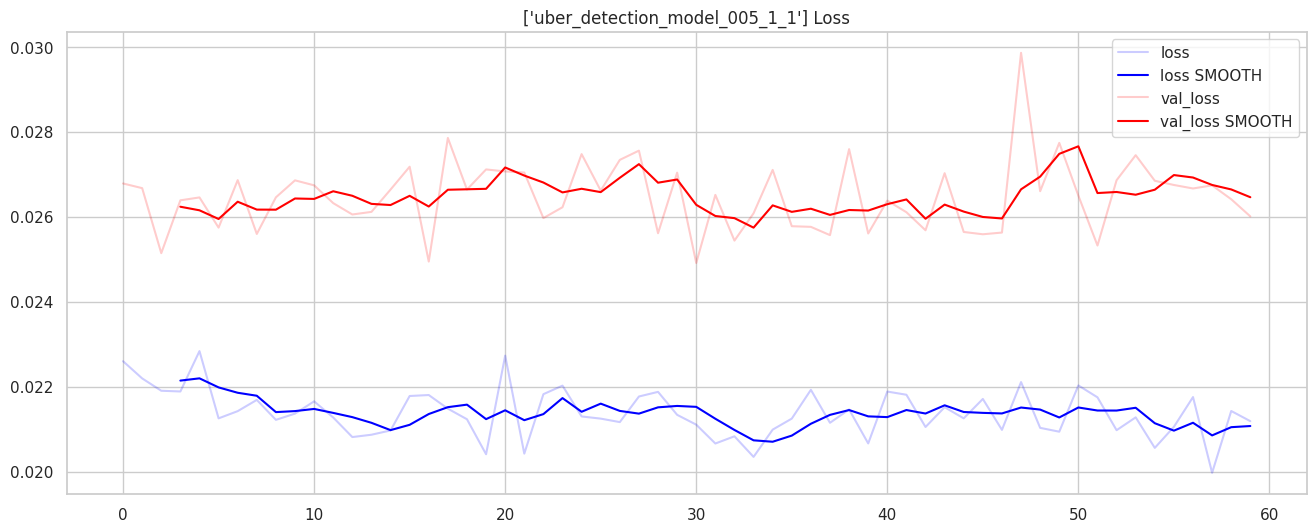

loading training log from /root/artem/analyser/training_reports/uber_detection_model_005_1_1.1.log.csv


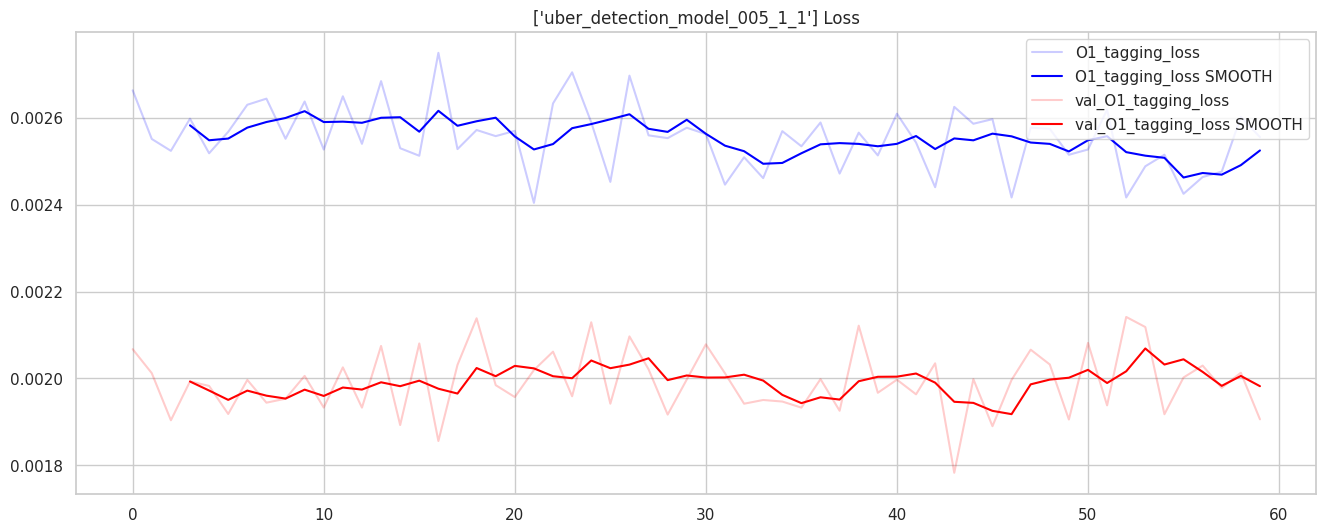

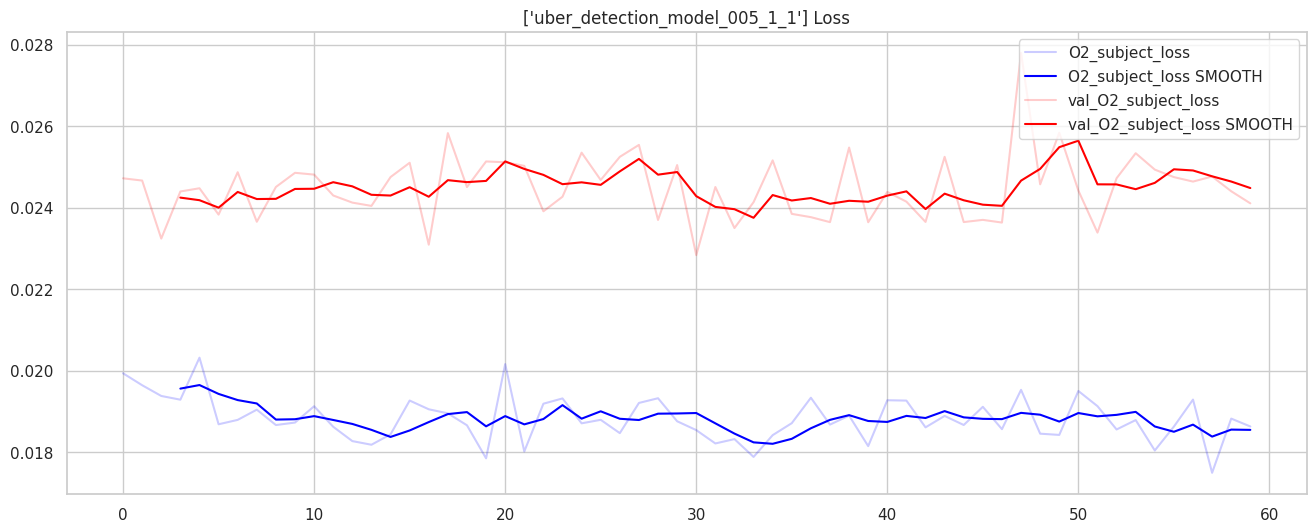

In [48]:
def plot_compare_models(
    models: [str],
    metrics, 
    title="metric/epoch",
    image_save_path = umtm.reports_dir):
    
  _metrics = [m for m in metrics if not m.startswith('val_')]

  for i, m in enumerate(models):

    data: pd.DataFrame = ctx.get_log(m)

    if data is not None:
      data.set_index('epoch')

      for metric in _metrics:
        plt.figure(figsize=(16, 6))
        plt.grid(True)
        plt.title(f'{metric} [{m}]')
        for metric_variant in ['', 'val_']:
          key = metric_variant + metric
          if key in data:

            x = data['epoch'][-100:]
            y = data[key][-100:]


            c = 'red'  # plt.cm.jet_r(i * colorstep)
            if metric_variant == '':
              c = 'blue'
            plt.plot(x, y, label=f'{key}', alpha=0.2, color=c)

            y = y.rolling(4, win_type='gaussian').mean(std=4)
            plt.plot(x, y, label=f'{key} SMOOTH', color=c)

            plt.legend(loc='upper right')

        
        plt.title(f'{[m]} {title}')
        plt.grid(True)
        img_path = os.path.join(image_save_path, f'{m}-{metric}.png')
        
        plt.savefig(img_path, bbox_inches='tight')        
        plt.show()
    else:
      logger.error('cannot plot')
    

models = list(ctx.trained_models.keys())


plot_compare_models(models, ['loss'], 'Loss')

# plot_compare_models(models, ['O1_tagging_kullback_leibler_divergence'], 'TAGS: Kullback Leibler divergence')
# plot_compare_models(models, ['O1_tagging_mse'], 'TAGS: MSE')
# plot_compare_models(models, ['O2_subject_kullback_leibler_divergence'], 'Subj: Kullback Leibler divergence')
# plot_compare_models(models, ['O2_subject_mse'],  'Subjects: MSE')

plot_compare_models(models, ['O1_tagging_loss', 'O2_subject_loss'], 'Loss')



## Contract subj Confusion matrices

In [49]:
# umtm.stats
# semantic_map_keys_contract


5ec2b8da665f7603e03b1255


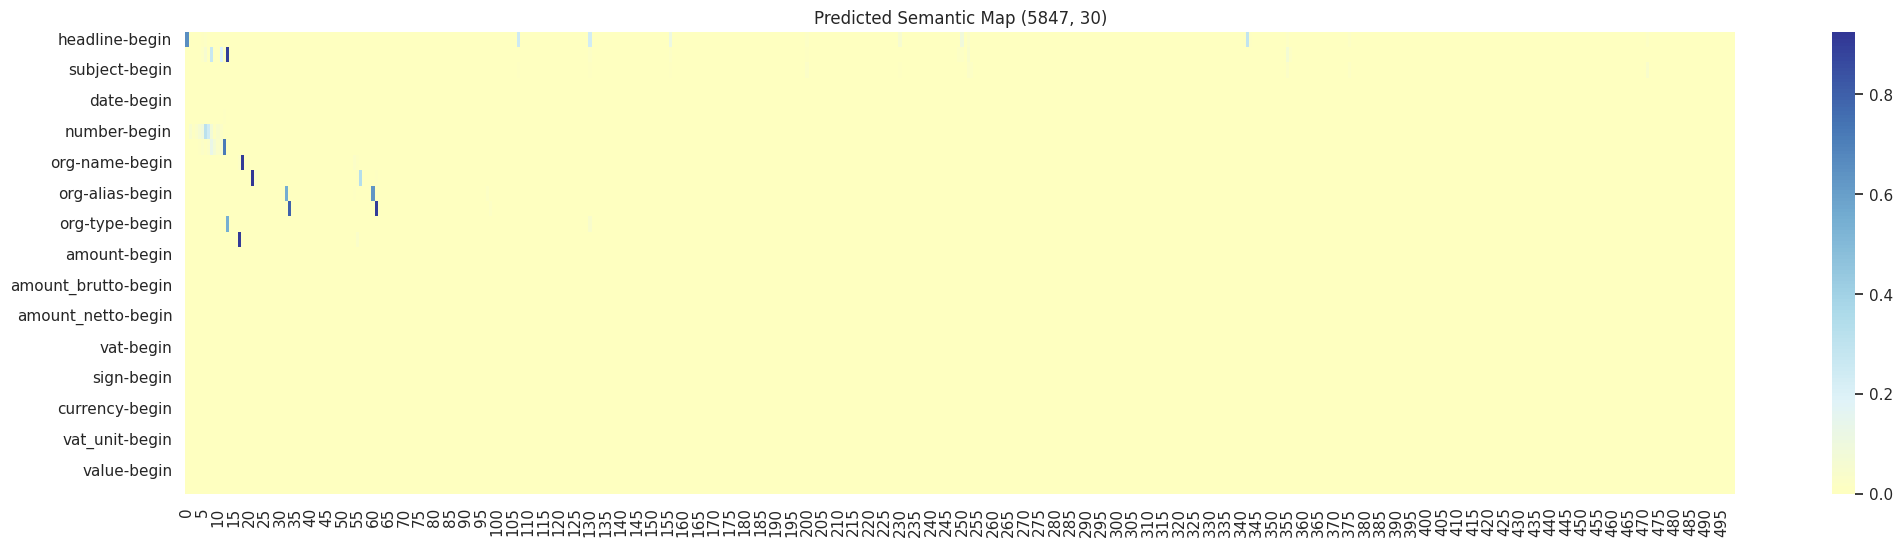

In [50]:
from tf_support.super_contract_model import make_xyw

sample_index = umtm.stats [umtm.stats['value']>0].index[2]
print(sample_index)

x, y, _ = make_xyw(sample_index, umtm.stats)

prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

tagsmap = pd.DataFrame(prediction[0][0], columns=semantic_map_keys_contract)
# .T
plot_embedding(tagsmap[:500], f'Predicted Semantic Map {tagsmap.shape}')

In [51]:
from analyser.contract_parser import nn_get_tag_values

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [52]:

agent_tags = ['org-1-name',
              'org-1-type',
              'org-1-alias',
              'org-2-name',
              'org-2-type',
              'org-2-alias']
solo_tags = [
  'date',
  'number',
  'sign_value_currency/value',
  'sign_value_currency/currency',
  'sign_value_currency/sign'
]

# seq_labels_contract[-3:]

tagnames = solo_tags + agent_tags


from pandas import DataFrame

from analyser.contract_agents import ContractAgent, normalize_contract_agent
from analyser.documents import TextMap
from analyser.ml_tools import SemanticTag
from analyser.persistence import DbJsonDoc
from analyser.text_tools import find_top_spans
# from tf_support.super_contract_model import seq_labels_contract
from tf_support.tf_subject_model import decode_subj_prediction

from analyser.contract_parser import nn_find_org_names, nn_get_tag_value




def fetch_tags_from_predicted_semantic_map(_id: str, tagsmap: DataFrame):
  jdoc = get_doc(_id)
  _map = jdoc.get_tokens_map_unchaged()

  results = {}
  for key in tagnames:
    t = nn_get_tag_value(key, _map, tagsmap )
    results[key] = t
    # print(t)

#   ca = ContractAgent()
#   ca.name =  results['org-1-name'] #TODO: check for NONE
#   ca.type =  results['org-1-type']
#   ca.alias = results['org-1-alias']
   

#   ca2 = ContractAgent()
#   ca2.name =  results['org-2-name'] #TODO: check for NONE
#   ca2.type =  results['org-2-type']
#   ca2.alias = results['org-2-alias']
#   try:
#     normalize_contract_agent(ca)
#     normalize_contract_agent(ca2)
#   except Exception as e:
#         # TODO:
#     logger.error(f'{_id} {e}')

  if results['number'] is not None:
    results['number'].value = results['number'].value.strip().lstrip('№').lstrip('N ').lstrip()

  return results, jdoc


def put_results_into_df(id_, results, df, jdoc: DbJsonDoc):
  org_atribs = ['name', 'alias', 'type']

  def v(x):
    if results[x] is not None:
      return results[x].value

  def swap(a, b):
    ab = [a, b]
    try:
      ab = sorted(ab)
    except:
      pass
    return ab

  def s(a, b):
    ab = swap(v(a), v(b))
    df.at[id_, f'p-{a}'] = ab[0]
    df.at[id_, f'p-{b}'] = ab[1]
    return ab

  for key in org_atribs:
    arr = s(f'org-1-{key}', f'org-2-{key}')

  def p(key):
    df.at[id_, f'p-{key}'] = v(key)

  p('sign_value_currency/value')
  p('sign_value_currency/currency')
  p('sign_value_currency/sign')

  p('date')
  p('number')

  # get_expected values
  for key in solo_tags:
    t = jdoc.get_attribute_value(key)
    df.at[id_, f'{key}'] = t

  for key in org_atribs:
    orgs = swap(jdoc.get_attribute_value(f'org-1-{key}'), jdoc.get_attribute_value(f'org-2-{key}'))
    df.at[id_, f'org-1-{key}'] = orgs[0]
    df.at[id_, f'org-2-{key}'] = orgs[1]



ImportError: cannot import name 'nn_get_tag_value' from 'analyser.contract_parser' (/root/artem/analyser/analyser/contract_parser.py)

In [ ]:
def make_subj_predictions(umodel, indices):
  ev = umtm.stats.copy()
  tags = pd.DataFrame()
  for t in tagnames:
    tags['p-' + t] = ''
    tags[t] = ''

  errors_report = pd.DataFrame()
  errors_report['expected'] = ''
  errors_report['predicted'] = ''

  for i, _id in enumerate(indices):
    logger.debug(f'validating {_id} {i} of {len(indices)}')
    
    x, y, _ = make_xyw(_id, umtm.stats)

    prediction = umodel.predict(x=[np.expand_dims(x[0], axis=0), np.expand_dims(x[1], axis=0)], batch_size=1)

    tagsmap = pd.DataFrame(prediction[0][0], columns=seq_labels_contract)
  
    r, jdoc = fetch_tags_from_predicted_semantic_map(_id, tagsmap)
    put_results_into_df(_id, r, tags, jdoc)
    

    subj_1hot = prediction[1][0]

    expected = decode_subj_prediction(y[1])[0]
    predicted = decode_subj_prediction(subj_1hot)[0]

    ev.at[_id, 'expected_subj'] = expected.name
    ev.at[_id, 'predicted_subj'] = predicted.name

    ev.at[_id, 'wrong'] = False
    if expected != predicted:
      ev.at[_id, 'wrong'] = True

  return ev, tags

ev, tags = make_subj_predictions(umodel, [sample_index])
tags

In [ ]:
%%time




# def fetch_tag_value(tagname: str, textmap: TextMap, tagging: DataFrame, threshold=0.3) -> SemanticTag or None:
#   att = tagging[tagname].values
#   slices = find_top_spans(att, threshold=threshold, limit=1) #TODO: estimate per-tag thresholds
  
#   if len(slices) > 0:
#     span = slices[0].start, slices[0].stop
#     value = textmap.text_range(span)
#     tag = SemanticTag(tagname, value, span)
#     tag.confidence = att[slices[0]].mean()
#     return tag
#   return None










subset = umtm.stats #umtm.stats[~pd.isna(umtm.stats['user_correction_date'])].sort_values('analyze_date')
_indices =  subset.index
ev, tags = make_subj_predictions(umodel, _indices)
tags.to_csv('all_contracts_predicstions.csv')

In [ ]:
# subset = umtm.stats[~pd.isna(umtm.stats['user_correction_date'])]
# pd.isna(umtm.stats['user_correction_date'])
ev 

In [ ]:
# _cols = [  'wrong' ]
# _tmp = ev[cols]
# errors_report = _tmp[ _tmp.wrong == True] #.sort_values('subject')
# print(len(errors_report), 'wrong subjects of', len(tags))
# errors_report 

ev['predicted_subj']
subj_df = ev[['predicted_subj', 'expected_subj']].copy()

In [ ]:
subj_df

In [ ]:
def make_report(umodel, ev):
  plot_cm(ev['expected_subj'], ev['predicted_subj'])
  
  img_path = os.path.join(umtm.work_dir, f'subjects-confusion-matrix-{umodel.name}.png')
  plt.savefig(img_path, bbox_inches='tight')

  report = classification_report(ev['expected_subj'], ev['predicted_subj'], digits=3)
  print(umodel.name)
  print(report)
  
  with open(os.path.join(umtm.work_dir, f'subjects-classification_report-{umodel.name}.txt'), "w") as text_file:
    text_file.write(report)


subj_df = ev[['predicted_subj', 'expected_subj']].copy() #ev[~pd.isna(ev['predicted_subj'])]
make_report(umodel, subj_df)

# Evaluate tags detection

In [ ]:
tags.fillna('-', inplace=True)
tags

In [ ]:
def save_csv(d, f):
    fn = os.path.join(umtm.work_dir, f)
    d.to_csv(fn)

### Contract number validation

In [ ]:
wrong_numbers = tags [ tags['number'] != tags['p-number']].sort_values('number')
print( f'Contract numbers: {len(wrong_numbers)} of {len(tags)}  ({100. * len(wrong_numbers) / len(tags) :0.1f}%) were detected wronggly')

save_csv( wrong_numbers[['p-number', 'number']], 'wrong_numbers.csv')

# wrong_numbers[['p-number', 'number']].tail(10)

In [ ]:
tags ['sign_value_currency/currency'].head(100)

In [ ]:
def conv(x):
    if type(x) is str:
        v = x.replace(',','.').replace(' ','')
    else: 
        v=x
    try:
        v=float(v)
    except:
        v=np.nan
    return v 

tags['n-p-sign_value_currency/value'] = pd.to_numeric( tags['p-sign_value_currency/value'].apply(conv) )
tags['n-sign_value_currency/value']   = pd.to_numeric( tags['sign_value_currency/value'].apply(conv) )

In [ ]:
wrong_values = tags [  tags['n-p-sign_value_currency/value']  != tags['n-sign_value_currency/value']]
cols = ['n-p-sign_value_currency/value', 'n-sign_value_currency/value']
wrong_values = wrong_values[cols]

wrong_values ['val_err'] = \
    np.log1p( np.abs(wrong_values['n-p-sign_value_currency/value'] - wrong_values['n-sign_value_currency/value']))
wrong_values = wrong_values.sort_values('val_err', ascending=False)

print(len(wrong_values))
wrong_values.tail(24)

### Contract Org-1 validation

In [ ]:


wrong_orgs1 = tags [ (tags['org-1-name'] != tags['p-org-1-name']) | (tags['org-2-name'] != tags['p-org-2-name']) ]
print( f'Org-1 name: {len(wrong_orgs1)} of {len(tags)}  ({100. * len(wrong_orgs1) / len(tags):0.1f}%) were detected incorrectly')

cols=['p-org-1-name', 'org-1-name', 'p-org-2-name', 'org-2-name']
save_csv( wrong_orgs1[cols], 'wrong_orgs1.csv')

wrong_orgs1[cols].head(20)

In [ ]:
wrong_aliases = tags [ (tags['org-1-alias'] != tags['p-org-1-alias']) | (tags['org-2-alias'] != tags['p-org-2-alias']) ]
print( f'Aliases: {len(wrong_aliases)} of {len(tags)}  ({100. * len(wrong_aliases) / len(tags) : 0.1f}%) were detected incorrectly')

cols=['p-org-1-alias', 'org-1-alias', 'p-org-2-alias', 'org-2-alias']
save_csv( wrong_aliases[cols], 'wrong_aliases.csv')
# wrong_aliases[cols].head(10)

In [ ]:
wrong_types = tags [ (tags['org-1-type'] != tags['p-org-1-type']) | (tags['org-2-type'] != tags['p-org-2-type'])]
print( f'Types: {len(wrong_types)} of {len(tags)}  ({100. * len(wrong_types) / len(tags) : 0.1f}%) were detected incorrectly')
cols=['p-org-1-type', 'p-org-2-type', 'org-1-type', 'org-2-type']
save_csv( wrong_types[cols], 'wrong_types.csv')
wrong_types[cols].head(10)

In [ ]:
from collections import Counter
arrays = [ wrong_orgs1, wrong_types, wrong_numbers, wrong_aliases]
counter = Counter()
for a in arrays:
  for i in a.index:
   counter[i]+=1
 

print('Самый сложный документ: ', counter.most_common()[0][0])
print("Всего недочетов:", len(counter))

In [ ]:
umtm.stats['errors'] = 0
for c in counter:
  umtm.stats.at[c, 'errors'] = counter[c]


calculate_samples_weights(umtm)
umtm._save_stats()
umtm.stats

## Single doc eval

In [ ]:
if IN_COLAB:
  !wget https://raw.githubusercontent.com/nemoware/analyser/uber-models/tests/contract_db_1.json

  with open('contract_db_1.json', 'rb') as handle:    
    jdata = json.load(handle, object_hook=json_util.object_hook)

  jdoc = DbJsonDoc(jdata)

else:
  from integration.db import get_mongodb_connection
  from bson.objectid import ObjectId

  def get_doc(objid):
    logger.debug(f'fetching {objid}')
    db = get_mongodb_connection()
    documents_collection = db['documents']
    jdata =  documents_collection.find_one({'_id': ObjectId(objid)})
    return DbJsonDoc(jdata)

  SAMPLE_DOC_ID = counter.most_common()[0][0] #umtm.stats.index[10]
    
    
    
  SAMPLE_DOC_ID = '5eea27adc28b75807f3dae66'
  print('SAMPLE_DOC_ID:', SAMPLE_DOC_ID)
  dp = umtm.make_xyw(SAMPLE_DOC_ID)
  (emb, tok_f), (sm, subj), (sample_weight, subject_weight) = dp

  jdoc = get_doc(SAMPLE_DOC_ID)

In [ ]:
from analyser.legal_docs import embedd_tokens

if IN_COLAB:
  embedder = ElmoEmbedder.get_instance('elmo')  # lazy init
  emb = embedd_tokens(jdoc.get_tokens_for_embedding(),
                             embedder,
                             verbosity=2,
                             log_key='tmp')

  tok_f = get_tokens_features(jdoc.get_tokens_map_unchaged().tokens)

In [ ]:
###############
prediction = umodel.predict(   x=[  np.expand_dims(emb, axis=0), np.expand_dims(tok_f, axis=0)] , batch_size=1)
##############
print(len(prediction), umodel.name)
subj_1hot = prediction[1][0]
print('Subject:', decode_subj_prediction(subj_1hot))


tagging = pd.DataFrame( prediction[0][0], columns=seq_labels_contract)
plot_embedding(tagging, title = f'Predictions of {umodel.name}')

In [ ]:
def render_slices(slices, tokens, attention_v, ht='') -> str:
  ht += '<ol>'
  for _s in slices:
    ht += '<li>'
    t = tokens[_s]
    l = attention_v[_s]
    ht += to_color_text(t, l, _range=(0, 1.2))
    ht += '<br><hr>'
    ht += '</li>'
  ht += '</ol>'

  return ht

for t in seq_labels_contract:
  spans = list( find_top_spans( tagging[t].values, threshold=0.3))  
  display(HTML(render_slices(spans, jdoc.get_tokens_map_unchaged().tokens, tagging[t].values)))


In [ ]:

# mean_ = tagging.values.max(-1)*0.5
# print (mean_.shape)
# display(HTML( to_color_text (jdoc.get_tokens_map_unchaged().tokens[:24000],  mean_[:24000])))

In [ ]:
ids = '5edbadd7da3678279fbcaabf
5edbc660da3678279fbcaeac
5edbc668da3678279fbcaf6e
5edbc65dda3678279fbcae56
5edbc66bda3678279fbcafe6
5edbc615da3678279fbcadc9'